In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_flip_add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(1485000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


   1/1306 [..............................] - ETA: 4:25:05 - loss: 2.3979

   6/1306 [..............................] - ETA: 13s - loss: 2.3979    

  11/1306 [..............................] - ETA: 13s - loss: 2.3979

  17/1306 [..............................] - ETA: 12s - loss: 2.3978

  24/1306 [..............................] - ETA: 11s - loss: 2.3978

  31/1306 [..............................] - ETA: 11s - loss: 2.3977

  38/1306 [..............................] - ETA: 10s - loss: 2.3974

  46/1306 [>.............................] - ETA: 10s - loss: 2.3969

  54/1306 [>.............................] - ETA: 10s - loss: 2.3959

  61/1306 [>.............................] - ETA: 9s - loss: 2.3942 

  68/1306 [>.............................] - ETA: 9s - loss: 2.3918

  76/1306 [>.............................] - ETA: 9s - loss: 2.3885

  84/1306 [>.............................] - ETA: 9s - loss: 2.3847

  91/1306 [=>............................] - ETA: 9s - loss: 2.3812

  98/1306 [=>............................] - ETA: 9s - loss: 2.3776

 105/1306 [=>............................] - ETA: 9s - loss: 2.3739

 112/1306 [=>............................] - ETA: 9s - loss: 2.3702

 119/1306 [=>............................] - ETA: 9s - loss: 2.3665

 126/1306 [=>............................] - ETA: 9s - loss: 2.3627

 133/1306 [==>...........................] - ETA: 9s - loss: 2.3590

 141/1306 [==>...........................] - ETA: 8s - loss: 2.3547

 149/1306 [==>...........................] - ETA: 8s - loss: 2.3503

 156/1306 [==>...........................] - ETA: 8s - loss: 2.3465

 164/1306 [==>...........................] - ETA: 8s - loss: 2.3422

 172/1306 [==>...........................] - ETA: 8s - loss: 2.3379

 180/1306 [===>..........................] - ETA: 8s - loss: 2.3336

 188/1306 [===>..........................] - ETA: 8s - loss: 2.3294

 195/1306 [===>..........................] - ETA: 8s - loss: 2.3257



 202/1306 [===>..........................] - ETA: 8s - loss: 2.3221

 210/1306 [===>..........................] - ETA: 8s - loss: 2.3180

 218/1306 [====>.........................] - ETA: 8s - loss: 2.3140

 225/1306 [====>.........................] - ETA: 8s - loss: 2.3105

 232/1306 [====>.........................] - ETA: 8s - loss: 2.3071

 240/1306 [====>.........................] - ETA: 7s - loss: 2.3033

 247/1306 [====>.........................] - ETA: 7s - loss: 2.3000

 254/1306 [====>.........................] - ETA: 7s - loss: 2.2967

 261/1306 [====>.........................] - ETA: 7s - loss: 2.2935

 268/1306 [=====>........................] - ETA: 7s - loss: 2.2904

 276/1306 [=====>........................] - ETA: 7s - loss: 2.2868

 283/1306 [=====>........................] - ETA: 7s - loss: 2.2838

 290/1306 [=====>........................] - ETA: 7s - loss: 2.2808

 298/1306 [=====>........................] - ETA: 7s - loss: 2.2775

 306/1306 [======>.......................] - ETA: 7s - loss: 2.2742

 314/1306 [======>.......................] - ETA: 7s - loss: 2.2709

 322/1306 [======>.......................] - ETA: 7s - loss: 2.2677

 329/1306 [======>.......................] - ETA: 7s - loss: 2.2650

 337/1306 [======>.......................] - ETA: 7s - loss: 2.2619

 345/1306 [======>.......................] - ETA: 7s - loss: 2.2589

 352/1306 [=======>......................] - ETA: 7s - loss: 2.2563

 359/1306 [=======>......................] - ETA: 7s - loss: 2.2537

 366/1306 [=======>......................] - ETA: 6s - loss: 2.2511



 373/1306 [=======>......................] - ETA: 6s - loss: 2.2486

 380/1306 [=======>......................] - ETA: 6s - loss: 2.2462

 388/1306 [=======>......................] - ETA: 6s - loss: 2.2434

 396/1306 [========>.....................] - ETA: 6s - loss: 2.2406

 403/1306 [========>.....................] - ETA: 6s - loss: 2.2383

 410/1306 [========>.....................] - ETA: 6s - loss: 2.2360

 418/1306 [========>.....................] - ETA: 6s - loss: 2.2333

 426/1306 [========>.....................] - ETA: 6s - loss: 2.2307

 434/1306 [========>.....................] - ETA: 6s - loss: 2.2282

 442/1306 [=========>....................] - ETA: 6s - loss: 2.2257

 450/1306 [=========>....................] - ETA: 6s - loss: 2.2232

 458/1306 [=========>....................] - ETA: 6s - loss: 2.2208

 467/1306 [=========>....................] - ETA: 6s - loss: 2.2181

 476/1306 [=========>....................] - ETA: 6s - loss: 2.2154

 485/1306 [==========>...................] - ETA: 5s - loss: 2.2128

 494/1306 [==========>...................] - ETA: 5s - loss: 2.2102

 502/1306 [==========>...................] - ETA: 5s - loss: 2.2079

 511/1306 [==========>...................] - ETA: 5s - loss: 2.2054

 520/1306 [==========>...................] - ETA: 5s - loss: 2.2029

 529/1306 [===========>..................] - ETA: 5s - loss: 2.2005

 538/1306 [===========>..................] - ETA: 5s - loss: 2.1981

 547/1306 [===========>..................] - ETA: 5s - loss: 2.1957

 555/1306 [===========>..................] - ETA: 5s - loss: 2.1936

 564/1306 [===========>..................] - ETA: 5s - loss: 2.1913

 573/1306 [============>.................] - ETA: 5s - loss: 2.1890

 582/1306 [============>.................] - ETA: 5s - loss: 2.1868

 591/1306 [============>.................] - ETA: 5s - loss: 2.1846

 600/1306 [============>.................] - ETA: 4s - loss: 2.1824

 609/1306 [============>.................] - ETA: 4s - loss: 2.1802

 618/1306 [=============>................] - ETA: 4s - loss: 2.1781

 627/1306 [=============>................] - ETA: 4s - loss: 2.1760

 636/1306 [=============>................] - ETA: 4s - loss: 2.1739

 645/1306 [=============>................] - ETA: 4s - loss: 2.1719

 653/1306 [==============>...............] - ETA: 4s - loss: 2.1701

 662/1306 [==============>...............] - ETA: 4s - loss: 2.1681

 671/1306 [==============>...............] - ETA: 4s - loss: 2.1661

 680/1306 [==============>...............] - ETA: 4s - loss: 2.1642



 689/1306 [==============>...............] - ETA: 4s - loss: 2.1623

 698/1306 [===============>..............] - ETA: 4s - loss: 2.1604

 707/1306 [===============>..............] - ETA: 4s - loss: 2.1585

 716/1306 [===============>..............] - ETA: 4s - loss: 2.1567

 724/1306 [===============>..............] - ETA: 3s - loss: 2.1551

 733/1306 [===============>..............] - ETA: 3s - loss: 2.1533

 742/1306 [================>.............] - ETA: 3s - loss: 2.1515

 751/1306 [================>.............] - ETA: 3s - loss: 2.1498

 760/1306 [================>.............] - ETA: 3s - loss: 2.1480

 769/1306 [================>.............] - ETA: 3s - loss: 2.1463

 778/1306 [================>.............] - ETA: 3s - loss: 2.1447

 787/1306 [=================>............] - ETA: 3s - loss: 2.1430

 796/1306 [=================>............] - ETA: 3s - loss: 2.1413

 805/1306 [=================>............] - ETA: 3s - loss: 2.1397

 814/1306 [=================>............] - ETA: 3s - loss: 2.1381

 823/1306 [=================>............] - ETA: 3s - loss: 2.1365

 832/1306 [==================>...........] - ETA: 3s - loss: 2.1350

 841/1306 [==================>...........] - ETA: 3s - loss: 2.1334

 850/1306 [==================>...........] - ETA: 3s - loss: 2.1319

 859/1306 [==================>...........] - ETA: 3s - loss: 2.1304

 868/1306 [==================>...........] - ETA: 2s - loss: 2.1289

 877/1306 [===================>..........] - ETA: 2s - loss: 2.1274

 886/1306 [===================>..........] - ETA: 2s - loss: 2.1259

 895/1306 [===================>..........] - ETA: 2s - loss: 2.1245

 903/1306 [===================>..........] - ETA: 2s - loss: 2.1232

 912/1306 [===================>..........] - ETA: 2s - loss: 2.1218

 921/1306 [====================>.........] - ETA: 2s - loss: 2.1204

 930/1306 [====================>.........] - ETA: 2s - loss: 2.1190

 939/1306 [====================>.........] - ETA: 2s - loss: 2.1177

 948/1306 [====================>.........] - ETA: 2s - loss: 2.1163

 957/1306 [====================>.........] - ETA: 2s - loss: 2.1150



 966/1306 [=====================>........] - ETA: 2s - loss: 2.1137

 975/1306 [=====================>........] - ETA: 2s - loss: 2.1124

 984/1306 [=====================>........] - ETA: 2s - loss: 2.1111

 993/1306 [=====================>........] - ETA: 2s - loss: 2.1098

1002/1306 [======================>.......] - ETA: 2s - loss: 2.1086

1011/1306 [======================>.......] - ETA: 1s - loss: 2.1073

1020/1306 [======================>.......] - ETA: 1s - loss: 2.1061

1029/1306 [======================>.......] - ETA: 1s - loss: 2.1048

1038/1306 [======================>.......] - ETA: 1s - loss: 2.1036

1047/1306 [=======================>......] - ETA: 1s - loss: 2.1024

1056/1306 [=======================>......] - ETA: 1s - loss: 2.1012

1065/1306 [=======================>......] - ETA: 1s - loss: 2.1001

1074/1306 [=======================>......] - ETA: 1s - loss: 2.0989

1083/1306 [=======================>......] - ETA: 1s - loss: 2.0978

1092/1306 [========================>.....] - ETA: 1s - loss: 2.0966

1101/1306 [========================>.....] - ETA: 1s - loss: 2.0955

1110/1306 [========================>.....] - ETA: 1s - loss: 2.0944

1119/1306 [========================>.....] - ETA: 1s - loss: 2.0933

1128/1306 [========================>.....] - ETA: 1s - loss: 2.0922

1137/1306 [=========================>....] - ETA: 1s - loss: 2.0911

1146/1306 [=========================>....] - ETA: 1s - loss: 2.0900

1155/1306 [=========================>....] - ETA: 0s - loss: 2.0889

1164/1306 [=========================>....] - ETA: 0s - loss: 2.0879

1173/1306 [=========================>....] - ETA: 0s - loss: 2.0868

1182/1306 [==========================>...] - ETA: 0s - loss: 2.0858

1190/1306 [==========================>...] - ETA: 0s - loss: 2.0849

1198/1306 [==========================>...] - ETA: 0s - loss: 2.0839

1207/1306 [==========================>...] - ETA: 0s - loss: 2.0829

1216/1306 [==========================>...] - ETA: 0s - loss: 2.0819

1225/1306 [===========================>..] - ETA: 0s - loss: 2.0809

1234/1306 [===========================>..] - ETA: 0s - loss: 2.0799

1243/1306 [===========================>..] - ETA: 0s - loss: 2.0790

1252/1306 [===========================>..] - ETA: 0s - loss: 2.0780

1261/1306 [===========================>..] - ETA: 0s - loss: 2.0770

1270/1306 [============================>.] - ETA: 0s - loss: 2.0761

1279/1306 [============================>.] - ETA: 0s - loss: 2.0751

1288/1306 [============================>.] - ETA: 0s - loss: 2.0742

1297/1306 [============================>.] - ETA: 0s - loss: 2.0733

1305/1306 [============================>.] - ETA: 0s - loss: 2.0725

1306/1306 [==============================] - 22s 7ms/step - loss: 2.0723 - val_loss: 1.7479


Epoch 2/100
   1/1306 [..............................] - ETA: 9s - loss: 1.8094

  10/1306 [..............................] - ETA: 7s - loss: 1.8256

  19/1306 [..............................] - ETA: 7s - loss: 1.8330

  28/1306 [..............................] - ETA: 7s - loss: 1.8353

  37/1306 [..............................] - ETA: 7s - loss: 1.8360

  46/1306 [>.............................] - ETA: 7s - loss: 1.8364

  55/1306 [>.............................] - ETA: 7s - loss: 1.8367

  64/1306 [>.............................] - ETA: 7s - loss: 1.8369

  73/1306 [>.............................] - ETA: 7s - loss: 1.8369

  82/1306 [>.............................] - ETA: 7s - loss: 1.8368

  91/1306 [=>............................] - ETA: 7s - loss: 1.8368

 100/1306 [=>............................] - ETA: 7s - loss: 1.8368

 109/1306 [=>............................] - ETA: 7s - loss: 1.8369

 118/1306 [=>............................] - ETA: 7s - loss: 1.8369

 127/1306 [=>............................] - ETA: 7s - loss: 1.8369

 136/1306 [==>...........................] - ETA: 7s - loss: 1.8368

 145/1306 [==>...........................] - ETA: 6s - loss: 1.8368

 154/1306 [==>...........................] - ETA: 6s - loss: 1.8367

 163/1306 [==>...........................] - ETA: 6s - loss: 1.8367

 172/1306 [==>...........................] - ETA: 6s - loss: 1.8366

 181/1306 [===>..........................] - ETA: 6s - loss: 1.8366

 190/1306 [===>..........................] - ETA: 6s - loss: 1.8366

 198/1306 [===>..........................] - ETA: 6s - loss: 1.8365

 207/1306 [===>..........................] - ETA: 6s - loss: 1.8365

 216/1306 [===>..........................] - ETA: 6s - loss: 1.8365

 225/1306 [====>.........................] - ETA: 6s - loss: 1.8364

 234/1306 [====>.........................] - ETA: 6s - loss: 1.8364

 243/1306 [====>.........................] - ETA: 6s - loss: 1.8363

 252/1306 [====>.........................] - ETA: 6s - loss: 1.8362

 261/1306 [====>.........................] - ETA: 6s - loss: 1.8361

 270/1306 [=====>........................] - ETA: 6s - loss: 1.8360

 279/1306 [=====>........................] - ETA: 6s - loss: 1.8359

 288/1306 [=====>........................] - ETA: 6s - loss: 1.8358

 297/1306 [=====>........................] - ETA: 6s - loss: 1.8357

 306/1306 [======>.......................] - ETA: 6s - loss: 1.8356

 315/1306 [======>.......................] - ETA: 5s - loss: 1.8355

 324/1306 [======>.......................] - ETA: 5s - loss: 1.8354

 333/1306 [======>.......................] - ETA: 5s - loss: 1.8353

 342/1306 [======>.......................] - ETA: 5s - loss: 1.8352

 351/1306 [=======>......................] - ETA: 5s - loss: 1.8351

 360/1306 [=======>......................] - ETA: 5s - loss: 1.8350

 369/1306 [=======>......................] - ETA: 5s - loss: 1.8349

 378/1306 [=======>......................] - ETA: 5s - loss: 1.8348

 387/1306 [=======>......................] - ETA: 5s - loss: 1.8348

 396/1306 [========>.....................] - ETA: 5s - loss: 1.8347

 405/1306 [========>.....................] - ETA: 5s - loss: 1.8346

 414/1306 [========>.....................] - ETA: 5s - loss: 1.8345

 423/1306 [========>.....................] - ETA: 5s - loss: 1.8344

 432/1306 [========>.....................] - ETA: 5s - loss: 1.8343

 440/1306 [=========>....................] - ETA: 5s - loss: 1.8342

 449/1306 [=========>....................] - ETA: 5s - loss: 1.8341

 458/1306 [=========>....................] - ETA: 5s - loss: 1.8340

 467/1306 [=========>....................] - ETA: 5s - loss: 1.8340

 476/1306 [=========>....................] - ETA: 4s - loss: 1.8339

 485/1306 [==========>...................] - ETA: 4s - loss: 1.8338

 494/1306 [==========>...................] - ETA: 4s - loss: 1.8337

 503/1306 [==========>...................] - ETA: 4s - loss: 1.8336

 512/1306 [==========>...................] - ETA: 4s - loss: 1.8336

 521/1306 [==========>...................] - ETA: 4s - loss: 1.8335

 529/1306 [===========>..................] - ETA: 4s - loss: 1.8334



 538/1306 [===========>..................] - ETA: 4s - loss: 1.8333

 546/1306 [===========>..................] - ETA: 4s - loss: 1.8333

 555/1306 [===========>..................] - ETA: 4s - loss: 1.8332

 564/1306 [===========>..................] - ETA: 4s - loss: 1.8331

 573/1306 [============>.................] - ETA: 4s - loss: 1.8330

 582/1306 [============>.................] - ETA: 4s - loss: 1.8330

 591/1306 [============>.................] - ETA: 4s - loss: 1.8329

 600/1306 [============>.................] - ETA: 4s - loss: 1.8328

 609/1306 [============>.................] - ETA: 4s - loss: 1.8327

 618/1306 [=============>................] - ETA: 4s - loss: 1.8327

 627/1306 [=============>................] - ETA: 4s - loss: 1.8326

 636/1306 [=============>................] - ETA: 4s - loss: 1.8325

 645/1306 [=============>................] - ETA: 3s - loss: 1.8325

 654/1306 [==============>...............] - ETA: 3s - loss: 1.8324

 662/1306 [==============>...............] - ETA: 3s - loss: 1.8324

 671/1306 [==============>...............] - ETA: 3s - loss: 1.8323

 680/1306 [==============>...............] - ETA: 3s - loss: 1.8322

 689/1306 [==============>...............] - ETA: 3s - loss: 1.8322

 698/1306 [===============>..............] - ETA: 3s - loss: 1.8321

 707/1306 [===============>..............] - ETA: 3s - loss: 1.8320

 716/1306 [===============>..............] - ETA: 3s - loss: 1.8320

 725/1306 [===============>..............] - ETA: 3s - loss: 1.8319

 734/1306 [===============>..............] - ETA: 3s - loss: 1.8318

 743/1306 [================>.............] - ETA: 3s - loss: 1.8318

 752/1306 [================>.............] - ETA: 3s - loss: 1.8317

 761/1306 [================>.............] - ETA: 3s - loss: 1.8316

 770/1306 [================>.............] - ETA: 3s - loss: 1.8316

 779/1306 [================>.............] - ETA: 3s - loss: 1.8315

 788/1306 [=================>............] - ETA: 3s - loss: 1.8314

 797/1306 [=================>............] - ETA: 3s - loss: 1.8314

 806/1306 [=================>............] - ETA: 3s - loss: 1.8313

 815/1306 [=================>............] - ETA: 2s - loss: 1.8313

 824/1306 [=================>............] - ETA: 2s - loss: 1.8312

 833/1306 [==================>...........] - ETA: 2s - loss: 1.8311

 842/1306 [==================>...........] - ETA: 2s - loss: 1.8311

 851/1306 [==================>...........] - ETA: 2s - loss: 1.8310

 860/1306 [==================>...........] - ETA: 2s - loss: 1.8310

 869/1306 [==================>...........] - ETA: 2s - loss: 1.8309

 878/1306 [===================>..........] - ETA: 2s - loss: 1.8308

 887/1306 [===================>..........] - ETA: 2s - loss: 1.8308

 896/1306 [===================>..........] - ETA: 2s - loss: 1.8307

 905/1306 [===================>..........] - ETA: 2s - loss: 1.8307

 914/1306 [===================>..........] - ETA: 2s - loss: 1.8306

 923/1306 [====================>.........] - ETA: 2s - loss: 1.8306

 932/1306 [====================>.........] - ETA: 2s - loss: 1.8305

 941/1306 [====================>.........] - ETA: 2s - loss: 1.8305

 950/1306 [====================>.........] - ETA: 2s - loss: 1.8304

 959/1306 [=====================>........] - ETA: 2s - loss: 1.8304

 968/1306 [=====================>........] - ETA: 2s - loss: 1.8303

 977/1306 [=====================>........] - ETA: 1s - loss: 1.8303

 986/1306 [=====================>........] - ETA: 1s - loss: 1.8302

 995/1306 [=====================>........] - ETA: 1s - loss: 1.8301

1004/1306 [======================>.......] - ETA: 1s - loss: 1.8301

1013/1306 [======================>.......] - ETA: 1s - loss: 1.8300



1021/1306 [======================>.......] - ETA: 1s - loss: 1.8300

1030/1306 [======================>.......] - ETA: 1s - loss: 1.8300

1039/1306 [======================>.......] - ETA: 1s - loss: 1.8299

1048/1306 [=======================>......] - ETA: 1s - loss: 1.8299

1057/1306 [=======================>......] - ETA: 1s - loss: 1.8298

1066/1306 [=======================>......] - ETA: 1s - loss: 1.8297

1075/1306 [=======================>......] - ETA: 1s - loss: 1.8297

1084/1306 [=======================>......] - ETA: 1s - loss: 1.8296

1093/1306 [========================>.....] - ETA: 1s - loss: 1.8296

1102/1306 [========================>.....] - ETA: 1s - loss: 1.8295

1111/1306 [========================>.....] - ETA: 1s - loss: 1.8295

1120/1306 [========================>.....] - ETA: 1s - loss: 1.8294

1129/1306 [========================>.....] - ETA: 1s - loss: 1.8294

1138/1306 [=========================>....] - ETA: 1s - loss: 1.8293

1147/1306 [=========================>....] - ETA: 0s - loss: 1.8293



1156/1306 [=========================>....] - ETA: 0s - loss: 1.8292

1164/1306 [=========================>....] - ETA: 0s - loss: 1.8292

1173/1306 [=========================>....] - ETA: 0s - loss: 1.8292

1182/1306 [==========================>...] - ETA: 0s - loss: 1.8291

1191/1306 [==========================>...] - ETA: 0s - loss: 1.8291

1200/1306 [==========================>...] - ETA: 0s - loss: 1.8290

1209/1306 [==========================>...] - ETA: 0s - loss: 1.8290

1218/1306 [==========================>...] - ETA: 0s - loss: 1.8289

1227/1306 [===========================>..] - ETA: 0s - loss: 1.8289

1236/1306 [===========================>..] - ETA: 0s - loss: 1.8288

1245/1306 [===========================>..] - ETA: 0s - loss: 1.8288

1254/1306 [===========================>..] - ETA: 0s - loss: 1.8287

1263/1306 [============================>.] - ETA: 0s - loss: 1.8287

1272/1306 [============================>.] - ETA: 0s - loss: 1.8286

1280/1306 [============================>.] - ETA: 0s - loss: 1.8286

1289/1306 [============================>.] - ETA: 0s - loss: 1.8285

1298/1306 [============================>.] - ETA: 0s - loss: 1.8285

1306/1306 [==============================] - 8s 6ms/step - loss: 1.8284 - val_loss: 1.7154


Epoch 3/100
   1/1306 [..............................] - ETA: 9s - loss: 1.8325

  10/1306 [..............................] - ETA: 7s - loss: 1.8177



  19/1306 [..............................] - ETA: 7s - loss: 1.8172

  27/1306 [..............................] - ETA: 7s - loss: 1.8176

  36/1306 [..............................] - ETA: 7s - loss: 1.8166

  45/1306 [>.............................] - ETA: 7s - loss: 1.8159

  54/1306 [>.............................] - ETA: 7s - loss: 1.8152

  63/1306 [>.............................] - ETA: 7s - loss: 1.8145

  72/1306 [>.............................] - ETA: 7s - loss: 1.8137

  80/1306 [>.............................] - ETA: 7s - loss: 1.8132

  89/1306 [=>............................] - ETA: 7s - loss: 1.8126

  98/1306 [=>............................] - ETA: 7s - loss: 1.8121

 107/1306 [=>............................] - ETA: 7s - loss: 1.8118

 116/1306 [=>............................] - ETA: 7s - loss: 1.8115

 125/1306 [=>............................] - ETA: 7s - loss: 1.8113

 134/1306 [==>...........................] - ETA: 7s - loss: 1.8111

 143/1306 [==>...........................] - ETA: 7s - loss: 1.8110

 152/1306 [==>...........................] - ETA: 6s - loss: 1.8109

 161/1306 [==>...........................] - ETA: 6s - loss: 1.8108

 170/1306 [==>...........................] - ETA: 6s - loss: 1.8107

 179/1306 [===>..........................] - ETA: 6s - loss: 1.8106

 188/1306 [===>..........................] - ETA: 6s - loss: 1.8105

 197/1306 [===>..........................] - ETA: 6s - loss: 1.8104

 206/1306 [===>..........................] - ETA: 6s - loss: 1.8103

 215/1306 [===>..........................] - ETA: 6s - loss: 1.8102

 224/1306 [====>.........................] - ETA: 6s - loss: 1.8102

 233/1306 [====>.........................] - ETA: 6s - loss: 1.8101

 242/1306 [====>.........................] - ETA: 6s - loss: 1.8100

 251/1306 [====>.........................] - ETA: 6s - loss: 1.8100

 260/1306 [====>.........................] - ETA: 6s - loss: 1.8099

 269/1306 [=====>........................] - ETA: 6s - loss: 1.8099

 278/1306 [=====>........................] - ETA: 6s - loss: 1.8098

 287/1306 [=====>........................] - ETA: 6s - loss: 1.8098

 296/1306 [=====>........................] - ETA: 6s - loss: 1.8097

 305/1306 [======>.......................] - ETA: 6s - loss: 1.8096

 314/1306 [======>.......................] - ETA: 5s - loss: 1.8096

 323/1306 [======>.......................] - ETA: 5s - loss: 1.8096

 331/1306 [======>.......................] - ETA: 5s - loss: 1.8095

 339/1306 [======>.......................] - ETA: 5s - loss: 1.8095

 348/1306 [======>.......................] - ETA: 5s - loss: 1.8094

 357/1306 [=======>......................] - ETA: 5s - loss: 1.8094

 366/1306 [=======>......................] - ETA: 5s - loss: 1.8093

 375/1306 [=======>......................] - ETA: 5s - loss: 1.8093

 384/1306 [=======>......................] - ETA: 5s - loss: 1.8092

 393/1306 [========>.....................] - ETA: 5s - loss: 1.8092

 402/1306 [========>.....................] - ETA: 5s - loss: 1.8091

 411/1306 [========>.....................] - ETA: 5s - loss: 1.8091

 420/1306 [========>.....................] - ETA: 5s - loss: 1.8090

 429/1306 [========>.....................] - ETA: 5s - loss: 1.8090

 438/1306 [=========>....................] - ETA: 5s - loss: 1.8089

 446/1306 [=========>....................] - ETA: 5s - loss: 1.8089

 455/1306 [=========>....................] - ETA: 5s - loss: 1.8088

 464/1306 [=========>....................] - ETA: 5s - loss: 1.8088

 473/1306 [=========>....................] - ETA: 5s - loss: 1.8088

 482/1306 [==========>...................] - ETA: 4s - loss: 1.8087

 489/1306 [==========>...................] - ETA: 4s - loss: 1.8087

 497/1306 [==========>...................] - ETA: 4s - loss: 1.8087



 505/1306 [==========>...................] - ETA: 4s - loss: 1.8086

 513/1306 [==========>...................] - ETA: 4s - loss: 1.8086

 521/1306 [==========>...................] - ETA: 4s - loss: 1.8086

 530/1306 [===========>..................] - ETA: 4s - loss: 1.8085



 539/1306 [===========>..................] - ETA: 4s - loss: 1.8085

 548/1306 [===========>..................] - ETA: 4s - loss: 1.8084

 557/1306 [===========>..................] - ETA: 4s - loss: 1.8084

 566/1306 [============>.................] - ETA: 4s - loss: 1.8084

 575/1306 [============>.................] - ETA: 4s - loss: 1.8083

 584/1306 [============>.................] - ETA: 4s - loss: 1.8083

 592/1306 [============>.................] - ETA: 4s - loss: 1.8082



 601/1306 [============>.................] - ETA: 4s - loss: 1.8082

 610/1306 [=============>................] - ETA: 4s - loss: 1.8082



 619/1306 [=============>................] - ETA: 4s - loss: 1.8081

 627/1306 [=============>................] - ETA: 4s - loss: 1.8081

 636/1306 [=============>................] - ETA: 4s - loss: 1.8081



 644/1306 [=============>................] - ETA: 4s - loss: 1.8080



 653/1306 [==============>...............] - ETA: 3s - loss: 1.8080

 662/1306 [==============>...............] - ETA: 3s - loss: 1.8079

 671/1306 [==============>...............] - ETA: 3s - loss: 1.8079

 679/1306 [==============>...............] - ETA: 3s - loss: 1.8079

 687/1306 [==============>...............] - ETA: 3s - loss: 1.8079

 695/1306 [==============>...............] - ETA: 3s - loss: 1.8078



 703/1306 [===============>..............] - ETA: 3s - loss: 1.8078

 711/1306 [===============>..............] - ETA: 3s - loss: 1.8078

 719/1306 [===============>..............] - ETA: 3s - loss: 1.8077

 727/1306 [===============>..............] - ETA: 3s - loss: 1.8077

 735/1306 [===============>..............] - ETA: 3s - loss: 1.8077

 743/1306 [================>.............] - ETA: 3s - loss: 1.8077

 750/1306 [================>.............] - ETA: 3s - loss: 1.8076

 757/1306 [================>.............] - ETA: 3s - loss: 1.8076

 764/1306 [================>.............] - ETA: 3s - loss: 1.8076

 772/1306 [================>.............] - ETA: 3s - loss: 1.8076

 780/1306 [================>.............] - ETA: 3s - loss: 1.8075

 788/1306 [=================>............] - ETA: 3s - loss: 1.8075

 796/1306 [=================>............] - ETA: 3s - loss: 1.8075

 805/1306 [=================>............] - ETA: 3s - loss: 1.8074



 814/1306 [=================>............] - ETA: 3s - loss: 1.8074

 823/1306 [=================>............] - ETA: 3s - loss: 1.8074

 832/1306 [==================>...........] - ETA: 2s - loss: 1.8073

 841/1306 [==================>...........] - ETA: 2s - loss: 1.8073

 850/1306 [==================>...........] - ETA: 2s - loss: 1.8073

 857/1306 [==================>...........] - ETA: 2s - loss: 1.8072

 863/1306 [==================>...........] - ETA: 2s - loss: 1.8072

 869/1306 [==================>...........] - ETA: 2s - loss: 1.8072

 878/1306 [===================>..........] - ETA: 2s - loss: 1.8072

 887/1306 [===================>..........] - ETA: 2s - loss: 1.8071

 896/1306 [===================>..........] - ETA: 2s - loss: 1.8071

 905/1306 [===================>..........] - ETA: 2s - loss: 1.8071

 914/1306 [===================>..........] - ETA: 2s - loss: 1.8070

 923/1306 [====================>.........] - ETA: 2s - loss: 1.8070

 932/1306 [====================>.........] - ETA: 2s - loss: 1.8070

 941/1306 [====================>.........] - ETA: 2s - loss: 1.8069

 950/1306 [====================>.........] - ETA: 2s - loss: 1.8069

 958/1306 [=====================>........] - ETA: 2s - loss: 1.8069

 967/1306 [=====================>........] - ETA: 2s - loss: 1.8068

 976/1306 [=====================>........] - ETA: 2s - loss: 1.8068

 985/1306 [=====================>........] - ETA: 1s - loss: 1.8068

 994/1306 [=====================>........] - ETA: 1s - loss: 1.8067

1003/1306 [======================>.......] - ETA: 1s - loss: 1.8067

1012/1306 [======================>.......] - ETA: 1s - loss: 1.8067

1021/1306 [======================>.......] - ETA: 1s - loss: 1.8067

1030/1306 [======================>.......] - ETA: 1s - loss: 1.8066

1039/1306 [======================>.......] - ETA: 1s - loss: 1.8066

1048/1306 [=======================>......] - ETA: 1s - loss: 1.8066

1057/1306 [=======================>......] - ETA: 1s - loss: 1.8065

1066/1306 [=======================>......] - ETA: 1s - loss: 1.8065

1075/1306 [=======================>......] - ETA: 1s - loss: 1.8065

1082/1306 [=======================>......] - ETA: 1s - loss: 1.8065

1090/1306 [========================>.....] - ETA: 1s - loss: 1.8064

1099/1306 [========================>.....] - ETA: 1s - loss: 1.8064

1108/1306 [========================>.....] - ETA: 1s - loss: 1.8064

1117/1306 [========================>.....] - ETA: 1s - loss: 1.8064

1126/1306 [========================>.....] - ETA: 1s - loss: 1.8063

1135/1306 [=========================>....] - ETA: 1s - loss: 1.8063

1144/1306 [=========================>....] - ETA: 1s - loss: 1.8063

1153/1306 [=========================>....] - ETA: 0s - loss: 1.8063

1162/1306 [=========================>....] - ETA: 0s - loss: 1.8062

1171/1306 [=========================>....] - ETA: 0s - loss: 1.8062

1180/1306 [==========================>...] - ETA: 0s - loss: 1.8062

1189/1306 [==========================>...] - ETA: 0s - loss: 1.8062

1198/1306 [==========================>...] - ETA: 0s - loss: 1.8061

1207/1306 [==========================>...] - ETA: 0s - loss: 1.8061

1216/1306 [==========================>...] - ETA: 0s - loss: 1.8061

1225/1306 [===========================>..] - ETA: 0s - loss: 1.8061

1234/1306 [===========================>..] - ETA: 0s - loss: 1.8060

1243/1306 [===========================>..] - ETA: 0s - loss: 1.8060

1251/1306 [===========================>..] - ETA: 0s - loss: 1.8060

1260/1306 [===========================>..] - ETA: 0s - loss: 1.8060

1269/1306 [============================>.] - ETA: 0s - loss: 1.8059

1278/1306 [============================>.] - ETA: 0s - loss: 1.8059

1287/1306 [============================>.] - ETA: 0s - loss: 1.8059

1296/1306 [============================>.] - ETA: 0s - loss: 1.8059

1304/1306 [============================>.] - ETA: 0s - loss: 1.8059

1306/1306 [==============================] - 8s 6ms/step - loss: 1.8058 - val_loss: 1.7046


Epoch 4/100
   1/1306 [..............................] - ETA: 10s - loss: 1.7895

   9/1306 [..............................] - ETA: 8s - loss: 1.7949 

  18/1306 [..............................] - ETA: 7s - loss: 1.8009

  27/1306 [..............................] - ETA: 7s - loss: 1.8017

  36/1306 [..............................] - ETA: 7s - loss: 1.8001

  45/1306 [>.............................] - ETA: 7s - loss: 1.7986

  54/1306 [>.............................] - ETA: 7s - loss: 1.7977

  63/1306 [>.............................] - ETA: 7s - loss: 1.7970

  72/1306 [>.............................] - ETA: 7s - loss: 1.7963

  81/1306 [>.............................] - ETA: 7s - loss: 1.7959

  89/1306 [=>............................] - ETA: 7s - loss: 1.7957

  98/1306 [=>............................] - ETA: 7s - loss: 1.7954

 107/1306 [=>............................] - ETA: 7s - loss: 1.7953

 116/1306 [=>............................] - ETA: 7s - loss: 1.7951

 125/1306 [=>............................] - ETA: 7s - loss: 1.7950

 134/1306 [==>...........................] - ETA: 7s - loss: 1.7949

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7948

 152/1306 [==>...........................] - ETA: 6s - loss: 1.7948

 161/1306 [==>...........................] - ETA: 6s - loss: 1.7948

 170/1306 [==>...........................] - ETA: 6s - loss: 1.7947

 178/1306 [===>..........................] - ETA: 6s - loss: 1.7947

 186/1306 [===>..........................] - ETA: 6s - loss: 1.7946

 194/1306 [===>..........................] - ETA: 6s - loss: 1.7946

 203/1306 [===>..........................] - ETA: 6s - loss: 1.7946

 211/1306 [===>..........................] - ETA: 6s - loss: 1.7946

 220/1306 [====>.........................] - ETA: 6s - loss: 1.7946

 228/1306 [====>.........................] - ETA: 6s - loss: 1.7946

 237/1306 [====>.........................] - ETA: 6s - loss: 1.7946

 246/1306 [====>.........................] - ETA: 6s - loss: 1.7946

 255/1306 [====>.........................] - ETA: 6s - loss: 1.7945



 264/1306 [=====>........................] - ETA: 6s - loss: 1.7945

 273/1306 [=====>........................] - ETA: 6s - loss: 1.7945

 282/1306 [=====>........................] - ETA: 6s - loss: 1.7945

 291/1306 [=====>........................] - ETA: 6s - loss: 1.7945

 300/1306 [=====>........................] - ETA: 6s - loss: 1.7945

 309/1306 [======>.......................] - ETA: 6s - loss: 1.7945

 318/1306 [======>.......................] - ETA: 5s - loss: 1.7945



 327/1306 [======>.......................] - ETA: 5s - loss: 1.7946

 336/1306 [======>.......................] - ETA: 5s - loss: 1.7946

 345/1306 [======>.......................] - ETA: 5s - loss: 1.7946

 354/1306 [=======>......................] - ETA: 5s - loss: 1.7946

 363/1306 [=======>......................] - ETA: 5s - loss: 1.7946

 371/1306 [=======>......................] - ETA: 5s - loss: 1.7946

 380/1306 [=======>......................] - ETA: 5s - loss: 1.7946

 389/1306 [=======>......................] - ETA: 5s - loss: 1.7946

 398/1306 [========>.....................] - ETA: 5s - loss: 1.7946

 407/1306 [========>.....................] - ETA: 5s - loss: 1.7946

 416/1306 [========>.....................] - ETA: 5s - loss: 1.7946

 425/1306 [========>.....................] - ETA: 5s - loss: 1.7945

 434/1306 [========>.....................] - ETA: 5s - loss: 1.7945

 443/1306 [=========>....................] - ETA: 5s - loss: 1.7945

 452/1306 [=========>....................] - ETA: 5s - loss: 1.7945

 461/1306 [=========>....................] - ETA: 5s - loss: 1.7945

 470/1306 [=========>....................] - ETA: 5s - loss: 1.7945

 479/1306 [==========>...................] - ETA: 4s - loss: 1.7945

 488/1306 [==========>...................] - ETA: 4s - loss: 1.7945

 497/1306 [==========>...................] - ETA: 4s - loss: 1.7945

 506/1306 [==========>...................] - ETA: 4s - loss: 1.7945

 515/1306 [==========>...................] - ETA: 4s - loss: 1.7944

 524/1306 [===========>..................] - ETA: 4s - loss: 1.7944

 533/1306 [===========>..................] - ETA: 4s - loss: 1.7944

 542/1306 [===========>..................] - ETA: 4s - loss: 1.7944

 550/1306 [===========>..................] - ETA: 4s - loss: 1.7944

 559/1306 [===========>..................] - ETA: 4s - loss: 1.7944

 568/1306 [============>.................] - ETA: 4s - loss: 1.7943

 576/1306 [============>.................] - ETA: 4s - loss: 1.7943

 585/1306 [============>.................] - ETA: 4s - loss: 1.7943

 594/1306 [============>.................] - ETA: 4s - loss: 1.7943

 602/1306 [============>.................] - ETA: 4s - loss: 1.7943

 611/1306 [=============>................] - ETA: 4s - loss: 1.7943

 620/1306 [=============>................] - ETA: 4s - loss: 1.7943

 629/1306 [=============>................] - ETA: 4s - loss: 1.7943

 638/1306 [=============>................] - ETA: 4s - loss: 1.7942

 647/1306 [=============>................] - ETA: 3s - loss: 1.7942

 656/1306 [==============>...............] - ETA: 3s - loss: 1.7942

 665/1306 [==============>...............] - ETA: 3s - loss: 1.7942

 674/1306 [==============>...............] - ETA: 3s - loss: 1.7942

 682/1306 [==============>...............] - ETA: 3s - loss: 1.7942

 691/1306 [==============>...............] - ETA: 3s - loss: 1.7942

 700/1306 [===============>..............] - ETA: 3s - loss: 1.7942

 709/1306 [===============>..............] - ETA: 3s - loss: 1.7941

 718/1306 [===============>..............] - ETA: 3s - loss: 1.7941

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7941

 736/1306 [===============>..............] - ETA: 3s - loss: 1.7941

 745/1306 [================>.............] - ETA: 3s - loss: 1.7941

 754/1306 [================>.............] - ETA: 3s - loss: 1.7941

 763/1306 [================>.............] - ETA: 3s - loss: 1.7941

 772/1306 [================>.............] - ETA: 3s - loss: 1.7940

 781/1306 [================>.............] - ETA: 3s - loss: 1.7940

 790/1306 [=================>............] - ETA: 3s - loss: 1.7940

 798/1306 [=================>............] - ETA: 3s - loss: 1.7940

 805/1306 [=================>............] - ETA: 3s - loss: 1.7940

 813/1306 [=================>............] - ETA: 2s - loss: 1.7940

 822/1306 [=================>............] - ETA: 2s - loss: 1.7940

 831/1306 [==================>...........] - ETA: 2s - loss: 1.7940

 840/1306 [==================>...........] - ETA: 2s - loss: 1.7939

 849/1306 [==================>...........] - ETA: 2s - loss: 1.7939

 858/1306 [==================>...........] - ETA: 2s - loss: 1.7939

 867/1306 [==================>...........] - ETA: 2s - loss: 1.7939

 876/1306 [===================>..........] - ETA: 2s - loss: 1.7939

 885/1306 [===================>..........] - ETA: 2s - loss: 1.7939

 894/1306 [===================>..........] - ETA: 2s - loss: 1.7939

 902/1306 [===================>..........] - ETA: 2s - loss: 1.7939

 911/1306 [===================>..........] - ETA: 2s - loss: 1.7938

 920/1306 [====================>.........] - ETA: 2s - loss: 1.7938

 929/1306 [====================>.........] - ETA: 2s - loss: 1.7938

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7938

 947/1306 [====================>.........] - ETA: 2s - loss: 1.7938

 956/1306 [====================>.........] - ETA: 2s - loss: 1.7938

 965/1306 [=====================>........] - ETA: 2s - loss: 1.7938

 974/1306 [=====================>........] - ETA: 2s - loss: 1.7937

 983/1306 [=====================>........] - ETA: 1s - loss: 1.7937

 992/1306 [=====================>........] - ETA: 1s - loss: 1.7937

1001/1306 [=====================>........] - ETA: 1s - loss: 1.7937

1010/1306 [======================>.......] - ETA: 1s - loss: 1.7937

1018/1306 [======================>.......] - ETA: 1s - loss: 1.7937

1026/1306 [======================>.......] - ETA: 1s - loss: 1.7937

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7936

1044/1306 [======================>.......] - ETA: 1s - loss: 1.7936

1053/1306 [=======================>......] - ETA: 1s - loss: 1.7936

1062/1306 [=======================>......] - ETA: 1s - loss: 1.7936

1071/1306 [=======================>......] - ETA: 1s - loss: 1.7936

1080/1306 [=======================>......] - ETA: 1s - loss: 1.7936

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7936

1097/1306 [========================>.....] - ETA: 1s - loss: 1.7935

1106/1306 [========================>.....] - ETA: 1s - loss: 1.7935

1115/1306 [========================>.....] - ETA: 1s - loss: 1.7935

1124/1306 [========================>.....] - ETA: 1s - loss: 1.7935

1133/1306 [=========================>....] - ETA: 1s - loss: 1.7935

1142/1306 [=========================>....] - ETA: 0s - loss: 1.7935

1151/1306 [=========================>....] - ETA: 0s - loss: 1.7935

1160/1306 [=========================>....] - ETA: 0s - loss: 1.7935

1169/1306 [=========================>....] - ETA: 0s - loss: 1.7934

1178/1306 [==========================>...] - ETA: 0s - loss: 1.7934

1187/1306 [==========================>...] - ETA: 0s - loss: 1.7934

1196/1306 [==========================>...] - ETA: 0s - loss: 1.7934

1205/1306 [==========================>...] - ETA: 0s - loss: 1.7934



1214/1306 [==========================>...] - ETA: 0s - loss: 1.7934

1223/1306 [===========================>..] - ETA: 0s - loss: 1.7934

1232/1306 [===========================>..] - ETA: 0s - loss: 1.7934

1241/1306 [===========================>..] - ETA: 0s - loss: 1.7934

1250/1306 [===========================>..] - ETA: 0s - loss: 1.7933

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7933

1268/1306 [============================>.] - ETA: 0s - loss: 1.7933

1276/1306 [============================>.] - ETA: 0s - loss: 1.7933

1285/1306 [============================>.] - ETA: 0s - loss: 1.7933

1294/1306 [============================>.] - ETA: 0s - loss: 1.7933

1302/1306 [============================>.] - ETA: 0s - loss: 1.7933

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7933 - val_loss: 1.6981


Epoch 5/100
   1/1306 [..............................] - ETA: 8s - loss: 1.8063

  10/1306 [..............................] - ETA: 7s - loss: 1.7899

  19/1306 [..............................] - ETA: 7s - loss: 1.7917

  28/1306 [..............................] - ETA: 7s - loss: 1.7920

  37/1306 [..............................] - ETA: 7s - loss: 1.7927

  46/1306 [>.............................] - ETA: 7s - loss: 1.7931

  55/1306 [>.............................] - ETA: 7s - loss: 1.7932

  64/1306 [>.............................] - ETA: 7s - loss: 1.7932

  73/1306 [>.............................] - ETA: 7s - loss: 1.7931

  82/1306 [>.............................] - ETA: 7s - loss: 1.7928

  91/1306 [=>............................] - ETA: 7s - loss: 1.7925

 100/1306 [=>............................] - ETA: 7s - loss: 1.7922

 109/1306 [=>............................] - ETA: 7s - loss: 1.7918

 118/1306 [=>............................] - ETA: 7s - loss: 1.7915

 127/1306 [=>............................] - ETA: 7s - loss: 1.7913

 136/1306 [==>...........................] - ETA: 7s - loss: 1.7910

 145/1306 [==>...........................] - ETA: 7s - loss: 1.7909

 154/1306 [==>...........................] - ETA: 6s - loss: 1.7907

 163/1306 [==>...........................] - ETA: 6s - loss: 1.7905

 172/1306 [==>...........................] - ETA: 6s - loss: 1.7903

 181/1306 [===>..........................] - ETA: 6s - loss: 1.7902

 190/1306 [===>..........................] - ETA: 6s - loss: 1.7900

 199/1306 [===>..........................] - ETA: 6s - loss: 1.7898

 208/1306 [===>..........................] - ETA: 6s - loss: 1.7897

 217/1306 [===>..........................] - ETA: 6s - loss: 1.7895

 226/1306 [====>.........................] - ETA: 6s - loss: 1.7894

 235/1306 [====>.........................] - ETA: 6s - loss: 1.7892

 244/1306 [====>.........................] - ETA: 6s - loss: 1.7891

 253/1306 [====>.........................] - ETA: 6s - loss: 1.7890

 262/1306 [=====>........................] - ETA: 6s - loss: 1.7888

 271/1306 [=====>........................] - ETA: 6s - loss: 1.7887

 280/1306 [=====>........................] - ETA: 6s - loss: 1.7886

 289/1306 [=====>........................] - ETA: 6s - loss: 1.7885

 298/1306 [=====>........................] - ETA: 6s - loss: 1.7885

 307/1306 [======>.......................] - ETA: 5s - loss: 1.7884

 316/1306 [======>.......................] - ETA: 5s - loss: 1.7884

 325/1306 [======>.......................] - ETA: 5s - loss: 1.7883

 334/1306 [======>.......................] - ETA: 5s - loss: 1.7883

 343/1306 [======>.......................] - ETA: 5s - loss: 1.7882

 352/1306 [=======>......................] - ETA: 5s - loss: 1.7882

 361/1306 [=======>......................] - ETA: 5s - loss: 1.7881

 370/1306 [=======>......................] - ETA: 5s - loss: 1.7881

 379/1306 [=======>......................] - ETA: 5s - loss: 1.7880

 388/1306 [=======>......................] - ETA: 5s - loss: 1.7880

 396/1306 [========>.....................] - ETA: 5s - loss: 1.7880

 405/1306 [========>.....................] - ETA: 5s - loss: 1.7879

 414/1306 [========>.....................] - ETA: 5s - loss: 1.7879

 423/1306 [========>.....................] - ETA: 5s - loss: 1.7879

 432/1306 [========>.....................] - ETA: 5s - loss: 1.7878

 441/1306 [=========>....................] - ETA: 5s - loss: 1.7878

 450/1306 [=========>....................] - ETA: 5s - loss: 1.7877

 459/1306 [=========>....................] - ETA: 5s - loss: 1.7877

 468/1306 [=========>....................] - ETA: 5s - loss: 1.7876

 477/1306 [=========>....................] - ETA: 4s - loss: 1.7876

 486/1306 [==========>...................] - ETA: 4s - loss: 1.7876

 495/1306 [==========>...................] - ETA: 4s - loss: 1.7875

 504/1306 [==========>...................] - ETA: 4s - loss: 1.7875

 513/1306 [==========>...................] - ETA: 4s - loss: 1.7874

 522/1306 [==========>...................] - ETA: 4s - loss: 1.7874

 531/1306 [===========>..................] - ETA: 4s - loss: 1.7874

 540/1306 [===========>..................] - ETA: 4s - loss: 1.7874

 549/1306 [===========>..................] - ETA: 4s - loss: 1.7873

 558/1306 [===========>..................] - ETA: 4s - loss: 1.7873

 567/1306 [============>.................] - ETA: 4s - loss: 1.7873

 576/1306 [============>.................] - ETA: 4s - loss: 1.7873

 585/1306 [============>.................] - ETA: 4s - loss: 1.7872

 594/1306 [============>.................] - ETA: 4s - loss: 1.7872

 603/1306 [============>.................]

 - ETA: 4s - loss: 1.7872

 612/1306 [=============>................] - ETA: 4s - loss: 1.7872

 621/1306 [=============>................] - ETA: 4s - loss: 1.7872

 630/1306 [=============>................] - ETA: 4s - loss: 1.7871

 639/1306 [=============>................] - ETA: 4s - loss: 1.7871

 648/1306 [=============>................] - ETA: 3s - loss: 1.7871

 657/1306 [==============>...............] - ETA: 3s - loss: 1.7871

 666/1306 [==============>...............] - ETA: 3s - loss: 1.7871

 675/1306 [==============>...............] - ETA: 3s - loss: 1.7871

 684/1306 [==============>...............] - ETA: 3s - loss: 1.7871

 693/1306 [==============>...............] - ETA: 3s - loss: 1.7871

 702/1306 [===============>..............] - ETA: 3s - loss: 1.7871

 711/1306 [===============>..............] - ETA: 3s - loss: 1.7871

 720/1306 [===============>..............] - ETA: 3s - loss: 1.7870

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7870

 734/1306 [===============>..............] - ETA: 3s - loss: 1.7870

 743/1306 [================>.............] - ETA: 3s - loss: 1.7870

 752/1306 [================>.............] - ETA: 3s - loss: 1.7870

 761/1306 [================>.............] - ETA: 3s - loss: 1.7870

 770/1306 [================>.............] - ETA: 3s - loss: 1.7870

 778/1306 [================>.............] - ETA: 3s - loss: 1.7870

 785/1306 [=================>............] - ETA: 3s - loss: 1.7870

 791/1306 [=================>............] - ETA: 3s - loss: 1.7870

 800/1306 [=================>............] - ETA: 3s - loss: 1.7870

 809/1306 [=================>............] - ETA: 3s - loss: 1.7870

 818/1306 [=================>............] - ETA: 2s - loss: 1.7870

 827/1306 [=================>............] - ETA: 2s - loss: 1.7870

 836/1306 [==================>...........] - ETA: 2s - loss: 1.7870

 845/1306 [==================>...........] - ETA: 2s - loss: 1.7869

 852/1306 [==================>...........] - ETA: 2s - loss: 1.7869

 858/1306 [==================>...........] - ETA: 2s - loss: 1.7869

 865/1306 [==================>...........] - ETA: 2s - loss: 1.7869

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7869

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7869

 892/1306 [===================>..........] - ETA: 2s - loss: 1.7869

 901/1306 [===================>..........] - ETA: 2s - loss: 1.7869

 910/1306 [===================>..........] - ETA: 2s - loss: 1.7869

 918/1306 [====================>.........] - ETA: 2s - loss: 1.7868

 927/1306 [====================>.........] - ETA: 2s - loss: 1.7868

 936/1306 [====================>.........] - ETA: 2s - loss: 1.7868

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7868

 954/1306 [====================>.........] - ETA: 2s - loss: 1.7868

 963/1306 [=====================>........] - ETA: 2s - loss: 1.7868

 971/1306 [=====================>........] - ETA: 2s - loss: 1.7868

 980/1306 [=====================>........] - ETA: 1s - loss: 1.7868

 989/1306 [=====================>........] - ETA: 1s - loss: 1.7868

 998/1306 [=====================>........] - ETA: 1s - loss: 1.7867

1007/1306 [======================>.......] - ETA: 1s - loss: 1.7867

1016/1306 [======================>.......] - ETA: 1s - loss: 1.7867

1024/1306 [======================>.......] - ETA: 1s - loss: 1.7867

1033/1306 [======================>.......] - ETA: 1s - loss: 1.7867

1042/1306 [======================>.......] - ETA: 1s - loss: 1.7867

1051/1306 [=======================>......] - ETA: 1s - loss: 1.7867

1060/1306 [=======================>......] - ETA: 1s - loss: 1.7867

1069/1306 [=======================>......] - ETA: 1s - loss: 1.7867

1078/1306 [=======================>......] - ETA: 1s - loss: 1.7866



1087/1306 [=======================>......] - ETA: 1s - loss: 1.7866

1096/1306 [========================>.....] - ETA: 1s - loss: 1.7866

1105/1306 [========================>.....] - ETA: 1s - loss: 1.7866

1114/1306 [========================>.....] - ETA: 1s - loss: 1.7866

1123/1306 [========================>.....] - ETA: 1s - loss: 1.7866

1132/1306 [=========================>....] - ETA: 1s - loss: 1.7866

1141/1306 [=========================>....] - ETA: 1s - loss: 1.7866

1150/1306 [=========================>....] - ETA: 0s - loss: 1.7865

1159/1306 [=========================>....] - ETA: 0s - loss: 1.7865

1168/1306 [=========================>....] - ETA: 0s - loss: 1.7865

1177/1306 [==========================>...] - ETA: 0s - loss: 1.7865

1186/1306 [==========================>...] - ETA: 0s - loss: 1.7865

1195/1306 [==========================>...] - ETA: 0s - loss: 1.7865

1204/1306 [==========================>...] - ETA: 0s - loss: 1.7865

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7864

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7864

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7864

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7864

1248/1306 [===========================>..] - ETA: 0s - loss: 1.7864

1256/1306 [===========================>..] - ETA: 0s - loss: 1.7864

1265/1306 [============================>.] - ETA: 0s - loss: 1.7864

1274/1306 [============================>.] - ETA: 0s - loss: 1.7864

1283/1306 [============================>.] - ETA: 0s - loss: 1.7863

1292/1306 [============================>.] - ETA: 0s - loss: 1.7863

1301/1306 [============================>.] - ETA: 0s - loss: 1.7863

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7863 - val_loss: 1.6912


Epoch 6/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7989

   9/1306 [..............................] - ETA: 8s - loss: 1.7824

  18/1306 [..............................] - ETA: 8s - loss: 1.7806

  27/1306 [..............................] - ETA: 7s - loss: 1.7799

  36/1306 [..............................] - ETA: 7s - loss: 1.7803

  45/1306 [>.............................] - ETA: 7s - loss: 1.7812

  54/1306 [>.............................] - ETA: 7s - loss: 1.7819

  63/1306 [>.............................] - ETA: 7s - loss: 1.7823

  72/1306 [>.............................] - ETA: 7s - loss: 1.7826

  81/1306 [>.............................] - ETA: 7s - loss: 1.7827

  90/1306 [=>............................] - ETA: 7s - loss: 1.7828

  99/1306 [=>............................] - ETA: 7s - loss: 1.7830

 108/1306 [=>............................] - ETA: 7s - loss: 1.7831

 117/1306 [=>............................] - ETA: 7s - loss: 1.7832

 126/1306 [=>............................] - ETA: 7s - loss: 1.7834

 135/1306 [==>...........................] - ETA: 7s - loss: 1.7834

 144/1306 [==>...........................] - ETA: 6s - loss: 1.7834

 153/1306 [==>...........................] - ETA: 6s - loss: 1.7834

 162/1306 [==>...........................] - ETA: 6s - loss: 1.7833

 171/1306 [==>...........................] - ETA: 6s - loss: 1.7833

 180/1306 [===>..........................] - ETA: 6s - loss: 1.7833

 189/1306 [===>..........................] - ETA: 6s - loss: 1.7832

 197/1306 [===>..........................] - ETA: 6s - loss: 1.7832

 206/1306 [===>..........................] - ETA: 6s - loss: 1.7831

 215/1306 [===>..........................] - ETA: 6s - loss: 1.7831

 224/1306 [====>.........................] - ETA: 6s - loss: 1.7830

 233/1306 [====>.........................] - ETA: 6s - loss: 1.7829

 242/1306 [====>.........................] - ETA: 6s - loss: 1.7829

 251/1306 [====>.........................] - ETA: 6s - loss: 1.7828

 260/1306 [====>.........................] - ETA: 6s - loss: 1.7828

 269/1306 [=====>........................] - ETA: 6s - loss: 1.7827

 278/1306 [=====>........................] - ETA: 6s - loss: 1.7826

 287/1306 [=====>........................] - ETA: 6s - loss: 1.7826

 296/1306 [=====>........................] - ETA: 6s - loss: 1.7825

 305/1306 [======>.......................] - ETA: 6s - loss: 1.7825

 314/1306 [======>.......................] - ETA: 5s - loss: 1.7824

 323/1306 [======>.......................] - ETA: 5s - loss: 1.7824

 332/1306 [======>.......................] - ETA: 5s - loss: 1.7823

 341/1306 [======>.......................] - ETA: 5s - loss: 1.7823

 350/1306 [=======>......................] - ETA: 5s - loss: 1.7822

 359/1306 [=======>......................] - ETA: 5s - loss: 1.7822

 368/1306 [=======>......................] - ETA: 5s - loss: 1.7822

 377/1306 [=======>......................] - ETA: 5s - loss: 1.7821

 386/1306 [=======>......................] - ETA: 5s - loss: 1.7821

 395/1306 [========>.....................] - ETA: 5s - loss: 1.7821

 404/1306 [========>.....................] - ETA: 5s - loss: 1.7820

 413/1306 [========>.....................] - ETA: 5s - loss: 1.7820

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7819

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7819

 440/1306 [=========>....................] - ETA: 5s - loss: 1.7819

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7818

 458/1306 [=========>....................] - ETA: 5s - loss: 1.7818

 467/1306 [=========>....................] - ETA: 5s - loss: 1.7818

 476/1306 [=========>....................] - ETA: 4s - loss: 1.7817

 485/1306 [==========>...................] - ETA: 4s - loss: 1.7817

 494/1306 [==========>...................] - ETA: 4s - loss: 1.7817

 503/1306 [==========>...................] - ETA: 4s - loss: 1.7816

 512/1306 [==========>...................] - ETA: 4s - loss: 1.7816

 521/1306 [==========>...................] - ETA: 4s - loss: 1.7816

 530/1306 [===========>..................] - ETA: 4s - loss: 1.7816

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7815

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7815

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7815

 565/1306 [===========>..................] - ETA: 4s - loss: 1.7814

 574/1306 [============>.................] - ETA: 4s - loss: 1.7814

 583/1306 [============>.................] - ETA: 4s - loss: 1.7814

 592/1306 [============>.................] - ETA: 4s - loss: 1.7814

 601/1306 [============>.................] - ETA: 4s - loss: 1.7813

 610/1306 [=============>................] - ETA: 4s - loss: 1.7813

 619/1306 [=============>................] - ETA: 4s - loss: 1.7813

 628/1306 [=============>................] - ETA: 4s - loss: 1.7813

 636/1306 [=============>................] - ETA: 4s - loss: 1.7812

 645/1306 [=============>................] - ETA: 3s - loss: 1.7812

 654/1306 [==============>...............] - ETA: 3s - loss: 1.7812

 663/1306 [==============>...............] - ETA: 3s - loss: 1.7812

 672/1306 [==============>...............] - ETA: 3s - loss: 1.7812

 680/1306 [==============>...............] - ETA: 3s - loss: 1.7811

 689/1306 [==============>...............] - ETA: 3s - loss: 1.7811

 698/1306 [===============>..............] - ETA: 3s - loss: 1.7811

 707/1306 [===============>..............] - ETA: 3s - loss: 1.7811

 715/1306 [===============>..............] - ETA: 3s - loss: 1.7811

 724/1306 [===============>..............] - ETA: 3s - loss: 1.7810

 733/1306 [===============>..............] - ETA: 3s - loss: 1.7810

 742/1306 [================>.............] - ETA: 3s - loss: 1.7810

 751/1306 [================>.............] - ETA: 3s - loss: 1.7810

 760/1306 [================>.............] - ETA: 3s - loss: 1.7810

 769/1306 [================>.............] - ETA: 3s - loss: 1.7810

 778/1306 [================>.............] - ETA: 3s - loss: 1.7809

 786/1306 [=================>............] - ETA: 3s - loss: 1.7809

 795/1306 [=================>............] - ETA: 3s - loss: 1.7809

 804/1306 [=================>............] - ETA: 3s - loss: 1.7809

 813/1306 [=================>............] - ETA: 2s - loss: 1.7809

 822/1306 [=================>............] - ETA: 2s - loss: 1.7808

 831/1306 [==================>...........] - ETA: 2s - loss: 1.7808

 840/1306 [==================>...........] - ETA: 2s - loss: 1.7808

 849/1306 [==================>...........] - ETA: 2s - loss: 1.7808

 858/1306 [==================>...........] - ETA: 2s - loss: 1.7808

 867/1306 [==================>...........] - ETA: 2s - loss: 1.7808

 876/1306 [===================>..........] - ETA: 2s - loss: 1.7807

 885/1306 [===================>..........] - ETA: 2s - loss: 1.7807

 894/1306 [===================>..........] - ETA: 2s - loss: 1.7807

 903/1306 [===================>..........] - ETA: 2s - loss: 1.7807

 912/1306 [===================>..........] - ETA: 2s - loss: 1.7807

 921/1306 [====================>.........] - ETA: 2s - loss: 1.7807

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7806

 939/1306 [====================>.........] - ETA: 2s - loss: 1.7806

 948/1306 [====================>.........] - ETA: 2s - loss: 1.7806

 957/1306 [====================>.........] - ETA: 2s - loss: 1.7806

 966/1306 [=====================>........] - ETA: 2s - loss: 1.7806

 975/1306 [=====================>........] - ETA: 1s - loss: 1.7805

 984/1306 [=====================>........] - ETA: 1s - loss: 1.7805

 993/1306 [=====================>........] - ETA: 1s - loss: 1.7805

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7805

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7805

1020/1306 [======================>.......] - ETA: 1s - loss: 1.7805

1029/1306 [======================>.......] - ETA: 1s - loss: 1.7805

1038/1306 [======================>.......] - ETA: 1s - loss: 1.7804

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7804

1056/1306 [=======================>......] - ETA: 1s - loss: 1.7804

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7804

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7804

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7804

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7803

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7803

1110/1306 [========================>.....] - ETA: 1s - loss: 1.7803

1119/1306 [========================>.....] - ETA: 1s - loss: 1.7803

1128/1306 [========================>.....] - ETA: 1s - loss: 1.7803

1137/1306 [=========================>....] - ETA: 1s - loss: 1.7803

1146/1306 [=========================>....] - ETA: 0s - loss: 1.7802

1155/1306 [=========================>....] - ETA: 0s - loss: 1.7802

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7802

1173/1306 [=========================>....] - ETA: 0s - loss: 1.7802

1182/1306 [==========================>...] - ETA: 0s - loss: 1.7802

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7802

1200/1306 [==========================>...] - ETA: 0s - loss: 1.7802

1209/1306 [==========================>...] - ETA: 0s - loss: 1.7801

1218/1306 [==========================>...] - ETA: 0s - loss: 1.7801

1226/1306 [===========================>..] - ETA: 0s - loss: 1.7801

1235/1306 [===========================>..] - ETA: 0s - loss: 1.7801

1244/1306 [===========================>..] - ETA: 0s - loss: 1.7801

1253/1306 [===========================>..] - ETA: 0s - loss: 1.7801

1262/1306 [===========================>..] - ETA: 0s - loss: 1.7801

1271/1306 [============================>.] - ETA: 0s - loss: 1.7800

1280/1306 [============================>.] - ETA: 0s - loss: 1.7800

1289/1306 [============================>.] - ETA: 0s - loss: 1.7800

1298/1306 [============================>.] - ETA: 0s - loss: 1.7800

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7800 - val_loss: 1.6865


Epoch 7/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7710

   9/1306 [..............................] - ETA: 8s - loss: 1.7738

  18/1306 [..............................] - ETA: 7s - loss: 1.7758

  27/1306 [..............................] - ETA: 7s - loss: 1.7768

  36/1306 [..............................] - ETA: 7s - loss: 1.7770

  45/1306 [>.............................] - ETA: 7s - loss: 1.7765

  53/1306 [>.............................] - ETA: 7s - loss: 1.7762

  62/1306 [>.............................] - ETA: 7s - loss: 1.7760

  71/1306 [>.............................] - ETA: 7s - loss: 1.7759

  80/1306 [>.............................] - ETA: 7s - loss: 1.7759

  89/1306 [=>............................] - ETA: 7s - loss: 1.7759

  98/1306 [=>............................] - ETA: 7s - loss: 1.7759

 107/1306 [=>............................] - ETA: 7s - loss: 1.7758

 116/1306 [=>............................] - ETA: 7s - loss: 1.7756

 125/1306 [=>............................] - ETA: 7s - loss: 1.7755

 134/1306 [==>...........................] - ETA: 7s - loss: 1.7755

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7755

 152/1306 [==>...........................] - ETA: 6s - loss: 1.7754

 161/1306 [==>...........................] - ETA: 6s - loss: 1.7754

 170/1306 [==>...........................] - ETA: 6s - loss: 1.7753

 179/1306 [===>..........................] - ETA: 6s - loss: 1.7752

 188/1306 [===>..........................] - ETA: 6s - loss: 1.7752

 197/1306 [===>..........................] - ETA: 6s - loss: 1.7751

 205/1306 [===>..........................] - ETA: 6s - loss: 1.7750

 214/1306 [===>..........................] - ETA: 6s - loss: 1.7749

 223/1306 [====>.........................] - ETA: 6s - loss: 1.7748

 232/1306 [====>.........................] - ETA: 6s - loss: 1.7748

 241/1306 [====>.........................] - ETA: 6s - loss: 1.7747

 250/1306 [====>.........................] - ETA: 6s - loss: 1.7747

 259/1306 [====>.........................] - ETA: 6s - loss: 1.7746

 268/1306 [=====>........................] - ETA: 6s - loss: 1.7746

 277/1306 [=====>........................] - ETA: 6s - loss: 1.7746

 286/1306 [=====>........................] - ETA: 6s - loss: 1.7746

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7746

 304/1306 [=====>........................] - ETA: 6s - loss: 1.7746

 313/1306 [======>.......................] - ETA: 5s - loss: 1.7746

 322/1306 [======>.......................] - ETA: 5s - loss: 1.7746

 331/1306 [======>.......................] - ETA: 5s - loss: 1.7746

 340/1306 [======>.......................] - ETA: 5s - loss: 1.7746

 349/1306 [=======>......................] - ETA: 5s - loss: 1.7746

 358/1306 [=======>......................] - ETA: 5s - loss: 1.7747

 367/1306 [=======>......................] - ETA: 5s - loss: 1.7747

 376/1306 [=======>......................] - ETA: 5s - loss: 1.7747

 384/1306 [=======>......................] - ETA: 5s - loss: 1.7747

 393/1306 [========>.....................] - ETA: 5s - loss: 1.7747

 402/1306 [========>.....................] - ETA: 5s - loss: 1.7747

 411/1306 [========>.....................] - ETA: 5s - loss: 1.7747

 420/1306 [========>.....................] - ETA: 5s - loss: 1.7747

 429/1306 [========>.....................] - ETA: 5s - loss: 1.7747

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7747

 447/1306 [=========>....................] - ETA: 5s - loss: 1.7747

 456/1306 [=========>....................] - ETA: 5s - loss: 1.7747

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7747

 474/1306 [=========>....................] - ETA: 5s - loss: 1.7746

 483/1306 [==========>...................] - ETA: 4s - loss: 1.7746

 492/1306 [==========>...................] - ETA: 4s - loss: 1.7746

 501/1306 [==========>...................] - ETA: 4s - loss: 1.7746

 510/1306 [==========>...................] - ETA: 4s - loss: 1.7746

 519/1306 [==========>...................] - ETA: 4s - loss: 1.7746

 528/1306 [===========>..................] - ETA: 4s - loss: 1.7746

 537/1306 [===========>..................] - ETA: 4s - loss: 1.7746

 546/1306 [===========>..................] - ETA: 4s - loss: 1.7746

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7746

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7746

 573/1306 [============>.................] - ETA: 4s - loss: 1.7746



 582/1306 [============>.................] - ETA: 4s - loss: 1.7746

 591/1306 [============>.................] - ETA: 4s - loss: 1.7746

 600/1306 [============>.................] - ETA: 4s - loss: 1.7746

 609/1306 [============>.................] - ETA: 4s - loss: 1.7746

 618/1306 [=============>................] - ETA: 4s - loss: 1.7746

 627/1306 [=============>................] - ETA: 4s - loss: 1.7746

 636/1306 [=============>................] - ETA: 4s - loss: 1.7746

 645/1306 [=============>................] - ETA: 3s - loss: 1.7746

 654/1306 [==============>...............] - ETA: 3s - loss: 1.7746

 663/1306 [==============>...............] - ETA: 3s - loss: 1.7746

 672/1306 [==============>...............] - ETA: 3s - loss: 1.7746

 681/1306 [==============>...............] - ETA: 3s - loss: 1.7746

 690/1306 [==============>...............] - ETA: 3s - loss: 1.7746

 699/1306 [===============>..............] - ETA: 3s - loss: 1.7746

 708/1306 [===============>..............] - ETA: 3s - loss: 1.7746

 717/1306 [===============>..............] - ETA: 3s - loss: 1.7746

 726/1306 [===============>..............] - ETA: 3s - loss: 1.7746

 735/1306 [===============>..............] - ETA: 3s - loss: 1.7746

 744/1306 [================>.............] - ETA: 3s - loss: 1.7746

 753/1306 [================>.............] - ETA: 3s - loss: 1.7746

 762/1306 [================>.............] - ETA: 3s - loss: 1.7746

 771/1306 [================>.............] - ETA: 3s - loss: 1.7746

 779/1306 [================>.............] - ETA: 3s - loss: 1.7746

 788/1306 [=================>............] - ETA: 3s - loss: 1.7746

 797/1306 [=================>............] - ETA: 3s - loss: 1.7746

 806/1306 [=================>............] - ETA: 3s - loss: 1.7746

 815/1306 [=================>............] - ETA: 2s - loss: 1.7746

 824/1306 [=================>............] - ETA: 2s - loss: 1.7746

 833/1306 [==================>...........] - ETA: 2s - loss: 1.7746

 842/1306 [==================>...........] - ETA: 2s - loss: 1.7746

 851/1306 [==================>...........] - ETA: 2s - loss: 1.7746

 860/1306 [==================>...........] - ETA: 2s - loss: 1.7746

 869/1306 [==================>...........] - ETA: 2s - loss: 1.7746

 878/1306 [===================>..........] - ETA: 2s - loss: 1.7746

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7746

 896/1306 [===================>..........] - ETA: 2s - loss: 1.7746

 905/1306 [===================>..........] - ETA: 2s - loss: 1.7746

 914/1306 [===================>..........] - ETA: 2s - loss: 1.7746

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7746

 932/1306 [====================>.........] - ETA: 2s - loss: 1.7746

 941/1306 [====================>.........] - ETA: 2s - loss: 1.7746

 949/1306 [====================>.........] - ETA: 2s - loss: 1.7746

 958/1306 [=====================>........] - ETA: 2s - loss: 1.7746

 967/1306 [=====================>........] - ETA: 2s - loss: 1.7747

 976/1306 [=====================>........] - ETA: 1s - loss: 1.7747

 985/1306 [=====================>........] - ETA: 1s - loss: 1.7747

 994/1306 [=====================>........] - ETA: 1s - loss: 1.7747

1003/1306 [======================>.......] - ETA: 1s - loss: 1.7747

1012/1306 [======================>.......] - ETA: 1s - loss: 1.7747

1021/1306 [======================>.......] - ETA: 1s - loss: 1.7747

1030/1306 [======================>.......] - ETA: 1s - loss: 1.7747

1039/1306 [======================>.......] - ETA: 1s - loss: 1.7746

1048/1306 [=======================>......] - ETA: 1s - loss: 1.7746

1057/1306 [=======================>......] - ETA: 1s - loss: 1.7746

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7746

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7746

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7746

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7746

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7746

1110/1306 [========================>.....] - ETA: 1s - loss: 1.7746

1119/1306 [========================>.....] - ETA: 1s - loss: 1.7746

1128/1306 [========================>.....] - ETA: 1s - loss: 1.7746

1137/1306 [=========================>....] - ETA: 1s - loss: 1.7746

1146/1306 [=========================>....] - ETA: 0s - loss: 1.7746

1155/1306 [=========================>....] - ETA: 0s - loss: 1.7746

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7746

1173/1306 [=========================>....] - ETA: 0s - loss: 1.7746

1182/1306 [==========================>...] - ETA: 0s - loss: 1.7746

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7746

1200/1306 [==========================>...] - ETA: 0s - loss: 1.7746

1209/1306 [==========================>...] - ETA: 0s - loss: 1.7746

1218/1306 [==========================>...] - ETA: 0s - loss: 1.7746

1227/1306 [===========================>..] - ETA: 0s - loss: 1.7746

1235/1306 [===========================>..] - ETA: 0s - loss: 1.7746

1244/1306 [===========================>..] - ETA: 0s - loss: 1.7746

1253/1306 [===========================>..] - ETA: 0s - loss: 1.7746

1262/1306 [===========================>..] - ETA: 0s - loss: 1.7746

1271/1306 [============================>.] - ETA: 0s - loss: 1.7746

1280/1306 [============================>.] - ETA: 0s - loss: 1.7746

1289/1306 [============================>.] - ETA: 0s - loss: 1.7746

1298/1306 [============================>.] - ETA: 0s - loss: 1.7746

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7745 - val_loss: 1.6834


Epoch 8/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7799

  10/1306 [..............................] - ETA: 7s - loss: 1.7645

  19/1306 [..............................] - ETA: 7s - loss: 1.7658

  28/1306 [..............................] - ETA: 7s - loss: 1.7658

  37/1306 [..............................] - ETA: 7s - loss: 1.7659

  46/1306 [>.............................] - ETA: 7s - loss: 1.7667

  55/1306 [>.............................] - ETA: 7s - loss: 1.7673

  64/1306 [>.............................] - ETA: 7s - loss: 1.7675

  73/1306 [>.............................] - ETA: 7s - loss: 1.7675

  82/1306 [>.............................] - ETA: 7s - loss: 1.7675

  91/1306 [=>............................] - ETA: 7s - loss: 1.7676

 100/1306 [=>............................] - ETA: 7s - loss: 1.7676

 109/1306 [=>............................] - ETA: 7s - loss: 1.7676

 118/1306 [=>............................] - ETA: 7s - loss: 1.7677

 126/1306 [=>............................] - ETA: 7s - loss: 1.7678

 135/1306 [==>...........................] - ETA: 7s - loss: 1.7679

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7680

 152/1306 [==>...........................] - ETA: 6s - loss: 1.7682

 161/1306 [==>...........................] - ETA: 6s - loss: 1.7683

 170/1306 [==>...........................] - ETA: 6s - loss: 1.7684

 179/1306 [===>..........................] - ETA: 6s - loss: 1.7685

 187/1306 [===>..........................] - ETA: 6s - loss: 1.7686

 196/1306 [===>..........................] - ETA: 6s - loss: 1.7687

 205/1306 [===>..........................] - ETA: 6s - loss: 1.7688

 214/1306 [===>..........................] - ETA: 6s - loss: 1.7689

 223/1306 [====>.........................] - ETA: 6s - loss: 1.7690

 232/1306 [====>.........................] - ETA: 6s - loss: 1.7691

 241/1306 [====>.........................] - ETA: 6s - loss: 1.7692

 250/1306 [====>.........................] - ETA: 6s - loss: 1.7692

 259/1306 [====>.........................] - ETA: 6s - loss: 1.7693

 268/1306 [=====>........................] - ETA: 6s - loss: 1.7693

 277/1306 [=====>........................] - ETA: 6s - loss: 1.7694

 286/1306 [=====>........................] - ETA: 6s - loss: 1.7694

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7695

 304/1306 [=====>........................] - ETA: 6s - loss: 1.7696

 313/1306 [======>.......................] - ETA: 5s - loss: 1.7696

 322/1306 [======>.......................] - ETA: 5s - loss: 1.7696

 331/1306 [======>.......................] - ETA: 5s - loss: 1.7697

 340/1306 [======>.......................] - ETA: 5s - loss: 1.7697

 349/1306 [=======>......................] - ETA: 5s - loss: 1.7698

 358/1306 [=======>......................] - ETA: 5s - loss: 1.7698

 367/1306 [=======>......................] - ETA: 5s - loss: 1.7699

 376/1306 [=======>......................] - ETA: 5s - loss: 1.7699

 385/1306 [=======>......................] - ETA: 5s - loss: 1.7699

 394/1306 [========>.....................] - ETA: 5s - loss: 1.7700

 403/1306 [========>.....................] - ETA: 5s - loss: 1.7700

 412/1306 [========>.....................] - ETA: 5s - loss: 1.7700

 421/1306 [========>.....................] - ETA: 5s - loss: 1.7700

 430/1306 [========>.....................] - ETA: 5s - loss: 1.7701

 439/1306 [=========>....................] - ETA: 5s - loss: 1.7701

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7701

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7701

 466/1306 [=========>....................] - ETA: 5s - loss: 1.7701



 474/1306 [=========>....................] - ETA: 4s - loss: 1.7701

 483/1306 [==========>...................] - ETA: 4s - loss: 1.7702

 492/1306 [==========>...................] - ETA: 4s - loss: 1.7702

 501/1306 [==========>...................] - ETA: 4s - loss: 1.7702

 510/1306 [==========>...................] - ETA: 4s - loss: 1.7702

 519/1306 [==========>...................] - ETA: 4s - loss: 1.7702

 528/1306 [===========>..................] - ETA: 4s - loss: 1.7702

 537/1306 [===========>..................] - ETA: 4s - loss: 1.7702

 546/1306 [===========>..................] - ETA: 4s - loss: 1.7703

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7703

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7703

 573/1306 [============>.................] - ETA: 4s - loss: 1.7703



 582/1306 [============>.................] - ETA: 4s - loss: 1.7703

 591/1306 [============>.................] - ETA: 4s - loss: 1.7703

 600/1306 [============>.................] - ETA: 4s - loss: 1.7703

 609/1306 [============>.................] - ETA: 4s - loss: 1.7703

 618/1306 [=============>................] - ETA: 4s - loss: 1.7703

 627/1306 [=============>................] - ETA: 4s - loss: 1.7703

 636/1306 [=============>................] - ETA: 4s - loss: 1.7703

 645/1306 [=============>................] - ETA: 3s - loss: 1.7703

 654/1306 [==============>...............] - ETA: 3s - loss: 1.7703

 663/1306 [==============>...............] - ETA: 3s - loss: 1.7703

 672/1306 [==============>...............] - ETA: 3s - loss: 1.7703

 681/1306 [==============>...............] - ETA: 3s - loss: 1.7704

 689/1306 [==============>...............] - ETA: 3s - loss: 1.7704

 698/1306 [===============>..............] - ETA: 3s - loss: 1.7704

 707/1306 [===============>..............] - ETA: 3s - loss: 1.7704

 716/1306 [===============>..............] - ETA: 3s - loss: 1.7704

 725/1306 [===============>..............] - ETA: 3s - loss: 1.7704

 734/1306 [===============>..............] - ETA: 3s - loss: 1.7704

 743/1306 [================>.............] - ETA: 3s - loss: 1.7704

 752/1306 [================>.............] - ETA: 3s - loss: 1.7704

 761/1306 [================>.............] - ETA: 3s - loss: 1.7704

 770/1306 [================>.............] - ETA: 3s - loss: 1.7704

 779/1306 [================>.............] - ETA: 3s - loss: 1.7704

 788/1306 [=================>............] - ETA: 3s - loss: 1.7704

 797/1306 [=================>............] - ETA: 3s - loss: 1.7704

 806/1306 [=================>............] - ETA: 2s - loss: 1.7704

 815/1306 [=================>............] - ETA: 2s - loss: 1.7704

 824/1306 [=================>............] - ETA: 2s - loss: 1.7704

 833/1306 [==================>...........] - ETA: 2s - loss: 1.7705

 842/1306 [==================>...........] - ETA: 2s - loss: 1.7705

 851/1306 [==================>...........] - ETA: 2s - loss: 1.7705

 860/1306 [==================>...........] - ETA: 2s - loss: 1.7705

 869/1306 [==================>...........] - ETA: 2s - loss: 1.7705

 878/1306 [===================>..........] - ETA: 2s - loss: 1.7705

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7705

 896/1306 [===================>..........] - ETA: 2s - loss: 1.7705

 905/1306 [===================>..........] - ETA: 2s - loss: 1.7705

 914/1306 [===================>..........] - ETA: 2s - loss: 1.7705

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7705

 932/1306 [====================>.........] - ETA: 2s - loss: 1.7705

 941/1306 [====================>.........] - ETA: 2s - loss: 1.7705

 950/1306 [====================>.........] - ETA: 2s - loss: 1.7705

 958/1306 [=====================>........] - ETA: 2s - loss: 1.7705

 967/1306 [=====================>........] - ETA: 2s - loss: 1.7705

 975/1306 [=====================>........] - ETA: 1s - loss: 1.7705

 984/1306 [=====================>........] - ETA: 1s - loss: 1.7705

 993/1306 [=====================>........] - ETA: 1s - loss: 1.7705

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7705

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7705

1020/1306 [======================>.......] - ETA: 1s - loss: 1.7706

1029/1306 [======================>.......] - ETA: 1s - loss: 1.7706

1038/1306 [======================>.......] - ETA: 1s - loss: 1.7706

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7706

1056/1306 [=======================>......] - ETA: 1s - loss: 1.7706

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7706

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7706

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7706

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7706

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7706

1110/1306 [========================>.....] - ETA: 1s - loss: 1.7706

1119/1306 [========================>.....] - ETA: 1s - loss: 1.7706

1128/1306 [========================>.....] - ETA: 1s - loss: 1.7706

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7706

1145/1306 [=========================>....] - ETA: 0s - loss: 1.7706

1153/1306 [=========================>....] - ETA: 0s - loss: 1.7706

1161/1306 [=========================>....] - ETA: 0s - loss: 1.7706

1170/1306 [=========================>....] - ETA: 0s - loss: 1.7706

1179/1306 [==========================>...] - ETA: 0s - loss: 1.7706

1188/1306 [==========================>...] - ETA: 0s - loss: 1.7706

1197/1306 [==========================>...] - ETA: 0s - loss: 1.7706

1205/1306 [==========================>...] - ETA: 0s - loss: 1.7706

1214/1306 [==========================>...] - ETA: 0s - loss: 1.7706

1223/1306 [===========================>..] - ETA: 0s - loss: 1.7706

1232/1306 [===========================>..] - ETA: 0s - loss: 1.7706

1241/1306 [===========================>..] - ETA: 0s - loss: 1.7706

1250/1306 [===========================>..] - ETA: 0s - loss: 1.7706

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7706

1268/1306 [============================>.] - ETA: 0s - loss: 1.7706

1277/1306 [============================>.] - ETA: 0s - loss: 1.7706

1286/1306 [============================>.] - ETA: 0s - loss: 1.7706

1294/1306 [============================>.] - ETA: 0s - loss: 1.7706



1303/1306 [============================>.] - ETA: 0s - loss: 1.7706

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7706 - val_loss: 1.6831


Epoch 9/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7644

  10/1306 [..............................] - ETA: 7s - loss: 1.7640

  19/1306 [..............................] - ETA: 7s - loss: 1.7660

  28/1306 [..............................] - ETA: 7s - loss: 1.7667

  37/1306 [..............................] - ETA: 7s - loss: 1.7671

  46/1306 [>.............................] - ETA: 7s - loss: 1.7673

  55/1306 [>.............................] - ETA: 7s - loss: 1.7675

  64/1306 [>.............................] - ETA: 7s - loss: 1.7679

  73/1306 [>.............................] - ETA: 7s - loss: 1.7681

  82/1306 [>.............................] - ETA: 7s - loss: 1.7683

  91/1306 [=>............................] - ETA: 7s - loss: 1.7683

 100/1306 [=>............................] - ETA: 7s - loss: 1.7682

 109/1306 [=>............................] - ETA: 7s - loss: 1.7682

 118/1306 [=>............................] - ETA: 7s - loss: 1.7682

 127/1306 [=>............................] - ETA: 7s - loss: 1.7682

 136/1306 [==>...........................] - ETA: 6s - loss: 1.7683

 145/1306 [==>...........................] - ETA: 6s - loss: 1.7684

 154/1306 [==>...........................] - ETA: 6s - loss: 1.7685

 163/1306 [==>...........................] - ETA: 6s - loss: 1.7685

 172/1306 [==>...........................] - ETA: 6s - loss: 1.7685

 181/1306 [===>..........................] - ETA: 6s - loss: 1.7686

 190/1306 [===>..........................] - ETA: 6s - loss: 1.7686

 199/1306 [===>..........................] - ETA: 6s - loss: 1.7686

 208/1306 [===>..........................] - ETA: 6s - loss: 1.7686

 217/1306 [===>..........................] - ETA: 6s - loss: 1.7686

 226/1306 [====>.........................] - ETA: 6s - loss: 1.7686

 235/1306 [====>.........................] - ETA: 6s - loss: 1.7686

 244/1306 [====>.........................] - ETA: 6s - loss: 1.7686

 253/1306 [====>.........................] - ETA: 6s - loss: 1.7686

 262/1306 [=====>........................] - ETA: 6s - loss: 1.7685

 270/1306 [=====>........................] - ETA: 6s - loss: 1.7685

 279/1306 [=====>........................] - ETA: 6s - loss: 1.7685

 288/1306 [=====>........................] - ETA: 6s - loss: 1.7685

 297/1306 [=====>........................] - ETA: 6s - loss: 1.7685

 306/1306 [======>.......................] - ETA: 5s - loss: 1.7684

 315/1306 [======>.......................] - ETA: 5s - loss: 1.7684

 324/1306 [======>.......................] - ETA: 5s - loss: 1.7683

 333/1306 [======>.......................] - ETA: 5s - loss: 1.7683

 342/1306 [======>.......................] - ETA: 5s - loss: 1.7683

 351/1306 [=======>......................] - ETA: 5s - loss: 1.7682

 360/1306 [=======>......................] - ETA: 5s - loss: 1.7682

 369/1306 [=======>......................] - ETA: 5s - loss: 1.7682

 378/1306 [=======>......................] - ETA: 5s - loss: 1.7681

 387/1306 [=======>......................] - ETA: 5s - loss: 1.7681

 396/1306 [========>.....................] - ETA: 5s - loss: 1.7681

 405/1306 [========>.....................] - ETA: 5s - loss: 1.7681

 414/1306 [========>.....................] - ETA: 5s - loss: 1.7680

 423/1306 [========>.....................] - ETA: 5s - loss: 1.7680

 432/1306 [========>.....................] - ETA: 5s - loss: 1.7680

 441/1306 [=========>....................] - ETA: 5s - loss: 1.7679

 450/1306 [=========>....................] - ETA: 5s - loss: 1.7679

 459/1306 [=========>....................] - ETA: 5s - loss: 1.7679

 468/1306 [=========>....................] - ETA: 5s - loss: 1.7679

 477/1306 [=========>....................] - ETA: 4s - loss: 1.7678

 486/1306 [==========>...................] - ETA: 4s - loss: 1.7678

 495/1306 [==========>...................] - ETA: 4s - loss: 1.7678

 504/1306 [==========>...................] - ETA: 4s - loss: 1.7678

 513/1306 [==========>...................] - ETA: 4s - loss: 1.7677

 522/1306 [==========>...................] - ETA: 4s - loss: 1.7677

 531/1306 [===========>..................] - ETA: 4s - loss: 1.7677

 540/1306 [===========>..................] - ETA: 4s - loss: 1.7677

 549/1306 [===========>..................] - ETA: 4s - loss: 1.7677

 558/1306 [===========>..................] - ETA: 4s - loss: 1.7677

 567/1306 [============>.................] - ETA: 4s - loss: 1.7676

 576/1306 [============>.................] - ETA: 4s - loss: 1.7676

 585/1306 [============>.................] - ETA: 4s - loss: 1.7676

 594/1306 [============>.................] - ETA: 4s - loss: 1.7676

 603/1306 [============>.................] - ETA: 4s - loss: 1.7676

 612/1306 [=============>................] - ETA: 4s - loss: 1.7675

 621/1306 [=============>................] - ETA: 4s - loss: 1.7675

 630/1306 [=============>................] - ETA: 4s - loss: 1.7675

 639/1306 [=============>................] - ETA: 3s - loss: 1.7675

 648/1306 [=============>................] - ETA: 3s - loss: 1.7675

 657/1306 [==============>...............] - ETA: 3s - loss: 1.7675

 666/1306 [==============>...............] - ETA: 3s - loss: 1.7675

 675/1306 [==============>...............] - ETA: 3s - loss: 1.7674

 684/1306 [==============>...............] - ETA: 3s - loss: 1.7674

 693/1306 [==============>...............] - ETA: 3s - loss: 1.7674

 702/1306 [===============>..............] - ETA: 3s - loss: 1.7674

 711/1306 [===============>..............] - ETA: 3s - loss: 1.7674

 720/1306 [===============>..............] - ETA: 3s - loss: 1.7674

 729/1306 [===============>..............] - ETA: 3s - loss: 1.7674

 738/1306 [===============>..............] - ETA: 3s - loss: 1.7674

 747/1306 [================>.............] - ETA: 3s - loss: 1.7674

 756/1306 [================>.............] - ETA: 3s - loss: 1.7674

 765/1306 [================>.............] - ETA: 3s - loss: 1.7674

 774/1306 [================>.............] - ETA: 3s - loss: 1.7674

 783/1306 [================>.............] - ETA: 3s - loss: 1.7674

 792/1306 [=================>............] - ETA: 3s - loss: 1.7674

 801/1306 [=================>............] - ETA: 3s - loss: 1.7674

 810/1306 [=================>............] - ETA: 2s - loss: 1.7674

 819/1306 [=================>............] - ETA: 2s - loss: 1.7674

 828/1306 [==================>...........] - ETA: 2s - loss: 1.7674

 837/1306 [==================>...........] - ETA: 2s - loss: 1.7674

 846/1306 [==================>...........] - ETA: 2s - loss: 1.7674

 855/1306 [==================>...........] - ETA: 2s - loss: 1.7674

 864/1306 [==================>...........] - ETA: 2s - loss: 1.7674

 873/1306 [===================>..........] - ETA: 2s - loss: 1.7674

 882/1306 [===================>..........] - ETA: 2s - loss: 1.7674

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7674

 900/1306 [===================>..........] - ETA: 2s - loss: 1.7674

 909/1306 [===================>..........] - ETA: 2s - loss: 1.7674

 918/1306 [====================>.........] - ETA: 2s - loss: 1.7674

 927/1306 [====================>.........] - ETA: 2s - loss: 1.7674

 936/1306 [====================>.........] - ETA: 2s - loss: 1.7674

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7674

 954/1306 [====================>.........] - ETA: 2s - loss: 1.7674

 963/1306 [=====================>........] - ETA: 2s - loss: 1.7674

 972/1306 [=====================>........] - ETA: 1s - loss: 1.7674

 981/1306 [=====================>........] - ETA: 1s - loss: 1.7674

 990/1306 [=====================>........] - ETA: 1s - loss: 1.7674

 999/1306 [=====================>........] - ETA: 1s - loss: 1.7674

1008/1306 [======================>.......] - ETA: 1s - loss: 1.7674

1017/1306 [======================>.......] - ETA: 1s - loss: 1.7674

1026/1306 [======================>.......] - ETA: 1s - loss: 1.7674

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7674

1044/1306 [======================>.......] - ETA: 1s - loss: 1.7674

1053/1306 [=======================>......] - ETA: 1s - loss: 1.7674

1062/1306 [=======================>......] - ETA: 1s - loss: 1.7674

1071/1306 [=======================>......] - ETA: 1s - loss: 1.7674

1080/1306 [=======================>......] - ETA: 1s - loss: 1.7674

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7674

1098/1306 [========================>.....] - ETA: 1s - loss: 1.7674

1107/1306 [========================>.....] - ETA: 1s - loss: 1.7674

1116/1306 [========================>.....] - ETA: 1s - loss: 1.7674

1125/1306 [========================>.....] - ETA: 1s - loss: 1.7674

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7674

1143/1306 [=========================>....] - ETA: 0s - loss: 1.7674

1152/1306 [=========================>....] - ETA: 0s - loss: 1.7674

1161/1306 [=========================>....] - ETA: 0s - loss: 1.7674

1170/1306 [=========================>....] - ETA: 0s - loss: 1.7674

1179/1306 [==========================>...] - ETA: 0s - loss: 1.7674

1188/1306 [==========================>...] - ETA: 0s - loss: 1.7674

1197/1306 [==========================>...] - ETA: 0s - loss: 1.7674

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7674

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7674

1224/1306 [===========================>..] - ETA: 0s - loss: 1.7674

1232/1306 [===========================>..] - ETA: 0s - loss: 1.7674

1241/1306 [===========================>..] - ETA: 0s - loss: 1.7674

1250/1306 [===========================>..] - ETA: 0s - loss: 1.7674

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7674

1268/1306 [============================>.] - ETA: 0s - loss: 1.7674

1277/1306 [============================>.] - ETA: 0s - loss: 1.7674

1285/1306 [============================>.] - ETA: 0s - loss: 1.7674

1294/1306 [============================>.] - ETA: 0s - loss: 1.7674

1303/1306 [============================>.] - ETA: 0s - loss: 1.7674

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7674 - val_loss: 1.6786


Epoch 10/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7435

  10/1306 [..............................] - ETA: 7s - loss: 1.7511

  19/1306 [..............................] - ETA: 7s - loss: 1.7563

  28/1306 [..............................] - ETA: 7s - loss: 1.7585

  37/1306 [..............................] - ETA: 7s - loss: 1.7589

  46/1306 [>.............................] - ETA: 7s - loss: 1.7588

  55/1306 [>.............................] - ETA: 7s - loss: 1.7588

  64/1306 [>.............................] - ETA: 7s - loss: 1.7590

  73/1306 [>.............................] - ETA: 7s - loss: 1.7593

  82/1306 [>.............................] - ETA: 7s - loss: 1.7597

  91/1306 [=>............................]

 - ETA: 7s - loss: 1.7600

 100/1306 [=>............................] - ETA: 7s - loss: 1.7603

 109/1306 [=>............................] - ETA: 7s - loss: 1.7607

 118/1306 [=>............................] - ETA: 7s - loss: 1.7610

 127/1306 [=>............................] - ETA: 7s - loss: 1.7612

 136/1306 [==>...........................] - ETA: 7s - loss: 1.7614

 145/1306 [==>...........................] - ETA: 6s - loss: 1.7616

 154/1306 [==>...........................] - ETA: 6s - loss: 1.7618

 163/1306 [==>...........................] - ETA: 6s - loss: 1.7620

 172/1306 [==>...........................] - ETA: 6s - loss: 1.7622

 181/1306 [===>..........................] - ETA: 6s - loss: 1.7623

 190/1306 [===>..........................] - ETA: 6s - loss: 1.7624

 199/1306 [===>..........................] - ETA: 6s - loss: 1.7625

 208/1306 [===>..........................] - ETA: 6s - loss: 1.7627

 217/1306 [===>..........................] - ETA: 6s - loss: 1.7628

 226/1306 [====>.........................] - ETA: 6s - loss: 1.7629

 235/1306 [====>.........................] - ETA: 6s - loss: 1.7630

 244/1306 [====>.........................] - ETA: 6s - loss: 1.7631

 253/1306 [====>.........................] - ETA: 6s - loss: 1.7632

 262/1306 [=====>........................] - ETA: 6s - loss: 1.7632

 271/1306 [=====>........................] - ETA: 6s - loss: 1.7633

 280/1306 [=====>........................] - ETA: 6s - loss: 1.7634

 289/1306 [=====>........................] - ETA: 6s - loss: 1.7635

 298/1306 [=====>........................] - ETA: 6s - loss: 1.7636

 307/1306 [======>.......................] - ETA: 5s - loss: 1.7637

 316/1306 [======>.......................] - ETA: 5s - loss: 1.7638

 325/1306 [======>.......................] - ETA: 5s - loss: 1.7638



 334/1306 [======>.......................] - ETA: 5s - loss: 1.7639

 343/1306 [======>.......................] - ETA: 5s - loss: 1.7640

 352/1306 [=======>......................] - ETA: 5s - loss: 1.7640

 361/1306 [=======>......................] - ETA: 5s - loss: 1.7641

 369/1306 [=======>......................] - ETA: 5s - loss: 1.7641

 378/1306 [=======>......................] - ETA: 5s - loss: 1.7641

 386/1306 [=======>......................] - ETA: 5s - loss: 1.7642

 395/1306 [========>.....................] - ETA: 5s - loss: 1.7642

 404/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 413/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7644

 440/1306 [=========>....................] - ETA: 5s - loss: 1.7644

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7644

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7644

 466/1306 [=========>....................] - ETA: 5s - loss: 1.7644

 475/1306 [=========>....................] - ETA: 4s - loss: 1.7645

 484/1306 [==========>...................] - ETA: 4s - loss: 1.7645

 493/1306 [==========>...................] - ETA: 4s - loss: 1.7645

 502/1306 [==========>...................] - ETA: 4s - loss: 1.7645

 511/1306 [==========>...................] - ETA: 4s - loss: 1.7646

 520/1306 [==========>...................] - ETA: 4s - loss: 1.7646

 529/1306 [===========>..................] - ETA: 4s - loss: 1.7646

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7646

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7646

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7646

 565/1306 [===========>..................] - ETA: 4s - loss: 1.7646

 574/1306 [============>.................] - ETA: 4s - loss: 1.7646

 583/1306 [============>.................] - ETA: 4s - loss: 1.7647

 592/1306 [============>.................] - ETA: 4s - loss: 1.7647

 601/1306 [============>.................] - ETA: 4s - loss: 1.7647

 610/1306 [=============>................] - ETA: 4s - loss: 1.7647

 619/1306 [=============>................] - ETA: 4s - loss: 1.7647

 628/1306 [=============>................] - ETA: 4s - loss: 1.7647

 637/1306 [=============>................] - ETA: 4s - loss: 1.7647

 646/1306 [=============>................] - ETA: 3s - loss: 1.7647

 655/1306 [==============>...............] - ETA: 3s - loss: 1.7648

 664/1306 [==============>...............] - ETA: 3s - loss: 1.7648

 673/1306 [==============>...............] - ETA: 3s - loss: 1.7648

 682/1306 [==============>...............] - ETA: 3s - loss: 1.7648

 691/1306 [==============>...............] - ETA: 3s - loss: 1.7648

 700/1306 [===============>..............] - ETA: 3s - loss: 1.7648

 709/1306 [===============>..............] - ETA: 3s - loss: 1.7648

 718/1306 [===============>..............] - ETA: 3s - loss: 1.7648

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7649

 736/1306 [===============>..............] - ETA: 3s - loss: 1.7649

 745/1306 [================>.............] - ETA: 3s - loss: 1.7649

 754/1306 [================>.............] - ETA: 3s - loss: 1.7649

 763/1306 [================>.............] - ETA: 3s - loss: 1.7649

 772/1306 [================>.............] - ETA: 3s - loss: 1.7649

 781/1306 [================>.............] - ETA: 3s - loss: 1.7649

 790/1306 [=================>............] - ETA: 3s - loss: 1.7649

 799/1306 [=================>............] - ETA: 3s - loss: 1.7650

 808/1306 [=================>............] - ETA: 2s - loss: 1.7650

 817/1306 [=================>............] - ETA: 2s - loss: 1.7650

 826/1306 [=================>............] - ETA: 2s - loss: 1.7650

 835/1306 [==================>...........] - ETA: 2s - loss: 1.7650

 844/1306 [==================>...........] - ETA: 2s - loss: 1.7650

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7650

 862/1306 [==================>...........] - ETA: 2s - loss: 1.7650

 870/1306 [==================>...........] - ETA: 2s - loss: 1.7650

 878/1306 [===================>..........] - ETA: 2s - loss: 1.7650

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7650

 895/1306 [===================>..........] - ETA: 2s - loss: 1.7650

 904/1306 [===================>..........] - ETA: 2s - loss: 1.7650

 912/1306 [===================>..........] - ETA: 2s - loss: 1.7650

 921/1306 [====================>.........] - ETA: 2s - loss: 1.7650

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7650

 939/1306 [====================>.........] - ETA: 2s - loss: 1.7650

 948/1306 [====================>.........] - ETA: 2s - loss: 1.7650

 957/1306 [====================>.........] - ETA: 2s - loss: 1.7650

 966/1306 [=====================>........] - ETA: 2s - loss: 1.7650

 975/1306 [=====================>........] - ETA: 1s - loss: 1.7650

 984/1306 [=====================>........] - ETA: 1s - loss: 1.7650

 992/1306 [=====================>........] - ETA: 1s - loss: 1.7650

1001/1306 [=====================>........] - ETA: 1s - loss: 1.7651

1010/1306 [======================>.......] - ETA: 1s - loss: 1.7651

1019/1306 [======================>.......] - ETA: 1s - loss: 1.7651

1028/1306 [======================>.......] - ETA: 1s - loss: 1.7651

1037/1306 [======================>.......] - ETA: 1s - loss: 1.7651

1046/1306 [=======================>......] - ETA: 1s - loss: 1.7651

1055/1306 [=======================>......] - ETA: 1s - loss: 1.7651

1064/1306 [=======================>......] - ETA: 1s - loss: 1.7651

1073/1306 [=======================>......] - ETA: 1s - loss: 1.7651

1082/1306 [=======================>......] - ETA: 1s - loss: 1.7651

1091/1306 [========================>.....] - ETA: 1s - loss: 1.7651

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7651

1109/1306 [========================>.....] - ETA: 1s - loss: 1.7651

1118/1306 [========================>.....] - ETA: 1s - loss: 1.7651

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7651

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7651

1145/1306 [=========================>....] - ETA: 0s - loss: 1.7651

1154/1306 [=========================>....] - ETA: 0s - loss: 1.7651

1163/1306 [=========================>....] - ETA: 0s - loss: 1.7651

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7651

1181/1306 [==========================>...] - ETA: 0s - loss: 1.7651

1190/1306 [==========================>...] - ETA: 0s - loss: 1.7651

1198/1306 [==========================>...] - ETA: 0s - loss: 1.7651

1207/1306 [==========================>...] - ETA: 0s - loss: 1.7651

1216/1306 [==========================>...] - ETA: 0s - loss: 1.7651

1225/1306 [===========================>..] - ETA: 0s - loss: 1.7651

1234/1306 [===========================>..] - ETA: 0s - loss: 1.7651

1243/1306 [===========================>..] - ETA: 0s - loss: 1.7651

1252/1306 [===========================>..] - ETA: 0s - loss: 1.7651

1261/1306 [===========================>..] - ETA: 0s - loss: 1.7651

1270/1306 [============================>.] - ETA: 0s - loss: 1.7651

1279/1306 [============================>.] - ETA: 0s - loss: 1.7651

1288/1306 [============================>.] - ETA: 0s - loss: 1.7651

1297/1306 [============================>.] - ETA: 0s - loss: 1.7651

1306/1306 [==============================] - ETA: 0s - loss: 1.7651

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7651 - val_loss: 1.6784


Epoch 11/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7731

  10/1306 [..............................] - ETA: 7s - loss: 1.7704

  19/1306 [..............................] - ETA: 7s - loss: 1.7698

  28/1306 [..............................] - ETA: 7s - loss: 1.7693

  37/1306 [..............................] - ETA: 7s - loss: 1.7680

  46/1306 [>.............................] - ETA: 7s - loss: 1.7672

  55/1306 [>.............................] - ETA: 7s - loss: 1.7667

  64/1306 [>.............................] - ETA: 7s - loss: 1.7660

  72/1306 [>.............................] - ETA: 7s - loss: 1.7657

  81/1306 [>.............................] - ETA: 7s - loss: 1.7653

  90/1306 [=>............................] - ETA: 7s - loss: 1.7649

  99/1306 [=>............................] - ETA: 7s - loss: 1.7647

 108/1306 [=>............................] - ETA: 7s - loss: 1.7645

 117/1306 [=>............................] - ETA: 7s - loss: 1.7643

 126/1306 [=>............................] - ETA: 7s - loss: 1.7642

 135/1306 [==>...........................] - ETA: 7s - loss: 1.7641

 144/1306 [==>...........................] - ETA: 6s - loss: 1.7640

 153/1306 [==>...........................] - ETA: 6s - loss: 1.7640

 162/1306 [==>...........................] - ETA: 6s - loss: 1.7640

 171/1306 [==>...........................] - ETA: 6s - loss: 1.7640

 180/1306 [===>..........................] - ETA: 6s - loss: 1.7640

 189/1306 [===>..........................] - ETA: 6s - loss: 1.7640

 198/1306 [===>..........................] - ETA: 6s - loss: 1.7641

 207/1306 [===>..........................] - ETA: 6s - loss: 1.7641

 216/1306 [===>..........................] - ETA: 6s - loss: 1.7642

 225/1306 [====>.........................] - ETA: 6s - loss: 1.7642

 234/1306 [====>.........................] - ETA: 6s - loss: 1.7642

 243/1306 [====>.........................] - ETA: 6s - loss: 1.7642

 252/1306 [====>.........................] - ETA: 6s - loss: 1.7643

 261/1306 [====>.........................] - ETA: 6s - loss: 1.7643

 270/1306 [=====>........................] - ETA: 6s - loss: 1.7643

 279/1306 [=====>........................] - ETA: 6s - loss: 1.7643

 288/1306 [=====>........................] - ETA: 6s - loss: 1.7643

 297/1306 [=====>........................] - ETA: 6s - loss: 1.7643

 306/1306 [======>.......................] - ETA: 6s - loss: 1.7643

 315/1306 [======>.......................] - ETA: 5s - loss: 1.7643

 324/1306 [======>.......................] - ETA: 5s - loss: 1.7643

 333/1306 [======>.......................] - ETA: 5s - loss: 1.7643

 342/1306 [======>.......................] - ETA: 5s - loss: 1.7643

 351/1306 [=======>......................] - ETA: 5s - loss: 1.7643

 360/1306 [=======>......................] - ETA: 5s - loss: 1.7643

 369/1306 [=======>......................] - ETA: 5s - loss: 1.7643

 378/1306 [=======>......................] - ETA: 5s - loss: 1.7643

 387/1306 [=======>......................] - ETA: 5s - loss: 1.7643

 396/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 405/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 414/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7643

 440/1306 [=========>....................] - ETA: 5s - loss: 1.7643

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7643

 458/1306 [=========>....................] - ETA: 5s - loss: 1.7643

 467/1306 [=========>....................] - ETA: 5s - loss: 1.7644

 476/1306 [=========>....................] - ETA: 4s - loss: 1.7644

 485/1306 [==========>...................] - ETA: 4s - loss: 1.7644

 494/1306 [==========>...................] - ETA: 4s - loss: 1.7644

 503/1306 [==========>...................] - ETA: 4s - loss: 1.7644

 512/1306 [==========>...................] - ETA: 4s - loss: 1.7644

 521/1306 [==========>...................] - ETA: 4s - loss: 1.7644

 529/1306 [===========>..................] - ETA: 4s - loss: 1.7644

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7644

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7644

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7644

 565/1306 [===========>..................] - ETA: 4s - loss: 1.7644

 574/1306 [============>.................] - ETA: 4s - loss: 1.7644

 583/1306 [============>.................] - ETA: 4s - loss: 1.7645

 592/1306 [============>.................] - ETA: 4s - loss: 1.7645

 601/1306 [============>.................] - ETA: 4s - loss: 1.7645

 610/1306 [=============>................] - ETA: 4s - loss: 1.7645

 619/1306 [=============>................] - ETA: 4s - loss: 1.7645

 628/1306 [=============>................] - ETA: 4s - loss: 1.7644

 637/1306 [=============>................] - ETA: 4s - loss: 1.7644

 646/1306 [=============>................] - ETA: 3s - loss: 1.7644

 655/1306 [==============>...............] - ETA: 3s - loss: 1.7644

 664/1306 [==============>...............] - ETA: 3s - loss: 1.7644

 673/1306 [==============>...............] - ETA: 3s - loss: 1.7644

 682/1306 [==============>...............] - ETA: 3s - loss: 1.7644

 691/1306 [==============>...............] - ETA: 3s - loss: 1.7644

 700/1306 [===============>..............] - ETA: 3s - loss: 1.7644

 709/1306 [===============>..............] - ETA: 3s - loss: 1.7644

 718/1306 [===============>..............] - ETA: 3s - loss: 1.7644

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7644

 736/1306 [===============>..............] - ETA: 3s - loss: 1.7644

 745/1306 [================>.............] - ETA: 3s - loss: 1.7643

 754/1306 [================>.............] - ETA: 3s - loss: 1.7643

 763/1306 [================>.............] - ETA: 3s - loss: 1.7643

 772/1306 [================>.............] - ETA: 3s - loss: 1.7643

 781/1306 [================>.............] - ETA: 3s - loss: 1.7643

 790/1306 [=================>............] - ETA: 3s - loss: 1.7643

 799/1306 [=================>............] - ETA: 3s - loss: 1.7643

 808/1306 [=================>............] - ETA: 2s - loss: 1.7643

 817/1306 [=================>............] - ETA: 2s - loss: 1.7643

 826/1306 [=================>............] - ETA: 2s - loss: 1.7643

 835/1306 [==================>...........] - ETA: 2s - loss: 1.7642

 844/1306 [==================>...........] - ETA: 2s - loss: 1.7642

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7642

 862/1306 [==================>...........] - ETA: 2s - loss: 1.7642

 871/1306 [===================>..........] - ETA: 2s - loss: 1.7642

 880/1306 [===================>..........] - ETA: 2s - loss: 1.7642

 889/1306 [===================>..........] - ETA: 2s - loss: 1.7642

 898/1306 [===================>..........] - ETA: 2s - loss: 1.7642

 907/1306 [===================>..........] - ETA: 2s - loss: 1.7642

 916/1306 [====================>.........] - ETA: 2s - loss: 1.7642

 925/1306 [====================>.........] - ETA: 2s - loss: 1.7641

 934/1306 [====================>.........] - ETA: 2s - loss: 1.7641

 943/1306 [====================>.........] - ETA: 2s - loss: 1.7641

 952/1306 [====================>.........] - ETA: 2s - loss: 1.7641

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7641

 970/1306 [=====================>........] - ETA: 2s - loss: 1.7641

 979/1306 [=====================>........] - ETA: 1s - loss: 1.7641

 988/1306 [=====================>........] - ETA: 1s - loss: 1.7641

 997/1306 [=====================>........] - ETA: 1s - loss: 1.7641

1005/1306 [======================>.......] - ETA: 1s - loss: 1.7641

1014/1306 [======================>.......] - ETA: 1s - loss: 1.7641

1023/1306 [======================>.......] - ETA: 1s - loss: 1.7641

1032/1306 [======================>.......] - ETA: 1s - loss: 1.7640

1041/1306 [======================>.......] - ETA: 1s - loss: 1.7640

1050/1306 [=======================>......] - ETA: 1s - loss: 1.7640

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7640



1068/1306 [=======================>......] - ETA: 1s - loss: 1.7640

1077/1306 [=======================>......] - ETA: 1s - loss: 1.7640

1086/1306 [=======================>......] - ETA: 1s - loss: 1.7640

1095/1306 [========================>.....] - ETA: 1s - loss: 1.7640

1104/1306 [========================>.....] - ETA: 1s - loss: 1.7640

1113/1306 [========================>.....] - ETA: 1s - loss: 1.7640

1122/1306 [========================>.....] - ETA: 1s - loss: 1.7640

1131/1306 [========================>.....] - ETA: 1s - loss: 1.7640

1140/1306 [=========================>....] - ETA: 0s - loss: 1.7640

1149/1306 [=========================>....] - ETA: 0s - loss: 1.7639

1158/1306 [=========================>....] - ETA: 0s - loss: 1.7639

1167/1306 [=========================>....] - ETA: 0s - loss: 1.7639

1176/1306 [==========================>...] - ETA: 0s - loss: 1.7639

1185/1306 [==========================>...] - ETA: 0s - loss: 1.7639

1194/1306 [==========================>...] - ETA: 0s - loss: 1.7639

1203/1306 [==========================>...] - ETA: 0s - loss: 1.7639

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7639

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7639

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7639

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7639

1248/1306 [===========================>..] - ETA: 0s - loss: 1.7639

1257/1306 [===========================>..] - ETA: 0s - loss: 1.7639

1266/1306 [============================>.] - ETA: 0s - loss: 1.7639

1275/1306 [============================>.] - ETA: 0s - loss: 1.7639

1284/1306 [============================>.] - ETA: 0s - loss: 1.7639

1293/1306 [============================>.] - ETA: 0s - loss: 1.7638

1301/1306 [============================>.] - ETA: 0s - loss: 1.7638

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7638 - val_loss: 1.6744


Epoch 12/100
   1/1306 [..............................] - ETA: 10s - loss: 1.7439

  10/1306 [..............................] - ETA: 7s - loss: 1.7509 

  19/1306 [..............................] - ETA: 7s - loss: 1.7533



  28/1306 [..............................] - ETA: 7s - loss: 1.7549

  37/1306 [..............................] - ETA: 7s - loss: 1.7561

  46/1306 [>.............................] - ETA: 7s - loss: 1.7567

  55/1306 [>.............................] - ETA: 7s - loss: 1.7572

  64/1306 [>.............................] - ETA: 7s - loss: 1.7576

  73/1306 [>.............................] - ETA: 7s - loss: 1.7578

  82/1306 [>.............................] - ETA: 7s - loss: 1.7581

  91/1306 [=>............................] - ETA: 7s - loss: 1.7584

 100/1306 [=>............................] - ETA: 7s - loss: 1.7587

 109/1306 [=>............................] - ETA: 7s - loss: 1.7589

 118/1306 [=>............................] - ETA: 7s - loss: 1.7590

 127/1306 [=>............................] - ETA: 7s - loss: 1.7591

 136/1306 [==>...........................] - ETA: 6s - loss: 1.7592

 145/1306 [==>...........................] - ETA: 6s - loss: 1.7592

 154/1306 [==>...........................] - ETA: 6s - loss: 1.7592

 163/1306 [==>...........................] - ETA: 6s - loss: 1.7593

 172/1306 [==>...........................] - ETA: 6s - loss: 1.7594

 181/1306 [===>..........................] - ETA: 6s - loss: 1.7594

 190/1306 [===>..........................] - ETA: 6s - loss: 1.7595

 199/1306 [===>..........................] - ETA: 6s - loss: 1.7595

 208/1306 [===>..........................] - ETA: 6s - loss: 1.7596

 217/1306 [===>..........................] - ETA: 6s - loss: 1.7596

 226/1306 [====>.........................] - ETA: 6s - loss: 1.7597

 235/1306 [====>.........................] - ETA: 6s - loss: 1.7597

 244/1306 [====>.........................] - ETA: 6s - loss: 1.7598

 253/1306 [====>.........................] - ETA: 6s - loss: 1.7598

 262/1306 [=====>........................] - ETA: 6s - loss: 1.7598

 270/1306 [=====>........................] - ETA: 6s - loss: 1.7598

 279/1306 [=====>........................] - ETA: 6s - loss: 1.7598

 288/1306 [=====>........................] - ETA: 6s - loss: 1.7598

 297/1306 [=====>........................] - ETA: 6s - loss: 1.7598

 306/1306 [======>.......................] - ETA: 5s - loss: 1.7598

 315/1306 [======>.......................] - ETA: 5s - loss: 1.7598

 324/1306 [======>.......................] - ETA: 5s - loss: 1.7598

 333/1306 [======>.......................] - ETA: 5s - loss: 1.7598

 342/1306 [======>.......................] - ETA: 5s - loss: 1.7598

 351/1306 [=======>......................] - ETA: 5s - loss: 1.7598

 359/1306 [=======>......................] - ETA: 5s - loss: 1.7598

 368/1306 [=======>......................] - ETA: 5s - loss: 1.7598

 377/1306 [=======>......................] - ETA: 5s - loss: 1.7598

 386/1306 [=======>......................] - ETA: 5s - loss: 1.7598

 395/1306 [========>.....................] - ETA: 5s - loss: 1.7598

 404/1306 [========>.....................] - ETA: 5s - loss: 1.7598

 413/1306 [========>.....................] - ETA: 5s - loss: 1.7598

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7598

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7598

 440/1306 [=========>....................] - ETA: 5s - loss: 1.7598

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7598

 458/1306 [=========>....................] - ETA: 5s - loss: 1.7598

 467/1306 [=========>....................] - ETA: 5s - loss: 1.7599

 475/1306 [=========>....................] - ETA: 4s - loss: 1.7599

 484/1306 [==========>...................] - ETA: 4s - loss: 1.7599

 493/1306 [==========>...................] - ETA: 4s - loss: 1.7599

 502/1306 [==========>...................] - ETA: 4s - loss: 1.7600

 511/1306 [==========>...................] - ETA: 4s - loss: 1.7600

 520/1306 [==========>...................] - ETA: 4s - loss: 1.7600

 529/1306 [===========>..................]

 - ETA: 4s - loss: 1.7600

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7600

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7601

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7601

 565/1306 [===========>..................] - ETA: 4s - loss: 1.7601

 574/1306 [============>.................] - ETA: 4s - loss: 1.7601

 583/1306 [============>.................] - ETA: 4s - loss: 1.7601

 592/1306 [============>.................] - ETA: 4s - loss: 1.7601

 601/1306 [============>.................] - ETA: 4s - loss: 1.7601

 610/1306 [=============>................] - ETA: 4s - loss: 1.7601

 619/1306 [=============>................] - ETA: 4s - loss: 1.7601

 628/1306 [=============>................] - ETA: 4s - loss: 1.7601

 637/1306 [=============>................] - ETA: 4s - loss: 1.7602

 646/1306 [=============>................] - ETA: 3s - loss: 1.7602

 655/1306 [==============>...............] - ETA: 3s - loss: 1.7602

 664/1306 [==============>...............] - ETA: 3s - loss: 1.7602

 673/1306 [==============>...............] - ETA: 3s - loss: 1.7602

 682/1306 [==============>...............] - ETA: 3s - loss: 1.7602

 691/1306 [==============>...............] - ETA: 3s - loss: 1.7602

 700/1306 [===============>..............] - ETA: 3s - loss: 1.7602

 709/1306 [===============>..............] - ETA: 3s - loss: 1.7602

 718/1306 [===============>..............] - ETA: 3s - loss: 1.7602

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7602

 736/1306 [===============>..............] - ETA: 3s - loss: 1.7602

 745/1306 [================>.............] - ETA: 3s - loss: 1.7602

 754/1306 [================>.............] - ETA: 3s - loss: 1.7602

 763/1306 [================>.............] - ETA: 3s - loss: 1.7601

 772/1306 [================>.............] - ETA: 3s - loss: 1.7601

 781/1306 [================>.............] - ETA: 3s - loss: 1.7601

 790/1306 [=================>............] - ETA: 3s - loss: 1.7601

 799/1306 [=================>............] - ETA: 3s - loss: 1.7601

 808/1306 [=================>............] - ETA: 2s - loss: 1.7601

 817/1306 [=================>............] - ETA: 2s - loss: 1.7601

 826/1306 [=================>............] - ETA: 2s - loss: 1.7601

 835/1306 [==================>...........] - ETA: 2s - loss: 1.7601

 844/1306 [==================>...........] - ETA: 2s - loss: 1.7601

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7601

 862/1306 [==================>...........] - ETA: 2s - loss: 1.7601

 871/1306 [===================>..........] - ETA: 2s - loss: 1.7601

 880/1306 [===================>..........] - ETA: 2s - loss: 1.7601

 889/1306 [===================>..........] - ETA: 2s - loss: 1.7601

 898/1306 [===================>..........] - ETA: 2s - loss: 1.7601

 907/1306 [===================>..........] - ETA: 2s - loss: 1.7601

 915/1306 [====================>.........] - ETA: 2s - loss: 1.7601

 924/1306 [====================>.........] - ETA: 2s - loss: 1.7601

 933/1306 [====================>.........] - ETA: 2s - loss: 1.7601

 942/1306 [====================>.........] - ETA: 2s - loss: 1.7601

 951/1306 [====================>.........] - ETA: 2s - loss: 1.7601

 960/1306 [=====================>........] - ETA: 2s - loss: 1.7601

 969/1306 [=====================>........] - ETA: 2s - loss: 1.7601

 978/1306 [=====================>........] - ETA: 1s - loss: 1.7601

 987/1306 [=====================>........] - ETA: 1s - loss: 1.7601

 996/1306 [=====================>........] - ETA: 1s - loss: 1.7601

1005/1306 [======================>.......] - ETA: 1s - loss: 1.7601

1014/1306 [======================>.......] - ETA: 1s - loss: 1.7601

1023/1306 [======================>.......] - ETA: 1s - loss: 1.7601

1032/1306 [======================>.......] - ETA: 1s - loss: 1.7601

1041/1306 [======================>.......] - ETA: 1s - loss: 1.7601

1050/1306 [=======================>......] - ETA: 1s - loss: 1.7601

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7601

1067/1306 [=======================>......] - ETA: 1s - loss: 1.7601

1076/1306 [=======================>......] - ETA: 1s - loss: 1.7601

1085/1306 [=======================>......] - ETA: 1s - loss: 1.7601

1094/1306 [========================>.....] - ETA: 1s - loss: 1.7601

1103/1306 [========================>.....] - ETA: 1s - loss: 1.7601



1112/1306 [========================>.....] - ETA: 1s - loss: 1.7601

1121/1306 [========================>.....] - ETA: 1s - loss: 1.7601

1130/1306 [========================>.....] - ETA: 1s - loss: 1.7601

1139/1306 [=========================>....] - ETA: 1s - loss: 1.7601

1148/1306 [=========================>....] - ETA: 0s - loss: 1.7601

1157/1306 [=========================>....] - ETA: 0s - loss: 1.7601

1166/1306 [=========================>....] - ETA: 0s - loss: 1.7601

1175/1306 [=========================>....] - ETA: 0s - loss: 1.7601

1183/1306 [==========================>...] - ETA: 0s - loss: 1.7601

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7601

1200/1306 [==========================>...] - ETA: 0s - loss: 1.7601

1209/1306 [==========================>...] - ETA: 0s - loss: 1.7601

1218/1306 [==========================>...] - ETA: 0s - loss: 1.7600

1227/1306 [===========================>..] - ETA: 0s - loss: 1.7600

1236/1306 [===========================>..] - ETA: 0s - loss: 1.7600

1245/1306 [===========================>..] - ETA: 0s - loss: 1.7600

1254/1306 [===========================>..] - ETA: 0s - loss: 1.7600



1263/1306 [============================>.] - ETA: 0s - loss: 1.7600

1272/1306 [============================>.] - ETA: 0s - loss: 1.7601

1280/1306 [============================>.] - ETA: 0s - loss: 1.7601

1289/1306 [============================>.] - ETA: 0s - loss: 1.7601

1298/1306 [============================>.] - ETA: 0s - loss: 1.7601

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7601 - val_loss: 1.6696


Epoch 13/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7853

  10/1306 [..............................] - ETA: 7s - loss: 1.7606

  19/1306 [..............................] - ETA: 7s - loss: 1.7571

  28/1306 [..............................] - ETA: 7s - loss: 1.7561

  37/1306 [..............................] - ETA: 7s - loss: 1.7558

  46/1306 [>.............................] - ETA: 7s - loss: 1.7558

  55/1306 [>.............................] - ETA: 7s - loss: 1.7561

  64/1306 [>.............................] - ETA: 7s - loss: 1.7564

  73/1306 [>.............................] - ETA: 7s - loss: 1.7564

  82/1306 [>.............................] - ETA: 7s - loss: 1.7564

  91/1306 [=>............................] - ETA: 7s - loss: 1.7565

 100/1306 [=>............................] - ETA: 7s - loss: 1.7565

 109/1306 [=>............................] - ETA: 7s - loss: 1.7566

 118/1306 [=>............................] - ETA: 7s - loss: 1.7566

 127/1306 [=>............................] - ETA: 6s - loss: 1.7566

 136/1306 [==>...........................] - ETA: 6s - loss: 1.7565

 145/1306 [==>...........................] - ETA: 6s - loss: 1.7564



 154/1306 [==>...........................] - ETA: 6s - loss: 1.7564

 163/1306 [==>...........................] - ETA: 6s - loss: 1.7563

 172/1306 [==>...........................] - ETA: 6s - loss: 1.7562



 181/1306 [===>..........................] - ETA: 6s - loss: 1.7562

 189/1306 [===>..........................] - ETA: 6s - loss: 1.7562

 196/1306 [===>..........................] - ETA: 6s - loss: 1.7562

 204/1306 [===>..........................] - ETA: 6s - loss: 1.7562

 212/1306 [===>..........................] - ETA: 6s - loss: 1.7562

 220/1306 [====>.........................] - ETA: 6s - loss: 1.7561

 228/1306 [====>.........................] - ETA: 6s - loss: 1.7561

 236/1306 [====>.........................] - ETA: 6s - loss: 1.7561

 245/1306 [====>.........................] - ETA: 6s - loss: 1.7561

 253/1306 [====>.........................] - ETA: 6s - loss: 1.7561

 262/1306 [=====>........................] - ETA: 6s - loss: 1.7561

 271/1306 [=====>........................] - ETA: 6s - loss: 1.7561

 280/1306 [=====>........................] - ETA: 6s - loss: 1.7562

 289/1306 [=====>........................] - ETA: 6s - loss: 1.7562

 298/1306 [=====>........................] - ETA: 6s - loss: 1.7563

 307/1306 [======>.......................] - ETA: 6s - loss: 1.7563

 316/1306 [======>.......................] - ETA: 6s - loss: 1.7564

 324/1306 [======>.......................] - ETA: 6s - loss: 1.7564

 332/1306 [======>.......................] - ETA: 5s - loss: 1.7564

 341/1306 [======>.......................] - ETA: 5s - loss: 1.7564

 350/1306 [=======>......................] - ETA: 5s - loss: 1.7565

 359/1306 [=======>......................] - ETA: 5s - loss: 1.7565

 368/1306 [=======>......................] - ETA: 5s - loss: 1.7565

 377/1306 [=======>......................] - ETA: 5s - loss: 1.7566

 386/1306 [=======>......................] - ETA: 5s - loss: 1.7566

 395/1306 [========>.....................] - ETA: 5s - loss: 1.7566

 404/1306 [========>.....................] - ETA: 5s - loss: 1.7567

 413/1306 [========>.....................] - ETA: 5s - loss: 1.7567

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7568

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7568

 439/1306 [=========>....................] - ETA: 5s - loss: 1.7568

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7569

 456/1306 [=========>....................] - ETA: 5s - loss: 1.7569

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7569

 474/1306 [=========>....................] - ETA: 5s - loss: 1.7570

 483/1306 [==========>...................] - ETA: 5s - loss: 1.7570

 492/1306 [==========>...................] - ETA: 4s - loss: 1.7570

 501/1306 [==========>...................] - ETA: 4s - loss: 1.7570

 510/1306 [==========>...................] - ETA: 4s - loss: 1.7571

 519/1306 [==========>...................] - ETA: 4s - loss: 1.7571

 528/1306 [===========>..................] - ETA: 4s - loss: 1.7571

 537/1306 [===========>..................] - ETA: 4s - loss: 1.7571

 546/1306 [===========>..................] - ETA: 4s - loss: 1.7571

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7572

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7572

 573/1306 [============>.................] - ETA: 4s - loss: 1.7572

 582/1306 [============>.................] - ETA: 4s - loss: 1.7572

 591/1306 [============>.................] - ETA: 4s - loss: 1.7572

 600/1306 [============>.................] - ETA: 4s - loss: 1.7573

 609/1306 [============>.................] - ETA: 4s - loss: 1.7573

 618/1306 [=============>................] - ETA: 4s - loss: 1.7573

 627/1306 [=============>................] - ETA: 4s - loss: 1.7573

 636/1306 [=============>................] - ETA: 4s - loss: 1.7573

 645/1306 [=============>................] - ETA: 4s - loss: 1.7573

 654/1306 [==============>...............] - ETA: 3s - loss: 1.7574

 663/1306 [==============>...............] - ETA: 3s - loss: 1.7574

 672/1306 [==============>...............] - ETA: 3s - loss: 1.7574

 681/1306 [==============>...............] - ETA: 3s - loss: 1.7574

 689/1306 [==============>...............] - ETA: 3s - loss: 1.7574

 698/1306 [===============>..............] - ETA: 3s - loss: 1.7574

 707/1306 [===============>..............] - ETA: 3s - loss: 1.7575

 716/1306 [===============>..............] - ETA: 3s - loss: 1.7575

 725/1306 [===============>..............] - ETA: 3s - loss: 1.7575

 734/1306 [===============>..............] - ETA: 3s - loss: 1.7575

 743/1306 [================>.............] - ETA: 3s - loss: 1.7575

 752/1306 [================>.............] - ETA: 3s - loss: 1.7575

 761/1306 [================>.............] - ETA: 3s - loss: 1.7576

 770/1306 [================>.............] - ETA: 3s - loss: 1.7576

 779/1306 [================>.............] - ETA: 3s - loss: 1.7576

 788/1306 [=================>............] - ETA: 3s - loss: 1.7576

 796/1306 [=================>............] - ETA: 3s - loss: 1.7576

 804/1306 [=================>............] - ETA: 3s - loss: 1.7576

 813/1306 [=================>............] - ETA: 2s - loss: 1.7577

 821/1306 [=================>............] - ETA: 2s - loss: 1.7577

 830/1306 [==================>...........] - ETA: 2s - loss: 1.7577

 839/1306 [==================>...........] - ETA: 2s - loss: 1.7577

 848/1306 [==================>...........] - ETA: 2s - loss: 1.7577

 857/1306 [==================>...........] - ETA: 2s - loss: 1.7577

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7577

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7577

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7578

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7578

 900/1306 [===================>..........] - ETA: 2s - loss: 1.7578

 909/1306 [===================>..........] - ETA: 2s - loss: 1.7578

 918/1306 [====================>.........] - ETA: 2s - loss: 1.7578

 927/1306 [====================>.........] - ETA: 2s - loss: 1.7578

 936/1306 [====================>.........] - ETA: 2s - loss: 1.7578

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7578

 954/1306 [====================>.........] - ETA: 2s - loss: 1.7578

 963/1306 [=====================>........] - ETA: 2s - loss: 1.7579

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7579

 981/1306 [=====================>........] - ETA: 1s - loss: 1.7579

 990/1306 [=====================>........] - ETA: 1s - loss: 1.7579

 999/1306 [=====================>........] - ETA: 1s - loss: 1.7579

1008/1306 [======================>.......] - ETA: 1s - loss: 1.7579

1017/1306 [======================>.......] - ETA: 1s - loss: 1.7579

1026/1306 [======================>.......] - ETA: 1s - loss: 1.7579

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7579

1044/1306 [======================>.......] - ETA: 1s - loss: 1.7579

1053/1306 [=======================>......] - ETA: 1s - loss: 1.7579

1062/1306 [=======================>......] - ETA: 1s - loss: 1.7579

1071/1306 [=======================>......] - ETA: 1s - loss: 1.7579

1080/1306 [=======================>......] - ETA: 1s - loss: 1.7579

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7580

1098/1306 [========================>.....] - ETA: 1s - loss: 1.7580

1107/1306 [========================>.....] - ETA: 1s - loss: 1.7580

1116/1306 [========================>.....] - ETA: 1s - loss: 1.7580

1125/1306 [========================>.....] - ETA: 1s - loss: 1.7580

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7580

1143/1306 [=========================>....] - ETA: 0s - loss: 1.7580

1152/1306 [=========================>....] - ETA: 0s - loss: 1.7580

1160/1306 [=========================>....] - ETA: 0s - loss: 1.7580



1168/1306 [=========================>....] - ETA: 0s - loss: 1.7580



1175/1306 [=========================>....] - ETA: 0s - loss: 1.7580

1183/1306 [==========================>...] - ETA: 0s - loss: 1.7580

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7580

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7580

1207/1306 [==========================>...] - ETA: 0s - loss: 1.7580

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7580

1224/1306 [===========================>..] - ETA: 0s - loss: 1.7580

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7580

1241/1306 [===========================>..] - ETA: 0s - loss: 1.7580

1250/1306 [===========================>..] - ETA: 0s - loss: 1.7580

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7580

1268/1306 [============================>.] - ETA: 0s - loss: 1.7580

1277/1306 [============================>.] - ETA: 0s - loss: 1.7580

1285/1306 [============================>.] - ETA: 0s - loss: 1.7580

1293/1306 [============================>.] - ETA: 0s - loss: 1.7580

1301/1306 [============================>.] - ETA: 0s - loss: 1.7581

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7581 - val_loss: 1.6723


Epoch 14/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7620

  10/1306 [..............................] - ETA: 7s - loss: 1.7629

  19/1306 [..............................] - ETA: 7s - loss: 1.7609

  28/1306 [..............................] - ETA: 7s - loss: 1.7594

  37/1306 [..............................] - ETA: 7s - loss: 1.7586

  46/1306 [>.............................] - ETA: 7s - loss: 1.7589

  55/1306 [>.............................] - ETA: 7s - loss: 1.7588

  64/1306 [>.............................] - ETA: 7s - loss: 1.7588

  72/1306 [>.............................] - ETA: 7s - loss: 1.7588

  80/1306 [>.............................] - ETA: 7s - loss: 1.7588

  89/1306 [=>............................] - ETA: 7s - loss: 1.7588

  98/1306 [=>............................] - ETA: 7s - loss: 1.7589

 107/1306 [=>............................] - ETA: 7s - loss: 1.7590

 116/1306 [=>............................] - ETA: 7s - loss: 1.7590

 125/1306 [=>............................] - ETA: 7s - loss: 1.7590

 134/1306 [==>...........................] - ETA: 7s - loss: 1.7590

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7591

 152/1306 [==>...........................] - ETA: 7s - loss: 1.7592

 161/1306 [==>...........................] - ETA: 6s - loss: 1.7592

 170/1306 [==>...........................] - ETA: 6s - loss: 1.7593

 179/1306 [===>..........................] - ETA: 6s - loss: 1.7593

 188/1306 [===>..........................] - ETA: 6s - loss: 1.7594

 197/1306 [===>..........................] - ETA: 6s - loss: 1.7594

 206/1306 [===>..........................] - ETA: 6s - loss: 1.7595

 215/1306 [===>..........................] - ETA: 6s - loss: 1.7595

 224/1306 [====>.........................] - ETA: 6s - loss: 1.7595

 233/1306 [====>.........................] - ETA: 6s - loss: 1.7595

 242/1306 [====>.........................] - ETA: 6s - loss: 1.7595

 251/1306 [====>.........................] - ETA: 6s - loss: 1.7595

 260/1306 [====>.........................] - ETA: 6s - loss: 1.7595

 269/1306 [=====>........................] - ETA: 6s - loss: 1.7595



 278/1306 [=====>........................] - ETA: 6s - loss: 1.7595

 286/1306 [=====>........................] - ETA: 6s - loss: 1.7595

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7595



 304/1306 [=====>........................] - ETA: 6s - loss: 1.7595

 312/1306 [======>.......................] - ETA: 5s - loss: 1.7595

 321/1306 [======>.......................] - ETA: 5s - loss: 1.7595

 330/1306 [======>.......................] - ETA: 5s - loss: 1.7595

 339/1306 [======>.......................] - ETA: 5s - loss: 1.7595

 348/1306 [======>.......................] - ETA: 5s - loss: 1.7595

 357/1306 [=======>......................] - ETA: 5s - loss: 1.7595

 366/1306 [=======>......................] - ETA: 5s - loss: 1.7595

 375/1306 [=======>......................] - ETA: 5s - loss: 1.7594

 384/1306 [=======>......................] - ETA: 5s - loss: 1.7594

 393/1306 [========>.....................] - ETA: 5s - loss: 1.7594

 402/1306 [========>.....................] - ETA: 5s - loss: 1.7594

 411/1306 [========>.....................] - ETA: 5s - loss: 1.7594

 420/1306 [========>.....................] - ETA: 5s - loss: 1.7593

 429/1306 [========>.....................] - ETA: 5s - loss: 1.7593

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7593

 447/1306 [=========>....................] - ETA: 5s - loss: 1.7593

 456/1306 [=========>....................] - ETA: 5s - loss: 1.7592

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7592

 474/1306 [=========>....................] - ETA: 5s - loss: 1.7592

 483/1306 [==========>...................] - ETA: 4s - loss: 1.7592

 492/1306 [==========>...................] - ETA: 4s - loss: 1.7591

 500/1306 [==========>...................] - ETA: 4s - loss: 1.7591

 509/1306 [==========>...................] - ETA: 4s - loss: 1.7591

 518/1306 [==========>...................] - ETA: 4s - loss: 1.7591

 527/1306 [===========>..................] - ETA: 4s - loss: 1.7591

 536/1306 [===========>..................] - ETA: 4s - loss: 1.7590

 544/1306 [===========>..................] - ETA: 4s - loss: 1.7590

 553/1306 [===========>..................] - ETA: 4s - loss: 1.7590

 562/1306 [===========>..................] - ETA: 4s - loss: 1.7590

 571/1306 [============>.................] - ETA: 4s - loss: 1.7590

 580/1306 [============>.................] - ETA: 4s - loss: 1.7590

 589/1306 [============>.................] - ETA: 4s - loss: 1.7590

 598/1306 [============>.................] - ETA: 4s - loss: 1.7590

 607/1306 [============>.................] - ETA: 4s - loss: 1.7590

 616/1306 [=============>................] - ETA: 4s - loss: 1.7589

 625/1306 [=============>................] - ETA: 4s - loss: 1.7589

 634/1306 [=============>................] - ETA: 4s - loss: 1.7589

 643/1306 [=============>................] - ETA: 3s - loss: 1.7589

 652/1306 [=============>................] - ETA: 3s - loss: 1.7589

 661/1306 [==============>...............] - ETA: 3s - loss: 1.7589

 670/1306 [==============>...............] - ETA: 3s - loss: 1.7589

 679/1306 [==============>...............] - ETA: 3s - loss: 1.7589

 688/1306 [==============>...............] - ETA: 3s - loss: 1.7589

 697/1306 [===============>..............] - ETA: 3s - loss: 1.7588

 706/1306 [===============>..............] - ETA: 3s - loss: 1.7588

 715/1306 [===============>..............] - ETA: 3s - loss: 1.7588

 724/1306 [===============>..............] - ETA: 3s - loss: 1.7588

 733/1306 [===============>..............] - ETA: 3s - loss: 1.7588

 741/1306 [================>.............] - ETA: 3s - loss: 1.7588

 750/1306 [================>.............] - ETA: 3s - loss: 1.7588

 759/1306 [================>.............] - ETA: 3s - loss: 1.7588

 768/1306 [================>.............] - ETA: 3s - loss: 1.7588

 777/1306 [================>.............] - ETA: 3s - loss: 1.7588

 786/1306 [=================>............] - ETA: 3s - loss: 1.7588

 795/1306 [=================>............] - ETA: 3s - loss: 1.7588

 804/1306 [=================>............] - ETA: 3s - loss: 1.7588

 812/1306 [=================>............] - ETA: 2s - loss: 1.7588

 821/1306 [=================>............] - ETA: 2s - loss: 1.7588

 830/1306 [==================>...........] - ETA: 2s - loss: 1.7588

 839/1306 [==================>...........] - ETA: 2s - loss: 1.7588

 848/1306 [==================>...........] - ETA: 2s - loss: 1.7588

 857/1306 [==================>...........] - ETA: 2s - loss: 1.7588

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7588

 875/1306 [===================>..........] - ETA: 2s - loss: 1.7588

 884/1306 [===================>..........] - ETA: 2s - loss: 1.7588

 893/1306 [===================>..........] - ETA: 2s - loss: 1.7588

 902/1306 [===================>..........] - ETA: 2s - loss: 1.7588



 911/1306 [===================>..........] - ETA: 2s - loss: 1.7588

 920/1306 [====================>.........] - ETA: 2s - loss: 1.7588

 929/1306 [====================>.........] - ETA: 2s - loss: 1.7588

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7588

 946/1306 [====================>.........] - ETA: 2s - loss: 1.7588

 955/1306 [====================>.........] - ETA: 2s - loss: 1.7588

 964/1306 [=====================>........] - ETA: 2s - loss: 1.7588

 973/1306 [=====================>........] - ETA: 2s - loss: 1.7587

 982/1306 [=====================>........] - ETA: 1s - loss: 1.7587

 991/1306 [=====================>........] - ETA: 1s - loss: 1.7587

1000/1306 [=====================>........] - ETA: 1s - loss: 1.7587

1008/1306 [======================>.......] - ETA: 1s - loss: 1.7587

1017/1306 [======================>.......] - ETA: 1s - loss: 1.7587

1026/1306 [======================>.......] - ETA: 1s - loss: 1.7587

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7587

1044/1306 [======================>.......] - ETA: 1s - loss: 1.7587

1053/1306 [=======================>......] - ETA: 1s - loss: 1.7587

1061/1306 [=======================>......] - ETA: 1s - loss: 1.7587

1067/1306 [=======================>......] - ETA: 1s - loss: 1.7587

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7587

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7587

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7587

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7587

1109/1306 [========================>.....] - ETA: 1s - loss: 1.7586

1118/1306 [========================>.....] - ETA: 1s - loss: 1.7586

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7586

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7586

1145/1306 [=========================>....] - ETA: 0s - loss: 1.7586

1154/1306 [=========================>....] - ETA: 0s - loss: 1.7586

1163/1306 [=========================>....] - ETA: 0s - loss: 1.7586

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7586

1181/1306 [==========================>...] - ETA: 0s - loss: 1.7586

1190/1306 [==========================>...] - ETA: 0s - loss: 1.7586

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7586



1208/1306 [==========================>...] - ETA: 0s - loss: 1.7586

1217/1306 [==========================>...] - ETA: 0s - loss: 1.7586

1225/1306 [===========================>..] - ETA: 0s - loss: 1.7586



1233/1306 [===========================>..] - ETA: 0s - loss: 1.7586

1240/1306 [===========================>..] - ETA: 0s - loss: 1.7586

1249/1306 [===========================>..] - ETA: 0s - loss: 1.7586

1258/1306 [===========================>..] - ETA: 0s - loss: 1.7585

1267/1306 [============================>.] - ETA: 0s - loss: 1.7585

1276/1306 [============================>.] - ETA: 0s - loss: 1.7585

1285/1306 [============================>.] - ETA: 0s - loss: 1.7585

1294/1306 [============================>.] - ETA: 0s - loss: 1.7585

1303/1306 [============================>.] - ETA: 0s - loss: 1.7585

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7585 - val_loss: 1.6715


Epoch 15/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7692

  10/1306 [..............................] - ETA: 7s - loss: 1.7556

  19/1306 [..............................] - ETA: 7s - loss: 1.7568

  28/1306 [..............................] - ETA: 7s - loss: 1.7571

  37/1306 [..............................] - ETA: 7s - loss: 1.7562

  46/1306 [>.............................] - ETA: 7s - loss: 1.7557

  55/1306 [>.............................] - ETA: 7s - loss: 1.7555

  64/1306 [>.............................] - ETA: 7s - loss: 1.7555

  73/1306 [>.............................] - ETA: 7s - loss: 1.7556

  82/1306 [>.............................] - ETA: 7s - loss: 1.7557

  91/1306 [=>............................] - ETA: 7s - loss: 1.7558

 100/1306 [=>............................] - ETA: 7s - loss: 1.7560

 108/1306 [=>............................] - ETA: 7s - loss: 1.7561

 117/1306 [=>............................] - ETA: 7s - loss: 1.7562

 126/1306 [=>............................] - ETA: 7s - loss: 1.7563

 132/1306 [==>...........................] - ETA: 7s - loss: 1.7563

 139/1306 [==>...........................] - ETA: 7s - loss: 1.7564

 147/1306 [==>...........................] - ETA: 7s - loss: 1.7564

 154/1306 [==>...........................] - ETA: 7s - loss: 1.7564

 160/1306 [==>...........................] - ETA: 7s - loss: 1.7564

 169/1306 [==>...........................] - ETA: 7s - loss: 1.7564

 177/1306 [===>..........................] - ETA: 7s - loss: 1.7565

 186/1306 [===>..........................] - ETA: 7s - loss: 1.7566

 194/1306 [===>..........................] - ETA: 7s - loss: 1.7566

 202/1306 [===>..........................] - ETA: 7s - loss: 1.7567

 210/1306 [===>..........................] - ETA: 7s - loss: 1.7568

 219/1306 [====>.........................] - ETA: 6s - loss: 1.7568

 227/1306 [====>.........................] - ETA: 6s - loss: 1.7568

 235/1306 [====>.........................] - ETA: 6s - loss: 1.7569

 243/1306 [====>.........................] - ETA: 6s - loss: 1.7569

 251/1306 [====>.........................] - ETA: 6s - loss: 1.7569

 259/1306 [====>.........................] - ETA: 6s - loss: 1.7569

 267/1306 [=====>........................] - ETA: 6s - loss: 1.7570

 275/1306 [=====>........................] - ETA: 6s - loss: 1.7570

 284/1306 [=====>........................] - ETA: 6s - loss: 1.7570

 292/1306 [=====>........................] - ETA: 6s - loss: 1.7570

 300/1306 [=====>........................] - ETA: 6s - loss: 1.7570

 309/1306 [======>.......................] - ETA: 6s - loss: 1.7570

 318/1306 [======>.......................] - ETA: 6s - loss: 1.7570

 327/1306 [======>.......................] - ETA: 6s - loss: 1.7570

 334/1306 [======>.......................] - ETA: 6s - loss: 1.7570

 341/1306 [======>.......................] - ETA: 6s - loss: 1.7570

 349/1306 [=======>......................] - ETA: 6s - loss: 1.7570

 358/1306 [=======>......................] - ETA: 6s - loss: 1.7569

 367/1306 [=======>......................] - ETA: 6s - loss: 1.7569

 376/1306 [=======>......................] - ETA: 5s - loss: 1.7569

 384/1306 [=======>......................] - ETA: 5s - loss: 1.7569



 392/1306 [========>.....................] - ETA: 5s - loss: 1.7569

 401/1306 [========>.....................] - ETA: 5s - loss: 1.7569

 409/1306 [========>.....................] - ETA: 5s - loss: 1.7569

 415/1306 [========>.....................] - ETA: 5s - loss: 1.7568

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7568

 430/1306 [========>.....................] - ETA: 5s - loss: 1.7568



 438/1306 [=========>....................] - ETA: 5s - loss: 1.7568

 446/1306 [=========>....................] - ETA: 5s - loss: 1.7568

 455/1306 [=========>....................] - ETA: 5s - loss: 1.7568

 464/1306 [=========>....................] - ETA: 5s - loss: 1.7568

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7568

 482/1306 [==========>...................] - ETA: 5s - loss: 1.7568

 490/1306 [==========>...................] - ETA: 5s - loss: 1.7568

 499/1306 [==========>...................] - ETA: 5s - loss: 1.7568

 507/1306 [==========>...................] - ETA: 5s - loss: 1.7568

 515/1306 [==========>...................] - ETA: 5s - loss: 1.7568

 522/1306 [==========>...................] - ETA: 5s - loss: 1.7567

 529/1306 [===========>..................] - ETA: 5s - loss: 1.7567

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7567



 546/1306 [===========>..................] - ETA: 4s - loss: 1.7567

 554/1306 [===========>..................] - ETA: 4s - loss: 1.7567

 562/1306 [===========>..................] - ETA: 4s - loss: 1.7567

 570/1306 [============>.................] - ETA: 4s - loss: 1.7567

 578/1306 [============>.................] - ETA: 4s - loss: 1.7567

 586/1306 [============>.................] - ETA: 4s - loss: 1.7567

 594/1306 [============>.................] - ETA: 4s - loss: 1.7567

 602/1306 [============>.................] - ETA: 4s - loss: 1.7567

 611/1306 [=============>................] - ETA: 4s - loss: 1.7567

 620/1306 [=============>................] - ETA: 4s - loss: 1.7567

 629/1306 [=============>................] - ETA: 4s - loss: 1.7567

 638/1306 [=============>................] - ETA: 4s - loss: 1.7567

 646/1306 [=============>................] - ETA: 4s - loss: 1.7567

 655/1306 [==============>...............] - ETA: 4s - loss: 1.7566



 664/1306 [==============>...............] - ETA: 4s - loss: 1.7566

 672/1306 [==============>...............] - ETA: 4s - loss: 1.7566

 680/1306 [==============>...............] - ETA: 4s - loss: 1.7566

 689/1306 [==============>...............] - ETA: 3s - loss: 1.7566

 698/1306 [===============>..............] - ETA: 3s - loss: 1.7566

 706/1306 [===============>..............] - ETA: 3s - loss: 1.7566

 715/1306 [===============>..............] - ETA: 3s - loss: 1.7566

 723/1306 [===============>..............] - ETA: 3s - loss: 1.7566

 732/1306 [===============>..............] - ETA: 3s - loss: 1.7566

 741/1306 [================>.............] - ETA: 3s - loss: 1.7566

 750/1306 [================>.............] - ETA: 3s - loss: 1.7566

 759/1306 [================>.............] - ETA: 3s - loss: 1.7566

 768/1306 [================>.............] - ETA: 3s - loss: 1.7566

 776/1306 [================>.............] - ETA: 3s - loss: 1.7566

 784/1306 [=================>............] - ETA: 3s - loss: 1.7566

 793/1306 [=================>............] - ETA: 3s - loss: 1.7566

 802/1306 [=================>............] - ETA: 3s - loss: 1.7566

 810/1306 [=================>............] - ETA: 3s - loss: 1.7566

 819/1306 [=================>............] - ETA: 3s - loss: 1.7566

 828/1306 [==================>...........] - ETA: 3s - loss: 1.7566

 837/1306 [==================>...........] - ETA: 3s - loss: 1.7566

 846/1306 [==================>...........] - ETA: 2s - loss: 1.7566

 855/1306 [==================>...........] - ETA: 2s - loss: 1.7566

 864/1306 [==================>...........] - ETA: 2s - loss: 1.7566

 872/1306 [===================>..........] - ETA: 2s - loss: 1.7566

 881/1306 [===================>..........] - ETA: 2s - loss: 1.7566

 890/1306 [===================>..........] - ETA: 2s - loss: 1.7566

 899/1306 [===================>..........] - ETA: 2s - loss: 1.7565

 908/1306 [===================>..........] - ETA: 2s - loss: 1.7565

 917/1306 [====================>.........] - ETA: 2s - loss: 1.7565

 926/1306 [====================>.........] - ETA: 2s - loss: 1.7565

 935/1306 [====================>.........] - ETA: 2s - loss: 1.7565

 942/1306 [====================>.........] - ETA: 2s - loss: 1.7565

 949/1306 [====================>.........] - ETA: 2s - loss: 1.7565

 958/1306 [=====================>........] - ETA: 2s - loss: 1.7565

 967/1306 [=====================>........] - ETA: 2s - loss: 1.7565

 976/1306 [=====================>........] - ETA: 2s - loss: 1.7565

 985/1306 [=====================>........] - ETA: 2s - loss: 1.7565

 994/1306 [=====================>........] - ETA: 1s - loss: 1.7565

1003/1306 [======================>.......] - ETA: 1s - loss: 1.7565

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7565

1017/1306 [======================>.......] - ETA: 1s - loss: 1.7565

1025/1306 [======================>.......] - ETA: 1s - loss: 1.7565

1034/1306 [======================>.......] - ETA: 1s - loss: 1.7565

1043/1306 [======================>.......] - ETA: 1s - loss: 1.7565

1052/1306 [=======================>......] - ETA: 1s - loss: 1.7565



1061/1306 [=======================>......] - ETA: 1s - loss: 1.7565

1070/1306 [=======================>......] - ETA: 1s - loss: 1.7565

1079/1306 [=======================>......] - ETA: 1s - loss: 1.7565

1088/1306 [=======================>......] - ETA: 1s - loss: 1.7565

1097/1306 [========================>.....] - ETA: 1s - loss: 1.7565

1106/1306 [========================>.....] - ETA: 1s - loss: 1.7565

1115/1306 [========================>.....] - ETA: 1s - loss: 1.7565

1124/1306 [========================>.....] - ETA: 1s - loss: 1.7565

1133/1306 [=========================>....] - ETA: 1s - loss: 1.7565

1140/1306 [=========================>....] - ETA: 1s - loss: 1.7565



1146/1306 [=========================>....] - ETA: 1s - loss: 1.7565

1153/1306 [=========================>....] - ETA: 0s - loss: 1.7565

1161/1306 [=========================>....] - ETA: 0s - loss: 1.7564



1170/1306 [=========================>....] - ETA: 0s - loss: 1.7564

1177/1306 [==========================>...] - ETA: 0s - loss: 1.7564

1186/1306 [==========================>...] - ETA: 0s - loss: 1.7564

1193/1306 [==========================>...] - ETA: 0s - loss: 1.7564

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7564

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7564

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7564

1224/1306 [===========================>..] - ETA: 0s - loss: 1.7564

1232/1306 [===========================>..] - ETA: 0s - loss: 1.7564

1240/1306 [===========================>..] - ETA: 0s - loss: 1.7564

1249/1306 [===========================>..] - ETA: 0s - loss: 1.7564

1257/1306 [===========================>..] - ETA: 0s - loss: 1.7564

1266/1306 [============================>.] - ETA: 0s - loss: 1.7564

1275/1306 [============================>.] - ETA: 0s - loss: 1.7564

1282/1306 [============================>.] - ETA: 0s - loss: 1.7564

1288/1306 [============================>.] - ETA: 0s - loss: 1.7564

1296/1306 [============================>.] - ETA: 0s - loss: 1.7564

1305/1306 [============================>.] - ETA: 0s - loss: 1.7564

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7564 - val_loss: 1.6661


Epoch 16/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7676

   9/1306 [..............................] - ETA: 8s - loss: 1.7662

  18/1306 [..............................] - ETA: 8s - loss: 1.7659

  27/1306 [..............................] - ETA: 7s - loss: 1.7637

  36/1306 [..............................] - ETA: 7s - loss: 1.7625

  44/1306 [>.............................] - ETA: 7s - loss: 1.7615

  52/1306 [>.............................] - ETA: 7s - loss: 1.7605

  61/1306 [>.............................] - ETA: 7s - loss: 1.7594

  70/1306 [>.............................] - ETA: 7s - loss: 1.7585

  79/1306 [>.............................] - ETA: 7s - loss: 1.7577

  88/1306 [=>............................] - ETA: 7s - loss: 1.7573

  97/1306 [=>............................] - ETA: 7s - loss: 1.7568

 106/1306 [=>............................] - ETA: 7s - loss: 1.7563

 115/1306 [=>............................] - ETA: 7s - loss: 1.7560

 123/1306 [=>............................] - ETA: 7s - loss: 1.7558

 129/1306 [=>............................] - ETA: 7s - loss: 1.7556

 137/1306 [==>...........................] - ETA: 7s - loss: 1.7555

 146/1306 [==>...........................] - ETA: 7s - loss: 1.7554

 155/1306 [==>...........................] - ETA: 7s - loss: 1.7553

 164/1306 [==>...........................] - ETA: 7s - loss: 1.7552

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7551

 182/1306 [===>..........................] - ETA: 7s - loss: 1.7551

 191/1306 [===>..........................] - ETA: 6s - loss: 1.7550

 199/1306 [===>..........................] - ETA: 6s - loss: 1.7550

 206/1306 [===>..........................] - ETA: 6s - loss: 1.7550

 214/1306 [===>..........................] - ETA: 6s - loss: 1.7549



 222/1306 [====>.........................] - ETA: 6s - loss: 1.7549

 230/1306 [====>.........................] - ETA: 6s - loss: 1.7548



 238/1306 [====>.........................] - ETA: 6s - loss: 1.7548

 245/1306 [====>.........................] - ETA: 6s - loss: 1.7548

 254/1306 [====>.........................] - ETA: 6s - loss: 1.7547

 263/1306 [=====>........................] - ETA: 6s - loss: 1.7547

 272/1306 [=====>........................] - ETA: 6s - loss: 1.7546



 281/1306 [=====>........................] - ETA: 6s - loss: 1.7546

 290/1306 [=====>........................] - ETA: 6s - loss: 1.7545

 299/1306 [=====>........................] - ETA: 6s - loss: 1.7545

 305/1306 [======>.......................] - ETA: 6s - loss: 1.7545

 313/1306 [======>.......................] - ETA: 6s - loss: 1.7545

 322/1306 [======>.......................] - ETA: 6s - loss: 1.7544

 331/1306 [======>.......................] - ETA: 6s - loss: 1.7544

 340/1306 [======>.......................] - ETA: 6s - loss: 1.7544

 349/1306 [=======>......................] - ETA: 6s - loss: 1.7544

 358/1306 [=======>......................] - ETA: 6s - loss: 1.7544

 367/1306 [=======>......................] - ETA: 5s - loss: 1.7544

 376/1306 [=======>......................] - ETA: 5s - loss: 1.7543

 385/1306 [=======>......................] - ETA: 5s - loss: 1.7543

 394/1306 [========>.....................] - ETA: 5s - loss: 1.7543

 403/1306 [========>.....................] - ETA: 5s - loss: 1.7543

 412/1306 [========>.....................] - ETA: 5s - loss: 1.7542

 421/1306 [========>.....................] - ETA: 5s - loss: 1.7542

 430/1306 [========>.....................] - ETA: 5s - loss: 1.7542

 439/1306 [=========>....................] - ETA: 5s - loss: 1.7542

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7541

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7541

 466/1306 [=========>....................] - ETA: 5s - loss: 1.7541

 475/1306 [=========>....................] - ETA: 5s - loss: 1.7541

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7541

 493/1306 [==========>...................] - ETA: 5s - loss: 1.7541

 502/1306 [==========>...................] - ETA: 5s - loss: 1.7541

 511/1306 [==========>...................] - ETA: 4s - loss: 1.7541

 519/1306 [==========>...................] - ETA: 4s - loss: 1.7541

 528/1306 [===========>..................] - ETA: 4s - loss: 1.7541

 537/1306 [===========>..................] - ETA: 4s - loss: 1.7541

 546/1306 [===========>..................] - ETA: 4s - loss: 1.7541

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7541

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7541

 573/1306 [============>.................] - ETA: 4s - loss: 1.7541

 581/1306 [============>.................] - ETA: 4s - loss: 1.7540

 589/1306 [============>.................] - ETA: 4s - loss: 1.7540



 597/1306 [============>.................] - ETA: 4s - loss: 1.7540

 606/1306 [============>.................] - ETA: 4s - loss: 1.7540



 615/1306 [=============>................] - ETA: 4s - loss: 1.7540

 624/1306 [=============>................] - ETA: 4s - loss: 1.7540

 633/1306 [=============>................] - ETA: 4s - loss: 1.7540

 642/1306 [=============>................] - ETA: 4s - loss: 1.7540

 650/1306 [=============>................] - ETA: 4s - loss: 1.7540

 659/1306 [==============>...............] - ETA: 4s - loss: 1.7540

 668/1306 [==============>...............] - ETA: 3s - loss: 1.7540

 677/1306 [==============>...............] - ETA: 3s - loss: 1.7540

 686/1306 [==============>...............] - ETA: 3s - loss: 1.7540

 695/1306 [==============>...............] - ETA: 3s - loss: 1.7540

 704/1306 [===============>..............] - ETA: 3s - loss: 1.7540

 713/1306 [===============>..............] - ETA: 3s - loss: 1.7540

 722/1306 [===============>..............] - ETA: 3s - loss: 1.7540

 731/1306 [===============>..............] - ETA: 3s - loss: 1.7540

 739/1306 [===============>..............] - ETA: 3s - loss: 1.7540

 748/1306 [================>.............] - ETA: 3s - loss: 1.7540

 757/1306 [================>.............] - ETA: 3s - loss: 1.7540

 766/1306 [================>.............] - ETA: 3s - loss: 1.7540

 775/1306 [================>.............] - ETA: 3s - loss: 1.7540

 783/1306 [================>.............] - ETA: 3s - loss: 1.7540



 792/1306 [=================>............] - ETA: 3s - loss: 1.7540

 801/1306 [=================>............] - ETA: 3s - loss: 1.7540

 809/1306 [=================>............] - ETA: 3s - loss: 1.7540

 817/1306 [=================>............] - ETA: 3s - loss: 1.7540

 824/1306 [=================>............] - ETA: 2s - loss: 1.7540

 831/1306 [==================>...........] - ETA: 2s - loss: 1.7539

 839/1306 [==================>...........] - ETA: 2s - loss: 1.7539



 846/1306 [==================>...........] - ETA: 2s - loss: 1.7539

 854/1306 [==================>...........] - ETA: 2s - loss: 1.7539

 861/1306 [==================>...........] - ETA: 2s - loss: 1.7539

 868/1306 [==================>...........] - ETA: 2s - loss: 1.7539

 872/1306 [===================>..........] - ETA: 2s - loss: 1.7539



 878/1306 [===================>..........] - ETA: 2s - loss: 1.7539

 884/1306 [===================>..........] - ETA: 2s - loss: 1.7539

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7539

 898/1306 [===================>..........] - ETA: 2s - loss: 1.7539

 906/1306 [===================>..........] - ETA: 2s - loss: 1.7539

 913/1306 [===================>..........] - ETA: 2s - loss: 1.7539

 921/1306 [====================>.........] - ETA: 2s - loss: 1.7539

 928/1306 [====================>.........] - ETA: 2s - loss: 1.7539

 935/1306 [====================>.........] - ETA: 2s - loss: 1.7539

 942/1306 [====================>.........] - ETA: 2s - loss: 1.7539

 949/1306 [====================>.........] - ETA: 2s - loss: 1.7539

 955/1306 [====================>.........] - ETA: 2s - loss: 1.7539

 962/1306 [=====================>........] - ETA: 2s - loss: 1.7539

 968/1306 [=====================>........] - ETA: 2s - loss: 1.7539

 976/1306 [=====================>........] - ETA: 2s - loss: 1.7539

 983/1306 [=====================>........] - ETA: 2s - loss: 1.7539

 990/1306 [=====================>........] - ETA: 2s - loss: 1.7539

 997/1306 [=====================>........] - ETA: 2s - loss: 1.7539

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1009/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1016/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1022/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1029/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1037/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1043/1306 [======================>.......] - ETA: 1s - loss: 1.7539

1049/1306 [=======================>......] - ETA: 1s - loss: 1.7539



1056/1306 [=======================>......] - ETA: 1s - loss: 1.7539

1064/1306 [=======================>......] - ETA: 1s - loss: 1.7539

1072/1306 [=======================>......] - ETA: 1s - loss: 1.7539

1079/1306 [=======================>......] - ETA: 1s - loss: 1.7539

1086/1306 [=======================>......] - ETA: 1s - loss: 1.7539



1094/1306 [========================>.....] - ETA: 1s - loss: 1.7539

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7539

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7539



1115/1306 [========================>.....] - ETA: 1s - loss: 1.7539

1122/1306 [========================>.....] - ETA: 1s - loss: 1.7539

1128/1306 [========================>.....] - ETA: 1s - loss: 1.7539

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7539

1142/1306 [=========================>....] - ETA: 1s - loss: 1.7539

1149/1306 [=========================>....] - ETA: 1s - loss: 1.7539



1156/1306 [=========================>....] - ETA: 0s - loss: 1.7539

1162/1306 [=========================>....] - ETA: 0s - loss: 1.7539



1169/1306 [=========================>....] - ETA: 0s - loss: 1.7539

1176/1306 [==========================>...] - ETA: 0s - loss: 1.7539

1183/1306 [==========================>...] - ETA: 0s - loss: 1.7539

1189/1306 [==========================>...] - ETA: 0s - loss: 1.7539

1196/1306 [==========================>...] - ETA: 0s - loss: 1.7539

1204/1306 [==========================>...] - ETA: 0s - loss: 1.7539

1213/1306 [==========================>...] - ETA: 0s - loss: 1.7539

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7539

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7539

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7539



1247/1306 [===========================>..] - ETA: 0s - loss: 1.7539

1255/1306 [===========================>..] - ETA: 0s - loss: 1.7539



1264/1306 [============================>.] - ETA: 0s - loss: 1.7539

1272/1306 [============================>.] - ETA: 0s - loss: 1.7539



1280/1306 [============================>.] - ETA: 0s - loss: 1.7539

1286/1306 [============================>.] - ETA: 0s - loss: 1.7539



1293/1306 [============================>.] - ETA: 0s - loss: 1.7539

1300/1306 [============================>.] - ETA: 0s - loss: 1.7539

1306/1306 [==============================] - ETA: 0s - loss: 1.7539

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7539 - val_loss: 1.6675


Epoch 17/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7477

  10/1306 [..............................] - ETA: 7s - loss: 1.7498

  18/1306 [..............................] - ETA: 7s - loss: 1.7524

  27/1306 [..............................] - ETA: 7s - loss: 1.7527

  36/1306 [..............................] - ETA: 7s - loss: 1.7529

  45/1306 [>.............................] - ETA: 7s - loss: 1.7532

  54/1306 [>.............................] - ETA: 7s - loss: 1.7535

  63/1306 [>.............................] - ETA: 7s - loss: 1.7534

  72/1306 [>.............................] - ETA: 7s - loss: 1.7532

  81/1306 [>.............................] - ETA: 7s - loss: 1.7530

  90/1306 [=>............................] - ETA: 7s - loss: 1.7529

  99/1306 [=>............................] - ETA: 7s - loss: 1.7529

 107/1306 [=>............................] - ETA: 7s - loss: 1.7528

 115/1306 [=>............................] - ETA: 7s - loss: 1.7529

 122/1306 [=>............................] - ETA: 7s - loss: 1.7529



 129/1306 [=>............................] - ETA: 7s - loss: 1.7530

 137/1306 [==>...........................] - ETA: 7s - loss: 1.7530



 145/1306 [==>...........................] - ETA: 7s - loss: 1.7530

 154/1306 [==>...........................] - ETA: 7s - loss: 1.7530

 163/1306 [==>...........................] - ETA: 7s - loss: 1.7531

 171/1306 [==>...........................] - ETA: 7s - loss: 1.7530

 180/1306 [===>..........................] - ETA: 7s - loss: 1.7530

 189/1306 [===>..........................] - ETA: 7s - loss: 1.7530

 198/1306 [===>..........................] - ETA: 6s - loss: 1.7530

 207/1306 [===>..........................] - ETA: 6s - loss: 1.7530

 216/1306 [===>..........................] - ETA: 6s - loss: 1.7529

 225/1306 [====>.........................] - ETA: 6s - loss: 1.7529

 234/1306 [====>.........................] - ETA: 6s - loss: 1.7529

 242/1306 [====>.........................] - ETA: 6s - loss: 1.7529

 250/1306 [====>.........................] - ETA: 6s - loss: 1.7529

 258/1306 [====>.........................] - ETA: 6s - loss: 1.7529

 266/1306 [=====>........................] - ETA: 6s - loss: 1.7529

 274/1306 [=====>........................] - ETA: 6s - loss: 1.7529

 282/1306 [=====>........................] - ETA: 6s - loss: 1.7529



 290/1306 [=====>........................] - ETA: 6s - loss: 1.7528

 298/1306 [=====>........................] - ETA: 6s - loss: 1.7528



 306/1306 [======>.......................] - ETA: 6s - loss: 1.7528

 313/1306 [======>.......................] - ETA: 6s - loss: 1.7528

 321/1306 [======>.......................] - ETA: 6s - loss: 1.7527

 329/1306 [======>.......................] - ETA: 6s - loss: 1.7527

 337/1306 [======>.......................] - ETA: 6s - loss: 1.7527

 345/1306 [======>.......................] - ETA: 6s - loss: 1.7526

 353/1306 [=======>......................] - ETA: 6s - loss: 1.7526

 361/1306 [=======>......................] - ETA: 6s - loss: 1.7526

 369/1306 [=======>......................] - ETA: 6s - loss: 1.7526

 377/1306 [=======>......................] - ETA: 5s - loss: 1.7525

 385/1306 [=======>......................] - ETA: 5s - loss: 1.7525

 393/1306 [========>.....................] - ETA: 5s - loss: 1.7525

 402/1306 [========>.....................] - ETA: 5s - loss: 1.7525

 411/1306 [========>.....................] - ETA: 5s - loss: 1.7525

 419/1306 [========>.....................] - ETA: 5s - loss: 1.7525

 428/1306 [========>.....................] - ETA: 5s - loss: 1.7525

 437/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 445/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 453/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 461/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 468/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 476/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 492/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 500/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 508/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 524/1306 [===========>..................] - ETA: 5s - loss: 1.7524

 532/1306 [===========>..................] - ETA: 5s - loss: 1.7524

 540/1306 [===========>..................] - ETA: 4s - loss: 1.7524



 548/1306 [===========>..................] - ETA: 4s - loss: 1.7524

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7524

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7524

 572/1306 [============>.................] - ETA: 4s - loss: 1.7524

 580/1306 [============>.................] - ETA: 4s - loss: 1.7524

 587/1306 [============>.................] - ETA: 4s - loss: 1.7524

 595/1306 [============>.................] - ETA: 4s - loss: 1.7524

 603/1306 [============>.................] - ETA: 4s - loss: 1.7523

 611/1306 [=============>................] - ETA: 4s - loss: 1.7523

 619/1306 [=============>................] - ETA: 4s - loss: 1.7523

 627/1306 [=============>................] - ETA: 4s - loss: 1.7523

 635/1306 [=============>................] - ETA: 4s - loss: 1.7523

 643/1306 [=============>................] - ETA: 4s - loss: 1.7523

 651/1306 [=============>................] - ETA: 4s - loss: 1.7523

 659/1306 [==============>...............] - ETA: 4s - loss: 1.7523



 668/1306 [==============>...............] - ETA: 4s - loss: 1.7523

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7523

 683/1306 [==============>...............] - ETA: 4s - loss: 1.7523

 690/1306 [==============>...............] - ETA: 4s - loss: 1.7523

 698/1306 [===============>..............] - ETA: 3s - loss: 1.7523

 707/1306 [===============>..............] - ETA: 3s - loss: 1.7523

 716/1306 [===============>..............] - ETA: 3s - loss: 1.7523

 724/1306 [===============>..............] - ETA: 3s - loss: 1.7523

 731/1306 [===============>..............] - ETA: 3s - loss: 1.7523

 739/1306 [===============>..............] - ETA: 3s - loss: 1.7523

 747/1306 [================>.............] - ETA: 3s - loss: 1.7523

 755/1306 [================>.............] - ETA: 3s - loss: 1.7523

 763/1306 [================>.............] - ETA: 3s - loss: 1.7523

 770/1306 [================>.............] - ETA: 3s - loss: 1.7523

 778/1306 [================>.............] - ETA: 3s - loss: 1.7523

 786/1306 [=================>............] - ETA: 3s - loss: 1.7523



 794/1306 [=================>............] - ETA: 3s - loss: 1.7523

 801/1306 [=================>............] - ETA: 3s - loss: 1.7523

 809/1306 [=================>............] - ETA: 3s - loss: 1.7523

 818/1306 [=================>............] - ETA: 3s - loss: 1.7523



 827/1306 [=================>............] - ETA: 3s - loss: 1.7523

 835/1306 [==================>...........] - ETA: 3s - loss: 1.7523

 844/1306 [==================>...........] - ETA: 3s - loss: 1.7523

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7523

 861/1306 [==================>...........] - ETA: 2s - loss: 1.7523

 870/1306 [==================>...........] - ETA: 2s - loss: 1.7523

 879/1306 [===================>..........] - ETA: 2s - loss: 1.7523

 888/1306 [===================>..........] - ETA: 2s - loss: 1.7523

 897/1306 [===================>..........] - ETA: 2s - loss: 1.7523

 906/1306 [===================>..........] - ETA: 2s - loss: 1.7523

 915/1306 [====================>.........] - ETA: 2s - loss: 1.7523

 924/1306 [====================>.........] - ETA: 2s - loss: 1.7523



 931/1306 [====================>.........] - ETA: 2s - loss: 1.7523

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7523

 944/1306 [====================>.........] - ETA: 2s - loss: 1.7523

 950/1306 [====================>.........] - ETA: 2s - loss: 1.7523

 957/1306 [====================>.........] - ETA: 2s - loss: 1.7523

 964/1306 [=====================>........] - ETA: 2s - loss: 1.7523

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7523

 980/1306 [=====================>........] - ETA: 2s - loss: 1.7523

 988/1306 [=====================>........] - ETA: 2s - loss: 1.7523

 997/1306 [=====================>........] - ETA: 2s - loss: 1.7523

1005/1306 [======================>.......] - ETA: 1s - loss: 1.7523



1013/1306 [======================>.......] - ETA: 1s - loss: 1.7523

1022/1306 [======================>.......] - ETA: 1s - loss: 1.7523



1030/1306 [======================>.......] - ETA: 1s - loss: 1.7523

1036/1306 [======================>.......] - ETA: 1s - loss: 1.7523

1043/1306 [======================>.......] - ETA: 1s - loss: 1.7523



1050/1306 [=======================>......] - ETA: 1s - loss: 1.7523



1057/1306 [=======================>......] - ETA: 1s - loss: 1.7523

1066/1306 [=======================>......] - ETA: 1s - loss: 1.7523

1075/1306 [=======================>......] - ETA: 1s - loss: 1.7523

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7523

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7524

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7524

1109/1306 [========================>.....] - ETA: 1s - loss: 1.7524

1118/1306 [========================>.....] - ETA: 1s - loss: 1.7524

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7524

1135/1306 [=========================>....] - ETA: 1s - loss: 1.7524

1143/1306 [=========================>....] - ETA: 1s - loss: 1.7524

1151/1306 [=========================>....] - ETA: 1s - loss: 1.7524

1158/1306 [=========================>....] - ETA: 0s - loss: 1.7524

1167/1306 [=========================>....] - ETA: 0s - loss: 1.7524



1175/1306 [=========================>....] - ETA: 0s - loss: 1.7524

1184/1306 [==========================>...] - ETA: 0s - loss: 1.7524

1193/1306 [==========================>...] - ETA: 0s - loss: 1.7524

1202/1306 [==========================>...] - ETA: 0s - loss: 1.7524

1211/1306 [==========================>...] - ETA: 0s - loss: 1.7524

1220/1306 [===========================>..] - ETA: 0s - loss: 1.7524

1228/1306 [===========================>..] - ETA: 0s - loss: 1.7524

1237/1306 [===========================>..] - ETA: 0s - loss: 1.7524



1244/1306 [===========================>..] - ETA: 0s - loss: 1.7524

1252/1306 [===========================>..] - ETA: 0s - loss: 1.7524

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7524

1267/1306 [============================>.] - ETA: 0s - loss: 1.7524

1276/1306 [============================>.] - ETA: 0s - loss: 1.7524

1284/1306 [============================>.] - ETA: 0s - loss: 1.7524

1293/1306 [============================>.] - ETA: 0s - loss: 1.7524

1302/1306 [============================>.] - ETA: 0s - loss: 1.7524

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7524 - val_loss: 1.6623


Epoch 18/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7075

   8/1306 [..............................] - ETA: 10s - loss: 1.7238

  15/1306 [..............................] - ETA: 9s - loss: 1.7299 

  23/1306 [..............................] - ETA: 9s - loss: 1.7345

  32/1306 [..............................] - ETA: 8s - loss: 1.7371

  41/1306 [..............................] - ETA: 8s - loss: 1.7389

  50/1306 [>.............................] - ETA: 8s - loss: 1.7405

  59/1306 [>.............................] - ETA: 8s - loss: 1.7415

  68/1306 [>.............................] - ETA: 7s - loss: 1.7423

  77/1306 [>.............................] - ETA: 7s - loss: 1.7429

  86/1306 [>.............................] - ETA: 7s - loss: 1.7433

  95/1306 [=>............................] - ETA: 7s - loss: 1.7437

 104/1306 [=>............................] - ETA: 7s - loss: 1.7440

 112/1306 [=>............................] - ETA: 7s - loss: 1.7443

 121/1306 [=>............................] - ETA: 7s - loss: 1.7446



 129/1306 [=>............................] - ETA: 7s - loss: 1.7448

 136/1306 [==>...........................] - ETA: 7s - loss: 1.7450

 142/1306 [==>...........................] - ETA: 7s - loss: 1.7451

 149/1306 [==>...........................] - ETA: 7s - loss: 1.7452

 155/1306 [==>...........................] - ETA: 7s - loss: 1.7453

 161/1306 [==>...........................] - ETA: 7s - loss: 1.7454

 168/1306 [==>...........................] - ETA: 7s - loss: 1.7456

 175/1306 [===>..........................] - ETA: 7s - loss: 1.7458

 182/1306 [===>..........................] - ETA: 7s - loss: 1.7459

 189/1306 [===>..........................] - ETA: 7s - loss: 1.7460

 196/1306 [===>..........................] - ETA: 7s - loss: 1.7461

 202/1306 [===>..........................] - ETA: 7s - loss: 1.7462

 209/1306 [===>..........................] - ETA: 7s - loss: 1.7463



 217/1306 [===>..........................] - ETA: 7s - loss: 1.7464

 225/1306 [====>.........................] - ETA: 7s - loss: 1.7465



 233/1306 [====>.........................] - ETA: 7s - loss: 1.7466

 241/1306 [====>.........................] - ETA: 7s - loss: 1.7467

 249/1306 [====>.........................] - ETA: 7s - loss: 1.7468



 257/1306 [====>.........................] - ETA: 7s - loss: 1.7470



 266/1306 [=====>........................] - ETA: 7s - loss: 1.7471

 274/1306 [=====>........................] - ETA: 7s - loss: 1.7472

 282/1306 [=====>........................] - ETA: 6s - loss: 1.7473

 290/1306 [=====>........................] - ETA: 6s - loss: 1.7474



 298/1306 [=====>........................] - ETA: 6s - loss: 1.7475

 306/1306 [======>.......................] - ETA: 6s - loss: 1.7476

 314/1306 [======>.......................] - ETA: 6s - loss: 1.7477



 322/1306 [======>.......................] - ETA: 6s - loss: 1.7477

 330/1306 [======>.......................] - ETA: 6s - loss: 1.7478

 338/1306 [======>.......................] - ETA: 6s - loss: 1.7479

 347/1306 [======>.......................] - ETA: 6s - loss: 1.7480

 356/1306 [=======>......................] - ETA: 6s - loss: 1.7481

 364/1306 [=======>......................] - ETA: 6s - loss: 1.7482

 372/1306 [=======>......................] - ETA: 6s - loss: 1.7482

 380/1306 [=======>......................] - ETA: 6s - loss: 1.7483



 388/1306 [=======>......................] - ETA: 6s - loss: 1.7484

 395/1306 [========>.....................] - ETA: 6s - loss: 1.7484

 402/1306 [========>.....................] - ETA: 6s - loss: 1.7485

 410/1306 [========>.....................] - ETA: 6s - loss: 1.7485

 418/1306 [========>.....................] - ETA: 5s - loss: 1.7486

 427/1306 [========>.....................] - ETA: 5s - loss: 1.7487

 436/1306 [=========>....................] - ETA: 5s - loss: 1.7487

 445/1306 [=========>....................] - ETA: 5s - loss: 1.7487

 454/1306 [=========>....................] - ETA: 5s - loss: 1.7488

 463/1306 [=========>....................] - ETA: 5s - loss: 1.7488

 472/1306 [=========>....................] - ETA: 5s - loss: 1.7489

 481/1306 [==========>...................] - ETA: 5s - loss: 1.7489

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7489

 498/1306 [==========>...................] - ETA: 5s - loss: 1.7490

 507/1306 [==========>...................] - ETA: 5s - loss: 1.7490

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7490

 524/1306 [===========>..................] - ETA: 5s - loss: 1.7490

 532/1306 [===========>..................] - ETA: 5s - loss: 1.7491

 540/1306 [===========>..................] - ETA: 5s - loss: 1.7491

 548/1306 [===========>..................] - ETA: 5s - loss: 1.7491

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7491

 565/1306 [===========>..................] - ETA: 4s - loss: 1.7492

 573/1306 [============>.................] - ETA: 4s - loss: 1.7492

 582/1306 [============>.................] - ETA: 4s - loss: 1.7492

 590/1306 [============>.................] - ETA: 4s - loss: 1.7492

 596/1306 [============>.................] - ETA: 4s - loss: 1.7492

 603/1306 [============>.................] - ETA: 4s - loss: 1.7493

 610/1306 [=============>................] - ETA: 4s - loss: 1.7493



 617/1306 [=============>................] - ETA: 4s - loss: 1.7493

 624/1306 [=============>................] - ETA: 4s - loss: 1.7493

 631/1306 [=============>................] - ETA: 4s - loss: 1.7493

 637/1306 [=============>................] - ETA: 4s - loss: 1.7493

 643/1306 [=============>................] - ETA: 4s - loss: 1.7494

 650/1306 [=============>................] - ETA: 4s - loss: 1.7494

 657/1306 [==============>...............] - ETA: 4s - loss: 1.7494

 664/1306 [==============>...............] - ETA: 4s - loss: 1.7494

 670/1306 [==============>...............] - ETA: 4s - loss: 1.7494

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7494

 682/1306 [==============>...............] - ETA: 4s - loss: 1.7495

 690/1306 [==============>...............] - ETA: 4s - loss: 1.7495

 697/1306 [===============>..............] - ETA: 4s - loss: 1.7495

 704/1306 [===============>..............] - ETA: 4s - loss: 1.7495

 712/1306 [===============>..............] - ETA: 4s - loss: 1.7495

 720/1306 [===============>..............] - ETA: 4s - loss: 1.7496

 728/1306 [===============>..............] - ETA: 3s - loss: 1.7496

 735/1306 [===============>..............] - ETA: 3s - loss: 1.7496

 742/1306 [================>.............] - ETA: 3s - loss: 1.7496

 749/1306 [================>.............] - ETA: 3s - loss: 1.7496

 756/1306 [================>.............] - ETA: 3s - loss: 1.7496

 762/1306 [================>.............] - ETA: 3s - loss: 1.7497

 769/1306 [================>.............] - ETA: 3s - loss: 1.7497

 776/1306 [================>.............] - ETA: 3s - loss: 1.7497

 783/1306 [================>.............] - ETA: 3s - loss: 1.7497

 791/1306 [=================>............] - ETA: 3s - loss: 1.7497



 798/1306 [=================>............] - ETA: 3s - loss: 1.7497

 805/1306 [=================>............] - ETA: 3s - loss: 1.7498

 813/1306 [=================>............] - ETA: 3s - loss: 1.7498

 820/1306 [=================>............] - ETA: 3s - loss: 1.7498

 827/1306 [=================>............] - ETA: 3s - loss: 1.7498

 834/1306 [==================>...........] - ETA: 3s - loss: 1.7498

 841/1306 [==================>...........] - ETA: 3s - loss: 1.7498

 849/1306 [==================>...........] - ETA: 3s - loss: 1.7498

 856/1306 [==================>...........] - ETA: 3s - loss: 1.7499

 864/1306 [==================>...........] - ETA: 3s - loss: 1.7499

 872/1306 [===================>..........] - ETA: 3s - loss: 1.7499

 880/1306 [===================>..........] - ETA: 2s - loss: 1.7499

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7499

 894/1306 [===================>..........] - ETA: 2s - loss: 1.7499

 902/1306 [===================>..........] - ETA: 2s - loss: 1.7500

 909/1306 [===================>..........] - ETA: 2s - loss: 1.7500

 916/1306 [====================>.........] - ETA: 2s - loss: 1.7500

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7500

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7500

 937/1306 [====================>.........] - ETA: 2s - loss: 1.7500

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7500

 953/1306 [====================>.........] - ETA: 2s - loss: 1.7500

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7501

 969/1306 [=====================>........] - ETA: 2s - loss: 1.7501

 976/1306 [=====================>........] - ETA: 2s - loss: 1.7501

 983/1306 [=====================>........] - ETA: 2s - loss: 1.7501

 991/1306 [=====================>........] - ETA: 2s - loss: 1.7501

 999/1306 [=====================>........] - ETA: 2s - loss: 1.7501

1007/1306 [======================>.......] - ETA: 2s - loss: 1.7501

1015/1306 [======================>.......] - ETA: 2s - loss: 1.7501

1023/1306 [======================>.......] - ETA: 1s - loss: 1.7501

1031/1306 [======================>.......] - ETA: 1s - loss: 1.7502

1039/1306 [======================>.......] - ETA: 1s - loss: 1.7502

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7502

1055/1306 [=======================>......] - ETA: 1s - loss: 1.7502

1063/1306 [=======================>......] - ETA: 1s - loss: 1.7502

1071/1306 [=======================>......] - ETA: 1s - loss: 1.7502

1079/1306 [=======================>......] - ETA: 1s - loss: 1.7502

1087/1306 [=======================>......] - ETA: 1s - loss: 1.7502

1095/1306 [========================>.....] - ETA: 1s - loss: 1.7502

1103/1306 [========================>.....] - ETA: 1s - loss: 1.7502

1112/1306 [========================>.....] - ETA: 1s - loss: 1.7502

1120/1306 [========================>.....] - ETA: 1s - loss: 1.7502

1128/1306 [========================>.....] - ETA: 1s - loss: 1.7502

1137/1306 [=========================>....] - ETA: 1s - loss: 1.7503

1146/1306 [=========================>....] - ETA: 1s - loss: 1.7503

1155/1306 [=========================>....] - ETA: 1s - loss: 1.7503

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7503

1173/1306 [=========================>....] - ETA: 0s - loss: 1.7503

1181/1306 [==========================>...] - ETA: 0s - loss: 1.7503

1190/1306 [==========================>...] - ETA: 0s - loss: 1.7503

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7503

1208/1306 [==========================>...] - ETA: 0s - loss: 1.7503

1217/1306 [==========================>...] - ETA: 0s - loss: 1.7503

1226/1306 [===========================>..] - ETA: 0s - loss: 1.7503

1235/1306 [===========================>..] - ETA: 0s - loss: 1.7503

1244/1306 [===========================>..] - ETA: 0s - loss: 1.7503

1253/1306 [===========================>..] - ETA: 0s - loss: 1.7503

1261/1306 [===========================>..] - ETA: 0s - loss: 1.7503

1270/1306 [============================>.] - ETA: 0s - loss: 1.7503

1279/1306 [============================>.] - ETA: 0s - loss: 1.7503

1288/1306 [============================>.] - ETA: 0s - loss: 1.7503

1297/1306 [============================>.] - ETA: 0s - loss: 1.7504

1305/1306 [============================>.] - ETA: 0s - loss: 1.7504

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7504 - val_loss: 1.6707


Epoch 19/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7189

  10/1306 [..............................] - ETA: 8s - loss: 1.7484

  19/1306 [..............................] - ETA: 7s - loss: 1.7534

  28/1306 [..............................] - ETA: 7s - loss: 1.7557

  37/1306 [..............................] - ETA: 7s - loss: 1.7563

  46/1306 [>.............................] - ETA: 7s - loss: 1.7564

  55/1306 [>.............................] - ETA: 7s - loss: 1.7564

  64/1306 [>.............................] - ETA: 7s - loss: 1.7563

  73/1306 [>.............................] - ETA: 7s - loss: 1.7561

  82/1306 [>.............................] - ETA: 7s - loss: 1.7560

  91/1306 [=>............................] - ETA: 7s - loss: 1.7559

 100/1306 [=>............................] - ETA: 7s - loss: 1.7558

 109/1306 [=>............................] - ETA: 7s - loss: 1.7558

 118/1306 [=>............................] - ETA: 7s - loss: 1.7556

 127/1306 [=>............................] - ETA: 7s - loss: 1.7555

 135/1306 [==>...........................] - ETA: 7s - loss: 1.7554

 144/1306 [==>...........................] - ETA: 7s - loss: 1.7552

 153/1306 [==>...........................] - ETA: 7s - loss: 1.7551

 161/1306 [==>...........................] - ETA: 7s - loss: 1.7550

 170/1306 [==>...........................] - ETA: 7s - loss: 1.7549



 179/1306 [===>..........................] - ETA: 6s - loss: 1.7548

 188/1306 [===>..........................] - ETA: 6s - loss: 1.7547

 197/1306 [===>..........................] - ETA: 6s - loss: 1.7546

 206/1306 [===>..........................] - ETA: 6s - loss: 1.7545

 215/1306 [===>..........................] - ETA: 6s - loss: 1.7544

 224/1306 [====>.........................] - ETA: 6s - loss: 1.7543

 233/1306 [====>.........................] - ETA: 6s - loss: 1.7542

 241/1306 [====>.........................] - ETA: 6s - loss: 1.7541

 250/1306 [====>.........................] - ETA: 6s - loss: 1.7541

 259/1306 [====>.........................] - ETA: 6s - loss: 1.7540

 268/1306 [=====>........................] - ETA: 6s - loss: 1.7539

 276/1306 [=====>........................] - ETA: 6s - loss: 1.7538

 284/1306 [=====>........................] - ETA: 6s - loss: 1.7537

 292/1306 [=====>........................] - ETA: 6s - loss: 1.7536

 301/1306 [=====>........................] - ETA: 6s - loss: 1.7535

 309/1306 [======>.......................] - ETA: 6s - loss: 1.7535

 317/1306 [======>.......................] - ETA: 6s - loss: 1.7534

 326/1306 [======>.......................] - ETA: 6s - loss: 1.7533

 334/1306 [======>.......................] - ETA: 6s - loss: 1.7532

 343/1306 [======>.......................] - ETA: 5s - loss: 1.7532

 352/1306 [=======>......................] - ETA: 5s - loss: 1.7531

 361/1306 [=======>......................] - ETA: 5s - loss: 1.7530

 369/1306 [=======>......................] - ETA: 5s - loss: 1.7530

 378/1306 [=======>......................] - ETA: 5s - loss: 1.7529

 387/1306 [=======>......................] - ETA: 5s - loss: 1.7528

 396/1306 [========>.....................] - ETA: 5s - loss: 1.7528

 404/1306 [========>.....................] - ETA: 5s - loss: 1.7527

 412/1306 [========>.....................] - ETA: 5s - loss: 1.7527

 420/1306 [========>.....................] - ETA: 5s - loss: 1.7526

 428/1306 [========>.....................] - ETA: 5s - loss: 1.7526

 436/1306 [=========>....................] - ETA: 5s - loss: 1.7526

 444/1306 [=========>....................] - ETA: 5s - loss: 1.7525

 452/1306 [=========>....................] - ETA: 5s - loss: 1.7525

 460/1306 [=========>....................] - ETA: 5s - loss: 1.7525

 468/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 476/1306 [=========>....................] - ETA: 5s - loss: 1.7524

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 492/1306 [==========>...................] - ETA: 5s - loss: 1.7524

 500/1306 [==========>...................] - ETA: 5s - loss: 1.7523

 508/1306 [==========>...................] - ETA: 5s - loss: 1.7523

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7523

 524/1306 [===========>..................] - ETA: 4s - loss: 1.7523

 532/1306 [===========>..................] - ETA: 4s - loss: 1.7522

 540/1306 [===========>..................] - ETA: 4s - loss: 1.7522

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7522

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7522

 563/1306 [===========>..................] - ETA: 4s - loss: 1.7522

 571/1306 [============>.................] - ETA: 4s - loss: 1.7521

 579/1306 [============>.................] - ETA: 4s - loss: 1.7521

 587/1306 [============>.................] - ETA: 4s - loss: 1.7521

 595/1306 [============>.................] - ETA: 4s - loss: 1.7521

 603/1306 [============>.................] - ETA: 4s - loss: 1.7521

 611/1306 [=============>................] - ETA: 4s - loss: 1.7521

 619/1306 [=============>................] - ETA: 4s - loss: 1.7521

 627/1306 [=============>................] - ETA: 4s - loss: 1.7520

 634/1306 [=============>................] - ETA: 4s - loss: 1.7520

 641/1306 [=============>................] - ETA: 4s - loss: 1.7520

 649/1306 [=============>................] - ETA: 4s - loss: 1.7520

 657/1306 [==============>...............] - ETA: 4s - loss: 1.7520

 665/1306 [==============>...............] - ETA: 4s - loss: 1.7520

 673/1306 [==============>...............] - ETA: 4s - loss: 1.7519

 680/1306 [==============>...............] - ETA: 4s - loss: 1.7519

 688/1306 [==============>...............] - ETA: 4s - loss: 1.7519

 696/1306 [==============>...............] - ETA: 3s - loss: 1.7519

 704/1306 [===============>..............] - ETA: 3s - loss: 1.7519

 712/1306 [===============>..............] - ETA: 3s - loss: 1.7519

 720/1306 [===============>..............] - ETA: 3s - loss: 1.7518

 728/1306 [===============>..............] - ETA: 3s - loss: 1.7518

 736/1306 [===============>..............] - ETA: 3s - loss: 1.7518

 744/1306 [================>.............] - ETA: 3s - loss: 1.7518

 752/1306 [================>.............] - ETA: 3s - loss: 1.7518

 760/1306 [================>.............] - ETA: 3s - loss: 1.7518

 768/1306 [================>.............] - ETA: 3s - loss: 1.7518

 776/1306 [================>.............] - ETA: 3s - loss: 1.7517

 784/1306 [=================>............] - ETA: 3s - loss: 1.7517

 792/1306 [=================>............] - ETA: 3s - loss: 1.7517

 799/1306 [=================>............] - ETA: 3s - loss: 1.7517

 807/1306 [=================>............] - ETA: 3s - loss: 1.7517

 814/1306 [=================>............] - ETA: 3s - loss: 1.7517

 822/1306 [=================>............] - ETA: 3s - loss: 1.7516

 830/1306 [==================>...........] - ETA: 3s - loss: 1.7516

 838/1306 [==================>...........] - ETA: 3s - loss: 1.7516

 846/1306 [==================>...........] - ETA: 3s - loss: 1.7516

 854/1306 [==================>...........] - ETA: 2s - loss: 1.7516

 862/1306 [==================>...........] - ETA: 2s - loss: 1.7516

 869/1306 [==================>...........] - ETA: 2s - loss: 1.7516

 877/1306 [===================>..........] - ETA: 2s - loss: 1.7516

 885/1306 [===================>..........] - ETA: 2s - loss: 1.7515

 893/1306 [===================>..........] - ETA: 2s - loss: 1.7515

 900/1306 [===================>..........] - ETA: 2s - loss: 1.7515

 908/1306 [===================>..........] - ETA: 2s - loss: 1.7515

 916/1306 [====================>.........] - ETA: 2s - loss: 1.7515

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7515

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7515

 937/1306 [====================>.........] - ETA: 2s - loss: 1.7515

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7515

 953/1306 [====================>.........] - ETA: 2s - loss: 1.7514

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7514

 969/1306 [=====================>........] - ETA: 2s - loss: 1.7514

 977/1306 [=====================>........] - ETA: 2s - loss: 1.7514

 985/1306 [=====================>........] - ETA: 2s - loss: 1.7514

 993/1306 [=====================>........] - ETA: 2s - loss: 1.7514

1001/1306 [=====================>........] - ETA: 2s - loss: 1.7514

1009/1306 [======================>.......] - ETA: 1s - loss: 1.7514

1017/1306 [======================>.......] - ETA: 1s - loss: 1.7514

1023/1306 [======================>.......] - ETA: 1s - loss: 1.7514

1031/1306 [======================>.......] - ETA: 1s - loss: 1.7514

1039/1306 [======================>.......] - ETA: 1s - loss: 1.7514

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7514

1055/1306 [=======================>......] - ETA: 1s - loss: 1.7513

1063/1306 [=======================>......] - ETA: 1s - loss: 1.7513

1071/1306 [=======================>......] - ETA: 1s - loss: 1.7513

1079/1306 [=======================>......] - ETA: 1s - loss: 1.7513

1087/1306 [=======================>......] - ETA: 1s - loss: 1.7513

1095/1306 [========================>.....] - ETA: 1s - loss: 1.7513

1103/1306 [========================>.....] - ETA: 1s - loss: 1.7513

1111/1306 [========================>.....] - ETA: 1s - loss: 1.7513

1119/1306 [========================>.....] - ETA: 1s - loss: 1.7513

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7513

1135/1306 [=========================>....] - ETA: 1s - loss: 1.7513

1143/1306 [=========================>....] - ETA: 1s - loss: 1.7512

1151/1306 [=========================>....] - ETA: 1s - loss: 1.7512

1159/1306 [=========================>....] - ETA: 0s - loss: 1.7512

1167/1306 [=========================>....] - ETA: 0s - loss: 1.7512

1175/1306 [=========================>....] - ETA: 0s - loss: 1.7512

1183/1306 [==========================>...] - ETA: 0s - loss: 1.7512

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7512

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7512

1207/1306 [==========================>...] - ETA: 0s - loss: 1.7512

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7512

1223/1306 [===========================>..] - ETA: 0s - loss: 1.7511

1231/1306 [===========================>..] - ETA: 0s - loss: 1.7511

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7511

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7511

1254/1306 [===========================>..] - ETA: 0s - loss: 1.7511

1261/1306 [===========================>..] - ETA: 0s - loss: 1.7511

1269/1306 [============================>.] - ETA: 0s - loss: 1.7511

1277/1306 [============================>.] - ETA: 0s - loss: 1.7511

1285/1306 [============================>.] - ETA: 0s - loss: 1.7511

1293/1306 [============================>.] - ETA: 0s - loss: 1.7511

1300/1306 [============================>.] - ETA: 0s - loss: 1.7510

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7510 - val_loss: 1.6653


Epoch 20/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7853

   9/1306 [..............................] - ETA: 9s - loss: 1.7487

  17/1306 [..............................] - ETA: 9s - loss: 1.7490

  25/1306 [..............................] - ETA: 8s - loss: 1.7506

  33/1306 [..............................] - ETA: 8s - loss: 1.7505

  40/1306 [..............................] - ETA: 8s - loss: 1.7503

  48/1306 [>.............................] - ETA: 8s - loss: 1.7501

  56/1306 [>.............................] - ETA: 8s - loss: 1.7499

  64/1306 [>.............................] - ETA: 8s - loss: 1.7496

  72/1306 [>.............................] - ETA: 8s - loss: 1.7494

  80/1306 [>.............................] - ETA: 8s - loss: 1.7492

  87/1306 [>.............................] - ETA: 8s - loss: 1.7492

  94/1306 [=>............................] - ETA: 8s - loss: 1.7492

 101/1306 [=>............................] - ETA: 8s - loss: 1.7493

 109/1306 [=>............................] - ETA: 8s - loss: 1.7493

 117/1306 [=>............................] - ETA: 8s - loss: 1.7493

 125/1306 [=>............................] - ETA: 8s - loss: 1.7493

 133/1306 [==>...........................] - ETA: 8s - loss: 1.7493

 141/1306 [==>...........................] - ETA: 8s - loss: 1.7493

 149/1306 [==>...........................] - ETA: 8s - loss: 1.7494

 157/1306 [==>...........................] - ETA: 8s - loss: 1.7494

 165/1306 [==>...........................] - ETA: 7s - loss: 1.7494

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7495

 181/1306 [===>..........................] - ETA: 7s - loss: 1.7495

 189/1306 [===>..........................] - ETA: 7s - loss: 1.7496

 197/1306 [===>..........................] - ETA: 7s - loss: 1.7496

 205/1306 [===>..........................] - ETA: 7s - loss: 1.7496

 213/1306 [===>..........................] - ETA: 7s - loss: 1.7497

 221/1306 [====>.........................] - ETA: 7s - loss: 1.7497

 229/1306 [====>.........................] - ETA: 7s - loss: 1.7498

 237/1306 [====>.........................] - ETA: 7s - loss: 1.7498

 244/1306 [====>.........................] - ETA: 7s - loss: 1.7498

 252/1306 [====>.........................] - ETA: 7s - loss: 1.7498

 260/1306 [====>.........................] - ETA: 7s - loss: 1.7498

 268/1306 [=====>........................] - ETA: 7s - loss: 1.7498

 276/1306 [=====>........................] - ETA: 7s - loss: 1.7498

 284/1306 [=====>........................] - ETA: 7s - loss: 1.7498

 292/1306 [=====>........................] - ETA: 7s - loss: 1.7498

 300/1306 [=====>........................] - ETA: 7s - loss: 1.7498

 308/1306 [======>.......................] - ETA: 6s - loss: 1.7498

 316/1306 [======>.......................] - ETA: 6s - loss: 1.7498

 324/1306 [======>.......................] - ETA: 6s - loss: 1.7498

 332/1306 [======>.......................] - ETA: 6s - loss: 1.7498

 340/1306 [======>.......................] - ETA: 6s - loss: 1.7498

 348/1306 [======>.......................] - ETA: 6s - loss: 1.7498



 355/1306 [=======>......................] - ETA: 6s - loss: 1.7498

 362/1306 [=======>......................] - ETA: 6s - loss: 1.7498

 369/1306 [=======>......................] - ETA: 6s - loss: 1.7498

 377/1306 [=======>......................] - ETA: 6s - loss: 1.7498

 385/1306 [=======>......................] - ETA: 6s - loss: 1.7498

 393/1306 [========>.....................] - ETA: 6s - loss: 1.7498

 401/1306 [========>.....................] - ETA: 6s - loss: 1.7498

 409/1306 [========>.....................] - ETA: 6s - loss: 1.7498

 417/1306 [========>.....................] - ETA: 6s - loss: 1.7498

 425/1306 [========>.....................] - ETA: 6s - loss: 1.7497

 433/1306 [========>.....................] - ETA: 6s - loss: 1.7497

 441/1306 [=========>....................] - ETA: 6s - loss: 1.7497

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7497

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7497

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7497

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7497

 481/1306 [==========>...................] - ETA: 5s - loss: 1.7497

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7497

 497/1306 [==========>...................] - ETA: 5s - loss: 1.7497

 505/1306 [==========>...................] - ETA: 5s - loss: 1.7497

 513/1306 [==========>...................] - ETA: 5s - loss: 1.7497

 521/1306 [==========>...................] - ETA: 5s - loss: 1.7497

 529/1306 [===========>..................] - ETA: 5s - loss: 1.7497

 537/1306 [===========>..................] - ETA: 5s - loss: 1.7497

 545/1306 [===========>..................] - ETA: 5s - loss: 1.7497



 552/1306 [===========>..................] - ETA: 5s - loss: 1.7497

 560/1306 [===========>..................] - ETA: 5s - loss: 1.7497

 568/1306 [============>.................] - ETA: 5s - loss: 1.7497

 576/1306 [============>.................] - ETA: 5s - loss: 1.7497

 583/1306 [============>.................] - ETA: 5s - loss: 1.7497

 591/1306 [============>.................] - ETA: 4s - loss: 1.7497

 599/1306 [============>.................] - ETA: 4s - loss: 1.7497

 607/1306 [============>.................] - ETA: 4s - loss: 1.7497

 615/1306 [=============>................] - ETA: 4s - loss: 1.7497

 623/1306 [=============>................] - ETA: 4s - loss: 1.7497

 630/1306 [=============>................] - ETA: 4s - loss: 1.7496

 637/1306 [=============>................] - ETA: 4s - loss: 1.7496

 645/1306 [=============>................] - ETA: 4s - loss: 1.7496



 652/1306 [=============>................] - ETA: 4s - loss: 1.7496

 659/1306 [==============>...............] - ETA: 4s - loss: 1.7496

 666/1306 [==============>...............] - ETA: 4s - loss: 1.7496

 673/1306 [==============>...............] - ETA: 4s - loss: 1.7496

 681/1306 [==============>...............] - ETA: 4s - loss: 1.7496

 688/1306 [==============>...............] - ETA: 4s - loss: 1.7496

 696/1306 [==============>...............] - ETA: 4s - loss: 1.7496

 705/1306 [===============>..............] - ETA: 4s - loss: 1.7496

 714/1306 [===============>..............] - ETA: 4s - loss: 1.7496

 723/1306 [===============>..............] - ETA: 4s - loss: 1.7495

 732/1306 [===============>..............] - ETA: 3s - loss: 1.7495

 740/1306 [===============>..............] - ETA: 3s - loss: 1.7495

 748/1306 [================>.............] - ETA: 3s - loss: 1.7495

 756/1306 [================>.............] - ETA: 3s - loss: 1.7495

 763/1306 [================>.............] - ETA: 3s - loss: 1.7495

 770/1306 [================>.............] - ETA: 3s - loss: 1.7495

 777/1306 [================>.............] - ETA: 3s - loss: 1.7495

 785/1306 [=================>............] - ETA: 3s - loss: 1.7495

 793/1306 [=================>............] - ETA: 3s - loss: 1.7495

 800/1306 [=================>............] - ETA: 3s - loss: 1.7495

 807/1306 [=================>............] - ETA: 3s - loss: 1.7495

 814/1306 [=================>............] - ETA: 3s - loss: 1.7495

 821/1306 [=================>............] - ETA: 3s - loss: 1.7495

 828/1306 [==================>...........] - ETA: 3s - loss: 1.7495

 835/1306 [==================>...........] - ETA: 3s - loss: 1.7494

 842/1306 [==================>...........] - ETA: 3s - loss: 1.7494

 849/1306 [==================>...........] - ETA: 3s - loss: 1.7494

 856/1306 [==================>...........] - ETA: 3s - loss: 1.7494

 864/1306 [==================>...........] - ETA: 3s - loss: 1.7494

 871/1306 [===================>..........] - ETA: 3s - loss: 1.7494

 877/1306 [===================>..........] - ETA: 3s - loss: 1.7494

 884/1306 [===================>..........] - ETA: 2s - loss: 1.7494

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7494

 898/1306 [===================>..........] - ETA: 2s - loss: 1.7494

 905/1306 [===================>..........] - ETA: 2s - loss: 1.7494

 912/1306 [===================>..........] - ETA: 2s - loss: 1.7494

 919/1306 [====================>.........] - ETA: 2s - loss: 1.7494

 926/1306 [====================>.........] - ETA: 2s - loss: 1.7494

 933/1306 [====================>.........] - ETA: 2s - loss: 1.7494



 940/1306 [====================>.........] - ETA: 2s - loss: 1.7493

 947/1306 [====================>.........] - ETA: 2s - loss: 1.7493

 954/1306 [====================>.........] - ETA: 2s - loss: 1.7493

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7493

 966/1306 [=====================>........] - ETA: 2s - loss: 1.7493

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7493

 979/1306 [=====================>........] - ETA: 2s - loss: 1.7493

 986/1306 [=====================>........] - ETA: 2s - loss: 1.7493

 993/1306 [=====================>........] - ETA: 2s - loss: 1.7493

1000/1306 [=====================>........] - ETA: 2s - loss: 1.7493

1007/1306 [======================>.......] - ETA: 2s - loss: 1.7493

1014/1306 [======================>.......] - ETA: 2s - loss: 1.7493

1022/1306 [======================>.......] - ETA: 2s - loss: 1.7493

1028/1306 [======================>.......] - ETA: 1s - loss: 1.7493

1036/1306 [======================>.......] - ETA: 1s - loss: 1.7493

1044/1306 [======================>.......] - ETA: 1s - loss: 1.7493

1052/1306 [=======================>......] - ETA: 1s - loss: 1.7493

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7492

1066/1306 [=======================>......] - ETA: 1s - loss: 1.7492

1073/1306 [=======================>......] - ETA: 1s - loss: 1.7492

1080/1306 [=======================>......] - ETA: 1s - loss: 1.7492

1087/1306 [=======================>......]

 - ETA: 1s - loss: 1.7492

1094/1306 [========================>.....] - ETA: 1s - loss: 1.7492

1102/1306 [========================>.....] - ETA: 1s - loss: 1.7492

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7492

1115/1306 [========================>.....] - ETA: 1s - loss: 1.7492

1121/1306 [========================>.....] - ETA: 1s - loss: 1.7492



1127/1306 [========================>.....] - ETA: 1s - loss: 1.7492

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7492

1141/1306 [=========================>....] - ETA: 1s - loss: 1.7492

1148/1306 [=========================>....] - ETA: 1s - loss: 1.7492

1155/1306 [=========================>....] - ETA: 1s - loss: 1.7492

1162/1306 [=========================>....] - ETA: 1s - loss: 1.7492

1170/1306 [=========================>....] - ETA: 0s - loss: 1.7491

1177/1306 [==========================>...] - ETA: 0s - loss: 1.7491

1184/1306 [==========================>...] - ETA: 0s - loss: 1.7491

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7491

1198/1306 [==========================>...] - ETA: 0s - loss: 1.7491

1205/1306 [==========================>...] - ETA: 0s - loss: 1.7491

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7491

1219/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1226/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1240/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1246/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1253/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1260/1306 [===========================>..] - ETA: 0s - loss: 1.7491

1267/1306 [============================>.] - ETA: 0s - loss: 1.7491

1274/1306 [============================>.] - ETA: 0s - loss: 1.7491

1281/1306 [============================>.] - ETA: 0s - loss: 1.7490

1289/1306 [============================>.] - ETA: 0s - loss: 1.7490

1296/1306 [============================>.] - ETA: 0s - loss: 1.7490

1303/1306 [============================>.] - ETA: 0s - loss: 1.7490

1306/1306 [==============================] - 10s 8ms/step - loss: 1.7490 - val_loss: 1.6598


Epoch 21/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7399

   8/1306 [..............................] - ETA: 9s - loss: 1.7339

  16/1306 [..............................] - ETA: 9s - loss: 1.7384



  22/1306 [..............................] - ETA: 10s - loss: 1.7406

  28/1306 [..............................] - ETA: 10s - loss: 1.7417

  35/1306 [..............................] - ETA: 9s - loss: 1.7428 

  42/1306 [..............................] - ETA: 9s - loss: 1.7437

  49/1306 [>.............................] - ETA: 9s - loss: 1.7445

  55/1306 [>.............................] - ETA: 9s - loss: 1.7450

  62/1306 [>.............................] - ETA: 9s - loss: 1.7453

  69/1306 [>.............................] - ETA: 9s - loss: 1.7454

  76/1306 [>.............................] - ETA: 9s - loss: 1.7455

  83/1306 [>.............................] - ETA: 9s - loss: 1.7456

  91/1306 [=>............................] - ETA: 9s - loss: 1.7458

  98/1306 [=>............................] - ETA: 9s - loss: 1.7460

 105/1306 [=>............................] - ETA: 9s - loss: 1.7461

 112/1306 [=>............................] - ETA: 9s - loss: 1.7463

 118/1306 [=>............................] - ETA: 9s - loss: 1.7465



 125/1306 [=>............................] - ETA: 9s - loss: 1.7466

 132/1306 [==>...........................] - ETA: 9s - loss: 1.7467

 140/1306 [==>...........................] - ETA: 8s - loss: 1.7469

 148/1306 [==>...........................] - ETA: 8s - loss: 1.7469

 156/1306 [==>...........................] - ETA: 8s - loss: 1.7470



 164/1306 [==>...........................] - ETA: 8s - loss: 1.7470

 172/1306 [==>...........................] - ETA: 8s - loss: 1.7470

 180/1306 [===>..........................] - ETA: 8s - loss: 1.7470

 189/1306 [===>..........................] - ETA: 8s - loss: 1.7470

 197/1306 [===>..........................] - ETA: 8s - loss: 1.7470

 205/1306 [===>..........................] - ETA: 8s - loss: 1.7470

 213/1306 [===>..........................] - ETA: 7s - loss: 1.7470

 221/1306 [====>.........................] - ETA: 7s - loss: 1.7470

 230/1306 [====>.........................] - ETA: 7s - loss: 1.7471

 238/1306 [====>.........................] - ETA: 7s - loss: 1.7471

 246/1306 [====>.........................] - ETA: 7s - loss: 1.7471

 254/1306 [====>.........................] - ETA: 7s - loss: 1.7472

 263/1306 [=====>........................] - ETA: 7s - loss: 1.7472

 272/1306 [=====>........................] - ETA: 7s - loss: 1.7472

 280/1306 [=====>........................] - ETA: 7s - loss: 1.7473

 288/1306 [=====>........................] - ETA: 7s - loss: 1.7473

 296/1306 [=====>........................] - ETA: 7s - loss: 1.7473

 304/1306 [=====>........................] - ETA: 7s - loss: 1.7473



 312/1306 [======>.......................] - ETA: 6s - loss: 1.7473

 320/1306 [======>.......................] - ETA: 6s - loss: 1.7473

 329/1306 [======>.......................] - ETA: 6s - loss: 1.7473

 336/1306 [======>.......................] - ETA: 6s - loss: 1.7473

 344/1306 [======>.......................] - ETA: 6s - loss: 1.7473

 353/1306 [=======>......................] - ETA: 6s - loss: 1.7473

 359/1306 [=======>......................] - ETA: 6s - loss: 1.7473

 366/1306 [=======>......................] - ETA: 6s - loss: 1.7473

 375/1306 [=======>......................] - ETA: 6s - loss: 1.7473

 384/1306 [=======>......................] - ETA: 6s - loss: 1.7474

 393/1306 [========>.....................] - ETA: 6s - loss: 1.7474

 401/1306 [========>.....................] - ETA: 6s - loss: 1.7474

 410/1306 [========>.....................] - ETA: 6s - loss: 1.7474

 419/1306 [========>.....................] - ETA: 6s - loss: 1.7474

 428/1306 [========>.....................] - ETA: 6s - loss: 1.7474

 437/1306 [=========>....................] - ETA: 5s - loss: 1.7474



 445/1306 [=========>....................] - ETA: 5s - loss: 1.7474

 454/1306 [=========>....................] - ETA: 5s - loss: 1.7474

 462/1306 [=========>....................] - ETA: 5s - loss: 1.7474

 471/1306 [=========>....................] - ETA: 5s - loss: 1.7474

 480/1306 [==========>...................] - ETA: 5s - loss: 1.7473

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7473

 498/1306 [==========>...................] - ETA: 5s - loss: 1.7473

 507/1306 [==========>...................] - ETA: 5s - loss: 1.7473

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7473

 525/1306 [===========>..................] - ETA: 5s - loss: 1.7473

 534/1306 [===========>..................] - ETA: 5s - loss: 1.7473

 543/1306 [===========>..................] - ETA: 5s - loss: 1.7472

 552/1306 [===========>..................] - ETA: 5s - loss: 1.7472

 561/1306 [===========>..................] - ETA: 4s - loss: 1.7472

 570/1306 [============>.................] - ETA: 4s - loss: 1.7472

 579/1306 [============>.................] - ETA: 4s - loss: 1.7472

 588/1306 [============>.................] - ETA: 4s - loss: 1.7472

 597/1306 [============>.................] - ETA: 4s - loss: 1.7472

 606/1306 [============>.................] - ETA: 4s - loss: 1.7472

 615/1306 [=============>................] - ETA: 4s - loss: 1.7472

 624/1306 [=============>................] - ETA: 4s - loss: 1.7472



 633/1306 [=============>................] - ETA: 4s - loss: 1.7472

 641/1306 [=============>................] - ETA: 4s - loss: 1.7472

 650/1306 [=============>................] - ETA: 4s - loss: 1.7472

 659/1306 [==============>...............] - ETA: 4s - loss: 1.7472

 667/1306 [==============>...............] - ETA: 4s - loss: 1.7472

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7472

 685/1306 [==============>...............] - ETA: 4s - loss: 1.7472

 694/1306 [==============>...............] - ETA: 4s - loss: 1.7472

 703/1306 [===============>..............] - ETA: 3s - loss: 1.7472

 712/1306 [===============>..............] - ETA: 3s - loss: 1.7472

 721/1306 [===============>..............] - ETA: 3s - loss: 1.7472

 730/1306 [===============>..............] - ETA: 3s - loss: 1.7472

 738/1306 [===============>..............] - ETA: 3s - loss: 1.7472

 745/1306 [================>.............] - ETA: 3s - loss: 1.7472

 753/1306 [================>.............] - ETA: 3s - loss: 1.7471

 760/1306 [================>.............] - ETA: 3s - loss: 1.7471

 768/1306 [================>.............] - ETA: 3s - loss: 1.7471

 776/1306 [================>.............] - ETA: 3s - loss: 1.7471

 785/1306 [=================>............] - ETA: 3s - loss: 1.7471

 794/1306 [=================>............] - ETA: 3s - loss: 1.7471

 803/1306 [=================>............] - ETA: 3s - loss: 1.7471

 812/1306 [=================>............] - ETA: 3s - loss: 1.7471

 821/1306 [=================>............] - ETA: 3s - loss: 1.7471

 830/1306 [==================>...........] - ETA: 3s - loss: 1.7471

 838/1306 [==================>...........] - ETA: 3s - loss: 1.7471

 847/1306 [==================>...........] - ETA: 3s - loss: 1.7471

 856/1306 [==================>...........] - ETA: 2s - loss: 1.7471

 865/1306 [==================>...........] - ETA: 2s - loss: 1.7471

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7471

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7471

 892/1306 [===================>..........] - ETA: 2s - loss: 1.7471

 901/1306 [===================>..........] - ETA: 2s - loss: 1.7471

 910/1306 [===================>..........] - ETA: 2s - loss: 1.7471

 919/1306 [====================>.........] - ETA: 2s - loss: 1.7471

 928/1306 [====================>.........] - ETA: 2s - loss: 1.7471

 937/1306 [====================>.........] - ETA: 2s - loss: 1.7471



 946/1306 [====================>.........] - ETA: 2s - loss: 1.7471

 955/1306 [====================>.........] - ETA: 2s - loss: 1.7471

 963/1306 [=====================>........] - ETA: 2s - loss: 1.7471

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7471

 980/1306 [=====================>........] - ETA: 2s - loss: 1.7471



 987/1306 [=====================>........] - ETA: 2s - loss: 1.7471

 994/1306 [=====================>........] - ETA: 2s - loss: 1.7471

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7471

1010/1306 [======================>.......] - ETA: 1s - loss: 1.7471

1019/1306 [======================>.......] - ETA: 1s - loss: 1.7471

1028/1306 [======================>.......] - ETA: 1s - loss: 1.7471

1037/1306 [======================>.......] - ETA: 1s - loss: 1.7471

1046/1306 [=======================>......]

 - ETA: 1s - loss: 1.7471

1055/1306 [=======================>......] - ETA: 1s - loss: 1.7471

1064/1306 [=======================>......] - ETA: 1s - loss: 1.7471

1073/1306 [=======================>......] - ETA: 1s - loss: 1.7471

1082/1306 [=======================>......] - ETA: 1s - loss: 1.7471

1091/1306 [========================>.....] - ETA: 1s - loss: 1.7471

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7471

1109/1306 [========================>.....] - ETA: 1s - loss: 1.7471

1118/1306 [========================>.....] - ETA: 1s - loss: 1.7471

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7471

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7471

1145/1306 [=========================>....] - ETA: 1s - loss: 1.7471

1154/1306 [=========================>....] - ETA: 0s - loss: 1.7471

1162/1306 [=========================>....] - ETA: 0s - loss: 1.7471

1169/1306 [=========================>....] - ETA: 0s - loss: 1.7471

1176/1306 [==========================>...] - ETA: 0s - loss: 1.7471

1181/1306 [==========================>...] - ETA: 0s - loss: 1.7471



1187/1306 [==========================>...] - ETA: 0s - loss: 1.7471

1194/1306 [==========================>...] - ETA: 0s - loss: 1.7471

1201/1306 [==========================>...] - ETA: 0s - loss: 1.7471

1209/1306 [==========================>...] - ETA: 0s - loss: 1.7471

1217/1306 [==========================>...] - ETA: 0s - loss: 1.7471

1225/1306 [===========================>..] - ETA: 0s - loss: 1.7471

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7471

1240/1306 [===========================>..] - ETA: 0s - loss: 1.7471

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7471

1255/1306 [===========================>..] - ETA: 0s - loss: 1.7471

1263/1306 [============================>.] - ETA: 0s - loss: 1.7471

1272/1306 [============================>.] - ETA: 0s - loss: 1.7471

1281/1306 [============================>.] - ETA: 0s - loss: 1.7471

1289/1306 [============================>.] - ETA: 0s - loss: 1.7471

1297/1306 [============================>.] - ETA: 0s - loss: 1.7471

1305/1306 [============================>.] - ETA: 0s - loss: 1.7471

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7471 - val_loss: 1.6586


Epoch 22/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7007

   9/1306 [..............................] - ETA: 8s - loss: 1.7255

  16/1306 [..............................] - ETA: 9s - loss: 1.7341

  23/1306 [..............................] - ETA: 10s - loss: 1.7386

  29/1306 [..............................] - ETA: 10s - loss: 1.7402

  36/1306 [..............................] - ETA: 10s - loss: 1.7412

  44/1306 [>.............................] - ETA: 9s - loss: 1.7427 

  52/1306 [>.............................] - ETA: 9s - loss: 1.7436

  60/1306 [>.............................] - ETA: 9s - loss: 1.7443



  67/1306 [>.............................] - ETA: 9s - loss: 1.7447



  75/1306 [>.............................] - ETA: 9s - loss: 1.7450

  84/1306 [>.............................] - ETA: 8s - loss: 1.7452

  93/1306 [=>............................] - ETA: 8s - loss: 1.7454

 102/1306 [=>............................] - ETA: 8s - loss: 1.7454

 111/1306 [=>............................] - ETA: 8s - loss: 1.7455

 120/1306 [=>............................] - ETA: 8s - loss: 1.7455

 128/1306 [=>............................] - ETA: 8s - loss: 1.7456

 136/1306 [==>...........................] - ETA: 8s - loss: 1.7456

 143/1306 [==>...........................] - ETA: 8s - loss: 1.7457

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7458

 157/1306 [==>...........................] - ETA: 7s - loss: 1.7458



 166/1306 [==>...........................] - ETA: 7s - loss: 1.7459

 175/1306 [===>..........................] - ETA: 7s - loss: 1.7460

 183/1306 [===>..........................] - ETA: 7s - loss: 1.7460

 191/1306 [===>..........................] - ETA: 7s - loss: 1.7461

 199/1306 [===>..........................] - ETA: 7s - loss: 1.7461

 207/1306 [===>..........................] - ETA: 7s - loss: 1.7461

 216/1306 [===>..........................] - ETA: 7s - loss: 1.7462

 225/1306 [====>.........................] - ETA: 7s - loss: 1.7462

 234/1306 [====>.........................] - ETA: 7s - loss: 1.7462

 242/1306 [====>.........................] - ETA: 7s - loss: 1.7462

 251/1306 [====>.........................] - ETA: 7s - loss: 1.7463

 260/1306 [====>.........................] - ETA: 6s - loss: 1.7463

 269/1306 [=====>........................] - ETA: 6s - loss: 1.7463

 278/1306 [=====>........................] - ETA: 6s - loss: 1.7463

 287/1306 [=====>........................] - ETA: 6s - loss: 1.7463

 296/1306 [=====>........................] - ETA: 6s - loss: 1.7463

 305/1306 [======>.......................] - ETA: 6s - loss: 1.7463

 314/1306 [======>.......................] - ETA: 6s - loss: 1.7464

 323/1306 [======>.......................] - ETA: 6s - loss: 1.7464

 331/1306 [======>.......................] - ETA: 6s - loss: 1.7464

 339/1306 [======>.......................] - ETA: 6s - loss: 1.7464

 348/1306 [======>.......................] - ETA: 6s - loss: 1.7464

 357/1306 [=======>......................] - ETA: 6s - loss: 1.7464

 365/1306 [=======>......................] - ETA: 6s - loss: 1.7464

 374/1306 [=======>......................] - ETA: 6s - loss: 1.7464

 383/1306 [=======>......................] - ETA: 5s - loss: 1.7464

 391/1306 [=======>......................] - ETA: 5s - loss: 1.7464

 400/1306 [========>.....................] - ETA: 5s - loss: 1.7464

 409/1306 [========>.....................] - ETA: 5s - loss: 1.7464



 418/1306 [========>.....................] - ETA: 5s - loss: 1.7464

 427/1306 [========>.....................] - ETA: 5s - loss: 1.7464

 435/1306 [========>.....................] - ETA: 5s - loss: 1.7464

 443/1306 [=========>....................] - ETA: 5s - loss: 1.7464



 452/1306 [=========>....................] - ETA: 5s - loss: 1.7464

 461/1306 [=========>....................] - ETA: 5s - loss: 1.7464

 470/1306 [=========>....................] - ETA: 5s - loss: 1.7463

 479/1306 [==========>...................] - ETA: 5s - loss: 1.7463

 488/1306 [==========>...................] - ETA: 5s - loss: 1.7463

 497/1306 [==========>...................] - ETA: 5s - loss: 1.7463

 506/1306 [==========>...................] - ETA: 5s - loss: 1.7463

 514/1306 [==========>...................] - ETA: 5s - loss: 1.7463

 522/1306 [==========>...................] - ETA: 5s - loss: 1.7463

 530/1306 [===========>..................] - ETA: 4s - loss: 1.7463

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7463

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7463



 555/1306 [===========>..................] - ETA: 4s - loss: 1.7462

 563/1306 [===========>..................] - ETA: 4s - loss: 1.7462

 571/1306 [============>.................] - ETA: 4s - loss: 1.7462



 579/1306 [============>.................] - ETA: 4s - loss: 1.7462

 587/1306 [============>.................] - ETA: 4s - loss: 1.7462

 596/1306 [============>.................] - ETA: 4s - loss: 1.7462

 604/1306 [============>.................] - ETA: 4s - loss: 1.7462

 612/1306 [=============>................] - ETA: 4s - loss: 1.7462

 619/1306 [=============>................] - ETA: 4s - loss: 1.7462

 626/1306 [=============>................] - ETA: 4s - loss: 1.7462

 634/1306 [=============>................] - ETA: 4s - loss: 1.7462

 643/1306 [=============>................] - ETA: 4s - loss: 1.7462

 652/1306 [=============>................] - ETA: 4s - loss: 1.7462

 660/1306 [==============>...............] - ETA: 4s - loss: 1.7462

 668/1306 [==============>...............] - ETA: 4s - loss: 1.7462

 675/1306 [==============>...............] - ETA: 4s - loss: 1.7462

 683/1306 [==============>...............] - ETA: 4s - loss: 1.7462

 692/1306 [==============>...............] - ETA: 3s - loss: 1.7462



 699/1306 [===============>..............] - ETA: 3s - loss: 1.7462

 708/1306 [===============>..............] - ETA: 3s - loss: 1.7462

 716/1306 [===============>..............] - ETA: 3s - loss: 1.7462

 724/1306 [===============>..............] - ETA: 3s - loss: 1.7462

 732/1306 [===============>..............] - ETA: 3s - loss: 1.7462

 740/1306 [===============>..............] - ETA: 3s - loss: 1.7462

 748/1306 [================>.............] - ETA: 3s - loss: 1.7461

 756/1306 [================>.............] - ETA: 3s - loss: 1.7461

 764/1306 [================>.............] - ETA: 3s - loss: 1.7461

 772/1306 [================>.............] - ETA: 3s - loss: 1.7461

 780/1306 [================>.............] - ETA: 3s - loss: 1.7461

 788/1306 [=================>............] - ETA: 3s - loss: 1.7461

 797/1306 [=================>............] - ETA: 3s - loss: 1.7461

 806/1306 [=================>............] - ETA: 3s - loss: 1.7461

 815/1306 [=================>............] - ETA: 3s - loss: 1.7461

 824/1306 [=================>............] - ETA: 3s - loss: 1.7461

 833/1306 [==================>...........] - ETA: 3s - loss: 1.7461

 842/1306 [==================>...........] - ETA: 2s - loss: 1.7461

 851/1306 [==================>...........] - ETA: 2s - loss: 1.7461

 859/1306 [==================>...........] - ETA: 2s - loss: 1.7461

 868/1306 [==================>...........] - ETA: 2s - loss: 1.7461

 876/1306 [===================>..........] - ETA: 2s - loss: 1.7461

 885/1306 [===================>..........] - ETA: 2s - loss: 1.7461

 894/1306 [===================>..........] - ETA: 2s - loss: 1.7460

 903/1306 [===================>..........] - ETA: 2s - loss: 1.7460

 912/1306 [===================>..........] - ETA: 2s - loss: 1.7460

 921/1306 [====================>.........] - ETA: 2s - loss: 1.7460



 930/1306 [====================>.........] - ETA: 2s - loss: 1.7460

 939/1306 [====================>.........] - ETA: 2s - loss: 1.7460

 948/1306 [====================>.........] - ETA: 2s - loss: 1.7460

 957/1306 [====================>.........] - ETA: 2s - loss: 1.7460

 966/1306 [=====================>........] - ETA: 2s - loss: 1.7460

 975/1306 [=====================>........] - ETA: 2s - loss: 1.7460

 984/1306 [=====================>........] - ETA: 2s - loss: 1.7460

 993/1306 [=====================>........] - ETA: 2s - loss: 1.7460

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7460

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7459

1020/1306 [======================>.......] - ETA: 1s - loss: 1.7459

1029/1306 [======================>.......] - ETA: 1s - loss: 1.7459

1038/1306 [======================>.......] - ETA: 1s - loss: 1.7459

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7459

1056/1306 [=======================>......] - ETA: 1s - loss: 1.7459

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7459

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7459

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7459

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7459

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7459

1110/1306 [========================>.....] - ETA: 1s - loss: 1.7459

1119/1306 [========================>.....] - ETA: 1s - loss: 1.7459

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7458

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7458

1145/1306 [=========================>....] - ETA: 1s - loss: 1.7458

1154/1306 [=========================>....] - ETA: 0s - loss: 1.7458

1163/1306 [=========================>....] - ETA: 0s - loss: 1.7458

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7458

1181/1306 [==========================>...] - ETA: 0s - loss: 1.7458

1190/1306 [==========================>...] - ETA: 0s - loss: 1.7458

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7458

1208/1306 [==========================>...] - ETA: 0s - loss: 1.7458

1217/1306 [==========================>...] - ETA: 0s - loss: 1.7458

1226/1306 [===========================>..] - ETA: 0s - loss: 1.7458

1235/1306 [===========================>..] - ETA: 0s - loss: 1.7458

1244/1306 [===========================>..] - ETA: 0s - loss: 1.7458

1253/1306 [===========================>..] - ETA: 0s - loss: 1.7458

1262/1306 [===========================>..] - ETA: 0s - loss: 1.7457

1271/1306 [============================>.] - ETA: 0s - loss: 1.7457

1280/1306 [============================>.] - ETA: 0s - loss: 1.7457

1288/1306 [============================>.] - ETA: 0s - loss: 1.7457

1297/1306 [============================>.] - ETA: 0s - loss: 1.7457

1305/1306 [============================>.] - ETA: 0s - loss: 1.7457

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7457 - val_loss: 1.6607


Epoch 23/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7408

  10/1306 [..............................] - ETA: 7s - loss: 1.7427

  19/1306 [..............................] - ETA: 7s - loss: 1.7409

  28/1306 [..............................] - ETA: 7s - loss: 1.7392

  37/1306 [..............................] - ETA: 7s - loss: 1.7391

  46/1306 [>.............................] - ETA: 7s - loss: 1.7394

  55/1306 [>.............................] - ETA: 7s - loss: 1.7398

  64/1306 [>.............................] - ETA: 7s - loss: 1.7403

  73/1306 [>.............................] - ETA: 7s - loss: 1.7408

  82/1306 [>.............................] - ETA: 7s - loss: 1.7412

  91/1306 [=>............................] - ETA: 7s - loss: 1.7415

 100/1306 [=>............................] - ETA: 7s - loss: 1.7417

 109/1306 [=>............................] - ETA: 7s - loss: 1.7420

 118/1306 [=>............................] - ETA: 7s - loss: 1.7421

 126/1306 [=>............................] - ETA: 7s - loss: 1.7422

 135/1306 [==>...........................] - ETA: 7s - loss: 1.7422

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7423

 151/1306 [==>...........................] - ETA: 7s - loss: 1.7423

 158/1306 [==>...........................] - ETA: 7s - loss: 1.7423

 166/1306 [==>...........................] - ETA: 7s - loss: 1.7423

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7423

 180/1306 [===>..........................] - ETA: 7s - loss: 1.7423



 188/1306 [===>..........................] - ETA: 7s - loss: 1.7424

 196/1306 [===>..........................] - ETA: 7s - loss: 1.7424

 203/1306 [===>..........................] - ETA: 7s - loss: 1.7424

 210/1306 [===>..........................] - ETA: 7s - loss: 1.7424



 217/1306 [===>..........................] - ETA: 7s - loss: 1.7425

 225/1306 [====>.........................] - ETA: 7s - loss: 1.7425

 233/1306 [====>.........................] - ETA: 6s - loss: 1.7425



 240/1306 [====>.........................] - ETA: 6s - loss: 1.7426

 248/1306 [====>.........................] - ETA: 6s - loss: 1.7426

 256/1306 [====>.........................] - ETA: 6s - loss: 1.7426



 264/1306 [=====>........................] - ETA: 6s - loss: 1.7426

 272/1306 [=====>........................] - ETA: 6s - loss: 1.7426



 281/1306 [=====>........................] - ETA: 6s - loss: 1.7427

 289/1306 [=====>........................] - ETA: 6s - loss: 1.7427

 297/1306 [=====>........................] - ETA: 6s - loss: 1.7427



 305/1306 [======>.......................] - ETA: 6s - loss: 1.7427

 313/1306 [======>.......................] - ETA: 6s - loss: 1.7427

 321/1306 [======>.......................] - ETA: 6s - loss: 1.7427



 328/1306 [======>.......................] - ETA: 6s - loss: 1.7427

 336/1306 [======>.......................] - ETA: 6s - loss: 1.7428



 344/1306 [======>.......................] - ETA: 6s - loss: 1.7428

 351/1306 [=======>......................] - ETA: 6s - loss: 1.7428

 359/1306 [=======>......................] - ETA: 6s - loss: 1.7428



 367/1306 [=======>......................] - ETA: 6s - loss: 1.7428

 375/1306 [=======>......................] - ETA: 6s - loss: 1.7428



 382/1306 [=======>......................] - ETA: 6s - loss: 1.7428

 390/1306 [=======>......................] - ETA: 6s - loss: 1.7428

 398/1306 [========>.....................] - ETA: 5s - loss: 1.7428

 405/1306 [========>.....................] - ETA: 5s - loss: 1.7428

 412/1306 [========>.....................] - ETA: 5s - loss: 1.7428

 419/1306 [========>.....................] - ETA: 5s - loss: 1.7428

 426/1306 [========>.....................] - ETA: 5s - loss: 1.7428

 434/1306 [========>.....................] - ETA: 5s - loss: 1.7428

 442/1306 [=========>....................] - ETA: 5s - loss: 1.7428

 450/1306 [=========>....................] - ETA: 5s - loss: 1.7428

 459/1306 [=========>....................] - ETA: 5s - loss: 1.7428

 467/1306 [=========>....................] - ETA: 5s - loss: 1.7428

 476/1306 [=========>....................] - ETA: 5s - loss: 1.7428

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7428

 491/1306 [==========>...................] - ETA: 5s - loss: 1.7428

 499/1306 [==========>...................] - ETA: 5s - loss: 1.7428

 505/1306 [==========>...................] - ETA: 5s - loss: 1.7428



 512/1306 [==========>...................] - ETA: 5s - loss: 1.7427

 520/1306 [==========>...................] - ETA: 5s - loss: 1.7427



 528/1306 [===========>..................] - ETA: 5s - loss: 1.7427

 536/1306 [===========>..................] - ETA: 5s - loss: 1.7427

 544/1306 [===========>..................] - ETA: 5s - loss: 1.7427



 552/1306 [===========>..................] - ETA: 5s - loss: 1.7427

 560/1306 [===========>..................] - ETA: 5s - loss: 1.7427

 569/1306 [============>.................] - ETA: 4s - loss: 1.7427

 578/1306 [============>.................] - ETA: 4s - loss: 1.7427

 586/1306 [============>.................] - ETA: 4s - loss: 1.7427



 594/1306 [============>.................] - ETA: 4s - loss: 1.7427

 602/1306 [============>.................] - ETA: 4s - loss: 1.7427



 610/1306 [=============>................] - ETA: 4s - loss: 1.7427



 618/1306 [=============>................] - ETA: 4s - loss: 1.7427



 626/1306 [=============>................] - ETA: 4s - loss: 1.7427



 634/1306 [=============>................] - ETA: 4s - loss: 1.7427



 642/1306 [=============>................] - ETA: 4s - loss: 1.7427

 650/1306 [=============>................] - ETA: 4s - loss: 1.7427

 659/1306 [==============>...............] - ETA: 4s - loss: 1.7427

 667/1306 [==============>...............] - ETA: 4s - loss: 1.7427

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7427

 684/1306 [==============>...............] - ETA: 4s - loss: 1.7427



 692/1306 [==============>...............] - ETA: 4s - loss: 1.7427

 700/1306 [===============>..............] - ETA: 4s - loss: 1.7427

 707/1306 [===============>..............] - ETA: 3s - loss: 1.7428



 714/1306 [===============>..............] - ETA: 3s - loss: 1.7428

 722/1306 [===============>..............] - ETA: 3s - loss: 1.7428

 730/1306 [===============>..............] - ETA: 3s - loss: 1.7428

 738/1306 [===============>..............] - ETA: 3s - loss: 1.7428

 745/1306 [================>.............] - ETA: 3s - loss: 1.7428

 752/1306 [================>.............] - ETA: 3s - loss: 1.7428



 759/1306 [================>.............] - ETA: 3s - loss: 1.7428

 766/1306 [================>.............] - ETA: 3s - loss: 1.7428

 773/1306 [================>.............] - ETA: 3s - loss: 1.7428

 780/1306 [================>.............] - ETA: 3s - loss: 1.7428

 787/1306 [=================>............] - ETA: 3s - loss: 1.7428



 794/1306 [=================>............] - ETA: 3s - loss: 1.7428

 802/1306 [=================>............] - ETA: 3s - loss: 1.7428

 810/1306 [=================>............] - ETA: 3s - loss: 1.7428

 818/1306 [=================>............] - ETA: 3s - loss: 1.7428

 826/1306 [=================>............] - ETA: 3s - loss: 1.7428



 834/1306 [==================>...........] - ETA: 3s - loss: 1.7429

 842/1306 [==================>...........] - ETA: 3s - loss: 1.7429



 850/1306 [==================>...........] - ETA: 3s - loss: 1.7429

 858/1306 [==================>...........] - ETA: 3s - loss: 1.7429

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7429

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7429

 882/1306 [===================>..........] - ETA: 2s - loss: 1.7429

 889/1306 [===================>..........] - ETA: 2s - loss: 1.7429



 896/1306 [===================>..........] - ETA: 2s - loss: 1.7429

 903/1306 [===================>..........] - ETA: 2s - loss: 1.7429



 910/1306 [===================>..........] - ETA: 2s - loss: 1.7429

 917/1306 [====================>.........] - ETA: 2s - loss: 1.7429

 925/1306 [====================>.........] - ETA: 2s - loss: 1.7429

 933/1306 [====================>.........] - ETA: 2s - loss: 1.7429

 942/1306 [====================>.........] - ETA: 2s - loss: 1.7429

 951/1306 [====================>.........] - ETA: 2s - loss: 1.7430

 960/1306 [=====================>........] - ETA: 2s - loss: 1.7430

 968/1306 [=====================>........] - ETA: 2s - loss: 1.7430

 976/1306 [=====================>........] - ETA: 2s - loss: 1.7430

 985/1306 [=====================>........] - ETA: 2s - loss: 1.7430

 993/1306 [=====================>........] - ETA: 2s - loss: 1.7430



1001/1306 [=====================>........] - ETA: 2s - loss: 1.7430

1008/1306 [======================>.......] - ETA: 2s - loss: 1.7430

1016/1306 [======================>.......] - ETA: 1s - loss: 1.7430



1024/1306 [======================>.......] - ETA: 1s - loss: 1.7430

1032/1306 [======================>.......] - ETA: 1s - loss: 1.7430

1040/1306 [======================>.......] - ETA: 1s - loss: 1.7430

1048/1306 [=======================>......] - ETA: 1s - loss: 1.7430



1057/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1073/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1082/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1091/1306 [========================>.....] - ETA: 1s - loss: 1.7430

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7431

1109/1306 [========================>.....] - ETA: 1s - loss: 1.7431

1118/1306 [========================>.....] - ETA: 1s - loss: 1.7431

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7431

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7431

1144/1306 [=========================>....] - ETA: 1s - loss: 1.7431

1151/1306 [=========================>....] - ETA: 1s - loss: 1.7431

1158/1306 [=========================>....] - ETA: 0s - loss: 1.7431

1165/1306 [=========================>....] - ETA: 0s - loss: 1.7431

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7431

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7431

1188/1306 [==========================>...] - ETA: 0s - loss: 1.7431



1196/1306 [==========================>...] - ETA: 0s - loss: 1.7431

1203/1306 [==========================>...] - ETA: 0s - loss: 1.7431

1211/1306 [==========================>...] - ETA: 0s - loss: 1.7431

1220/1306 [===========================>..] - ETA: 0s - loss: 1.7431

1227/1306 [===========================>..] - ETA: 0s - loss: 1.7431

1234/1306 [===========================>..] - ETA: 0s - loss: 1.7431

1242/1306 [===========================>..] - ETA: 0s - loss: 1.7431

1251/1306 [===========================>..] - ETA: 0s - loss: 1.7431

1260/1306 [===========================>..] - ETA: 0s - loss: 1.7431

1269/1306 [============================>.] - ETA: 0s - loss: 1.7431

1277/1306 [============================>.] - ETA: 0s - loss: 1.7431

1286/1306 [============================>.] - ETA: 0s - loss: 1.7431

1293/1306 [============================>.] - ETA: 0s - loss: 1.7431

1301/1306 [============================>.] - ETA: 0s - loss: 1.7431

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7431 - val_loss: 1.6549


Epoch 24/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7527

  10/1306 [..............................] - ETA: 7s - loss: 1.7410

  18/1306 [..............................] - ETA: 8s - loss: 1.7391

  25/1306 [..............................] - ETA: 8s - loss: 1.7400

  33/1306 [..............................] - ETA: 8s - loss: 1.7395

  41/1306 [..............................] - ETA: 8s - loss: 1.7392

  50/1306 [>.............................] - ETA: 8s - loss: 1.7390

  59/1306 [>.............................] - ETA: 8s - loss: 1.7390

  68/1306 [>.............................] - ETA: 8s - loss: 1.7389

  76/1306 [>.............................] - ETA: 7s - loss: 1.7389

  84/1306 [>.............................] - ETA: 7s - loss: 1.7389

  92/1306 [=>............................] - ETA: 7s - loss: 1.7388

 101/1306 [=>............................] - ETA: 7s - loss: 1.7387

 110/1306 [=>............................] - ETA: 7s - loss: 1.7387

 119/1306 [=>............................] - ETA: 7s - loss: 1.7386

 128/1306 [=>............................] - ETA: 7s - loss: 1.7386

 137/1306 [==>...........................] - ETA: 7s - loss: 1.7386

 146/1306 [==>...........................] - ETA: 7s - loss: 1.7386

 155/1306 [==>...........................] - ETA: 7s - loss: 1.7386

 164/1306 [==>...........................] - ETA: 7s - loss: 1.7387

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7388

 182/1306 [===>..........................] - ETA: 7s - loss: 1.7389

 191/1306 [===>..........................] - ETA: 6s - loss: 1.7390

 200/1306 [===>..........................] - ETA: 6s - loss: 1.7390

 208/1306 [===>..........................] - ETA: 6s - loss: 1.7390

 216/1306 [===>..........................] - ETA: 6s - loss: 1.7390

 225/1306 [====>.........................] - ETA: 6s - loss: 1.7391

 234/1306 [====>.........................] - ETA: 6s - loss: 1.7391

 243/1306 [====>.........................] - ETA: 6s - loss: 1.7391

 252/1306 [====>.........................] - ETA: 6s - loss: 1.7391

 261/1306 [====>.........................] - ETA: 6s - loss: 1.7391

 270/1306 [=====>........................] - ETA: 6s - loss: 1.7392

 279/1306 [=====>........................] - ETA: 6s - loss: 1.7392

 287/1306 [=====>........................] - ETA: 6s - loss: 1.7392

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7392

 303/1306 [=====>........................] - ETA: 6s - loss: 1.7393

 312/1306 [======>.......................] - ETA: 6s - loss: 1.7393

 321/1306 [======>.......................] - ETA: 6s - loss: 1.7393

 329/1306 [======>.......................] - ETA: 6s - loss: 1.7393

 338/1306 [======>.......................] - ETA: 5s - loss: 1.7394

 347/1306 [======>.......................] - ETA: 5s - loss: 1.7394

 355/1306 [=======>......................] - ETA: 5s - loss: 1.7394

 364/1306 [=======>......................] - ETA: 5s - loss: 1.7394

 372/1306 [=======>......................] - ETA: 5s - loss: 1.7395

 381/1306 [=======>......................] - ETA: 5s - loss: 1.7395

 390/1306 [=======>......................] - ETA: 5s - loss: 1.7395

 399/1306 [========>.....................] - ETA: 5s - loss: 1.7396



 408/1306 [========>.....................] - ETA: 5s - loss: 1.7396

 416/1306 [========>.....................] - ETA: 5s - loss: 1.7396

 424/1306 [========>.....................] - ETA: 5s - loss: 1.7397

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7397

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7397



 445/1306 [=========>....................] - ETA: 5s - loss: 1.7398

 453/1306 [=========>....................] - ETA: 5s - loss: 1.7398



 461/1306 [=========>....................] - ETA: 5s - loss: 1.7398

 468/1306 [=========>....................] - ETA: 5s - loss: 1.7398



 476/1306 [=========>....................] - ETA: 5s - loss: 1.7399

 485/1306 [==========>...................] - ETA: 5s - loss: 1.7399



 494/1306 [==========>...................] - ETA: 5s - loss: 1.7399

 503/1306 [==========>...................] - ETA: 5s - loss: 1.7400

 512/1306 [==========>...................] - ETA: 5s - loss: 1.7400

 521/1306 [==========>...................] - ETA: 4s - loss: 1.7400

 530/1306 [===========>..................] - ETA: 4s - loss: 1.7400

 539/1306 [===========>..................] - ETA: 4s - loss: 1.7401

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7401

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7401

 563/1306 [===========>..................] - ETA: 4s - loss: 1.7401

 572/1306 [============>.................] - ETA: 4s - loss: 1.7401

 581/1306 [============>.................] - ETA: 4s - loss: 1.7402

 590/1306 [============>.................] - ETA: 4s - loss: 1.7402

 599/1306 [============>.................] - ETA: 4s - loss: 1.7402



 607/1306 [============>.................] - ETA: 4s - loss: 1.7402



 616/1306 [=============>................] - ETA: 4s - loss: 1.7402

 625/1306 [=============>................] - ETA: 4s - loss: 1.7402



 634/1306 [=============>................] - ETA: 4s - loss: 1.7403

 643/1306 [=============>................] - ETA: 4s - loss: 1.7403

 652/1306 [=============>................] - ETA: 4s - loss: 1.7403

 661/1306 [==============>...............] - ETA: 4s - loss: 1.7403

 670/1306 [==============>...............] - ETA: 3s - loss: 1.7403

 679/1306 [==============>...............] - ETA: 3s - loss: 1.7403

 687/1306 [==============>...............] - ETA: 3s - loss: 1.7403

 696/1306 [==============>...............] - ETA: 3s - loss: 1.7403

 705/1306 [===============>..............] - ETA: 3s - loss: 1.7404

 714/1306 [===============>..............] - ETA: 3s - loss: 1.7404



 723/1306 [===============>..............] - ETA: 3s - loss: 1.7404

 732/1306 [===============>..............] - ETA: 3s - loss: 1.7404

 741/1306 [================>.............] - ETA: 3s - loss: 1.7404

 750/1306 [================>.............] - ETA: 3s - loss: 1.7404

 758/1306 [================>.............] - ETA: 3s - loss: 1.7404

 766/1306 [================>.............] - ETA: 3s - loss: 1.7404

 775/1306 [================>.............] - ETA: 3s - loss: 1.7404

 783/1306 [================>.............] - ETA: 3s - loss: 1.7404



 791/1306 [=================>............] - ETA: 3s - loss: 1.7404

 800/1306 [=================>............] - ETA: 3s - loss: 1.7404

 809/1306 [=================>............] - ETA: 3s - loss: 1.7404

 818/1306 [=================>............] - ETA: 3s - loss: 1.7404

 826/1306 [=================>............] - ETA: 2s - loss: 1.7404

 835/1306 [==================>...........] - ETA: 2s - loss: 1.7404

 844/1306 [==================>...........] - ETA: 2s - loss: 1.7404

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7405

 861/1306 [==================>...........] - ETA: 2s - loss: 1.7405



 870/1306 [==================>...........] - ETA: 2s - loss: 1.7405

 878/1306 [===================>..........] - ETA: 2s - loss: 1.7405

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7405

 896/1306 [===================>..........] - ETA: 2s - loss: 1.7405

 905/1306 [===================>..........] - ETA: 2s - loss: 1.7405

 914/1306 [===================>..........] - ETA: 2s - loss: 1.7405

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7405

 932/1306 [====================>.........] - ETA: 2s - loss: 1.7405

 941/1306 [====================>.........] - ETA: 2s - loss: 1.7405

 950/1306 [====================>.........] - ETA: 2s - loss: 1.7405

 959/1306 [=====================>........] - ETA: 2s - loss: 1.7405

 968/1306 [=====================>........] - ETA: 2s - loss: 1.7405

 977/1306 [=====================>........] - ETA: 2s - loss: 1.7405

 986/1306 [=====================>........] - ETA: 1s - loss: 1.7406

 995/1306 [=====================>........] - ETA: 1s - loss: 1.7406

1004/1306 [======================>.......] - ETA: 1s - loss: 1.7406

1013/1306 [======================>.......] - ETA: 1s - loss: 1.7406

1022/1306 [======================>.......] - ETA: 1s - loss: 1.7406

1030/1306 [======================>.......] - ETA: 1s - loss: 1.7406

1039/1306 [======================>.......] - ETA: 1s - loss: 1.7406



1046/1306 [=======================>......] - ETA: 1s - loss: 1.7406

1054/1306 [=======================>......] - ETA: 1s - loss: 1.7406

1062/1306 [=======================>......] - ETA: 1s - loss: 1.7406

1070/1306 [=======================>......] - ETA: 1s - loss: 1.7406

1077/1306 [=======================>......] - ETA: 1s - loss: 1.7407

1084/1306 [=======================>......] - ETA: 1s - loss: 1.7407

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7407

1099/1306 [========================>.....] - ETA: 1s - loss: 1.7407

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7407

1117/1306 [========================>.....] - ETA: 1s - loss: 1.7407

1125/1306 [========================>.....] - ETA: 1s - loss: 1.7407

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7407

1143/1306 [=========================>....] - ETA: 1s - loss: 1.7407

1151/1306 [=========================>....] - ETA: 0s - loss: 1.7407

1159/1306 [=========================>....] - ETA: 0s - loss: 1.7407

1167/1306 [=========================>....] - ETA: 0s - loss: 1.7408



1175/1306 [=========================>....] - ETA: 0s - loss: 1.7408

1183/1306 [==========================>...] - ETA: 0s - loss: 1.7408

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7408

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7408



1207/1306 [==========================>...] - ETA: 0s - loss: 1.7408

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7408

1223/1306 [===========================>..] - ETA: 0s - loss: 1.7408

1232/1306 [===========================>..] - ETA: 0s - loss: 1.7408

1241/1306 [===========================>..] - ETA: 0s - loss: 1.7408

1250/1306 [===========================>..] - ETA: 0s - loss: 1.7408

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7408

1268/1306 [============================>.] - ETA: 0s - loss: 1.7409

1276/1306 [============================>.] - ETA: 0s - loss: 1.7409

1284/1306 [============================>.] - ETA: 0s - loss: 1.7409

1293/1306 [============================>.] - ETA: 0s - loss: 1.7409

1301/1306 [============================>.] - ETA: 0s - loss: 1.7409

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7409 - val_loss: 1.6622


Epoch 25/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7783

  10/1306 [..............................] - ETA: 7s - loss: 1.7607

  19/1306 [..............................] - ETA: 7s - loss: 1.7545

  28/1306 [..............................] - ETA: 7s - loss: 1.7518

  37/1306 [..............................] - ETA: 7s - loss: 1.7500

  46/1306 [>.............................] - ETA: 7s - loss: 1.7490

  55/1306 [>.............................] - ETA: 7s - loss: 1.7484

  63/1306 [>.............................] - ETA: 7s - loss: 1.7478

  72/1306 [>.............................] - ETA: 7s - loss: 1.7473

  80/1306 [>.............................] - ETA: 7s - loss: 1.7469

  88/1306 [=>............................] - ETA: 7s - loss: 1.7466

  96/1306 [=>............................] - ETA: 7s - loss: 1.7463

 105/1306 [=>............................] - ETA: 7s - loss: 1.7462

 114/1306 [=>............................] - ETA: 7s - loss: 1.7462

 123/1306 [=>............................] - ETA: 7s - loss: 1.7462

 132/1306 [==>...........................] - ETA: 7s - loss: 1.7462

 141/1306 [==>...........................] - ETA: 7s - loss: 1.7463

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7462

 159/1306 [==>...........................] - ETA: 7s - loss: 1.7462

 167/1306 [==>...........................] - ETA: 7s - loss: 1.7461

 175/1306 [===>..........................] - ETA: 7s - loss: 1.7460

 184/1306 [===>..........................] - ETA: 6s - loss: 1.7459

 192/1306 [===>..........................] - ETA: 6s - loss: 1.7458

 201/1306 [===>..........................] - ETA: 6s - loss: 1.7456

 210/1306 [===>..........................] - ETA: 6s - loss: 1.7455

 218/1306 [====>.........................] - ETA: 6s - loss: 1.7454

 227/1306 [====>.........................] - ETA: 6s - loss: 1.7454

 236/1306 [====>.........................] - ETA: 6s - loss: 1.7453

 244/1306 [====>.........................] - ETA: 6s - loss: 1.7452

 252/1306 [====>.........................] - ETA: 6s - loss: 1.7452

 260/1306 [====>.........................] - ETA: 6s - loss: 1.7452

 268/1306 [=====>........................] - ETA: 6s - loss: 1.7451

 275/1306 [=====>........................] - ETA: 6s - loss: 1.7451

 282/1306 [=====>........................] - ETA: 6s - loss: 1.7450

 290/1306 [=====>........................] - ETA: 6s - loss: 1.7450

 298/1306 [=====>........................] - ETA: 6s - loss: 1.7449

 306/1306 [======>.......................] - ETA: 6s - loss: 1.7449

 314/1306 [======>.......................] - ETA: 6s - loss: 1.7448

 322/1306 [======>.......................] - ETA: 6s - loss: 1.7448

 329/1306 [======>.......................] - ETA: 6s - loss: 1.7448

 336/1306 [======>.......................] - ETA: 6s - loss: 1.7447

 344/1306 [======>.......................] - ETA: 6s - loss: 1.7447

 352/1306 [=======>......................] - ETA: 6s - loss: 1.7447

 360/1306 [=======>......................] - ETA: 6s - loss: 1.7446

 368/1306 [=======>......................] - ETA: 6s - loss: 1.7446

 375/1306 [=======>......................] - ETA: 6s - loss: 1.7446

 382/1306 [=======>......................] - ETA: 6s - loss: 1.7445

 390/1306 [=======>......................] - ETA: 5s - loss: 1.7445

 398/1306 [========>.....................] - ETA: 5s - loss: 1.7445

 406/1306 [========>.....................] - ETA: 5s - loss: 1.7444

 414/1306 [========>.....................] - ETA: 5s - loss: 1.7444

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7444

 430/1306 [========>.....................] - ETA: 5s - loss: 1.7443

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7443

 445/1306 [=========>....................] - ETA: 5s - loss: 1.7443

 453/1306 [=========>....................] - ETA: 5s - loss: 1.7442

 461/1306 [=========>....................] - ETA: 5s - loss: 1.7442

 469/1306 [=========>....................] - ETA: 5s - loss: 1.7441

 477/1306 [=========>....................] - ETA: 5s - loss: 1.7441

 485/1306 [==========>...................] - ETA: 5s - loss: 1.7441

 493/1306 [==========>...................] - ETA: 5s - loss: 1.7441

 501/1306 [==========>...................] - ETA: 5s - loss: 1.7440

 509/1306 [==========>...................] - ETA: 5s - loss: 1.7440

 517/1306 [==========>...................] - ETA: 5s - loss: 1.7440

 525/1306 [===========>..................] - ETA: 5s - loss: 1.7440

 533/1306 [===========>..................] - ETA: 5s - loss: 1.7440

 541/1306 [===========>..................] - ETA: 5s - loss: 1.7439

 549/1306 [===========>..................] - ETA: 5s - loss: 1.7439

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7439

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7439

 572/1306 [============>.................] - ETA: 4s - loss: 1.7439

 579/1306 [============>.................] - ETA: 4s - loss: 1.7439

 587/1306 [============>.................] - ETA: 4s - loss: 1.7439

 594/1306 [============>.................] - ETA: 4s - loss: 1.7438

 602/1306 [============>.................] - ETA: 4s - loss: 1.7438

 609/1306 [============>.................] - ETA: 4s - loss: 1.7438

 616/1306 [=============>................] - ETA: 4s - loss: 1.7438



 623/1306 [=============>................] - ETA: 4s - loss: 1.7438



 630/1306 [=============>................] - ETA: 4s - loss: 1.7438

 637/1306 [=============>................] - ETA: 4s - loss: 1.7438

 645/1306 [=============>................] - ETA: 4s - loss: 1.7438

 652/1306 [=============>................] - ETA: 4s - loss: 1.7438

 660/1306 [==============>...............] - ETA: 4s - loss: 1.7437

 668/1306 [==============>...............] - ETA: 4s - loss: 1.7437

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7437

 683/1306 [==============>...............] - ETA: 4s - loss: 1.7437

 690/1306 [==============>...............] - ETA: 4s - loss: 1.7437

 698/1306 [===============>..............] - ETA: 4s - loss: 1.7437

 706/1306 [===============>..............] - ETA: 4s - loss: 1.7437

 714/1306 [===============>..............] - ETA: 3s - loss: 1.7436

 722/1306 [===============>..............] - ETA: 3s - loss: 1.7436

 730/1306 [===============>..............] - ETA: 3s - loss: 1.7436

 738/1306 [===============>..............] - ETA: 3s - loss: 1.7436

 746/1306 [================>.............] - ETA: 3s - loss: 1.7436

 753/1306 [================>.............] - ETA: 3s - loss: 1.7436

 760/1306 [================>.............] - ETA: 3s - loss: 1.7436

 768/1306 [================>.............] - ETA: 3s - loss: 1.7435

 776/1306 [================>.............] - ETA: 3s - loss: 1.7435

 783/1306 [================>.............] - ETA: 3s - loss: 1.7435

 790/1306 [=================>............] - ETA: 3s - loss: 1.7435

 798/1306 [=================>............] - ETA: 3s - loss: 1.7435

 806/1306 [=================>............] - ETA: 3s - loss: 1.7435

 814/1306 [=================>............] - ETA: 3s - loss: 1.7435

 822/1306 [=================>............] - ETA: 3s - loss: 1.7434

 830/1306 [==================>...........] - ETA: 3s - loss: 1.7434

 838/1306 [==================>...........] - ETA: 3s - loss: 1.7434

 845/1306 [==================>...........] - ETA: 3s - loss: 1.7434

 853/1306 [==================>...........] - ETA: 3s - loss: 1.7434

 860/1306 [==================>...........] - ETA: 3s - loss: 1.7434

 868/1306 [==================>...........] - ETA: 2s - loss: 1.7434

 876/1306 [===================>..........] - ETA: 2s - loss: 1.7433

 884/1306 [===================>..........] - ETA: 2s - loss: 1.7433

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7433

 898/1306 [===================>..........] - ETA: 2s - loss: 1.7433

 906/1306 [===================>..........] - ETA: 2s - loss: 1.7433

 913/1306 [===================>..........] - ETA: 2s - loss: 1.7433

 921/1306 [====================>.........] - ETA: 2s - loss: 1.7433

 929/1306 [====================>.........] - ETA: 2s - loss: 1.7432

 937/1306 [====================>.........] - ETA: 2s - loss: 1.7432

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7432

 953/1306 [====================>.........] - ETA: 2s - loss: 1.7432

 960/1306 [=====================>........] - ETA: 2s - loss: 1.7432

 967/1306 [=====================>........] - ETA: 2s - loss: 1.7432

 974/1306 [=====================>........] - ETA: 2s - loss: 1.7432

 982/1306 [=====================>........] - ETA: 2s - loss: 1.7431

 990/1306 [=====================>........] - ETA: 2s - loss: 1.7431

 998/1306 [=====================>........] - ETA: 2s - loss: 1.7431

1006/1306 [======================>.......] - ETA: 2s - loss: 1.7431

1013/1306 [======================>.......] - ETA: 2s - loss: 1.7431

1020/1306 [======================>.......] - ETA: 1s - loss: 1.7431

1028/1306 [======================>.......] - ETA: 1s - loss: 1.7431

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7430

1043/1306 [======================>.......] - ETA: 1s - loss: 1.7430

1051/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1067/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1075/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7430

1090/1306 [========================>.....] - ETA: 1s - loss: 1.7430

1097/1306 [========================>.....] - ETA: 1s - loss: 1.7429



1104/1306 [========================>.....] - ETA: 1s - loss: 1.7429

1110/1306 [========================>.....] - ETA: 1s - loss: 1.7429



1117/1306 [========================>.....] - ETA: 1s - loss: 1.7429



1124/1306 [========================>.....] - ETA: 1s - loss: 1.7429

1131/1306 [========================>.....] - ETA: 1s - loss: 1.7429

1138/1306 [=========================>....] - ETA: 1s - loss: 1.7429

1145/1306 [=========================>....] - ETA: 1s - loss: 1.7429

1152/1306 [=========================>....] - ETA: 1s - loss: 1.7429

1159/1306 [=========================>....] - ETA: 1s - loss: 1.7428

1166/1306 [=========================>....] - ETA: 0s - loss: 1.7428

1171/1306 [=========================>....] - ETA: 0s - loss: 1.7428

1178/1306 [==========================>...] - ETA: 0s - loss: 1.7428

1185/1306 [==========================>...] - ETA: 0s - loss: 1.7428

1192/1306 [==========================>...] - ETA: 0s - loss: 1.7428

1200/1306 [==========================>...] - ETA: 0s - loss: 1.7428

1208/1306 [==========================>...] - ETA: 0s - loss: 1.7428

1216/1306 [==========================>...] - ETA: 0s - loss: 1.7428



1224/1306 [===========================>..] - ETA: 0s - loss: 1.7427

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7427

1242/1306 [===========================>..] - ETA: 0s - loss: 1.7427

1251/1306 [===========================>..] - ETA: 0s - loss: 1.7427

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7427

1267/1306 [============================>.] - ETA: 0s - loss: 1.7427

1276/1306 [============================>.] - ETA: 0s - loss: 1.7427



1284/1306 [============================>.] - ETA: 0s - loss: 1.7427



1293/1306 [============================>.] - ETA: 0s - loss: 1.7427

1301/1306 [============================>.] - ETA: 0s - loss: 1.7427

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7427 - val_loss: 1.6550


Epoch 26/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7551

   9/1306 [..............................] - ETA: 8s - loss: 1.7536

  18/1306 [..............................] - ETA: 8s - loss: 1.7493

  26/1306 [..............................] - ETA: 7s - loss: 1.7492

  35/1306 [..............................] - ETA: 7s - loss: 1.7491

  43/1306 [..............................] - ETA: 7s - loss: 1.7487

  51/1306 [>.............................] - ETA: 7s - loss: 1.7483

  60/1306 [>.............................] - ETA: 7s - loss: 1.7477

  69/1306 [>.............................] - ETA: 7s - loss: 1.7472

  78/1306 [>.............................] - ETA: 7s - loss: 1.7464

  87/1306 [>.............................] - ETA: 7s - loss: 1.7457

  96/1306 [=>............................] - ETA: 7s - loss: 1.7451

 105/1306 [=>............................] - ETA: 7s - loss: 1.7446

 114/1306 [=>............................] - ETA: 7s - loss: 1.7442

 123/1306 [=>............................] - ETA: 7s - loss: 1.7439

 132/1306 [==>...........................] - ETA: 7s - loss: 1.7438

 141/1306 [==>...........................] - ETA: 7s - loss: 1.7436

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7435

 158/1306 [==>...........................] - ETA: 7s - loss: 1.7434

 167/1306 [==>...........................] - ETA: 7s - loss: 1.7432

 176/1306 [===>..........................] - ETA: 6s - loss: 1.7431

 185/1306 [===>..........................] - ETA: 6s - loss: 1.7430

 194/1306 [===>..........................] - ETA: 6s - loss: 1.7429

 203/1306 [===>..........................] - ETA: 6s - loss: 1.7428

 212/1306 [===>..........................] - ETA: 6s - loss: 1.7427

 221/1306 [====>.........................] - ETA: 6s - loss: 1.7426

 230/1306 [====>.........................] - ETA: 6s - loss: 1.7425

 239/1306 [====>.........................] - ETA: 6s - loss: 1.7424

 247/1306 [====>.........................] - ETA: 6s - loss: 1.7423

 255/1306 [====>.........................] - ETA: 6s - loss: 1.7422

 264/1306 [=====>........................] - ETA: 6s - loss: 1.7421

 272/1306 [=====>........................] - ETA: 6s - loss: 1.7420

 280/1306 [=====>........................] - ETA: 6s - loss: 1.7419

 288/1306 [=====>........................] - ETA: 6s - loss: 1.7418

 296/1306 [=====>........................] - ETA: 6s - loss: 1.7417

 305/1306 [======>.......................] - ETA: 6s - loss: 1.7416

 314/1306 [======>.......................] - ETA: 6s - loss: 1.7416

 323/1306 [======>.......................] - ETA: 6s - loss: 1.7415

 332/1306 [======>.......................] - ETA: 6s - loss: 1.7414

 341/1306 [======>.......................] - ETA: 5s - loss: 1.7414

 350/1306 [=======>......................] - ETA: 5s - loss: 1.7413

 359/1306 [=======>......................] - ETA: 5s - loss: 1.7413

 368/1306 [=======>......................] - ETA: 5s - loss: 1.7412

 377/1306 [=======>......................] - ETA: 5s - loss: 1.7412

 386/1306 [=======>......................] - ETA: 5s - loss: 1.7411

 394/1306 [========>.....................] - ETA: 5s - loss: 1.7411

 401/1306 [========>.....................] - ETA: 5s - loss: 1.7411

 408/1306 [========>.....................] - ETA: 5s - loss: 1.7410

 415/1306 [========>.....................] - ETA: 5s - loss: 1.7410

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7410

 429/1306 [========>.....................] - ETA: 5s - loss: 1.7409

 436/1306 [=========>....................] - ETA: 5s - loss: 1.7409

 443/1306 [=========>....................] - ETA: 5s - loss: 1.7409

 451/1306 [=========>....................] - ETA: 5s - loss: 1.7409

 460/1306 [=========>....................] - ETA: 5s - loss: 1.7408

 469/1306 [=========>....................] - ETA: 5s - loss: 1.7408

 477/1306 [=========>....................] - ETA: 5s - loss: 1.7408

 486/1306 [==========>...................] - ETA: 5s - loss: 1.7407

 495/1306 [==========>...................] - ETA: 5s - loss: 1.7407

 504/1306 [==========>...................] - ETA: 5s - loss: 1.7407

 513/1306 [==========>...................] - ETA: 4s - loss: 1.7406

 521/1306 [==========>...................] - ETA: 4s - loss: 1.7406

 530/1306 [===========>..................] - ETA: 4s - loss: 1.7406

 538/1306 [===========>..................] - ETA: 4s - loss: 1.7406

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7405

 556/1306 [===========>..................] - ETA: 4s - loss: 1.7405

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7405

 573/1306 [============>.................] - ETA: 4s - loss: 1.7405

 582/1306 [============>.................] - ETA: 4s - loss: 1.7404

 591/1306 [============>.................] - ETA: 4s - loss: 1.7404

 600/1306 [============>.................] - ETA: 4s - loss: 1.7404

 609/1306 [============>.................] - ETA: 4s - loss: 1.7403

 618/1306 [=============>................] - ETA: 4s - loss: 1.7403

 627/1306 [=============>................] - ETA: 4s - loss: 1.7403

 635/1306 [=============>................] - ETA: 4s - loss: 1.7403

 644/1306 [=============>................] - ETA: 4s - loss: 1.7402

 653/1306 [==============>...............] - ETA: 4s - loss: 1.7402

 662/1306 [==============>...............] - ETA: 4s - loss: 1.7402

 670/1306 [==============>...............] - ETA: 3s - loss: 1.7402

 679/1306 [==============>...............] - ETA: 3s - loss: 1.7402

 688/1306 [==============>...............] - ETA: 3s - loss: 1.7401

 697/1306 [===============>..............] - ETA: 3s - loss: 1.7401

 706/1306 [===============>..............] - ETA: 3s - loss: 1.7401

 715/1306 [===============>..............] - ETA: 3s - loss: 1.7401

 724/1306 [===============>..............] - ETA: 3s - loss: 1.7401

 733/1306 [===============>..............] - ETA: 3s - loss: 1.7401

 740/1306 [===============>..............] - ETA: 3s - loss: 1.7401

 747/1306 [================>.............] - ETA: 3s - loss: 1.7400

 754/1306 [================>.............] - ETA: 3s - loss: 1.7400



 761/1306 [================>.............] - ETA: 3s - loss: 1.7400

 769/1306 [================>.............] - ETA: 3s - loss: 1.7400

 776/1306 [================>.............] - ETA: 3s - loss: 1.7400

 784/1306 [=================>............] - ETA: 3s - loss: 1.7400

 792/1306 [=================>............] - ETA: 3s - loss: 1.7400

 801/1306 [=================>............] - ETA: 3s - loss: 1.7400

 810/1306 [=================>............] - ETA: 3s - loss: 1.7400

 819/1306 [=================>............] - ETA: 3s - loss: 1.7400

 827/1306 [=================>............] - ETA: 3s - loss: 1.7399

 836/1306 [==================>...........] - ETA: 2s - loss: 1.7399

 845/1306 [==================>...........] - ETA: 2s - loss: 1.7399

 854/1306 [==================>...........] - ETA: 2s - loss: 1.7399

 862/1306 [==================>...........] - ETA: 2s - loss: 1.7399

 870/1306 [==================>...........] - ETA: 2s - loss: 1.7399

 878/1306 [===================>..........] - ETA: 2s - loss: 1.7399

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7399

 895/1306 [===================>..........] - ETA: 2s - loss: 1.7399

 903/1306 [===================>..........] - ETA: 2s - loss: 1.7399

 911/1306 [===================>..........] - ETA: 2s - loss: 1.7399

 920/1306 [====================>.........] - ETA: 2s - loss: 1.7398

 928/1306 [====================>.........] - ETA: 2s - loss: 1.7398

 936/1306 [====================>.........] - ETA: 2s - loss: 1.7398

 945/1306 [====================>.........] - ETA: 2s - loss: 1.7398

 954/1306 [====================>.........] - ETA: 2s - loss: 1.7398

 963/1306 [=====================>........] - ETA: 2s - loss: 1.7398

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7398

 980/1306 [=====================>........] - ETA: 2s - loss: 1.7398

 989/1306 [=====================>........] - ETA: 2s - loss: 1.7398

 998/1306 [=====================>........] - ETA: 1s - loss: 1.7398

1006/1306 [======================>.......] - ETA: 1s - loss: 1.7398

1015/1306 [======================>.......] - ETA: 1s - loss: 1.7398

1024/1306 [======================>.......] - ETA: 1s - loss: 1.7398

1032/1306 [======================>.......] - ETA: 1s - loss: 1.7398

1040/1306 [======================>.......] - ETA: 1s - loss: 1.7397

1048/1306 [=======================>......] - ETA: 1s - loss: 1.7397

1057/1306 [=======================>......] - ETA: 1s - loss: 1.7397

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7397

1073/1306 [=======================>......] - ETA: 1s - loss: 1.7397

1082/1306 [=======================>......] - ETA: 1s - loss: 1.7397

1091/1306 [========================>.....] - ETA: 1s - loss: 1.7397

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7397

1109/1306 [========================>.....] - ETA: 1s - loss: 1.7397

1118/1306 [========================>.....] - ETA: 1s - loss: 1.7397

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7397

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7397

1145/1306 [=========================>....] - ETA: 1s - loss: 1.7397

1154/1306 [=========================>....] - ETA: 0s - loss: 1.7396

1163/1306 [=========================>....] - ETA: 0s - loss: 1.7396

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7396

1181/1306 [==========================>...] - ETA: 0s - loss: 1.7396

1190/1306 [==========================>...] - ETA: 0s - loss: 1.7396

1199/1306 [==========================>...] - ETA: 0s - loss: 1.7396

1208/1306 [==========================>...] - ETA: 0s - loss: 1.7396

1217/1306 [==========================>...] - ETA: 0s - loss: 1.7396

1226/1306 [===========================>..] - ETA: 0s - loss: 1.7396

1234/1306 [===========================>..] - ETA: 0s - loss: 1.7396

1243/1306 [===========================>..] - ETA: 0s - loss: 1.7396

1252/1306 [===========================>..] - ETA: 0s - loss: 1.7396

1261/1306 [===========================>..] - ETA: 0s - loss: 1.7396

1270/1306 [============================>.] - ETA: 0s - loss: 1.7396



1279/1306 [============================>.] - ETA: 0s - loss: 1.7396

1287/1306 [============================>.] - ETA: 0s - loss: 1.7396

1295/1306 [============================>.] - ETA: 0s - loss: 1.7396

1303/1306 [============================>.] - ETA: 0s - loss: 1.7396

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7396 - val_loss: 1.6582


Epoch 27/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7462

  10/1306 [..............................] - ETA: 7s - loss: 1.7314

  19/1306 [..............................] - ETA: 7s - loss: 1.7344

  28/1306 [..............................] - ETA: 7s - loss: 1.7358

  37/1306 [..............................] - ETA: 7s - loss: 1.7369

  46/1306 [>.............................] - ETA: 7s - loss: 1.7371

  55/1306 [>.............................] - ETA: 7s - loss: 1.7371

  64/1306 [>.............................] - ETA: 7s - loss: 1.7367

  73/1306 [>.............................] - ETA: 7s - loss: 1.7362

  81/1306 [>.............................] - ETA: 7s - loss: 1.7360

  90/1306 [=>............................] - ETA: 7s - loss: 1.7357

  98/1306 [=>............................] - ETA: 7s - loss: 1.7355

 105/1306 [=>............................] - ETA: 7s - loss: 1.7353

 112/1306 [=>............................] - ETA: 7s - loss: 1.7352

 120/1306 [=>............................] - ETA: 7s - loss: 1.7350

 129/1306 [=>............................] - ETA: 7s - loss: 1.7350

 138/1306 [==>...........................] - ETA: 7s - loss: 1.7349

 146/1306 [==>...........................] - ETA: 7s - loss: 1.7349

 155/1306 [==>...........................] - ETA: 7s - loss: 1.7348

 164/1306 [==>...........................] - ETA: 7s - loss: 1.7348



 173/1306 [==>...........................] - ETA: 7s - loss: 1.7347



 182/1306 [===>..........................] - ETA: 6s - loss: 1.7346

 191/1306 [===>..........................] - ETA: 6s - loss: 1.7345

 200/1306 [===>..........................] - ETA: 6s - loss: 1.7345

 208/1306 [===>..........................] - ETA: 6s - loss: 1.7345

 217/1306 [===>..........................] - ETA: 6s - loss: 1.7345

 226/1306 [====>.........................] - ETA: 6s - loss: 1.7345

 234/1306 [====>.........................] - ETA: 6s - loss: 1.7345

 243/1306 [====>.........................] - ETA: 6s - loss: 1.7345

 252/1306 [====>.........................] - ETA: 6s - loss: 1.7346

 261/1306 [====>.........................] - ETA: 6s - loss: 1.7346

 269/1306 [=====>........................] - ETA: 6s - loss: 1.7347

 277/1306 [=====>........................] - ETA: 6s - loss: 1.7347

 286/1306 [=====>........................] - ETA: 6s - loss: 1.7348

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7348

 304/1306 [=====>........................] - ETA: 6s - loss: 1.7349

 313/1306 [======>.......................] - ETA: 6s - loss: 1.7349

 322/1306 [======>.......................] - ETA: 6s - loss: 1.7350

 330/1306 [======>.......................] - ETA: 6s - loss: 1.7350

 339/1306 [======>.......................] - ETA: 5s - loss: 1.7351

 348/1306 [======>.......................] - ETA: 5s - loss: 1.7351

 357/1306 [=======>......................] - ETA: 5s - loss: 1.7352

 366/1306 [=======>......................] - ETA: 5s - loss: 1.7352

 375/1306 [=======>......................] - ETA: 5s - loss: 1.7353

 384/1306 [=======>......................] - ETA: 5s - loss: 1.7354

 393/1306 [========>.....................] - ETA: 5s - loss: 1.7354

 402/1306 [========>.....................] - ETA: 5s - loss: 1.7355

 411/1306 [========>.....................] - ETA: 5s - loss: 1.7355

 420/1306 [========>.....................] - ETA: 5s - loss: 1.7356

 428/1306 [========>.....................] - ETA: 5s - loss: 1.7357

 436/1306 [=========>....................] - ETA: 5s - loss: 1.7357

 445/1306 [=========>....................] - ETA: 5s - loss: 1.7358

 454/1306 [=========>....................] - ETA: 5s - loss: 1.7358

 463/1306 [=========>....................] - ETA: 5s - loss: 1.7359

 472/1306 [=========>....................] - ETA: 5s - loss: 1.7359

 481/1306 [==========>...................] - ETA: 5s - loss: 1.7359

 490/1306 [==========>...................] - ETA: 4s - loss: 1.7360

 499/1306 [==========>...................] - ETA: 4s - loss: 1.7360

 508/1306 [==========>...................] - ETA: 4s - loss: 1.7361

 517/1306 [==========>...................] - ETA: 4s - loss: 1.7361

 526/1306 [===========>..................] - ETA: 4s - loss: 1.7361

 535/1306 [===========>..................] - ETA: 4s - loss: 1.7362

 544/1306 [===========>..................] - ETA: 4s - loss: 1.7362



 552/1306 [===========>..................] - ETA: 4s - loss: 1.7362

 560/1306 [===========>..................] - ETA: 4s - loss: 1.7363



 567/1306 [============>.................] - ETA: 4s - loss: 1.7363



 575/1306 [============>.................] - ETA: 4s - loss: 1.7363

 584/1306 [============>.................] - ETA: 4s - loss: 1.7363

 593/1306 [============>.................] - ETA: 4s - loss: 1.7364

 602/1306 [============>.................] - ETA: 4s - loss: 1.7364

 611/1306 [=============>................] - ETA: 4s - loss: 1.7364

 619/1306 [=============>................] - ETA: 4s - loss: 1.7364

 627/1306 [=============>................] - ETA: 4s - loss: 1.7364

 635/1306 [=============>................] - ETA: 4s - loss: 1.7365

 644/1306 [=============>................] - ETA: 4s - loss: 1.7365

 653/1306 [==============>...............] - ETA: 4s - loss: 1.7365

 662/1306 [==============>...............] - ETA: 3s - loss: 1.7365

 671/1306 [==============>...............] - ETA: 3s - loss: 1.7365

 678/1306 [==============>...............] - ETA: 3s - loss: 1.7366

 687/1306 [==============>...............] - ETA: 3s - loss: 1.7366

 696/1306 [==============>...............] - ETA: 3s - loss: 1.7366

 705/1306 [===============>..............] - ETA: 3s - loss: 1.7366

 714/1306 [===============>..............] - ETA: 3s - loss: 1.7366

 723/1306 [===============>..............] - ETA: 3s - loss: 1.7366

 732/1306 [===============>..............] - ETA: 3s - loss: 1.7367



 741/1306 [================>.............] - ETA: 3s - loss: 1.7367

 750/1306 [================>.............] - ETA: 3s - loss: 1.7367

 759/1306 [================>.............] - ETA: 3s - loss: 1.7367

 767/1306 [================>.............] - ETA: 3s - loss: 1.7367

 775/1306 [================>.............] - ETA: 3s - loss: 1.7367



 783/1306 [================>.............] - ETA: 3s - loss: 1.7368

 792/1306 [=================>............] - ETA: 3s - loss: 1.7368

 800/1306 [=================>............] - ETA: 3s - loss: 1.7368



 808/1306 [=================>............] - ETA: 3s - loss: 1.7368

 816/1306 [=================>............] - ETA: 3s - loss: 1.7368

 824/1306 [=================>............] - ETA: 2s - loss: 1.7368



 832/1306 [==================>...........] - ETA: 2s - loss: 1.7368



 841/1306 [==================>...........] - ETA: 2s - loss: 1.7368



 850/1306 [==================>...........] - ETA: 2s - loss: 1.7369

 858/1306 [==================>...........] - ETA: 2s - loss: 1.7369

 867/1306 [==================>...........] - ETA: 2s - loss: 1.7369

 876/1306 [===================>..........] - ETA: 2s - loss: 1.7369

 885/1306 [===================>..........] - ETA: 2s - loss: 1.7369

 894/1306 [===================>..........] - ETA: 2s - loss: 1.7369

 903/1306 [===================>..........] - ETA: 2s - loss: 1.7369

 912/1306 [===================>..........] - ETA: 2s - loss: 1.7370

 921/1306 [====================>.........] - ETA: 2s - loss: 1.7370

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7370

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7370

 947/1306 [====================>.........] - ETA: 2s - loss: 1.7370

 956/1306 [====================>.........] - ETA: 2s - loss: 1.7370

 965/1306 [=====================>........] - ETA: 2s - loss: 1.7370

 973/1306 [=====================>........] - ETA: 2s - loss: 1.7370

 981/1306 [=====================>........] - ETA: 2s - loss: 1.7371

 990/1306 [=====================>........] - ETA: 1s - loss: 1.7371

 999/1306 [=====================>........] - ETA: 1s - loss: 1.7371

1007/1306 [======================>.......] - ETA: 1s - loss: 1.7371

1016/1306 [======================>.......] - ETA: 1s - loss: 1.7371

1024/1306 [======================>.......] - ETA: 1s - loss: 1.7371

1033/1306 [======================>.......] - ETA: 1s - loss: 1.7371

1041/1306 [======================>.......] - ETA: 1s - loss: 1.7371

1049/1306 [=======================>......] - ETA: 1s - loss: 1.7371

1058/1306 [=======================>......] - ETA: 1s - loss: 1.7372

1067/1306 [=======================>......] - ETA: 1s - loss: 1.7372

1076/1306 [=======================>......] - ETA: 1s - loss: 1.7372

1085/1306 [=======================>......] - ETA: 1s - loss: 1.7372

1094/1306 [========================>.....] - ETA: 1s - loss: 1.7372

1103/1306 [========================>.....] - ETA: 1s - loss: 1.7372

1112/1306 [========================>.....] - ETA: 1s - loss: 1.7372

1121/1306 [========================>.....] - ETA: 1s - loss: 1.7372

1130/1306 [========================>.....] - ETA: 1s - loss: 1.7373

1138/1306 [=========================>....] - ETA: 1s - loss: 1.7373

1147/1306 [=========================>....] - ETA: 0s - loss: 1.7373

1156/1306 [=========================>....] - ETA: 0s - loss: 1.7373

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7373

1171/1306 [=========================>....] - ETA: 0s - loss: 1.7373

1178/1306 [==========================>...] - ETA: 0s - loss: 1.7373



1185/1306 [==========================>...] - ETA: 0s - loss: 1.7373

1191/1306 [==========================>...] - ETA: 0s - loss: 1.7373

1198/1306 [==========================>...] - ETA: 0s - loss: 1.7373

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7373

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7373

1224/1306 [===========================>..] - ETA: 0s - loss: 1.7373

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7374

1242/1306 [===========================>..] - ETA: 0s - loss: 1.7374

1251/1306 [===========================>..] - ETA: 0s - loss: 1.7374

1260/1306 [===========================>..] - ETA: 0s - loss: 1.7374

1269/1306 [============================>.] - ETA: 0s - loss: 1.7374

1278/1306 [============================>.] - ETA: 0s - loss: 1.7374

1287/1306 [============================>.] - ETA: 0s - loss: 1.7374

1296/1306 [============================>.] - ETA: 0s - loss: 1.7374

1304/1306 [============================>.] - ETA: 0s - loss: 1.7374

1306/1306 [==============================] - 8s 7ms/step - loss: 1.7374 - val_loss: 1.6526


Epoch 28/100
   1/1306 [..............................] - ETA: 9s - loss: 1.6920

  10/1306 [..............................] - ETA: 7s - loss: 1.7293

  19/1306 [..............................] - ETA: 7s - loss: 1.7302

  27/1306 [..............................] - ETA: 7s - loss: 1.7300

  36/1306 [..............................] - ETA: 7s - loss: 1.7301

  44/1306 [>.............................] - ETA: 7s - loss: 1.7305

  53/1306 [>.............................] - ETA: 7s - loss: 1.7315

  62/1306 [>.............................] - ETA: 7s - loss: 1.7323

  71/1306 [>.............................] - ETA: 7s - loss: 1.7329



  79/1306 [>.............................] - ETA: 7s - loss: 1.7335

  88/1306 [=>............................] - ETA: 7s - loss: 1.7341

  96/1306 [=>............................] - ETA: 7s - loss: 1.7345



 105/1306 [=>............................] - ETA: 7s - loss: 1.7349

 113/1306 [=>............................] - ETA: 7s - loss: 1.7352

 120/1306 [=>............................] - ETA: 7s - loss: 1.7353

 127/1306 [=>............................] - ETA: 7s - loss: 1.7354

 135/1306 [==>...........................] - ETA: 7s - loss: 1.7355

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7355



 152/1306 [==>...........................] - ETA: 7s - loss: 1.7355

 161/1306 [==>...........................] - ETA: 7s - loss: 1.7355

 170/1306 [==>...........................] - ETA: 7s - loss: 1.7355



 179/1306 [===>..........................] - ETA: 7s - loss: 1.7354

 188/1306 [===>..........................] - ETA: 6s - loss: 1.7354

 197/1306 [===>..........................] - ETA: 6s - loss: 1.7354

 206/1306 [===>..........................] - ETA: 6s - loss: 1.7353

 215/1306 [===>..........................] - ETA: 6s - loss: 1.7353

 224/1306 [====>.........................] - ETA: 6s - loss: 1.7352

 233/1306 [====>.........................] - ETA: 6s - loss: 1.7352

 242/1306 [====>.........................] - ETA: 6s - loss: 1.7351

 251/1306 [====>.........................] - ETA: 6s - loss: 1.7351



 260/1306 [====>.........................] - ETA: 6s - loss: 1.7350

 269/1306 [=====>........................] - ETA: 6s - loss: 1.7350

 278/1306 [=====>........................] - ETA: 6s - loss: 1.7350

 287/1306 [=====>........................] - ETA: 6s - loss: 1.7349

 296/1306 [=====>........................] - ETA: 6s - loss: 1.7349

 305/1306 [======>.......................] - ETA: 6s - loss: 1.7348

 314/1306 [======>.......................] - ETA: 6s - loss: 1.7348

 323/1306 [======>.......................] - ETA: 6s - loss: 1.7348

 331/1306 [======>.......................] - ETA: 5s - loss: 1.7347

 340/1306 [======>.......................] - ETA: 5s - loss: 1.7347



 349/1306 [=======>......................] - ETA: 5s - loss: 1.7347

 358/1306 [=======>......................] - ETA: 5s - loss: 1.7347

 367/1306 [=======>......................] - ETA: 5s - loss: 1.7347

 376/1306 [=======>......................] - ETA: 5s - loss: 1.7347

 385/1306 [=======>......................] - ETA: 5s - loss: 1.7347

 394/1306 [========>.....................] - ETA: 5s - loss: 1.7347

 403/1306 [========>.....................] - ETA: 5s - loss: 1.7347

 412/1306 [========>.....................] - ETA: 5s - loss: 1.7347

 421/1306 [========>.....................] - ETA: 5s - loss: 1.7347

 430/1306 [========>.....................] - ETA: 5s - loss: 1.7347

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7347

 446/1306 [=========>....................] - ETA: 5s - loss: 1.7347

 455/1306 [=========>....................] - ETA: 5s - loss: 1.7347

 464/1306 [=========>....................] - ETA: 5s - loss: 1.7347

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7347

 482/1306 [==========>...................] - ETA: 5s - loss: 1.7347

 491/1306 [==========>...................] - ETA: 4s - loss: 1.7348

 500/1306 [==========>...................] - ETA: 4s - loss: 1.7348

 509/1306 [==========>...................] - ETA: 4s - loss: 1.7348

 518/1306 [==========>...................] - ETA: 4s - loss: 1.7348

 527/1306 [===========>..................] - ETA: 4s - loss: 1.7349

 536/1306 [===========>..................] - ETA: 4s - loss: 1.7349

 545/1306 [===========>..................] - ETA: 4s - loss: 1.7349

 554/1306 [===========>..................] - ETA: 4s - loss: 1.7349

 563/1306 [===========>..................] - ETA: 4s - loss: 1.7350

 572/1306 [============>.................] - ETA: 4s - loss: 1.7350

 581/1306 [============>.................] - ETA: 4s - loss: 1.7350

 590/1306 [============>.................] - ETA: 4s - loss: 1.7351

 599/1306 [============>.................] - ETA: 4s - loss: 1.7351

 607/1306 [============>.................] - ETA: 4s - loss: 1.7351

 616/1306 [=============>................] - ETA: 4s - loss: 1.7351

 625/1306 [=============>................] - ETA: 4s - loss: 1.7351

 634/1306 [=============>................] - ETA: 4s - loss: 1.7352

 643/1306 [=============>................] - ETA: 4s - loss: 1.7352

 652/1306 [=============>................] - ETA: 3s - loss: 1.7352

 661/1306 [==============>...............] - ETA: 3s - loss: 1.7352

 670/1306 [==============>...............] - ETA: 3s - loss: 1.7353

 679/1306 [==============>...............] - ETA: 3s - loss: 1.7353

 688/1306 [==============>...............] - ETA: 3s - loss: 1.7353

 697/1306 [===============>..............] - ETA: 3s - loss: 1.7353

 706/1306 [===============>..............] - ETA: 3s - loss: 1.7353

 715/1306 [===============>..............] - ETA: 3s - loss: 1.7353

 724/1306 [===============>..............] - ETA: 3s - loss: 1.7353

 733/1306 [===============>..............] - ETA: 3s - loss: 1.7354

 742/1306 [================>.............] - ETA: 3s - loss: 1.7354

 751/1306 [================>.............] - ETA: 3s - loss: 1.7354

 760/1306 [================>.............] - ETA: 3s - loss: 1.7354

 768/1306 [================>.............] - ETA: 3s - loss: 1.7354

 777/1306 [================>.............] - ETA: 3s - loss: 1.7354

 786/1306 [=================>............] - ETA: 3s - loss: 1.7354

 795/1306 [=================>............] - ETA: 3s - loss: 1.7354

 804/1306 [=================>............] - ETA: 3s - loss: 1.7354

 813/1306 [=================>............] - ETA: 2s - loss: 1.7354

 822/1306 [=================>............] - ETA: 2s - loss: 1.7355

 830/1306 [==================>...........] - ETA: 2s - loss: 1.7355

 839/1306 [==================>...........] - ETA: 2s - loss: 1.7355

 848/1306 [==================>...........] - ETA: 2s - loss: 1.7355

 857/1306 [==================>...........] - ETA: 2s - loss: 1.7355

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7355

 875/1306 [===================>..........] - ETA: 2s - loss: 1.7355

 884/1306 [===================>..........] - ETA: 2s - loss: 1.7355

 893/1306 [===================>..........] - ETA: 2s - loss: 1.7355

 902/1306 [===================>..........] - ETA: 2s - loss: 1.7355

 911/1306 [===================>..........] - ETA: 2s - loss: 1.7356

 920/1306 [====================>.........] - ETA: 2s - loss: 1.7356

 929/1306 [====================>.........] - ETA: 2s - loss: 1.7356

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7356

 947/1306 [====================>.........] - ETA: 2s - loss: 1.7356

 956/1306 [====================>.........] - ETA: 2s - loss: 1.7356

 965/1306 [=====================>........] - ETA: 2s - loss: 1.7356

 974/1306 [=====================>........] - ETA: 2s - loss: 1.7356

 983/1306 [=====================>........] - ETA: 1s - loss: 1.7356

 992/1306 [=====================>........] - ETA: 1s - loss: 1.7357

1001/1306 [=====================>........] - ETA: 1s - loss: 1.7357

1010/1306 [======================>.......] - ETA: 1s - loss: 1.7357

1019/1306 [======================>.......] - ETA: 1s - loss: 1.7357

1028/1306 [======================>.......] - ETA: 1s - loss: 1.7357

1037/1306 [======================>.......] - ETA: 1s - loss: 1.7357

1046/1306 [=======================>......] - ETA: 1s - loss: 1.7357

1054/1306 [=======================>......] - ETA: 1s - loss: 1.7357

1063/1306 [=======================>......] - ETA: 1s - loss: 1.7357



1072/1306 [=======================>......] - ETA: 1s - loss: 1.7357

1081/1306 [=======================>......] - ETA: 1s - loss: 1.7357

1090/1306 [========================>.....] - ETA: 1s - loss: 1.7357

1099/1306 [========================>.....] - ETA: 1s - loss: 1.7357

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7357

1117/1306 [========================>.....] - ETA: 1s - loss: 1.7357

1126/1306 [========================>.....] - ETA: 1s - loss: 1.7357

1135/1306 [=========================>....] - ETA: 1s - loss: 1.7358

1144/1306 [=========================>....] - ETA: 0s - loss: 1.7358

1153/1306 [=========================>....] - ETA: 0s - loss: 1.7358

1162/1306 [=========================>....] - ETA: 0s - loss: 1.7358

1171/1306 [=========================>....] - ETA: 0s - loss: 1.7358

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7358

1189/1306 [==========================>...] - ETA: 0s - loss: 1.7358

1198/1306 [==========================>...] - ETA: 0s - loss: 1.7358

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7358

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7358

1224/1306 [===========================>..] - ETA: 0s - loss: 1.7358



1232/1306 [===========================>..] - ETA: 0s - loss: 1.7358

1240/1306 [===========================>..] - ETA: 0s - loss: 1.7358

1248/1306 [===========================>..] - ETA: 0s - loss: 1.7358

1257/1306 [===========================>..] - ETA: 0s - loss: 1.7358

1266/1306 [============================>.] - ETA: 0s - loss: 1.7358

1275/1306 [============================>.] - ETA: 0s - loss: 1.7358

1284/1306 [============================>.] - ETA: 0s - loss: 1.7358

1293/1306 [============================>.] - ETA: 0s - loss: 1.7358

1302/1306 [============================>.] - ETA: 0s - loss: 1.7358

1306/1306 [==============================] - 8s 6ms/step - loss: 1.7358 - val_loss: 1.6512


Epoch 29/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7454

  10/1306 [..............................] - ETA: 7s - loss: 1.7404

  19/1306 [..............................] - ETA: 7s - loss: 1.7340



  28/1306 [..............................] - ETA: 7s - loss: 1.7333

  37/1306 [..............................] - ETA: 7s - loss: 1.7326

  46/1306 [>.............................] - ETA: 7s - loss: 1.7324

  54/1306 [>.............................] - ETA: 7s - loss: 1.7324

  63/1306 [>.............................] - ETA: 7s - loss: 1.7325

  72/1306 [>.............................] - ETA: 7s - loss: 1.7326



  81/1306 [>.............................] - ETA: 7s - loss: 1.7328

  90/1306 [=>............................] - ETA: 7s - loss: 1.7327

  99/1306 [=>............................] - ETA: 7s - loss: 1.7326

 108/1306 [=>............................] - ETA: 7s - loss: 1.7326

 117/1306 [=>............................] - ETA: 7s - loss: 1.7326

 126/1306 [=>............................] - ETA: 7s - loss: 1.7326

 135/1306 [==>...........................] - ETA: 6s - loss: 1.7327



 144/1306 [==>...........................] - ETA: 6s - loss: 1.7327

 153/1306 [==>...........................] - ETA: 6s - loss: 1.7326

 162/1306 [==>...........................] - ETA: 6s - loss: 1.7326

 171/1306 [==>...........................] - ETA: 6s - loss: 1.7325

 180/1306 [===>..........................] - ETA: 6s - loss: 1.7325

 189/1306 [===>..........................] - ETA: 6s - loss: 1.7325

 197/1306 [===>..........................] - ETA: 6s - loss: 1.7325

 206/1306 [===>..........................] - ETA: 6s - loss: 1.7325

 215/1306 [===>..........................] - ETA: 6s - loss: 1.7325

 224/1306 [====>.........................] - ETA: 6s - loss: 1.7325

 233/1306 [====>.........................] - ETA: 6s - loss: 1.7325

 242/1306 [====>.........................] - ETA: 6s - loss: 1.7325

 250/1306 [====>.........................] - ETA: 6s - loss: 1.7325

 258/1306 [====>.........................] - ETA: 6s - loss: 1.7326

 267/1306 [=====>........................] - ETA: 6s - loss: 1.7326

 274/1306 [=====>........................] - ETA: 6s - loss: 1.7326

 282/1306 [=====>........................] - ETA: 6s - loss: 1.7326

 290/1306 [=====>........................] - ETA: 6s - loss: 1.7326

 298/1306 [=====>........................] - ETA: 6s - loss: 1.7326

 305/1306 [======>.......................] - ETA: 6s - loss: 1.7326

 313/1306 [======>.......................] - ETA: 6s - loss: 1.7326

 321/1306 [======>.......................] - ETA: 6s - loss: 1.7326

 329/1306 [======>.......................] - ETA: 6s - loss: 1.7326

 337/1306 [======>.......................] - ETA: 5s - loss: 1.7326

 346/1306 [======>.......................] - ETA: 5s - loss: 1.7326

 354/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 362/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 370/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 378/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 386/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 394/1306 [========>.....................] - ETA: 5s - loss: 1.7326

 402/1306 [========>.....................] - ETA: 5s - loss: 1.7327

 410/1306 [========>.....................] - ETA: 5s - loss: 1.7327

 418/1306 [========>.....................] - ETA: 5s - loss: 1.7327

 427/1306 [========>.....................] - ETA: 5s - loss: 1.7327

 435/1306 [========>.....................] - ETA: 5s - loss: 1.7327

 443/1306 [=========>....................] - ETA: 5s - loss: 1.7328

 452/1306 [=========>....................] - ETA: 5s - loss: 1.7328

 460/1306 [=========>....................] - ETA: 5s - loss: 1.7328

 468/1306 [=========>....................] - ETA: 5s - loss: 1.7328

 476/1306 [=========>....................] - ETA: 5s - loss: 1.7328

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7329

 492/1306 [==========>...................] - ETA: 5s - loss: 1.7329

 500/1306 [==========>...................] - ETA: 5s - loss: 1.7329

 508/1306 [==========>...................] - ETA: 5s - loss: 1.7329

 516/1306 [==========>...................] - ETA: 4s - loss: 1.7329

 524/1306 [===========>..................] - ETA: 4s - loss: 1.7330

 531/1306 [===========>..................] - ETA: 4s - loss: 1.7330

 539/1306 [===========>..................] - ETA: 4s - loss: 1.7330

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7330

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7331

 563/1306 [===========>..................] - ETA: 4s - loss: 1.7331

 572/1306 [============>.................] - ETA: 4s - loss: 1.7331



 580/1306 [============>.................] - ETA: 4s - loss: 1.7331

 588/1306 [============>.................] - ETA: 4s - loss: 1.7332

 596/1306 [============>.................] - ETA: 4s - loss: 1.7332

 604/1306 [============>.................] - ETA: 4s - loss: 1.7332

 612/1306 [=============>................] - ETA: 4s - loss: 1.7332

 620/1306 [=============>................] - ETA: 4s - loss: 1.7332

 628/1306 [=============>................] - ETA: 4s - loss: 1.7333

 636/1306 [=============>................] - ETA: 4s - loss: 1.7333

 644/1306 [=============>................] - ETA: 4s - loss: 1.7333

 652/1306 [=============>................] - ETA: 4s - loss: 1.7333

 660/1306 [==============>...............] - ETA: 4s - loss: 1.7333

 668/1306 [==============>...............] - ETA: 4s - loss: 1.7333

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7334

 684/1306 [==============>...............] - ETA: 3s - loss: 1.7334

 693/1306 [==============>...............] - ETA: 3s - loss: 1.7334

 701/1306 [===============>..............] - ETA: 3s - loss: 1.7334

 709/1306 [===============>..............] - ETA: 3s - loss: 1.7334

 717/1306 [===============>..............] - ETA: 3s - loss: 1.7334

 725/1306 [===============>..............] - ETA: 3s - loss: 1.7335

 733/1306 [===============>..............] - ETA: 3s - loss: 1.7335



 741/1306 [================>.............] - ETA: 3s - loss: 1.7335

 750/1306 [================>.............] - ETA: 3s - loss: 1.7335

 758/1306 [================>.............] - ETA: 3s - loss: 1.7335

 766/1306 [================>.............] - ETA: 3s - loss: 1.7335

 775/1306 [================>.............] - ETA: 3s - loss: 1.7335

 783/1306 [================>.............] - ETA: 3s - loss: 1.7335

 791/1306 [=================>............] - ETA: 3s - loss: 1.7336

 799/1306 [=================>............] - ETA: 3s - loss: 1.7336



 807/1306 [=================>............] - ETA: 3s - loss: 1.7336

 815/1306 [=================>............] - ETA: 3s - loss: 1.7336

 824/1306 [=================>............] - ETA: 3s - loss: 1.7336



 832/1306 [==================>...........] - ETA: 3s - loss: 1.7336

 841/1306 [==================>...........] - ETA: 2s - loss: 1.7336

 849/1306 [==================>...........] - ETA: 2s - loss: 1.7336

 857/1306 [==================>...........] - ETA: 2s - loss: 1.7337

 865/1306 [==================>...........] - ETA: 2s - loss: 1.7337

 873/1306 [===================>..........] - ETA: 2s - loss: 1.7337

 881/1306 [===================>..........] - ETA: 2s - loss: 1.7337

 889/1306 [===================>..........] - ETA: 2s - loss: 1.7337

 897/1306 [===================>..........] - ETA: 2s - loss: 1.7337

 905/1306 [===================>..........] - ETA: 2s - loss: 1.7337

 914/1306 [===================>..........] - ETA: 2s - loss: 1.7337

 922/1306 [====================>.........] - ETA: 2s - loss: 1.7338

 931/1306 [====================>.........] - ETA: 2s - loss: 1.7338

 939/1306 [====================>.........] - ETA: 2s - loss: 1.7338

 948/1306 [====================>.........] - ETA: 2s - loss: 1.7338

 957/1306 [====================>.........] - ETA: 2s - loss: 1.7338

 965/1306 [=====================>........] - ETA: 2s - loss: 1.7338

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7338

 980/1306 [=====================>........] - ETA: 2s - loss: 1.7338

 988/1306 [=====================>........] - ETA: 2s - loss: 1.7338

 996/1306 [=====================>........] - ETA: 1s - loss: 1.7338

1004/1306 [======================>.......] - ETA: 1s - loss: 1.7339

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7339

1019/1306 [======================>.......] - ETA: 1s - loss: 1.7339

1027/1306 [======================>.......] - ETA: 1s - loss: 1.7339

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7339

1043/1306 [======================>.......] - ETA: 1s - loss: 1.7339

1051/1306 [=======================>......] - ETA: 1s - loss: 1.7339

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7339

1066/1306 [=======================>......] - ETA: 1s - loss: 1.7339

1072/1306 [=======================>......] - ETA: 1s - loss: 1.7339

1081/1306 [=======================>......] - ETA: 1s - loss: 1.7339

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7339

1098/1306 [========================>.....] - ETA: 1s - loss: 1.7339

1106/1306 [========================>.....] - ETA: 1s - loss: 1.7340

1114/1306 [========================>.....] - ETA: 1s - loss: 1.7340

1122/1306 [========================>.....] - ETA: 1s - loss: 1.7340

1130/1306 [========================>.....] - ETA: 1s - loss: 1.7340



1138/1306 [=========================>....] - ETA: 1s - loss: 1.7340

1145/1306 [=========================>....] - ETA: 1s - loss: 1.7340

1153/1306 [=========================>....] - ETA: 0s - loss: 1.7340

1162/1306 [=========================>....] - ETA: 0s - loss: 1.7340

1171/1306 [=========================>....] - ETA: 0s - loss: 1.7340

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7340

1189/1306 [==========================>...] - ETA: 0s - loss: 1.7340

1198/1306 [==========================>...] - ETA: 0s - loss: 1.7340

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7340

1214/1306 [==========================>...] - ETA: 0s - loss: 1.7340

1222/1306 [===========================>..] - ETA: 0s - loss: 1.7340

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7341

1237/1306 [===========================>..] - ETA: 0s - loss: 1.7341

1245/1306 [===========================>..] - ETA: 0s - loss: 1.7341

1253/1306 [===========================>..] - ETA: 0s - loss: 1.7341

1261/1306 [===========================>..] - ETA: 0s - loss: 1.7341

1269/1306 [============================>.] - ETA: 0s - loss: 1.7341

1277/1306 [============================>.] - ETA: 0s - loss: 1.7341



1285/1306 [============================>.] - ETA: 0s - loss: 1.7341

1293/1306 [============================>.] - ETA: 0s - loss: 1.7341

1301/1306 [============================>.] - ETA: 0s - loss: 1.7341

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7341 - val_loss: 1.6523


Epoch 30/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7111

   8/1306 [..............................] - ETA: 9s - loss: 1.7168

  13/1306 [..............................] - ETA: 11s - loss: 1.7205

  19/1306 [..............................] - ETA: 11s - loss: 1.7232

  26/1306 [..............................] - ETA: 10s - loss: 1.7245

  34/1306 [..............................] - ETA: 10s - loss: 1.7249

  43/1306 [..............................] - ETA: 9s - loss: 1.7249 

  52/1306 [>.............................] - ETA: 9s - loss: 1.7251

  61/1306 [>.............................] - ETA: 8s - loss: 1.7254

  70/1306 [>.............................] - ETA: 8s - loss: 1.7257

  78/1306 [>.............................] - ETA: 8s - loss: 1.7257

  86/1306 [>.............................] - ETA: 8s - loss: 1.7258

  95/1306 [=>............................] - ETA: 8s - loss: 1.7259

 102/1306 [=>............................] - ETA: 8s - loss: 1.7260



 110/1306 [=>............................] - ETA: 8s - loss: 1.7262

 118/1306 [=>............................] - ETA: 8s - loss: 1.7263

 126/1306 [=>............................] - ETA: 8s - loss: 1.7266

 134/1306 [==>...........................] - ETA: 8s - loss: 1.7269

 142/1306 [==>...........................] - ETA: 7s - loss: 1.7271

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7274

 158/1306 [==>...........................] - ETA: 7s - loss: 1.7276

 167/1306 [==>...........................] - ETA: 7s - loss: 1.7278

 175/1306 [===>..........................] - ETA: 7s - loss: 1.7279

 183/1306 [===>..........................] - ETA: 7s - loss: 1.7281

 190/1306 [===>..........................] - ETA: 7s - loss: 1.7282

 198/1306 [===>..........................] - ETA: 7s - loss: 1.7283

 206/1306 [===>..........................] - ETA: 7s - loss: 1.7284

 214/1306 [===>..........................] - ETA: 7s - loss: 1.7285

 222/1306 [====>.........................] - ETA: 7s - loss: 1.7285

 230/1306 [====>.........................] - ETA: 7s - loss: 1.7286

 236/1306 [====>.........................] - ETA: 7s - loss: 1.7287

 242/1306 [====>.........................] - ETA: 7s - loss: 1.7287

 250/1306 [====>.........................] - ETA: 7s - loss: 1.7288

 259/1306 [====>.........................] - ETA: 7s - loss: 1.7289

 268/1306 [=====>........................] - ETA: 7s - loss: 1.7290

 277/1306 [=====>........................] - ETA: 6s - loss: 1.7291

 286/1306 [=====>........................] - ETA: 6s - loss: 1.7292

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7292

 304/1306 [=====>........................] - ETA: 6s - loss: 1.7293

 313/1306 [======>.......................] - ETA: 6s - loss: 1.7294

 322/1306 [======>.......................] - ETA: 6s - loss: 1.7295

 331/1306 [======>.......................] - ETA: 6s - loss: 1.7295

 340/1306 [======>.......................] - ETA: 6s - loss: 1.7296

 349/1306 [=======>......................] - ETA: 6s - loss: 1.7297

 358/1306 [=======>......................] - ETA: 6s - loss: 1.7297

 367/1306 [=======>......................] - ETA: 6s - loss: 1.7298

 376/1306 [=======>......................] - ETA: 6s - loss: 1.7298

 385/1306 [=======>......................] - ETA: 6s - loss: 1.7299

 394/1306 [========>.....................] - ETA: 5s - loss: 1.7299

 403/1306 [========>.....................] - ETA: 5s - loss: 1.7300

 412/1306 [========>.....................] - ETA: 5s - loss: 1.7301

 421/1306 [========>.....................] - ETA: 5s - loss: 1.7301

 430/1306 [========>.....................] - ETA: 5s - loss: 1.7301

 439/1306 [=========>....................] - ETA: 5s - loss: 1.7302

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7302

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7302

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7303

 474/1306 [=========>....................] - ETA: 5s - loss: 1.7303



 483/1306 [==========>...................] - ETA: 5s - loss: 1.7303

 491/1306 [==========>...................] - ETA: 5s - loss: 1.7303

 499/1306 [==========>...................] - ETA: 5s - loss: 1.7303

 507/1306 [==========>...................] - ETA: 5s - loss: 1.7304

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7304

 524/1306 [===========>..................] - ETA: 5s - loss: 1.7304

 533/1306 [===========>..................] - ETA: 4s - loss: 1.7304

 541/1306 [===========>..................] - ETA: 4s - loss: 1.7304

 550/1306 [===========>..................] - ETA: 4s - loss: 1.7304

 559/1306 [===========>..................] - ETA: 4s - loss: 1.7305

 568/1306 [============>.................] - ETA: 4s - loss: 1.7305

 577/1306 [============>.................] - ETA: 4s - loss: 1.7305

 586/1306 [============>.................] - ETA: 4s - loss: 1.7305

 595/1306 [============>.................] - ETA: 4s - loss: 1.7305

 604/1306 [============>.................] - ETA: 4s - loss: 1.7305

 613/1306 [=============>................] - ETA: 4s - loss: 1.7306

 622/1306 [=============>................] - ETA: 4s - loss: 1.7306

 631/1306 [=============>................] - ETA: 4s - loss: 1.7306

 640/1306 [=============>................] - ETA: 4s - loss: 1.7306

 649/1306 [=============>................] - ETA: 4s - loss: 1.7307

 657/1306 [==============>...............] - ETA: 4s - loss: 1.7307

 665/1306 [==============>...............] - ETA: 4s - loss: 1.7307

 673/1306 [==============>...............] - ETA: 4s - loss: 1.7307



 681/1306 [==============>...............] - ETA: 3s - loss: 1.7308

 688/1306 [==============>...............] - ETA: 3s - loss: 1.7308

 695/1306 [==============>...............] - ETA: 3s - loss: 1.7308

 704/1306 [===============>..............] - ETA: 3s - loss: 1.7308

 713/1306 [===============>..............] - ETA: 3s - loss: 1.7309

 722/1306 [===============>..............] - ETA: 3s - loss: 1.7309

 730/1306 [===============>..............] - ETA: 3s - loss: 1.7309

 738/1306 [===============>..............]

 - ETA: 3s - loss: 1.7309

 747/1306 [================>.............] - ETA: 3s - loss: 1.7309

 756/1306 [================>.............] - ETA: 3s - loss: 1.7310



 765/1306 [================>.............] - ETA: 3s - loss: 1.7310

 774/1306 [================>.............] - ETA: 3s - loss: 1.7310

 782/1306 [================>.............] - ETA: 3s - loss: 1.7310

 791/1306 [=================>............] - ETA: 3s - loss: 1.7310

 800/1306 [=================>............] - ETA: 3s - loss: 1.7311

 809/1306 [=================>............] - ETA: 3s - loss: 1.7311



 817/1306 [=================>............] - ETA: 3s - loss: 1.7311

 826/1306 [=================>............] - ETA: 3s - loss: 1.7311



 835/1306 [==================>...........] - ETA: 3s - loss: 1.7311

 844/1306 [==================>...........] - ETA: 2s - loss: 1.7312

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7312

 862/1306 [==================>...........] - ETA: 2s - loss: 1.7312

 871/1306 [===================>..........] - ETA: 2s - loss: 1.7312

 880/1306 [===================>..........] - ETA: 2s - loss: 1.7312

 889/1306 [===================>..........] - ETA: 2s - loss: 1.7313



 898/1306 [===================>..........] - ETA: 2s - loss: 1.7313

 907/1306 [===================>..........] - ETA: 2s - loss: 1.7313

 916/1306 [====================>.........] - ETA: 2s - loss: 1.7313

 925/1306 [====================>.........] - ETA: 2s - loss: 1.7313

 934/1306 [====================>.........] - ETA: 2s - loss: 1.7313

 943/1306 [====================>.........] - ETA: 2s - loss: 1.7314

 952/1306 [====================>.........] - ETA: 2s - loss: 1.7314

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7314

 970/1306 [=====================>........] - ETA: 2s - loss: 1.7314

 979/1306 [=====================>........] - ETA: 2s - loss: 1.7314

 988/1306 [=====================>........] - ETA: 2s - loss: 1.7314

 996/1306 [=====================>........] - ETA: 1s - loss: 1.7315

1005/1306 [======================>.......] - ETA: 1s - loss: 1.7315

1014/1306 [======================>.......] - ETA: 1s - loss: 1.7315

1022/1306 [======================>.......] - ETA: 1s - loss: 1.7315

1031/1306 [======================>.......] - ETA: 1s - loss: 1.7315

1040/1306 [======================>.......] - ETA: 1s - loss: 1.7315

1048/1306 [=======================>......] - ETA: 1s - loss: 1.7315



1057/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1066/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1075/1306 [=======================>......] - ETA: 1s - loss: 1.7316



1084/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1093/1306 [========================>.....] - ETA: 1s - loss: 1.7316

1102/1306 [========================>.....] - ETA: 1s - loss: 1.7316

1111/1306 [========================>.....] - ETA: 1s - loss: 1.7316

1120/1306 [========================>.....] - ETA: 1s - loss: 1.7317



1129/1306 [========================>.....] - ETA: 1s - loss: 1.7317

1138/1306 [=========================>....] - ETA: 1s - loss: 1.7317

1145/1306 [=========================>....] - ETA: 1s - loss: 1.7317

1152/1306 [=========================>....] - ETA: 0s - loss: 1.7317

1160/1306 [=========================>....] - ETA: 0s - loss: 1.7317

1167/1306 [=========================>....] - ETA: 0s - loss: 1.7317

1176/1306 [==========================>...] - ETA: 0s - loss: 1.7317

1185/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1194/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1203/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7318

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7318

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7318

1248/1306 [===========================>..] - ETA: 0s - loss: 1.7318

1257/1306 [===========================>..] - ETA: 0s - loss: 1.7318

1266/1306 [============================>.] - ETA: 0s - loss: 1.7318

1275/1306 [============================>.] - ETA: 0s - loss: 1.7319

1284/1306 [============================>.] - ETA: 0s - loss: 1.7319

1293/1306 [============================>.] - ETA: 0s - loss: 1.7319

1301/1306 [============================>.] - ETA: 0s - loss: 1.7319

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7319 - val_loss: 1.6507


Epoch 31/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7455

   9/1306 [..............................] - ETA: 8s - loss: 1.7290

  17/1306 [..............................] - ETA: 8s - loss: 1.7304

  26/1306 [..............................] - ETA: 8s - loss: 1.7330

  34/1306 [..............................] - ETA: 8s - loss: 1.7337

  43/1306 [..............................] - ETA: 7s - loss: 1.7346

  52/1306 [>.............................] - ETA: 7s - loss: 1.7354

  61/1306 [>.............................] - ETA: 7s - loss: 1.7358

  70/1306 [>.............................] - ETA: 7s - loss: 1.7360

  79/1306 [>.............................] - ETA: 7s - loss: 1.7361

  88/1306 [=>............................] - ETA: 7s - loss: 1.7360

  97/1306 [=>............................] - ETA: 7s - loss: 1.7358

 106/1306 [=>............................] - ETA: 7s - loss: 1.7357

 115/1306 [=>............................] - ETA: 7s - loss: 1.7355

 123/1306 [=>............................] - ETA: 7s - loss: 1.7353

 131/1306 [==>...........................] - ETA: 7s - loss: 1.7351

 139/1306 [==>...........................] - ETA: 7s - loss: 1.7349

 147/1306 [==>...........................] - ETA: 7s - loss: 1.7348

 156/1306 [==>...........................] - ETA: 7s - loss: 1.7346

 165/1306 [==>...........................] - ETA: 7s - loss: 1.7344

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7342

 182/1306 [===>..........................] - ETA: 6s - loss: 1.7341

 191/1306 [===>..........................] - ETA: 6s - loss: 1.7339

 200/1306 [===>..........................] - ETA: 6s - loss: 1.7338

 209/1306 [===>..........................] - ETA: 6s - loss: 1.7338

 218/1306 [====>.........................] - ETA: 6s - loss: 1.7337

 227/1306 [====>.........................] - ETA: 6s - loss: 1.7336



 236/1306 [====>.........................] - ETA: 6s - loss: 1.7335

 245/1306 [====>.........................] - ETA: 6s - loss: 1.7335

 254/1306 [====>.........................] - ETA: 6s - loss: 1.7334

 263/1306 [=====>........................] - ETA: 6s - loss: 1.7333

 272/1306 [=====>........................] - ETA: 6s - loss: 1.7332

 281/1306 [=====>........................] - ETA: 6s - loss: 1.7332

 290/1306 [=====>........................] - ETA: 6s - loss: 1.7331

 299/1306 [=====>........................] - ETA: 6s - loss: 1.7330

 308/1306 [======>.......................] - ETA: 6s - loss: 1.7330

 317/1306 [======>.......................] - ETA: 6s - loss: 1.7329

 326/1306 [======>.......................] - ETA: 5s - loss: 1.7328



 335/1306 [======>.......................] - ETA: 5s - loss: 1.7328

 344/1306 [======>.......................] - ETA: 5s - loss: 1.7327

 353/1306 [=======>......................] - ETA: 5s - loss: 1.7327

 361/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 369/1306 [=======>......................] - ETA: 5s - loss: 1.7326

 377/1306 [=======>......................] - ETA: 5s - loss: 1.7325

 384/1306 [=======>......................] - ETA: 5s - loss: 1.7325

 392/1306 [========>.....................] - ETA: 5s - loss: 1.7324

 400/1306 [========>.....................] - ETA: 5s - loss: 1.7324

 408/1306 [========>.....................] - ETA: 5s - loss: 1.7324

 417/1306 [========>.....................] - ETA: 5s - loss: 1.7323

 426/1306 [========>.....................] - ETA: 5s - loss: 1.7323

 435/1306 [========>.....................] - ETA: 5s - loss: 1.7322

 444/1306 [=========>....................] - ETA: 5s - loss: 1.7322

 453/1306 [=========>....................] - ETA: 5s - loss: 1.7321

 462/1306 [=========>....................] - ETA: 5s - loss: 1.7321

 471/1306 [=========>....................] - ETA: 5s - loss: 1.7321

 480/1306 [==========>...................] - ETA: 5s - loss: 1.7320

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7320

 498/1306 [==========>...................] - ETA: 4s - loss: 1.7320

 507/1306 [==========>...................] - ETA: 4s - loss: 1.7320



 516/1306 [==========>...................] - ETA: 4s - loss: 1.7319

 525/1306 [===========>..................] - ETA: 4s - loss: 1.7319

 533/1306 [===========>..................] - ETA: 4s - loss: 1.7319

 541/1306 [===========>..................] - ETA: 4s - loss: 1.7319

 550/1306 [===========>..................] - ETA: 4s - loss: 1.7319

 558/1306 [===========>..................] - ETA: 4s - loss: 1.7319



 566/1306 [============>.................] - ETA: 4s - loss: 1.7319

 573/1306 [============>.................] - ETA: 4s - loss: 1.7318

 578/1306 [============>.................] - ETA: 4s - loss: 1.7318



 585/1306 [============>.................] - ETA: 4s - loss: 1.7318

 592/1306 [============>.................] - ETA: 4s - loss: 1.7318

 599/1306 [============>.................] - ETA: 4s - loss: 1.7318

 606/1306 [============>.................] - ETA: 4s - loss: 1.7318

 612/1306 [=============>................] - ETA: 4s - loss: 1.7318

 619/1306 [=============>................] - ETA: 4s - loss: 1.7318

 626/1306 [=============>................] - ETA: 4s - loss: 1.7318

 633/1306 [=============>................] - ETA: 4s - loss: 1.7318

 641/1306 [=============>................] - ETA: 4s - loss: 1.7318



 648/1306 [=============>................] - ETA: 4s - loss: 1.7318

 655/1306 [==============>...............] - ETA: 4s - loss: 1.7318



 663/1306 [==============>...............] - ETA: 4s - loss: 1.7318

 671/1306 [==============>...............] - ETA: 4s - loss: 1.7318

 679/1306 [==============>...............] - ETA: 4s - loss: 1.7318

 686/1306 [==============>...............] - ETA: 3s - loss: 1.7318

 694/1306 [==============>...............] - ETA: 3s - loss: 1.7318

 702/1306 [===============>..............] - ETA: 3s - loss: 1.7318



 711/1306 [===============>..............] - ETA: 3s - loss: 1.7318

 719/1306 [===============>..............] - ETA: 3s - loss: 1.7318

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7318

 736/1306 [===============>..............] - ETA: 3s - loss: 1.7318

 744/1306 [================>.............] - ETA: 3s - loss: 1.7318

 752/1306 [================>.............] - ETA: 3s - loss: 1.7318

 760/1306 [================>.............] - ETA: 3s - loss: 1.7318

 768/1306 [================>.............] - ETA: 3s - loss: 1.7318

 776/1306 [================>.............] - ETA: 3s - loss: 1.7318

 784/1306 [=================>............] - ETA: 3s - loss: 1.7318

 792/1306 [=================>............] - ETA: 3s - loss: 1.7318



 800/1306 [=================>............] - ETA: 3s - loss: 1.7318

 808/1306 [=================>............] - ETA: 3s - loss: 1.7318

 816/1306 [=================>............] - ETA: 3s - loss: 1.7318

 824/1306 [=================>............] - ETA: 3s - loss: 1.7318

 832/1306 [==================>...........] - ETA: 3s - loss: 1.7318

 840/1306 [==================>...........] - ETA: 2s - loss: 1.7318

 848/1306 [==================>...........] - ETA: 2s - loss: 1.7318

 856/1306 [==================>...........] - ETA: 2s - loss: 1.7318



 864/1306 [==================>...........] - ETA: 2s - loss: 1.7318



 872/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 880/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 888/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 896/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 904/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 911/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 917/1306 [====================>.........] - ETA: 2s - loss: 1.7318

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7318

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7318

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7318

 947/1306 [====================>.........] - ETA: 2s - loss: 1.7318

 956/1306 [====================>.........] - ETA: 2s - loss: 1.7318

 965/1306 [=====================>........] - ETA: 2s - loss: 1.7318

 973/1306 [=====================>........] - ETA: 2s - loss: 1.7318

 981/1306 [=====================>........] - ETA: 2s - loss: 1.7318

 989/1306 [=====================>........] - ETA: 2s - loss: 1.7318

 997/1306 [=====================>........] - ETA: 2s - loss: 1.7318

1005/1306 [======================>.......] - ETA: 1s - loss: 1.7318

1013/1306 [======================>.......] - ETA: 1s - loss: 1.7318

1021/1306 [======================>.......] - ETA: 1s - loss: 1.7318

1029/1306 [======================>.......] - ETA: 1s - loss: 1.7318

1037/1306 [======================>.......] - ETA: 1s - loss: 1.7318



1045/1306 [=======================>......] - ETA: 1s - loss: 1.7318

1054/1306 [=======================>......] - ETA: 1s - loss: 1.7318



1062/1306 [=======================>......] - ETA: 1s - loss: 1.7318

1071/1306 [=======================>......] - ETA: 1s - loss: 1.7318

1078/1306 [=======================>......] - ETA: 1s - loss: 1.7318

1086/1306 [=======================>......] - ETA: 1s - loss: 1.7318

1094/1306 [========================>.....] - ETA: 1s - loss: 1.7318

1103/1306 [========================>.....] - ETA: 1s - loss: 1.7318



1111/1306 [========================>.....] - ETA: 1s - loss: 1.7318

1119/1306 [========================>.....] - ETA: 1s - loss: 1.7318

1127/1306 [========================>.....] - ETA: 1s - loss: 1.7318

1135/1306 [=========================>....] - ETA: 1s - loss: 1.7318



1144/1306 [=========================>....] - ETA: 1s - loss: 1.7318

1153/1306 [=========================>....] - ETA: 0s - loss: 1.7318

1160/1306 [=========================>....] - ETA: 0s - loss: 1.7318

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7318

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7318

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1188/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1197/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1214/1306 [==========================>...] - ETA: 0s - loss: 1.7318

1223/1306 [===========================>..] - ETA: 0s - loss: 1.7317

1231/1306 [===========================>..] - ETA: 0s - loss: 1.7317

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7317

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7317

1256/1306 [===========================>..] - ETA: 0s - loss: 1.7317

1265/1306 [============================>.] - ETA: 0s - loss: 1.7317

1273/1306 [============================>.] - ETA: 0s - loss: 1.7317

1281/1306 [============================>.] - ETA: 0s - loss: 1.7317

1289/1306 [============================>.] - ETA: 0s - loss: 1.7317

1297/1306 [============================>.] - ETA: 0s - loss: 1.7317

1306/1306 [==============================] - ETA: 0s - loss: 1.7317

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7317 - val_loss: 1.6509


Epoch 32/100
   1/1306 [..............................] - ETA: 7s - loss: 1.6744

  10/1306 [..............................] - ETA: 7s - loss: 1.7261

  19/1306 [..............................] - ETA: 7s - loss: 1.7339

  28/1306 [..............................] - ETA: 7s - loss: 1.7343

  36/1306 [..............................] - ETA: 7s - loss: 1.7345

  44/1306 [>.............................] - ETA: 7s - loss: 1.7348

  53/1306 [>.............................] - ETA: 7s - loss: 1.7348

  62/1306 [>.............................] - ETA: 7s - loss: 1.7351

  70/1306 [>.............................] - ETA: 7s - loss: 1.7353

  77/1306 [>.............................] - ETA: 7s - loss: 1.7354

  84/1306 [>.............................] - ETA: 7s - loss: 1.7353

  91/1306 [=>............................]

 - ETA: 7s - loss: 1.7353

  98/1306 [=>............................] - ETA: 7s - loss: 1.7352

 107/1306 [=>............................] - ETA: 7s - loss: 1.7351

 115/1306 [=>............................] - ETA: 7s - loss: 1.7349

 123/1306 [=>............................] - ETA: 7s - loss: 1.7347

 130/1306 [=>............................] - ETA: 7s - loss: 1.7346

 137/1306 [==>...........................] - ETA: 7s - loss: 1.7345

 144/1306 [==>...........................] - ETA: 7s - loss: 1.7344

 151/1306 [==>...........................] - ETA: 7s - loss: 1.7342

 158/1306 [==>...........................] - ETA: 7s - loss: 1.7341

 165/1306 [==>...........................] - ETA: 7s - loss: 1.7340

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7339

 180/1306 [===>..........................] - ETA: 7s - loss: 1.7338

 186/1306 [===>..........................] - ETA: 7s - loss: 1.7337

 192/1306 [===>..........................] - ETA: 7s - loss: 1.7337

 200/1306 [===>..........................] - ETA: 7s - loss: 1.7336



 207/1306 [===>..........................] - ETA: 7s - loss: 1.7335

 213/1306 [===>..........................] - ETA: 7s - loss: 1.7335

 220/1306 [====>.........................] - ETA: 7s - loss: 1.7334

 227/1306 [====>.........................] - ETA: 7s - loss: 1.7333

 235/1306 [====>.........................] - ETA: 7s - loss: 1.7332

 242/1306 [====>.........................] - ETA: 7s - loss: 1.7332

 247/1306 [====>.........................] - ETA: 7s - loss: 1.7331

 255/1306 [====>.........................] - ETA: 7s - loss: 1.7331

 264/1306 [=====>........................] - ETA: 7s - loss: 1.7330

 273/1306 [=====>........................] - ETA: 7s - loss: 1.7330



 281/1306 [=====>........................] - ETA: 7s - loss: 1.7330

 290/1306 [=====>........................] - ETA: 7s - loss: 1.7329



 298/1306 [=====>........................] - ETA: 7s - loss: 1.7329

 302/1306 [=====>........................] - ETA: 7s - loss: 1.7329

 309/1306 [======>.......................] - ETA: 7s - loss: 1.7329

 317/1306 [======>.......................] - ETA: 7s - loss: 1.7329

 325/1306 [======>.......................] - ETA: 7s - loss: 1.7329

 334/1306 [======>.......................] - ETA: 6s - loss: 1.7328

 343/1306 [======>.......................] - ETA: 6s - loss: 1.7328

 352/1306 [=======>......................] - ETA: 6s - loss: 1.7328

 361/1306 [=======>......................] - ETA: 6s - loss: 1.7328

 370/1306 [=======>......................] - ETA: 6s - loss: 1.7327

 379/1306 [=======>......................] - ETA: 6s - loss: 1.7327

 387/1306 [=======>......................] - ETA: 6s - loss: 1.7327

 394/1306 [========>.....................] - ETA: 6s - loss: 1.7327

 402/1306 [========>.....................] - ETA: 6s - loss: 1.7326

 411/1306 [========>.....................] - ETA: 6s - loss: 1.7326



 420/1306 [========>.....................] - ETA: 6s - loss: 1.7326

 428/1306 [========>.....................] - ETA: 6s - loss: 1.7326

 437/1306 [=========>....................] - ETA: 6s - loss: 1.7325

 446/1306 [=========>....................] - ETA: 5s - loss: 1.7325

 454/1306 [=========>....................] - ETA: 5s - loss: 1.7325

 462/1306 [=========>....................] - ETA: 5s - loss: 1.7324



 469/1306 [=========>....................] - ETA: 5s - loss: 1.7324

 476/1306 [=========>....................] - ETA: 5s - loss: 1.7324

 482/1306 [==========>...................] - ETA: 5s - loss: 1.7324

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7324

 498/1306 [==========>...................] - ETA: 5s - loss: 1.7324

 507/1306 [==========>...................] - ETA: 5s - loss: 1.7323

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7323

 525/1306 [===========>..................] - ETA: 5s - loss: 1.7323

 533/1306 [===========>..................] - ETA: 5s - loss: 1.7323

 541/1306 [===========>..................] - ETA: 5s - loss: 1.7323

 550/1306 [===========>..................] - ETA: 5s - loss: 1.7322



 559/1306 [===========>..................] - ETA: 5s - loss: 1.7322



 568/1306 [============>.................] - ETA: 5s - loss: 1.7322

 577/1306 [============>.................] - ETA: 4s - loss: 1.7322



 586/1306 [============>.................] - ETA: 4s - loss: 1.7322

 594/1306 [============>.................] - ETA: 4s - loss: 1.7321

 602/1306 [============>.................] - ETA: 4s - loss: 1.7321

 610/1306 [=============>................] - ETA: 4s - loss: 1.7321

 619/1306 [=============>................] - ETA: 4s - loss: 1.7321

 628/1306 [=============>................] - ETA: 4s - loss: 1.7321

 636/1306 [=============>................] - ETA: 4s - loss: 1.7321

 645/1306 [=============>................] - ETA: 4s - loss: 1.7320

 654/1306 [==============>...............] - ETA: 4s - loss: 1.7320

 661/1306 [==============>...............] - ETA: 4s - loss: 1.7320

 668/1306 [==============>...............] - ETA: 4s - loss: 1.7320

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7320

 685/1306 [==============>...............] - ETA: 4s - loss: 1.7320

 694/1306 [==============>...............] - ETA: 4s - loss: 1.7320

 702/1306 [===============>..............] - ETA: 4s - loss: 1.7319

 710/1306 [===============>..............] - ETA: 4s - loss: 1.7319

 719/1306 [===============>..............] - ETA: 3s - loss: 1.7319

 728/1306 [===============>..............] - ETA: 3s - loss: 1.7319

 737/1306 [===============>..............] - ETA: 3s - loss: 1.7319

 746/1306 [================>.............] - ETA: 3s - loss: 1.7319

 755/1306 [================>.............] - ETA: 3s - loss: 1.7319

 764/1306 [================>.............] - ETA: 3s - loss: 1.7319

 773/1306 [================>.............] - ETA: 3s - loss: 1.7319

 782/1306 [================>.............] - ETA: 3s - loss: 1.7319

 791/1306 [=================>............] - ETA: 3s - loss: 1.7319

 800/1306 [=================>............] - ETA: 3s - loss: 1.7318

 809/1306 [=================>............] - ETA: 3s - loss: 1.7318

 818/1306 [=================>............] - ETA: 3s - loss: 1.7318

 827/1306 [=================>............] - ETA: 3s - loss: 1.7318

 836/1306 [==================>...........] - ETA: 3s - loss: 1.7318

 845/1306 [==================>...........] - ETA: 3s - loss: 1.7318

 853/1306 [==================>...........] - ETA: 2s - loss: 1.7318



 860/1306 [==================>...........] - ETA: 2s - loss: 1.7318

 867/1306 [==================>...........] - ETA: 2s - loss: 1.7318

 875/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 884/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 892/1306 [===================>..........] - ETA: 2s - loss: 1.7318

 901/1306 [===================>..........] - ETA: 2s - loss: 1.7317

 910/1306 [===================>..........] - ETA: 2s - loss: 1.7317

 919/1306 [====================>.........] - ETA: 2s - loss: 1.7317

 927/1306 [====================>.........] - ETA: 2s - loss: 1.7317

 934/1306 [====================>.........] - ETA: 2s - loss: 1.7317

 942/1306 [====================>.........] - ETA: 2s - loss: 1.7317

 949/1306 [====================>.........] - ETA: 2s - loss: 1.7317

 957/1306 [====================>.........] - ETA: 2s - loss: 1.7317

 966/1306 [=====================>........] - ETA: 2s - loss: 1.7317

 975/1306 [=====================>........] - ETA: 2s - loss: 1.7317

 984/1306 [=====================>........] - ETA: 2s - loss: 1.7317

 993/1306 [=====================>........] - ETA: 2s - loss: 1.7317

1002/1306 [======================>.......] - ETA: 2s - loss: 1.7317

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7317

1020/1306 [======================>.......] - ETA: 1s - loss: 1.7317

1029/1306 [======================>.......] - ETA: 1s - loss: 1.7317

1038/1306 [======================>.......] - ETA: 1s - loss: 1.7316

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1056/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1083/1306 [=======================>......] - ETA: 1s - loss: 1.7316

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7316

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7316



1108/1306 [========================>.....] - ETA: 1s - loss: 1.7316

1117/1306 [========================>.....] - ETA: 1s - loss: 1.7316



1126/1306 [========================>.....] - ETA: 1s - loss: 1.7316

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7316

1143/1306 [=========================>....] - ETA: 1s - loss: 1.7316

1152/1306 [=========================>....] - ETA: 1s - loss: 1.7316

1160/1306 [=========================>....] - ETA: 0s - loss: 1.7316

1169/1306 [=========================>....] - ETA: 0s - loss: 1.7315

1177/1306 [==========================>...] - ETA: 0s - loss: 1.7315

1186/1306 [==========================>...] - ETA: 0s - loss: 1.7315

1195/1306 [==========================>...] - ETA: 0s - loss: 1.7315

1204/1306 [==========================>...] - ETA: 0s - loss: 1.7315

1213/1306 [==========================>...] - ETA: 0s - loss: 1.7315

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7315

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7315

1238/1306 [===========================>..] - ETA: 0s - loss: 1.7315

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7315

1256/1306 [===========================>..] - ETA: 0s - loss: 1.7315

1265/1306 [============================>.] - ETA: 0s - loss: 1.7315

1274/1306 [============================>.] - ETA: 0s - loss: 1.7315

1283/1306 [============================>.] - ETA: 0s - loss: 1.7315

1291/1306 [============================>.] - ETA: 0s - loss: 1.7315

1300/1306 [============================>.] - ETA: 0s - loss: 1.7315

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7315 - val_loss: 1.6466


Epoch 33/100
   1/1306 [..............................] - ETA: 9s - loss: 1.7195

  10/1306 [..............................] - ETA: 7s - loss: 1.7162

  19/1306 [..............................] - ETA: 7s - loss: 1.7195

  28/1306 [..............................] - ETA: 7s - loss: 1.7208

  37/1306 [..............................] - ETA: 7s - loss: 1.7212

  46/1306 [>.............................] - ETA: 7s - loss: 1.7216

  55/1306 [>.............................] - ETA: 7s - loss: 1.7220

  64/1306 [>.............................] - ETA: 7s - loss: 1.7226



  72/1306 [>.............................] - ETA: 7s - loss: 1.7231

  80/1306 [>.............................] - ETA: 7s - loss: 1.7236

  88/1306 [=>............................] - ETA: 7s - loss: 1.7239

  95/1306 [=>............................] - ETA: 7s - loss: 1.7242

 101/1306 [=>............................] - ETA: 7s - loss: 1.7243

 109/1306 [=>............................] - ETA: 7s - loss: 1.7245

 116/1306 [=>............................] - ETA: 7s - loss: 1.7246



 124/1306 [=>............................] - ETA: 7s - loss: 1.7248

 133/1306 [==>...........................] - ETA: 7s - loss: 1.7250

 141/1306 [==>...........................] - ETA: 7s - loss: 1.7252

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7254



 159/1306 [==>...........................] - ETA: 7s - loss: 1.7255

 168/1306 [==>...........................] - ETA: 7s - loss: 1.7257

 176/1306 [===>..........................] - ETA: 7s - loss: 1.7259

 184/1306 [===>..........................] - ETA: 7s - loss: 1.7260

 192/1306 [===>..........................] - ETA: 7s - loss: 1.7262

 200/1306 [===>..........................] - ETA: 7s - loss: 1.7263

 209/1306 [===>..........................] - ETA: 7s - loss: 1.7265

 217/1306 [===>..........................] - ETA: 7s - loss: 1.7266

 225/1306 [====>.........................] - ETA: 6s - loss: 1.7267



 234/1306 [====>.........................] - ETA: 6s - loss: 1.7268

 242/1306 [====>.........................] - ETA: 6s - loss: 1.7269

 250/1306 [====>.........................] - ETA: 6s - loss: 1.7270

 256/1306 [====>.........................] - ETA: 6s - loss: 1.7271



 262/1306 [=====>........................] - ETA: 6s - loss: 1.7271

 269/1306 [=====>........................] - ETA: 6s - loss: 1.7272

 275/1306 [=====>........................] - ETA: 6s - loss: 1.7273

 283/1306 [=====>........................] - ETA: 6s - loss: 1.7273

 290/1306 [=====>........................] - ETA: 6s - loss: 1.7274

 299/1306 [=====>........................] - ETA: 6s - loss: 1.7275

 308/1306 [======>.......................] - ETA: 6s - loss: 1.7275

 316/1306 [======>.......................] - ETA: 6s - loss: 1.7276

 324/1306 [======>.......................] - ETA: 6s - loss: 1.7277

 333/1306 [======>.......................] - ETA: 6s - loss: 1.7277

 341/1306 [======>.......................] - ETA: 6s - loss: 1.7278

 350/1306 [=======>......................] - ETA: 6s - loss: 1.7279

 358/1306 [=======>......................] - ETA: 6s - loss: 1.7279

 366/1306 [=======>......................] - ETA: 6s - loss: 1.7279

 375/1306 [=======>......................] - ETA: 6s - loss: 1.7280

 383/1306 [=======>......................] - ETA: 6s - loss: 1.7280

 391/1306 [=======>......................] - ETA: 6s - loss: 1.7281

 400/1306 [========>.....................] - ETA: 5s - loss: 1.7281

 406/1306 [========>.....................] - ETA: 5s - loss: 1.7281

 413/1306 [========>.....................] - ETA: 5s - loss: 1.7282

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7282



 430/1306 [========>.....................] - ETA: 5s - loss: 1.7282

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7283

 447/1306 [=========>....................] - ETA: 5s - loss: 1.7283

 455/1306 [=========>....................] - ETA: 5s - loss: 1.7283

 463/1306 [=========>....................] - ETA: 5s - loss: 1.7284

 471/1306 [=========>....................] - ETA: 5s - loss: 1.7284

 479/1306 [==========>...................] - ETA: 5s - loss: 1.7284

 487/1306 [==========>...................] - ETA: 5s - loss: 1.7284

 495/1306 [==========>...................] - ETA: 5s - loss: 1.7284



 503/1306 [==========>...................] - ETA: 5s - loss: 1.7285

 511/1306 [==========>...................] - ETA: 5s - loss: 1.7285

 519/1306 [==========>...................] - ETA: 5s - loss: 1.7285

 528/1306 [===========>..................] - ETA: 5s - loss: 1.7285

 536/1306 [===========>..................] - ETA: 5s - loss: 1.7285

 543/1306 [===========>..................] - ETA: 5s - loss: 1.7285

 550/1306 [===========>..................] - ETA: 5s - loss: 1.7285

 558/1306 [===========>..................] - ETA: 4s - loss: 1.7285

 567/1306 [============>.................] - ETA: 4s - loss: 1.7285

 576/1306 [============>.................] - ETA: 4s - loss: 1.7286

 585/1306 [============>.................] - ETA: 4s - loss: 1.7286

 594/1306 [============>.................] - ETA: 4s - loss: 1.7286

 602/1306 [============>.................] - ETA: 4s - loss: 1.7286



 610/1306 [=============>................] - ETA: 4s - loss: 1.7286

 618/1306 [=============>................] - ETA: 4s - loss: 1.7286

 626/1306 [=============>................] - ETA: 4s - loss: 1.7286

 635/1306 [=============>................] - ETA: 4s - loss: 1.7286

 643/1306 [=============>................] - ETA: 4s - loss: 1.7286

 651/1306 [=============>................] - ETA: 4s - loss: 1.7285

 659/1306 [==============>...............] - ETA: 4s - loss: 1.7285

 668/1306 [==============>...............] - ETA: 4s - loss: 1.7285

 676/1306 [==============>...............] - ETA: 4s - loss: 1.7285

 685/1306 [==============>...............] - ETA: 4s - loss: 1.7285

 693/1306 [==============>...............] - ETA: 4s - loss: 1.7285

 701/1306 [===============>..............] - ETA: 3s - loss: 1.7285

 709/1306 [===============>..............] - ETA: 3s - loss: 1.7285

 718/1306 [===============>..............] - ETA: 3s - loss: 1.7285

 726/1306 [===============>..............] - ETA: 3s - loss: 1.7285

 734/1306 [===============>..............] - ETA: 3s - loss: 1.7285

 742/1306 [================>.............] - ETA: 3s - loss: 1.7285

 750/1306 [================>.............] - ETA: 3s - loss: 1.7285

 758/1306 [================>.............] - ETA: 3s - loss: 1.7285

 767/1306 [================>.............] - ETA: 3s - loss: 1.7285

 775/1306 [================>.............] - ETA: 3s - loss: 1.7285

 783/1306 [================>.............] - ETA: 3s - loss: 1.7286

 792/1306 [=================>............] - ETA: 3s - loss: 1.7286

 801/1306 [=================>............] - ETA: 3s - loss: 1.7286

 809/1306 [=================>............] - ETA: 3s - loss: 1.7286

 818/1306 [=================>............] - ETA: 3s - loss: 1.7286

 826/1306 [=================>............] - ETA: 3s - loss: 1.7286

 835/1306 [==================>...........] - ETA: 3s - loss: 1.7286

 843/1306 [==================>...........] - ETA: 3s - loss: 1.7286

 852/1306 [==================>...........] - ETA: 2s - loss: 1.7286

 861/1306 [==================>...........] - ETA: 2s - loss: 1.7286

 870/1306 [==================>...........] - ETA: 2s - loss: 1.7286

 879/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 896/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 905/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 914/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 922/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 939/1306 [====================>.........] - ETA: 2s - loss: 1.7287

 948/1306 [====================>.........] - ETA: 2s - loss: 1.7287

 956/1306 [====================>.........] - ETA: 2s - loss: 1.7287

 964/1306 [=====================>........] - ETA: 2s - loss: 1.7287

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7287

 980/1306 [=====================>........] - ETA: 2s - loss: 1.7287

 988/1306 [=====================>........] - ETA: 2s - loss: 1.7287

 997/1306 [=====================>........] - ETA: 2s - loss: 1.7287

1006/1306 [======================>.......] - ETA: 1s - loss: 1.7287

1014/1306 [======================>.......] - ETA: 1s - loss: 1.7287

1022/1306 [======================>.......] - ETA: 1s - loss: 1.7287

1030/1306 [======================>.......] - ETA: 1s - loss: 1.7287

1039/1306 [======================>.......] - ETA: 1s - loss: 1.7288

1048/1306 [=======================>......] - ETA: 1s - loss: 1.7288

1056/1306 [=======================>......] - ETA: 1s - loss: 1.7288

1064/1306 [=======================>......] - ETA: 1s - loss: 1.7288

1072/1306 [=======================>......] - ETA: 1s - loss: 1.7288

1080/1306 [=======================>......] - ETA: 1s - loss: 1.7288

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7288

1098/1306 [========================>.....] - ETA: 1s - loss: 1.7288

1106/1306 [========================>.....] - ETA: 1s - loss: 1.7288

1114/1306 [========================>.....] - ETA: 1s - loss: 1.7288

1122/1306 [========================>.....] - ETA: 1s - loss: 1.7288

1131/1306 [========================>.....] - ETA: 1s - loss: 1.7288

1139/1306 [=========================>....] - ETA: 1s - loss: 1.7288

1147/1306 [=========================>....] - ETA: 1s - loss: 1.7288

1155/1306 [=========================>....] - ETA: 0s - loss: 1.7288

1163/1306 [=========================>....] - ETA: 0s - loss: 1.7288

1170/1306 [=========================>....] - ETA: 0s - loss: 1.7288

1177/1306 [==========================>...] - ETA: 0s - loss: 1.7288

1184/1306 [==========================>...] - ETA: 0s - loss: 1.7288

1192/1306 [==========================>...] - ETA: 0s - loss: 1.7288

1200/1306 [==========================>...] - ETA: 0s - loss: 1.7289

1207/1306 [==========================>...] - ETA: 0s - loss: 1.7289

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7289

1219/1306 [===========================>..] - ETA: 0s - loss: 1.7289

1227/1306 [===========================>..] - ETA: 0s - loss: 1.7289

1235/1306 [===========================>..] - ETA: 0s - loss: 1.7289

1242/1306 [===========================>..] - ETA: 0s - loss: 1.7289

1249/1306 [===========================>..] - ETA: 0s - loss: 1.7289

1257/1306 [===========================>..] - ETA: 0s - loss: 1.7289

1264/1306 [============================>.] - ETA: 0s - loss: 1.7289

1271/1306 [============================>.] - ETA: 0s - loss: 1.7289

1278/1306 [============================>.] - ETA: 0s - loss: 1.7289

1285/1306 [============================>.] - ETA: 0s - loss: 1.7289

1293/1306 [============================>.] - ETA: 0s - loss: 1.7289



1300/1306 [============================>.] - ETA: 0s - loss: 1.7289

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7289 - val_loss: 1.6474


Epoch 34/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7318

   7/1306 [..............................] - ETA: 11s - loss: 1.7367

  13/1306 [..............................] - ETA: 11s - loss: 1.7328

  20/1306 [..............................] - ETA: 10s - loss: 1.7328

  27/1306 [..............................] - ETA: 10s - loss: 1.7328

  34/1306 [..............................] - ETA: 10s - loss: 1.7327

  41/1306 [..............................] - ETA: 10s - loss: 1.7323

  48/1306 [>.............................] - ETA: 10s - loss: 1.7321

  56/1306 [>.............................] - ETA: 9s - loss: 1.7320 

  64/1306 [>.............................] - ETA: 9s - loss: 1.7318

  73/1306 [>.............................] - ETA: 9s - loss: 1.7314

  82/1306 [>.............................] - ETA: 8s - loss: 1.7313

  91/1306 [=>............................] - ETA: 8s - loss: 1.7311

  99/1306 [=>............................] - ETA: 8s - loss: 1.7309

 107/1306 [=>............................] - ETA: 8s - loss: 1.7307

 115/1306 [=>............................] - ETA: 8s - loss: 1.7305

 123/1306 [=>............................] - ETA: 8s - loss: 1.7304

 132/1306 [==>...........................] - ETA: 8s - loss: 1.7302

 141/1306 [==>...........................] - ETA: 7s - loss: 1.7300

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7300

 159/1306 [==>...........................] - ETA: 7s - loss: 1.7299

 168/1306 [==>...........................] - ETA: 7s - loss: 1.7299

 177/1306 [===>..........................] - ETA: 7s - loss: 1.7298

 186/1306 [===>..........................] - ETA: 7s - loss: 1.7297

 195/1306 [===>..........................] - ETA: 7s - loss: 1.7297

 204/1306 [===>..........................] - ETA: 7s - loss: 1.7296

 213/1306 [===>..........................] - ETA: 7s - loss: 1.7296

 222/1306 [====>.........................] - ETA: 7s - loss: 1.7295

 231/1306 [====>.........................] - ETA: 7s - loss: 1.7295

 240/1306 [====>.........................] - ETA: 6s - loss: 1.7294

 249/1306 [====>.........................] - ETA: 6s - loss: 1.7293

 258/1306 [====>.........................] - ETA: 6s - loss: 1.7293

 267/1306 [=====>........................] - ETA: 6s - loss: 1.7293

 275/1306 [=====>........................] - ETA: 6s - loss: 1.7293

 284/1306 [=====>........................] - ETA: 6s - loss: 1.7292

 293/1306 [=====>........................] - ETA: 6s - loss: 1.7292

 301/1306 [=====>........................] - ETA: 6s - loss: 1.7292

 310/1306 [======>.......................] - ETA: 6s - loss: 1.7292

 319/1306 [======>.......................] - ETA: 6s - loss: 1.7291

 327/1306 [======>.......................] - ETA: 6s - loss: 1.7291

 335/1306 [======>.......................] - ETA: 6s - loss: 1.7291

 343/1306 [======>.......................] - ETA: 6s - loss: 1.7291

 352/1306 [=======>......................] - ETA: 6s - loss: 1.7291

 361/1306 [=======>......................] - ETA: 6s - loss: 1.7291

 369/1306 [=======>......................] - ETA: 6s - loss: 1.7291

 378/1306 [=======>......................] - ETA: 5s - loss: 1.7291

 387/1306 [=======>......................] - ETA: 5s - loss: 1.7290

 396/1306 [========>.....................] - ETA: 5s - loss: 1.7290

 405/1306 [========>.....................] - ETA: 5s - loss: 1.7290

 413/1306 [========>.....................] - ETA: 5s - loss: 1.7290

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7290

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7290

 440/1306 [=========>....................] - ETA: 5s - loss: 1.7290

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7290

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7290

 466/1306 [=========>....................] - ETA: 5s - loss: 1.7290

 475/1306 [=========>....................] - ETA: 5s - loss: 1.7290

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7290

 493/1306 [==========>...................] - ETA: 5s - loss: 1.7290

 502/1306 [==========>...................] - ETA: 5s - loss: 1.7289

 511/1306 [==========>...................] - ETA: 5s - loss: 1.7289

 519/1306 [==========>...................] - ETA: 4s - loss: 1.7289

 528/1306 [===========>..................] - ETA: 4s - loss: 1.7289

 537/1306 [===========>..................] - ETA: 4s - loss: 1.7289

 546/1306 [===========>..................] - ETA: 4s - loss: 1.7289

 554/1306 [===========>..................] - ETA: 4s - loss: 1.7289

 563/1306 [===========>..................] - ETA: 4s - loss: 1.7289

 571/1306 [============>.................] - ETA: 4s - loss: 1.7289

 579/1306 [============>.................] - ETA: 4s - loss: 1.7289

 588/1306 [============>.................] - ETA: 4s - loss: 1.7289

 597/1306 [============>.................] - ETA: 4s - loss: 1.7288

 605/1306 [============>.................] - ETA: 4s - loss: 1.7288

 613/1306 [=============>................] - ETA: 4s - loss: 1.7288

 620/1306 [=============>................] - ETA: 4s - loss: 1.7288

 626/1306 [=============>................] - ETA: 4s - loss: 1.7288

 633/1306 [=============>................] - ETA: 4s - loss: 1.7288



 640/1306 [=============>................] - ETA: 4s - loss: 1.7288

 647/1306 [=============>................] - ETA: 4s - loss: 1.7288

 654/1306 [==============>...............] - ETA: 4s - loss: 1.7288

 662/1306 [==============>...............] - ETA: 4s - loss: 1.7288

 670/1306 [==============>...............] - ETA: 4s - loss: 1.7288

 678/1306 [==============>...............] - ETA: 4s - loss: 1.7288

 686/1306 [==============>...............] - ETA: 3s - loss: 1.7287

 694/1306 [==============>...............] - ETA: 3s - loss: 1.7287

 701/1306 [===============>..............] - ETA: 3s - loss: 1.7287

 708/1306 [===============>..............] - ETA: 3s - loss: 1.7287

 716/1306 [===============>..............] - ETA: 3s - loss: 1.7287

 723/1306 [===============>..............] - ETA: 3s - loss: 1.7287

 731/1306 [===============>..............] - ETA: 3s - loss: 1.7287

 738/1306 [===============>..............] - ETA: 3s - loss: 1.7287

 745/1306 [================>.............] - ETA: 3s - loss: 1.7287

 753/1306 [================>.............]

 - ETA: 3s - loss: 1.7287

 761/1306 [================>.............] - ETA: 3s - loss: 1.7287



 769/1306 [================>.............] - ETA: 3s - loss: 1.7287

 777/1306 [================>.............] - ETA: 3s - loss: 1.7287

 786/1306 [=================>............] - ETA: 3s - loss: 1.7287

 794/1306 [=================>............] - ETA: 3s - loss: 1.7287

 801/1306 [=================>............] - ETA: 3s - loss: 1.7286

 809/1306 [=================>............] - ETA: 3s - loss: 1.7286

 817/1306 [=================>............] - ETA: 3s - loss: 1.7286

 824/1306 [=================>............] - ETA: 3s - loss: 1.7286

 831/1306 [==================>...........] - ETA: 3s - loss: 1.7286

 838/1306 [==================>...........] - ETA: 3s - loss: 1.7286

 845/1306 [==================>...........] - ETA: 3s - loss: 1.7286



 852/1306 [==================>...........] - ETA: 2s - loss: 1.7286

 859/1306 [==================>...........] - ETA: 2s - loss: 1.7286

 867/1306 [==================>...........] - ETA: 2s - loss: 1.7286

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 882/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 890/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 899/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 908/1306 [===================>..........] - ETA: 2s - loss: 1.7286

 916/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 925/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 934/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 943/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 952/1306 [====================>.........] - ETA: 2s - loss: 1.7286

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7286

 970/1306 [=====================>........] - ETA: 2s - loss: 1.7286

 979/1306 [=====================>........] - ETA: 2s - loss: 1.7286

 988/1306 [=====================>........] - ETA: 2s - loss: 1.7286

 997/1306 [=====================>........] - ETA: 2s - loss: 1.7286

1006/1306 [======================>.......] - ETA: 1s - loss: 1.7286

1015/1306 [======================>.......] - ETA: 1s - loss: 1.7286

1024/1306 [======================>.......] - ETA: 1s - loss: 1.7286

1032/1306 [======================>.......] - ETA: 1s - loss: 1.7285

1040/1306 [======================>.......] - ETA: 1s - loss: 1.7285

1047/1306 [=======================>......] - ETA: 1s - loss: 1.7285

1054/1306 [=======================>......] - ETA: 1s - loss: 1.7285

1062/1306 [=======================>......] - ETA: 1s - loss: 1.7285

1070/1306 [=======================>......] - ETA: 1s - loss: 1.7285

1078/1306 [=======================>......] - ETA: 1s - loss: 1.7285

1086/1306 [=======================>......] - ETA: 1s - loss: 1.7285



1094/1306 [========================>.....] - ETA: 1s - loss: 1.7285

1101/1306 [========================>.....] - ETA: 1s - loss: 1.7285

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7285

1114/1306 [========================>.....] - ETA: 1s - loss: 1.7285

1121/1306 [========================>.....] - ETA: 1s - loss: 1.7285

1128/1306 [========================>.....] - ETA: 1s - loss: 1.7285

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7285



1141/1306 [=========================>....] - ETA: 1s - loss: 1.7285

1148/1306 [=========================>....] - ETA: 1s - loss: 1.7285

1155/1306 [=========================>....] - ETA: 1s - loss: 1.7285

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7285

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7285

1178/1306 [==========================>...] - ETA: 0s - loss: 1.7285

1185/1306 [==========================>...] - ETA: 0s - loss: 1.7285

1193/1306 [==========================>...] - ETA: 0s - loss: 1.7285



1200/1306 [==========================>...] - ETA: 0s - loss: 1.7285

1206/1306 [==========================>...] - ETA: 0s - loss: 1.7285

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7285

1219/1306 [===========================>..] - ETA: 0s - loss: 1.7285

1227/1306 [===========================>..] - ETA: 0s - loss: 1.7285

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7285

1240/1306 [===========================>..] - ETA: 0s - loss: 1.7285



1249/1306 [===========================>..] - ETA: 0s - loss: 1.7285

1258/1306 [===========================>..] - ETA: 0s - loss: 1.7285



1267/1306 [============================>.] - ETA: 0s - loss: 1.7285

1276/1306 [============================>.] - ETA: 0s - loss: 1.7285

1285/1306 [============================>.] - ETA: 0s - loss: 1.7285

1294/1306 [============================>.] - ETA: 0s - loss: 1.7284

1301/1306 [============================>.] - ETA: 0s - loss: 1.7284

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7284 - val_loss: 1.6484


Epoch 35/100
   1/1306 [..............................] - ETA: 9s - loss: 1.6872

   9/1306 [..............................] - ETA: 8s - loss: 1.7186

  17/1306 [..............................] - ETA: 8s - loss: 1.7241

  24/1306 [..............................] - ETA: 8s - loss: 1.7260

  30/1306 [..............................] - ETA: 9s - loss: 1.7270

  36/1306 [..............................] - ETA: 9s - loss: 1.7275

  43/1306 [..............................] - ETA: 9s - loss: 1.7278

  49/1306 [>.............................] - ETA: 9s - loss: 1.7281

  56/1306 [>.............................] - ETA: 9s - loss: 1.7283

  63/1306 [>.............................] - ETA: 9s - loss: 1.7284

  70/1306 [>.............................] - ETA: 9s - loss: 1.7285

  77/1306 [>.............................] - ETA: 9s - loss: 1.7287

  84/1306 [>.............................] - ETA: 9s - loss: 1.7289

  93/1306 [=>............................] - ETA: 9s - loss: 1.7292

 102/1306 [=>............................] - ETA: 9s - loss: 1.7293

 111/1306 [=>............................] - ETA: 8s - loss: 1.7294

 120/1306 [=>............................] - ETA: 8s - loss: 1.7294

 129/1306 [=>............................] - ETA: 8s - loss: 1.7293

 138/1306 [==>...........................] - ETA: 8s - loss: 1.7292

 147/1306 [==>...........................] - ETA: 8s - loss: 1.7292

 156/1306 [==>...........................] - ETA: 8s - loss: 1.7291

 165/1306 [==>...........................] - ETA: 7s - loss: 1.7291

 174/1306 [==>...........................] - ETA: 7s - loss: 1.7290

 183/1306 [===>..........................] - ETA: 7s - loss: 1.7289

 191/1306 [===>..........................] - ETA: 7s - loss: 1.7289

 198/1306 [===>..........................] - ETA: 7s - loss: 1.7288

 205/1306 [===>..........................] - ETA: 7s - loss: 1.7288

 214/1306 [===>..........................] - ETA: 7s - loss: 1.7287

 223/1306 [====>.........................] - ETA: 7s - loss: 1.7287

 232/1306 [====>.........................] - ETA: 7s - loss: 1.7287

 238/1306 [====>.........................] - ETA: 7s - loss: 1.7287

 246/1306 [====>.........................] - ETA: 7s - loss: 1.7286

 253/1306 [====>.........................] - ETA: 7s - loss: 1.7286

 260/1306 [====>.........................] - ETA: 7s - loss: 1.7286

 266/1306 [=====>........................] - ETA: 7s - loss: 1.7285

 272/1306 [=====>........................] - ETA: 7s - loss: 1.7285

 278/1306 [=====>........................] - ETA: 7s - loss: 1.7285

 285/1306 [=====>........................] - ETA: 7s - loss: 1.7285

 292/1306 [=====>........................] - ETA: 7s - loss: 1.7284

 299/1306 [=====>........................] - ETA: 7s - loss: 1.7284

 306/1306 [======>.......................] - ETA: 7s - loss: 1.7284

 313/1306 [======>.......................] - ETA: 7s - loss: 1.7284

 320/1306 [======>.......................] - ETA: 7s - loss: 1.7284

 329/1306 [======>.......................] - ETA: 6s - loss: 1.7283

 338/1306 [======>.......................] - ETA: 6s - loss: 1.7283

 347/1306 [======>.......................] - ETA: 6s - loss: 1.7283

 356/1306 [=======>......................] - ETA: 6s - loss: 1.7282

 365/1306 [=======>......................] - ETA: 6s - loss: 1.7282

 374/1306 [=======>......................] - ETA: 6s - loss: 1.7281

 382/1306 [=======>......................] - ETA: 6s - loss: 1.7281

 390/1306 [=======>......................] - ETA: 6s - loss: 1.7281

 398/1306 [========>.....................] - ETA: 6s - loss: 1.7280

 407/1306 [========>.....................] - ETA: 6s - loss: 1.7280

 416/1306 [========>.....................] - ETA: 6s - loss: 1.7280

 425/1306 [========>.....................] - ETA: 6s - loss: 1.7279

 434/1306 [========>.....................] - ETA: 5s - loss: 1.7279



 442/1306 [=========>....................] - ETA: 5s - loss: 1.7279

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7279

 454/1306 [=========>....................]

 - ETA: 5s - loss: 1.7278

 460/1306 [=========>....................] - ETA: 5s - loss: 1.7278

 467/1306 [=========>....................] - ETA: 5s - loss: 1.7278

 475/1306 [=========>....................] - ETA: 5s - loss: 1.7278

 483/1306 [==========>...................] - ETA: 5s - loss: 1.7277

 491/1306 [==========>...................] - ETA: 5s - loss: 1.7277

 500/1306 [==========>...................] - ETA: 5s - loss: 1.7277

 508/1306 [==========>...................] - ETA: 5s - loss: 1.7277

 516/1306 [==========>...................] - ETA: 5s - loss: 1.7276

 524/1306 [===========>..................] - ETA: 5s - loss: 1.7276

 533/1306 [===========>..................] - ETA: 5s - loss: 1.7276

 541/1306 [===========>..................] - ETA: 5s - loss: 1.7276

 549/1306 [===========>..................] - ETA: 5s - loss: 1.7276

 557/1306 [===========>..................] - ETA: 5s - loss: 1.7275

 565/1306 [===========>..................] - ETA: 5s - loss: 1.7275

 573/1306 [============>.................] - ETA: 5s - loss: 1.7275

 581/1306 [============>.................] - ETA: 4s - loss: 1.7275

 589/1306 [============>.................] - ETA: 4s - loss: 1.7275

 597/1306 [============>.................] - ETA: 4s - loss: 1.7275

 606/1306 [============>.................] - ETA: 4s - loss: 1.7274

 614/1306 [=============>................] - ETA: 4s - loss: 1.7274

 622/1306 [=============>................] - ETA: 4s - loss: 1.7274

 631/1306 [=============>................] - ETA: 4s - loss: 1.7274

 640/1306 [=============>................] - ETA: 4s - loss: 1.7274

 648/1306 [=============>................] - ETA: 4s - loss: 1.7274

 656/1306 [==============>...............] - ETA: 4s - loss: 1.7274

 664/1306 [==============>...............] - ETA: 4s - loss: 1.7274



 672/1306 [==============>...............] - ETA: 4s - loss: 1.7273

 679/1306 [==============>...............] - ETA: 4s - loss: 1.7273

 686/1306 [==============>...............] - ETA: 4s - loss: 1.7273

 693/1306 [==============>...............] - ETA: 4s - loss: 1.7273

 701/1306 [===============>..............] - ETA: 4s - loss: 1.7273



 709/1306 [===============>..............] - ETA: 4s - loss: 1.7273

 718/1306 [===============>..............] - ETA: 4s - loss: 1.7273

 726/1306 [===============>..............] - ETA: 3s - loss: 1.7273

 734/1306 [===============>..............] - ETA: 3s - loss: 1.7273

 742/1306 [================>.............] - ETA: 3s - loss: 1.7273

 751/1306 [================>.............] - ETA: 3s - loss: 1.7273

 759/1306 [================>.............] - ETA: 3s - loss: 1.7272

 768/1306 [================>.............] - ETA: 3s - loss: 1.7272

 776/1306 [================>.............] - ETA: 3s - loss: 1.7272

 784/1306 [=================>............] - ETA: 3s - loss: 1.7272

 792/1306 [=================>............] - ETA: 3s - loss: 1.7272

 800/1306 [=================>............] - ETA: 3s - loss: 1.7272

 809/1306 [=================>............] - ETA: 3s - loss: 1.7272

 817/1306 [=================>............] - ETA: 3s - loss: 1.7272

 825/1306 [=================>............] - ETA: 3s - loss: 1.7272

 833/1306 [==================>...........] - ETA: 3s - loss: 1.7272

 840/1306 [==================>...........] - ETA: 3s - loss: 1.7272

 849/1306 [==================>...........] - ETA: 3s - loss: 1.7272

 857/1306 [==================>...........] - ETA: 3s - loss: 1.7272

 865/1306 [==================>...........] - ETA: 2s - loss: 1.7272

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7272

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7272

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7272

 899/1306 [===================>..........] - ETA: 2s - loss: 1.7271

 907/1306 [===================>..........] - ETA: 2s - loss: 1.7271

 915/1306 [====================>.........] - ETA: 2s - loss: 1.7271

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7271

 931/1306 [====================>.........] - ETA: 2s - loss: 1.7271

 939/1306 [====================>.........] - ETA: 2s - loss: 1.7271

 947/1306 [====================>.........] - ETA: 2s - loss: 1.7271

 955/1306 [====================>.........] - ETA: 2s - loss: 1.7271

 964/1306 [=====================>........] - ETA: 2s - loss: 1.7271

 972/1306 [=====================>........] - ETA: 2s - loss: 1.7271

 980/1306 [=====================>........] - ETA: 2s - loss: 1.7271

 988/1306 [=====================>........] - ETA: 2s - loss: 1.7271

 996/1306 [=====================>........] - ETA: 2s - loss: 1.7271

1004/1306 [======================>.......] - ETA: 2s - loss: 1.7271



1012/1306 [======================>.......] - ETA: 1s - loss: 1.7271



1020/1306 [======================>.......] - ETA: 1s - loss: 1.7271



1027/1306 [======================>.......] - ETA: 1s - loss: 1.7271

1035/1306 [======================>.......] - ETA: 1s - loss: 1.7271

1043/1306 [======================>.......] - ETA: 1s - loss: 1.7271

1051/1306 [=======================>......] - ETA: 1s - loss: 1.7271

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7271

1067/1306 [=======================>......] - ETA: 1s - loss: 1.7271

1076/1306 [=======================>......] - ETA: 1s - loss: 1.7270

1085/1306 [=======================>......] - ETA: 1s - loss: 1.7270

1092/1306 [========================>.....] - ETA: 1s - loss: 1.7270

1100/1306 [========================>.....] - ETA: 1s - loss: 1.7270

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7270

1116/1306 [========================>.....] - ETA: 1s - loss: 1.7270

1124/1306 [========================>.....] - ETA: 1s - loss: 1.7270

1132/1306 [=========================>....] - ETA: 1s - loss: 1.7270

1140/1306 [=========================>....] - ETA: 1s - loss: 1.7270

1148/1306 [=========================>....] - ETA: 1s - loss: 1.7270

1156/1306 [=========================>....] - ETA: 1s - loss: 1.7270

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7270



1172/1306 [=========================>....] - ETA: 0s - loss: 1.7270

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7270



1188/1306 [==========================>...] - ETA: 0s - loss: 1.7270

1196/1306 [==========================>...] - ETA: 0s - loss: 1.7270

1205/1306 [==========================>...] - ETA: 0s - loss: 1.7269

1213/1306 [==========================>...] - ETA: 0s - loss: 1.7269

1222/1306 [===========================>..] - ETA: 0s - loss: 1.7269

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7269

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7269



1247/1306 [===========================>..] - ETA: 0s - loss: 1.7269

1255/1306 [===========================>..] - ETA: 0s - loss: 1.7269

1263/1306 [============================>.] - ETA: 0s - loss: 1.7269

1271/1306 [============================>.] - ETA: 0s - loss: 1.7269

1280/1306 [============================>.] - ETA: 0s - loss: 1.7269

1289/1306 [============================>.] - ETA: 0s - loss: 1.7269

1297/1306 [============================>.] - ETA: 0s - loss: 1.7269

1305/1306 [============================>.] - ETA: 0s - loss: 1.7269

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7269 - val_loss: 1.6455


Epoch 36/100
   1/1306 [..............................] - ETA: 10s - loss: 1.6956

   8/1306 [..............................] - ETA: 9s - loss: 1.7091 

  16/1306 [..............................] - ETA: 8s - loss: 1.7102

  24/1306 [..............................] - ETA: 8s - loss: 1.7101

  32/1306 [..............................] - ETA: 8s - loss: 1.7115

  40/1306 [..............................] - ETA: 8s - loss: 1.7128

  48/1306 [>.............................] - ETA: 8s - loss: 1.7142

  56/1306 [>.............................] - ETA: 8s - loss: 1.7153

  64/1306 [>.............................] - ETA: 8s - loss: 1.7161

  72/1306 [>.............................] - ETA: 8s - loss: 1.7167

  81/1306 [>.............................] - ETA: 8s - loss: 1.7173

  89/1306 [=>............................] - ETA: 8s - loss: 1.7178

  97/1306 [=>............................] - ETA: 7s - loss: 1.7184

 105/1306 [=>............................] - ETA: 7s - loss: 1.7190

 114/1306 [=>............................] - ETA: 7s - loss: 1.7196

 123/1306 [=>............................] - ETA: 7s - loss: 1.7201

 131/1306 [==>...........................] - ETA: 7s - loss: 1.7206

 139/1306 [==>...........................] - ETA: 7s - loss: 1.7210

 147/1306 [==>...........................] - ETA: 7s - loss: 1.7213

 155/1306 [==>...........................] - ETA: 7s - loss: 1.7216

 164/1306 [==>...........................] - ETA: 7s - loss: 1.7218

 172/1306 [==>...........................] - ETA: 7s - loss: 1.7220

 180/1306 [===>..........................] - ETA: 7s - loss: 1.7221

 188/1306 [===>..........................] - ETA: 7s - loss: 1.7223

 196/1306 [===>..........................] - ETA: 7s - loss: 1.7224

 205/1306 [===>..........................] - ETA: 7s - loss: 1.7226

 214/1306 [===>..........................] - ETA: 7s - loss: 1.7228

 222/1306 [====>.........................] - ETA: 6s - loss: 1.7229

 230/1306 [====>.........................] - ETA: 6s - loss: 1.7230

 238/1306 [====>.........................] - ETA: 6s - loss: 1.7231

 246/1306 [====>.........................] - ETA: 6s - loss: 1.7232

 254/1306 [====>.........................] - ETA: 6s - loss: 1.7232

 262/1306 [=====>........................] - ETA: 6s - loss: 1.7233

 270/1306 [=====>........................] - ETA: 6s - loss: 1.7233

 278/1306 [=====>........................] - ETA: 6s - loss: 1.7234

 286/1306 [=====>........................] - ETA: 6s - loss: 1.7234

 295/1306 [=====>........................] - ETA: 6s - loss: 1.7235

 304/1306 [=====>........................] - ETA: 6s - loss: 1.7235

 312/1306 [======>.......................] - ETA: 6s - loss: 1.7235

 320/1306 [======>.......................] - ETA: 6s - loss: 1.7235

 328/1306 [======>.......................] - ETA: 6s - loss: 1.7235

 335/1306 [======>.......................] - ETA: 6s - loss: 1.7236

 343/1306 [======>.......................] - ETA: 6s - loss: 1.7236

 351/1306 [=======>......................] - ETA: 6s - loss: 1.7236



 359/1306 [=======>......................] - ETA: 6s - loss: 1.7236

 367/1306 [=======>......................] - ETA: 6s - loss: 1.7236

 376/1306 [=======>......................] - ETA: 6s - loss: 1.7236

 384/1306 [=======>......................] - ETA: 6s - loss: 1.7236

 393/1306 [========>.....................] - ETA: 5s - loss: 1.7236

 401/1306 [========>.....................] - ETA: 5s - loss: 1.7236

 409/1306 [========>.....................] - ETA: 5s - loss: 1.7236

 418/1306 [========>.....................] - ETA: 5s - loss: 1.7236

 426/1306 [========>.....................] - ETA: 5s - loss: 1.7236

 433/1306 [========>.....................] - ETA: 5s - loss: 1.7236

 441/1306 [=========>....................] - ETA: 5s - loss: 1.7236



 449/1306 [=========>....................] - ETA: 5s - loss: 1.7236

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7236

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7237

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7237

 482/1306 [==========>...................] - ETA: 5s - loss: 1.7237

 490/1306 [==========>...................] - ETA: 5s - loss: 1.7237

 499/1306 [==========>...................] - ETA: 5s - loss: 1.7237

 507/1306 [==========>...................] - ETA: 5s - loss: 1.7237

 515/1306 [==========>...................] - ETA: 5s - loss: 1.7237

 523/1306 [===========>..................] - ETA: 5s - loss: 1.7237

 531/1306 [===========>..................] - ETA: 5s - loss: 1.7237

 539/1306 [===========>..................] - ETA: 4s - loss: 1.7237

 547/1306 [===========>..................] - ETA: 4s - loss: 1.7237

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7237

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7237

 572/1306 [============>.................] - ETA: 4s - loss: 1.7237

 580/1306 [============>.................] - ETA: 4s - loss: 1.7237

 588/1306 [============>.................] - ETA: 4s - loss: 1.7238

 597/1306 [============>.................] - ETA: 4s - loss: 1.7238

 605/1306 [============>.................] - ETA: 4s - loss: 1.7238

 613/1306 [=============>................] - ETA: 4s - loss: 1.7238

 621/1306 [=============>................] - ETA: 4s - loss: 1.7238

 629/1306 [=============>................] - ETA: 4s - loss: 1.7238

 638/1306 [=============>................] - ETA: 4s - loss: 1.7238

 646/1306 [=============>................] - ETA: 4s - loss: 1.7238

 654/1306 [==============>...............] - ETA: 4s - loss: 1.7238

 663/1306 [==============>...............] - ETA: 4s - loss: 1.7238

 671/1306 [==============>...............] - ETA: 4s - loss: 1.7238

 679/1306 [==============>...............] - ETA: 4s - loss: 1.7239

 687/1306 [==============>...............] - ETA: 4s - loss: 1.7239

 695/1306 [==============>...............] - ETA: 3s - loss: 1.7239

 703/1306 [===============>..............] - ETA: 3s - loss: 1.7239

 711/1306 [===============>..............] - ETA: 3s - loss: 1.7239

 719/1306 [===============>..............] - ETA: 3s - loss: 1.7239

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7239

 735/1306 [===============>..............] - ETA: 3s - loss: 1.7240

 743/1306 [================>.............] - ETA: 3s - loss: 1.7240

 752/1306 [================>.............] - ETA: 3s - loss: 1.7240

 760/1306 [================>.............] - ETA: 3s - loss: 1.7240

 769/1306 [================>.............] - ETA: 3s - loss: 1.7240

 777/1306 [================>.............] - ETA: 3s - loss: 1.7240

 785/1306 [=================>............] - ETA: 3s - loss: 1.7240

 793/1306 [=================>............] - ETA: 3s - loss: 1.7240

 802/1306 [=================>............] - ETA: 3s - loss: 1.7240

 810/1306 [=================>............] - ETA: 3s - loss: 1.7241

 818/1306 [=================>............] - ETA: 3s - loss: 1.7241

 826/1306 [=================>............] - ETA: 3s - loss: 1.7241



 834/1306 [==================>...........] - ETA: 3s - loss: 1.7241

 842/1306 [==================>...........] - ETA: 3s - loss: 1.7241

 850/1306 [==================>...........] - ETA: 2s - loss: 1.7241

 858/1306 [==================>...........] - ETA: 2s - loss: 1.7241

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7241

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7241

 882/1306 [===================>..........] - ETA: 2s - loss: 1.7241



 889/1306 [===================>..........] - ETA: 2s - loss: 1.7241



 896/1306 [===================>..........] - ETA: 2s - loss: 1.7241



 903/1306 [===================>..........] - ETA: 2s - loss: 1.7241

 910/1306 [===================>..........] - ETA: 2s - loss: 1.7241

 916/1306 [====================>.........] - ETA: 2s - loss: 1.7241

 923/1306 [====================>.........] - ETA: 2s - loss: 1.7241

 930/1306 [====================>.........] - ETA: 2s - loss: 1.7241

 938/1306 [====================>.........] - ETA: 2s - loss: 1.7241

 943/1306 [====================>.........] - ETA: 2s - loss: 1.7241

 951/1306 [====================>.........] - ETA: 2s - loss: 1.7241

 960/1306 [=====================>........] - ETA: 2s - loss: 1.7241

 968/1306 [=====================>........] - ETA: 2s - loss: 1.7242

 977/1306 [=====================>........] - ETA: 2s - loss: 1.7242

 985/1306 [=====================>........] - ETA: 2s - loss: 1.7242

 993/1306 [=====================>........] - ETA: 2s - loss: 1.7242

1001/1306 [=====================>........] - ETA: 2s - loss: 1.7242

1009/1306 [======================>.......] - ETA: 1s - loss: 1.7242



1017/1306 [======================>.......] - ETA: 1s - loss: 1.7242



1025/1306 [======================>.......] - ETA: 1s - loss: 1.7242

1033/1306 [======================>.......] - ETA: 1s - loss: 1.7242

1041/1306 [======================>.......] - ETA: 1s - loss: 1.7242



1049/1306 [=======================>......] - ETA: 1s - loss: 1.7242

1057/1306 [=======================>......] - ETA: 1s - loss: 1.7242

1066/1306 [=======================>......] - ETA: 1s - loss: 1.7242

1074/1306 [=======================>......] - ETA: 1s - loss: 1.7242

1082/1306 [=======================>......] - ETA: 1s - loss: 1.7242

1090/1306 [========================>.....] - ETA: 1s - loss: 1.7242

1096/1306 [========================>.....] - ETA: 1s - loss: 1.7243

1102/1306 [========================>.....] - ETA: 1s - loss: 1.7243

1111/1306 [========================>.....] - ETA: 1s - loss: 1.7243



1119/1306 [========================>.....] - ETA: 1s - loss: 1.7243



1128/1306 [========================>.....] - ETA: 1s - loss: 1.7243

1136/1306 [=========================>....] - ETA: 1s - loss: 1.7243

1144/1306 [=========================>....] - ETA: 1s - loss: 1.7243

1152/1306 [=========================>....] - ETA: 1s - loss: 1.7243

1160/1306 [=========================>....] - ETA: 0s - loss: 1.7243

1168/1306 [=========================>....] - ETA: 0s - loss: 1.7243

1176/1306 [==========================>...] - ETA: 0s - loss: 1.7243

1184/1306 [==========================>...] - ETA: 0s - loss: 1.7243

1193/1306 [==========================>...] - ETA: 0s - loss: 1.7243



1201/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1209/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1217/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1225/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1233/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1241/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1249/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1257/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1265/1306 [============================>.] - ETA: 0s - loss: 1.7244

1273/1306 [============================>.] - ETA: 0s - loss: 1.7244

1281/1306 [============================>.] - ETA: 0s - loss: 1.7244

1289/1306 [============================>.] - ETA: 0s - loss: 1.7244

1297/1306 [============================>.] - ETA: 0s - loss: 1.7244

1305/1306 [============================>.] - ETA: 0s - loss: 1.7245

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7245 - val_loss: 1.6424


Epoch 37/100
   1/1306 [..............................] - ETA: 10s - loss: 1.7586

   9/1306 [..............................] - ETA: 8s - loss: 1.7452 

  17/1306 [..............................] - ETA: 8s - loss: 1.7374

  25/1306 [..............................] - ETA: 8s - loss: 1.7343

  33/1306 [..............................] - ETA: 8s - loss: 1.7332

  41/1306 [..............................] - ETA: 8s - loss: 1.7325

  49/1306 [>.............................] - ETA: 8s - loss: 1.7318

  57/1306 [>.............................] - ETA: 8s - loss: 1.7309



  65/1306 [>.............................] - ETA: 8s - loss: 1.7300

  73/1306 [>.............................] - ETA: 8s - loss: 1.7293

  81/1306 [>.............................] - ETA: 7s - loss: 1.7287

  90/1306 [=>............................] - ETA: 7s - loss: 1.7282

  98/1306 [=>............................] - ETA: 7s - loss: 1.7279

 106/1306 [=>............................] - ETA: 7s - loss: 1.7276

 114/1306 [=>............................] - ETA: 7s - loss: 1.7273

 122/1306 [=>............................] - ETA: 7s - loss: 1.7271

 130/1306 [=>............................] - ETA: 7s - loss: 1.7269

 138/1306 [==>...........................] - ETA: 7s - loss: 1.7267

 146/1306 [==>...........................] - ETA: 7s - loss: 1.7266

 154/1306 [==>...........................] - ETA: 7s - loss: 1.7264

 163/1306 [==>...........................] - ETA: 7s - loss: 1.7263

 171/1306 [==>...........................] - ETA: 7s - loss: 1.7262

 179/1306 [===>..........................] - ETA: 7s - loss: 1.7261



 187/1306 [===>..........................] - ETA: 7s - loss: 1.7261

 195/1306 [===>..........................] - ETA: 7s - loss: 1.7260

 203/1306 [===>..........................] - ETA: 7s - loss: 1.7260

 211/1306 [===>..........................] - ETA: 7s - loss: 1.7259

 219/1306 [====>.........................] - ETA: 7s - loss: 1.7259

 227/1306 [====>.........................] - ETA: 6s - loss: 1.7258

 235/1306 [====>.........................] - ETA: 6s - loss: 1.7258

 243/1306 [====>.........................] - ETA: 6s - loss: 1.7258

 251/1306 [====>.........................] - ETA: 6s - loss: 1.7258

 259/1306 [====>.........................] - ETA: 6s - loss: 1.7257

 267/1306 [=====>........................] - ETA: 6s - loss: 1.7256

 275/1306 [=====>........................] - ETA: 6s - loss: 1.7256

 283/1306 [=====>........................] - ETA: 6s - loss: 1.7255

 291/1306 [=====>........................] - ETA: 6s - loss: 1.7255

 299/1306 [=====>........................] - ETA: 6s - loss: 1.7254

 308/1306 [======>.......................] - ETA: 6s - loss: 1.7254

 316/1306 [======>.......................] - ETA: 6s - loss: 1.7253

 324/1306 [======>.......................] - ETA: 6s - loss: 1.7253

 332/1306 [======>.......................] - ETA: 6s - loss: 1.7252

 340/1306 [======>.......................] - ETA: 6s - loss: 1.7252

 348/1306 [======>.......................] - ETA: 6s - loss: 1.7252

 357/1306 [=======>......................] - ETA: 6s - loss: 1.7251

 365/1306 [=======>......................] - ETA: 6s - loss: 1.7251



 373/1306 [=======>......................] - ETA: 6s - loss: 1.7251

 381/1306 [=======>......................] - ETA: 6s - loss: 1.7250



 388/1306 [=======>......................] - ETA: 5s - loss: 1.7250

 395/1306 [========>.....................] - ETA: 5s - loss: 1.7250

 403/1306 [========>.....................] - ETA: 5s - loss: 1.7250

 411/1306 [========>.....................] - ETA: 5s - loss: 1.7250

 419/1306 [========>.....................] - ETA: 5s - loss: 1.7249

 427/1306 [========>.....................] - ETA: 5s - loss: 1.7249

 435/1306 [========>.....................] - ETA: 5s - loss: 1.7249

 443/1306 [=========>....................] - ETA: 5s - loss: 1.7249

 451/1306 [=========>....................] - ETA: 5s - loss: 1.7249

 460/1306 [=========>....................] - ETA: 5s - loss: 1.7249

 467/1306 [=========>....................] - ETA: 5s - loss: 1.7249

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7249

 480/1306 [==========>...................] - ETA: 5s - loss: 1.7249

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7248

 498/1306 [==========>...................] - ETA: 5s - loss: 1.7248

 506/1306 [==========>...................] - ETA: 5s - loss: 1.7248

 514/1306 [==========>...................] - ETA: 5s - loss: 1.7248

 523/1306 [===========>..................] - ETA: 5s - loss: 1.7248

 532/1306 [===========>..................] - ETA: 5s - loss: 1.7248

 541/1306 [===========>..................] - ETA: 5s - loss: 1.7248

 549/1306 [===========>..................] - ETA: 4s - loss: 1.7248

 558/1306 [===========>..................] - ETA: 4s - loss: 1.7248

 567/1306 [============>.................] - ETA: 4s - loss: 1.7248

 576/1306 [============>.................] - ETA: 4s - loss: 1.7248

 584/1306 [============>.................] - ETA: 4s - loss: 1.7248

 591/1306 [============>.................] - ETA: 4s - loss: 1.7248

 599/1306 [============>.................] - ETA: 4s - loss: 1.7248

 608/1306 [============>.................] - ETA: 4s - loss: 1.7248



 616/1306 [=============>................] - ETA: 4s - loss: 1.7248

 625/1306 [=============>................] - ETA: 4s - loss: 1.7247

 634/1306 [=============>................] - ETA: 4s - loss: 1.7247



 643/1306 [=============>................] - ETA: 4s - loss: 1.7247

 652/1306 [=============>................] - ETA: 4s - loss: 1.7247

 661/1306 [==============>...............] - ETA: 4s - loss: 1.7247



 670/1306 [==============>...............] - ETA: 4s - loss: 1.7247

 678/1306 [==============>...............] - ETA: 4s - loss: 1.7247

 685/1306 [==============>...............] - ETA: 4s - loss: 1.7247

 692/1306 [==============>...............] - ETA: 4s - loss: 1.7247



 700/1306 [===============>..............] - ETA: 3s - loss: 1.7247

 708/1306 [===============>..............] - ETA: 3s - loss: 1.7247

 717/1306 [===============>..............] - ETA: 3s - loss: 1.7247

 726/1306 [===============>..............] - ETA: 3s - loss: 1.7247

 735/1306 [===============>..............] - ETA: 3s - loss: 1.7247

 744/1306 [================>.............] - ETA: 3s - loss: 1.7246

 752/1306 [================>.............] - ETA: 3s - loss: 1.7246

 761/1306 [================>.............] - ETA: 3s - loss: 1.7246

 770/1306 [================>.............] - ETA: 3s - loss: 1.7246

 779/1306 [================>.............] - ETA: 3s - loss: 1.7246

 788/1306 [=================>............] - ETA: 3s - loss: 1.7246

 797/1306 [=================>............] - ETA: 3s - loss: 1.7246

 806/1306 [=================>............] - ETA: 3s - loss: 1.7246

 815/1306 [=================>............] - ETA: 3s - loss: 1.7246



 824/1306 [=================>............] - ETA: 3s - loss: 1.7246

 833/1306 [==================>...........] - ETA: 3s - loss: 1.7246

 842/1306 [==================>...........] - ETA: 2s - loss: 1.7245

 851/1306 [==================>...........] - ETA: 2s - loss: 1.7245

 860/1306 [==================>...........] - ETA: 2s - loss: 1.7245

 869/1306 [==================>...........] - ETA: 2s - loss: 1.7245

 878/1306 [===================>..........] - ETA: 2s - loss: 1.7245

 887/1306 [===================>..........] - ETA: 2s - loss: 1.7245

 896/1306 [===================>..........] - ETA: 2s - loss: 1.7245

 904/1306 [===================>..........] - ETA: 2s - loss: 1.7245

 913/1306 [===================>..........] - ETA: 2s - loss: 1.7245

 922/1306 [====================>.........] - ETA: 2s - loss: 1.7245

 931/1306 [====================>.........] - ETA: 2s - loss: 1.7245

 940/1306 [====================>.........] - ETA: 2s - loss: 1.7244

 949/1306 [====================>.........] - ETA: 2s - loss: 1.7244

 958/1306 [=====================>........] - ETA: 2s - loss: 1.7244

 967/1306 [=====================>........] - ETA: 2s - loss: 1.7244

 976/1306 [=====================>........] - ETA: 2s - loss: 1.7244

 985/1306 [=====================>........] - ETA: 2s - loss: 1.7244

 994/1306 [=====================>........] - ETA: 1s - loss: 1.7244

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7244

1011/1306 [======================>.......] - ETA: 1s - loss: 1.7244

1019/1306 [======================>.......] - ETA: 1s - loss: 1.7244

1028/1306 [======================>.......] - ETA: 1s - loss: 1.7244

1037/1306 [======================>.......] - ETA: 1s - loss: 1.7244

1046/1306 [=======================>......] - ETA: 1s - loss: 1.7244

1055/1306 [=======================>......] - ETA: 1s - loss: 1.7244

1064/1306 [=======================>......] - ETA: 1s - loss: 1.7244

1072/1306 [=======================>......] - ETA: 1s - loss: 1.7244

1081/1306 [=======================>......] - ETA: 1s - loss: 1.7244

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7244



1097/1306 [========================>.....] - ETA: 1s - loss: 1.7244



1105/1306 [========================>.....] - ETA: 1s - loss: 1.7244

1113/1306 [========================>.....] - ETA: 1s - loss: 1.7244

1122/1306 [========================>.....] - ETA: 1s - loss: 1.7244

1131/1306 [========================>.....] - ETA: 1s - loss: 1.7244

1139/1306 [=========================>....] - ETA: 1s - loss: 1.7244

1147/1306 [=========================>....] - ETA: 1s - loss: 1.7244

1155/1306 [=========================>....] - ETA: 0s - loss: 1.7244

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7244

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7244

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1189/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1197/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1205/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1213/1306 [==========================>...] - ETA: 0s - loss: 1.7244

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1229/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1238/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1255/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1262/1306 [===========================>..] - ETA: 0s - loss: 1.7244

1269/1306 [============================>.] - ETA: 0s - loss: 1.7244

1276/1306 [============================>.] - ETA: 0s - loss: 1.7244

1284/1306 [============================>.] - ETA: 0s - loss: 1.7244

1291/1306 [============================>.] - ETA: 0s - loss: 1.7244

1298/1306 [============================>.] - ETA: 0s - loss: 1.7244

1305/1306 [============================>.] - ETA: 0s - loss: 1.7244

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7244 - val_loss: 1.6452


Epoch 38/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7273

   9/1306 [..............................] - ETA: 8s - loss: 1.7374

  18/1306 [..............................] - ETA: 8s - loss: 1.7303

  26/1306 [..............................] - ETA: 8s - loss: 1.7268

  34/1306 [..............................] - ETA: 8s - loss: 1.7246

  41/1306 [..............................] - ETA: 8s - loss: 1.7233

  49/1306 [>.............................] - ETA: 8s - loss: 1.7224

  57/1306 [>.............................] - ETA: 8s - loss: 1.7220

  65/1306 [>.............................] - ETA: 8s - loss: 1.7216

  72/1306 [>.............................] - ETA: 8s - loss: 1.7213

  80/1306 [>.............................] - ETA: 8s - loss: 1.7211

  87/1306 [>.............................] - ETA: 8s - loss: 1.7209

  94/1306 [=>............................] - ETA: 8s - loss: 1.7206

 101/1306 [=>............................] - ETA: 8s - loss: 1.7204

 108/1306 [=>............................] - ETA: 8s - loss: 1.7203

 115/1306 [=>............................] - ETA: 8s - loss: 1.7202

 122/1306 [=>............................] - ETA: 8s - loss: 1.7202

 129/1306 [=>............................] - ETA: 8s - loss: 1.7202

 137/1306 [==>...........................] - ETA: 8s - loss: 1.7203

 145/1306 [==>...........................] - ETA: 8s - loss: 1.7204

 153/1306 [==>...........................] - ETA: 8s - loss: 1.7205

 160/1306 [==>...........................] - ETA: 8s - loss: 1.7205

 168/1306 [==>...........................] - ETA: 8s - loss: 1.7206

 175/1306 [===>..........................] - ETA: 8s - loss: 1.7207

 182/1306 [===>..........................] - ETA: 8s - loss: 1.7207

 191/1306 [===>..........................] - ETA: 8s - loss: 1.7208

 200/1306 [===>..........................] - ETA: 7s - loss: 1.7208

 209/1306 [===>..........................] - ETA: 7s - loss: 1.7208

 217/1306 [===>..........................] - ETA: 7s - loss: 1.7208

 226/1306 [====>.........................] - ETA: 7s - loss: 1.7209



 234/1306 [====>.........................] - ETA: 7s - loss: 1.7210

 241/1306 [====>.........................] - ETA: 7s - loss: 1.7210

 248/1306 [====>.........................] - ETA: 7s - loss: 1.7211



 255/1306 [====>.........................] - ETA: 7s - loss: 1.7211

 262/1306 [=====>........................] - ETA: 7s - loss: 1.7211



 269/1306 [=====>........................] - ETA: 7s - loss: 1.7212

 278/1306 [=====>........................] - ETA: 7s - loss: 1.7212

 286/1306 [=====>........................] - ETA: 7s - loss: 1.7213

 293/1306 [=====>........................] - ETA: 7s - loss: 1.7213

 301/1306 [=====>........................] - ETA: 7s - loss: 1.7214



 309/1306 [======>.......................] - ETA: 7s - loss: 1.7214

 318/1306 [======>.......................] - ETA: 6s - loss: 1.7215

 327/1306 [======>.......................] - ETA: 6s - loss: 1.7215

 336/1306 [======>.......................] - ETA: 6s - loss: 1.7216

 344/1306 [======>.......................] - ETA: 6s - loss: 1.7216

 353/1306 [=======>......................] - ETA: 6s - loss: 1.7217



 362/1306 [=======>......................] - ETA: 6s - loss: 1.7217

 371/1306 [=======>......................] - ETA: 6s - loss: 1.7218

 379/1306 [=======>......................] - ETA: 6s - loss: 1.7218

 388/1306 [=======>......................] - ETA: 6s - loss: 1.7219

 396/1306 [========>.....................] - ETA: 6s - loss: 1.7219

 405/1306 [========>.....................] - ETA: 6s - loss: 1.7220

 413/1306 [========>.....................] - ETA: 6s - loss: 1.7220

 422/1306 [========>.....................] - ETA: 5s - loss: 1.7220

 431/1306 [========>.....................] - ETA: 5s - loss: 1.7221

 439/1306 [=========>....................] - ETA: 5s - loss: 1.7221

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7221

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7222



 466/1306 [=========>....................] - ETA: 5s - loss: 1.7222

 475/1306 [=========>....................] - ETA: 5s - loss: 1.7223



 484/1306 [==========>...................] - ETA: 5s - loss: 1.7223

 492/1306 [==========>...................] - ETA: 5s - loss: 1.7223

 501/1306 [==========>...................] - ETA: 5s - loss: 1.7224

 510/1306 [==========>...................] - ETA: 5s - loss: 1.7224

 519/1306 [==========>...................] - ETA: 5s - loss: 1.7225

 527/1306 [===========>..................] - ETA: 5s - loss: 1.7225

 535/1306 [===========>..................] - ETA: 5s - loss: 1.7225

 543/1306 [===========>..................] - ETA: 5s - loss: 1.7225

 552/1306 [===========>..................] - ETA: 5s - loss: 1.7226

 560/1306 [===========>..................] - ETA: 4s - loss: 1.7226

 569/1306 [============>.................] - ETA: 4s - loss: 1.7226

 578/1306 [============>.................] - ETA: 4s - loss: 1.7226

 586/1306 [============>.................] - ETA: 4s - loss: 1.7226

 594/1306 [============>.................] - ETA: 4s - loss: 1.7226

 602/1306 [============>.................] - ETA: 4s - loss: 1.7227



 610/1306 [=============>................] - ETA: 4s - loss: 1.7227



 617/1306 [=============>................] - ETA: 4s - loss: 1.7227

 624/1306 [=============>................] - ETA: 4s - loss: 1.7227

 632/1306 [=============>................] - ETA: 4s - loss: 1.7227

 640/1306 [=============>................] - ETA: 4s - loss: 1.7228



 648/1306 [=============>................] - ETA: 4s - loss: 1.7228

 656/1306 [==============>...............] - ETA: 4s - loss: 1.7228

 665/1306 [==============>...............] - ETA: 4s - loss: 1.7228

 674/1306 [==============>...............] - ETA: 4s - loss: 1.7228

 683/1306 [==============>...............] - ETA: 4s - loss: 1.7228



 692/1306 [==============>...............] - ETA: 4s - loss: 1.7229

 701/1306 [===============>..............] - ETA: 4s - loss: 1.7229

 710/1306 [===============>..............] - ETA: 3s - loss: 1.7229

 719/1306 [===============>..............] - ETA: 3s - loss: 1.7229

 727/1306 [===============>..............] - ETA: 3s - loss: 1.7229

 735/1306 [===============>..............] - ETA: 3s - loss: 1.7229

 743/1306 [================>.............] - ETA: 3s - loss: 1.7230



 751/1306 [================>.............] - ETA: 3s - loss: 1.7230

 759/1306 [================>.............] - ETA: 3s - loss: 1.7230

 767/1306 [================>.............] - ETA: 3s - loss: 1.7230

 775/1306 [================>.............] - ETA: 3s - loss: 1.7230

 783/1306 [================>.............] - ETA: 3s - loss: 1.7230

 791/1306 [=================>............] - ETA: 3s - loss: 1.7230

 799/1306 [=================>............] - ETA: 3s - loss: 1.7231

 808/1306 [=================>............] - ETA: 3s - loss: 1.7231

 816/1306 [=================>............] - ETA: 3s - loss: 1.7231

 824/1306 [=================>............] - ETA: 3s - loss: 1.7231

 832/1306 [==================>...........] - ETA: 3s - loss: 1.7231

 840/1306 [==================>...........] - ETA: 3s - loss: 1.7231

 848/1306 [==================>...........] - ETA: 3s - loss: 1.7231

 857/1306 [==================>...........] - ETA: 2s - loss: 1.7231

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7231

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7231

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7231

 892/1306 [===================>..........] - ETA: 2s - loss: 1.7232

 901/1306 [===================>..........] - ETA: 2s - loss: 1.7232

 910/1306 [===================>..........] - ETA: 2s - loss: 1.7232

 919/1306 [====================>.........] - ETA: 2s - loss: 1.7232

 928/1306 [====================>.........] - ETA: 2s - loss: 1.7232

 937/1306 [====================>.........] - ETA: 2s - loss: 1.7232

 946/1306 [====================>.........] - ETA: 2s - loss: 1.7232

 955/1306 [====================>.........] - ETA: 2s - loss: 1.7232

 964/1306 [=====================>........] - ETA: 2s - loss: 1.7232

 973/1306 [=====================>........] - ETA: 2s - loss: 1.7232

 981/1306 [=====================>........] - ETA: 2s - loss: 1.7232

 989/1306 [=====================>........] - ETA: 2s - loss: 1.7232



 996/1306 [=====================>........] - ETA: 2s - loss: 1.7232

1002/1306 [======================>.......] - ETA: 1s - loss: 1.7233

1009/1306 [======================>.......] - ETA: 1s - loss: 1.7233

1017/1306 [======================>.......] - ETA: 1s - loss: 1.7233

1026/1306 [======================>.......] - ETA: 1s - loss: 1.7233

1034/1306 [======================>.......] - ETA: 1s - loss: 1.7233

1042/1306 [======================>.......] - ETA: 1s - loss: 1.7233

1049/1306 [=======================>......] - ETA: 1s - loss: 1.7233

1057/1306 [=======================>......] - ETA: 1s - loss: 1.7233

1064/1306 [=======================>......] - ETA: 1s - loss: 1.7233



1071/1306 [=======================>......] - ETA: 1s - loss: 1.7233

1078/1306 [=======================>......] - ETA: 1s - loss: 1.7233

1087/1306 [=======================>......] - ETA: 1s - loss: 1.7233

1094/1306 [========================>.....] - ETA: 1s - loss: 1.7233



1101/1306 [========================>.....] - ETA: 1s - loss: 1.7233

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7233

1116/1306 [========================>.....] - ETA: 1s - loss: 1.7233

1125/1306 [========================>.....] - ETA: 1s - loss: 1.7233

1134/1306 [=========================>....] - ETA: 1s - loss: 1.7233

1143/1306 [=========================>....] - ETA: 1s - loss: 1.7233

1151/1306 [=========================>....] - ETA: 1s - loss: 1.7233



1158/1306 [=========================>....] - ETA: 0s - loss: 1.7233

1165/1306 [=========================>....] - ETA: 0s - loss: 1.7233



1172/1306 [=========================>....] - ETA: 0s - loss: 1.7233

1179/1306 [==========================>...] - ETA: 0s - loss: 1.7233

1187/1306 [==========================>...] - ETA: 0s - loss: 1.7233



1194/1306 [==========================>...] - ETA: 0s - loss: 1.7233

1202/1306 [==========================>...] - ETA: 0s - loss: 1.7233



1208/1306 [==========================>...] - ETA: 0s - loss: 1.7233

1215/1306 [==========================>...] - ETA: 0s - loss: 1.7234

1222/1306 [===========================>..] - ETA: 0s - loss: 1.7234

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7234

1237/1306 [===========================>..] - ETA: 0s - loss: 1.7234

1244/1306 [===========================>..] - ETA: 0s - loss: 1.7234

1252/1306 [===========================>..] - ETA: 0s - loss: 1.7234

1259/1306 [===========================>..] - ETA: 0s - loss: 1.7234

1267/1306 [============================>.] - ETA: 0s - loss: 1.7234

1275/1306 [============================>.] - ETA: 0s - loss: 1.7234

1283/1306 [============================>.] - ETA: 0s - loss: 1.7234

1290/1306 [============================>.] - ETA: 0s - loss: 1.7234

1296/1306 [============================>.] - ETA: 0s - loss: 1.7234

1303/1306 [============================>.] - ETA: 0s - loss: 1.7234

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7234 - val_loss: 1.6466


Epoch 39/100
   1/1306 [..............................] - ETA: 7s - loss: 1.6802

  10/1306 [..............................] - ETA: 7s - loss: 1.7045

  19/1306 [..............................] - ETA: 7s - loss: 1.7086



  27/1306 [..............................] - ETA: 8s - loss: 1.7100

  34/1306 [..............................] - ETA: 8s - loss: 1.7118

  40/1306 [..............................] - ETA: 8s - loss: 1.7131

  47/1306 [>.............................] - ETA: 9s - loss: 1.7139

  54/1306 [>.............................] - ETA: 9s - loss: 1.7148

  60/1306 [>.............................] - ETA: 9s - loss: 1.7156

  68/1306 [>.............................] - ETA: 9s - loss: 1.7164

  77/1306 [>.............................] - ETA: 8s - loss: 1.7171

  85/1306 [>.............................] - ETA: 8s - loss: 1.7176

  94/1306 [=>............................] - ETA: 8s - loss: 1.7180

 103/1306 [=>............................] - ETA: 8s - loss: 1.7183

 111/1306 [=>............................] - ETA: 8s - loss: 1.7185

 119/1306 [=>............................] - ETA: 8s - loss: 1.7185

 127/1306 [=>............................] - ETA: 8s - loss: 1.7186

 135/1306 [==>...........................] - ETA: 8s - loss: 1.7186

 143/1306 [==>...........................] - ETA: 7s - loss: 1.7186

 151/1306 [==>...........................] - ETA: 7s - loss: 1.7187

 159/1306 [==>...........................] - ETA: 7s - loss: 1.7187

 167/1306 [==>...........................] - ETA: 7s - loss: 1.7188



 175/1306 [===>..........................] - ETA: 7s - loss: 1.7189



 183/1306 [===>..........................] - ETA: 7s - loss: 1.7190

 190/1306 [===>..........................] - ETA: 7s - loss: 1.7190

 197/1306 [===>..........................] - ETA: 7s - loss: 1.7191

 204/1306 [===>..........................] - ETA: 7s - loss: 1.7191



 210/1306 [===>..........................] - ETA: 7s - loss: 1.7192

 217/1306 [===>..........................] - ETA: 7s - loss: 1.7192

 224/1306 [====>.........................] - ETA: 7s - loss: 1.7192

 231/1306 [====>.........................] - ETA: 7s - loss: 1.7192

 237/1306 [====>.........................] - ETA: 7s - loss: 1.7192

 245/1306 [====>.........................] - ETA: 7s - loss: 1.7193

 252/1306 [====>.........................] - ETA: 7s - loss: 1.7193

 259/1306 [====>.........................] - ETA: 7s - loss: 1.7193

 268/1306 [=====>........................] - ETA: 7s - loss: 1.7193

 276/1306 [=====>........................] - ETA: 7s - loss: 1.7194

 284/1306 [=====>........................] - ETA: 7s - loss: 1.7194

 291/1306 [=====>........................] - ETA: 7s - loss: 1.7195

 297/1306 [=====>........................] - ETA: 7s - loss: 1.7195



 304/1306 [=====>........................] - ETA: 7s - loss: 1.7195

 312/1306 [======>.......................] - ETA: 7s - loss: 1.7196

 318/1306 [======>.......................] - ETA: 7s - loss: 1.7196

 325/1306 [======>.......................] - ETA: 6s - loss: 1.7196

 332/1306 [======>.......................] - ETA: 6s - loss: 1.7197

 340/1306 [======>.......................] - ETA: 6s - loss: 1.7197

 348/1306 [======>.......................] - ETA: 6s - loss: 1.7197

 356/1306 [=======>......................] - ETA: 6s - loss: 1.7198

 365/1306 [=======>......................] - ETA: 6s - loss: 1.7198

 374/1306 [=======>......................] - ETA: 6s - loss: 1.7199

 382/1306 [=======>......................] - ETA: 6s - loss: 1.7199

 390/1306 [=======>......................] - ETA: 6s - loss: 1.7199

 399/1306 [========>.....................] - ETA: 6s - loss: 1.7200

 407/1306 [========>.....................] - ETA: 6s - loss: 1.7200

 416/1306 [========>.....................] - ETA: 6s - loss: 1.7200

 425/1306 [========>.....................] - ETA: 6s - loss: 1.7201

 433/1306 [========>.....................] - ETA: 6s - loss: 1.7201

 441/1306 [=========>....................] - ETA: 6s - loss: 1.7202

 449/1306 [=========>....................] - ETA: 5s - loss: 1.7202

 457/1306 [=========>....................] - ETA: 5s - loss: 1.7202

 464/1306 [=========>....................] - ETA: 5s - loss: 1.7202

 470/1306 [=========>....................] - ETA: 5s - loss: 1.7202

 477/1306 [=========>....................] - ETA: 5s - loss: 1.7203

 484/1306 [==========>...................] - ETA: 5s - loss: 1.7203

 491/1306 [==========>...................] - ETA: 5s - loss: 1.7203

 498/1306 [==========>...................] - ETA: 5s - loss: 1.7203

 506/1306 [==========>...................] - ETA: 5s - loss: 1.7203

 515/1306 [==========>...................] - ETA: 5s - loss: 1.7204

 523/1306 [===========>..................] - ETA: 5s - loss: 1.7204

 531/1306 [===========>..................] - ETA: 5s - loss: 1.7204

 539/1306 [===========>..................] - ETA: 5s - loss: 1.7204

 547/1306 [===========>..................] - ETA: 5s - loss: 1.7205

 556/1306 [===========>..................] - ETA: 5s - loss: 1.7205

 565/1306 [===========>..................] - ETA: 5s - loss: 1.7205

 573/1306 [============>.................] - ETA: 5s - loss: 1.7205

 582/1306 [============>.................] - ETA: 5s - loss: 1.7206

 590/1306 [============>.................] - ETA: 4s - loss: 1.7206

 599/1306 [============>.................] - ETA: 4s - loss: 1.7206

 607/1306 [============>.................]

 - ETA: 4s - loss: 1.7206

 615/1306 [=============>................] - ETA: 4s - loss: 1.7206

 623/1306 [=============>................] - ETA: 4s - loss: 1.7207

 632/1306 [=============>................] - ETA: 4s - loss: 1.7207

 641/1306 [=============>................] - ETA: 4s - loss: 1.7207

 649/1306 [=============>................] - ETA: 4s - loss: 1.7207

 657/1306 [==============>...............] - ETA: 4s - loss: 1.7207

 665/1306 [==============>...............] - ETA: 4s - loss: 1.7208

 674/1306 [==============>...............] - ETA: 4s - loss: 1.7208

 683/1306 [==============>...............] - ETA: 4s - loss: 1.7208

 691/1306 [==============>...............] - ETA: 4s - loss: 1.7208

 699/1306 [===============>..............] - ETA: 4s - loss: 1.7208

 708/1306 [===============>..............] - ETA: 4s - loss: 1.7209



 717/1306 [===============>..............] - ETA: 3s - loss: 1.7209

 726/1306 [===============>..............] - ETA: 3s - loss: 1.7209



 735/1306 [===============>..............] - ETA: 3s - loss: 1.7209

 744/1306 [================>.............] - ETA: 3s - loss: 1.7209

 752/1306 [================>.............] - ETA: 3s - loss: 1.7209

 760/1306 [================>.............] - ETA: 3s - loss: 1.7209

 768/1306 [================>.............] - ETA: 3s - loss: 1.7209

 775/1306 [================>.............] - ETA: 3s - loss: 1.7210

 783/1306 [================>.............] - ETA: 3s - loss: 1.7210

 791/1306 [=================>............] - ETA: 3s - loss: 1.7210



 799/1306 [=================>............] - ETA: 3s - loss: 1.7210

 807/1306 [=================>............] - ETA: 3s - loss: 1.7210

 815/1306 [=================>............] - ETA: 3s - loss: 1.7210

 823/1306 [=================>............] - ETA: 3s - loss: 1.7210

 831/1306 [==================>...........] - ETA: 3s - loss: 1.7210



 840/1306 [==================>...........] - ETA: 3s - loss: 1.7210



 849/1306 [==================>...........] - ETA: 3s - loss: 1.7210

 858/1306 [==================>...........] - ETA: 3s - loss: 1.7210

 866/1306 [==================>...........] - ETA: 2s - loss: 1.7210

 875/1306 [===================>..........] - ETA: 2s - loss: 1.7211

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7211

 891/1306 [===================>..........] - ETA: 2s - loss: 1.7211

 899/1306 [===================>..........] - ETA: 2s - loss: 1.7211

 907/1306 [===================>..........] - ETA: 2s - loss: 1.7211

 915/1306 [====================>.........] - ETA: 2s - loss: 1.7211

 924/1306 [====================>.........] - ETA: 2s - loss: 1.7211

 932/1306 [====================>.........] - ETA: 2s - loss: 1.7211

 940/1306 [====================>.........] - ETA: 2s - loss: 1.7211

 948/1306 [====================>.........] - ETA: 2s - loss: 1.7211

 955/1306 [====================>.........] - ETA: 2s - loss: 1.7211

 963/1306 [=====================>........] - ETA: 2s - loss: 1.7211



 972/1306 [=====================>........] - ETA: 2s - loss: 1.7212



 980/1306 [=====================>........] - ETA: 2s - loss: 1.7212

 989/1306 [=====================>........] - ETA: 2s - loss: 1.7212

 998/1306 [=====================>........] - ETA: 2s - loss: 1.7212

1006/1306 [======================>.......] - ETA: 2s - loss: 1.7212

1015/1306 [======================>.......] - ETA: 1s - loss: 1.7212

1024/1306 [======================>.......] - ETA: 1s - loss: 1.7212

1033/1306 [======================>.......] - ETA: 1s - loss: 1.7212



1042/1306 [======================>.......] - ETA: 1s - loss: 1.7212

1050/1306 [=======================>......] - ETA: 1s - loss: 1.7213

1059/1306 [=======================>......] - ETA: 1s - loss: 1.7213

1068/1306 [=======================>......] - ETA: 1s - loss: 1.7213

1077/1306 [=======================>......] - ETA: 1s - loss: 1.7213



1086/1306 [=======================>......] - ETA: 1s - loss: 1.7213

1095/1306 [========================>.....] - ETA: 1s - loss: 1.7213

1104/1306 [========================>.....] - ETA: 1s - loss: 1.7213

1113/1306 [========================>.....] - ETA: 1s - loss: 1.7213

1122/1306 [========================>.....] - ETA: 1s - loss: 1.7213



1131/1306 [========================>.....] - ETA: 1s - loss: 1.7213

1140/1306 [=========================>....] - ETA: 1s - loss: 1.7214

1149/1306 [=========================>....] - ETA: 1s - loss: 1.7214

1158/1306 [=========================>....] - ETA: 0s - loss: 1.7214

1167/1306 [=========================>....] - ETA: 0s - loss: 1.7214

1176/1306 [==========================>...] - ETA: 0s - loss: 1.7214

1185/1306 [==========================>...] - ETA: 0s - loss: 1.7214

1194/1306 [==========================>...] - ETA: 0s - loss: 1.7214

1203/1306 [==========================>...] - ETA: 0s - loss: 1.7214

1212/1306 [==========================>...] - ETA: 0s - loss: 1.7214

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7214



1229/1306 [===========================>..] - ETA: 0s - loss: 1.7214

1238/1306 [===========================>..] - ETA: 0s - loss: 1.7215

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7215

1256/1306 [===========================>..] - ETA: 0s - loss: 1.7215

1265/1306 [============================>.] - ETA: 0s - loss: 1.7215

1274/1306 [============================>.] - ETA: 0s - loss: 1.7215

1282/1306 [============================>.] - ETA: 0s - loss: 1.7215

1291/1306 [============================>.] - ETA: 0s - loss: 1.7215

1299/1306 [============================>.] - ETA: 0s - loss: 1.7215

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7215 - val_loss: 1.6462


Epoch 40/100
   1/1306 [..............................] - ETA: 7s - loss: 1.7532

   9/1306 [..............................] - ETA: 8s - loss: 1.7310

  17/1306 [..............................] - ETA: 8s - loss: 1.7241

  25/1306 [..............................] - ETA: 8s - loss: 1.7224

  34/1306 [..............................] - ETA: 8s - loss: 1.7208

  43/1306 [..............................] - ETA: 8s - loss: 1.7196

  52/1306 [>.............................] - ETA: 7s - loss: 1.7189

  61/1306 [>.............................] - ETA: 7s - loss: 1.7184

  70/1306 [>.............................] - ETA: 7s - loss: 1.7185



  78/1306 [>.............................] - ETA: 7s - loss: 1.7187

  87/1306 [>.............................] - ETA: 7s - loss: 1.7189



  96/1306 [=>............................] - ETA: 7s - loss: 1.7191

 105/1306 [=>............................] - ETA: 7s - loss: 1.7193

 114/1306 [=>............................] - ETA: 7s - loss: 1.7195



 123/1306 [=>............................] - ETA: 7s - loss: 1.7197

 132/1306 [==>...........................] - ETA: 7s - loss: 1.7198

 141/1306 [==>...........................] - ETA: 7s - loss: 1.7201

 150/1306 [==>...........................] - ETA: 7s - loss: 1.7203

 159/1306 [==>...........................] - ETA: 7s - loss: 1.7205

 168/1306 [==>...........................] - ETA: 7s - loss: 1.7207

 177/1306 [===>..........................] - ETA: 6s - loss: 1.7208

 186/1306 [===>..........................] - ETA: 6s - loss: 1.7209

 195/1306 [===>..........................] - ETA: 6s - loss: 1.7210

 203/1306 [===>..........................] - ETA: 6s - loss: 1.7210

 212/1306 [===>..........................] - ETA: 6s - loss: 1.7210

 221/1306 [====>.........................] - ETA: 6s - loss: 1.7211



 230/1306 [====>.........................] - ETA: 6s - loss: 1.7211

 239/1306 [====>.........................] - ETA: 6s - loss: 1.7211

 248/1306 [====>.........................] - ETA: 6s - loss: 1.7212

 257/1306 [====>.........................] - ETA: 6s - loss: 1.7212

 266/1306 [=====>........................] - ETA: 6s - loss: 1.7212

 274/1306 [=====>........................] - ETA: 6s - loss: 1.7212

 281/1306 [=====>........................] - ETA: 6s - loss: 1.7212

 289/1306 [=====>........................] - ETA: 6s - loss: 1.7213

 296/1306 [=====>........................] - ETA: 6s - loss: 1.7213

 304/1306 [=====>........................] - ETA: 6s - loss: 1.7213

 312/1306 [======>.......................] - ETA: 6s - loss: 1.7213

 319/1306 [======>.......................] - ETA: 6s - loss: 1.7214



 327/1306 [======>.......................] - ETA: 6s - loss: 1.7214

 335/1306 [======>.......................] - ETA: 6s - loss: 1.7214



 344/1306 [======>.......................] - ETA: 6s - loss: 1.7214

 353/1306 [=======>......................] - ETA: 6s - loss: 1.7214



 362/1306 [=======>......................] - ETA: 5s - loss: 1.7214

 371/1306 [=======>......................] - ETA: 5s - loss: 1.7214

 380/1306 [=======>......................] - ETA: 5s - loss: 1.7214

 389/1306 [=======>......................] - ETA: 5s - loss: 1.7214

 398/1306 [========>.....................] - ETA: 5s - loss: 1.7214

 407/1306 [========>.....................] - ETA: 5s - loss: 1.7214

 416/1306 [========>.....................] - ETA: 5s - loss: 1.7215

 424/1306 [========>.....................] - ETA: 5s - loss: 1.7215

 432/1306 [========>.....................] - ETA: 5s - loss: 1.7215

 440/1306 [=========>....................] - ETA: 5s - loss: 1.7215

 448/1306 [=========>....................] - ETA: 5s - loss: 1.7215

 456/1306 [=========>....................] - ETA: 5s - loss: 1.7215

 465/1306 [=========>....................] - ETA: 5s - loss: 1.7215

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7215



 481/1306 [==========>...................] - ETA: 5s - loss: 1.7215

 489/1306 [==========>...................] - ETA: 5s - loss: 1.7215

 497/1306 [==========>...................] - ETA: 5s - loss: 1.7215

 505/1306 [==========>...................] - ETA: 5s - loss: 1.7215

 513/1306 [==========>...................] - ETA: 5s - loss: 1.7215

 522/1306 [==========>...................] - ETA: 4s - loss: 1.7215

 531/1306 [===========>..................] - ETA: 4s - loss: 1.7215

 540/1306 [===========>..................] - ETA: 4s - loss: 1.7215

 549/1306 [===========>..................] - ETA: 4s - loss: 1.7214

 558/1306 [===========>..................] - ETA: 4s - loss: 1.7214

 567/1306 [============>.................] - ETA: 4s - loss: 1.7214

 576/1306 [============>.................] - ETA: 4s - loss: 1.7214



 585/1306 [============>.................] - ETA: 4s - loss: 1.7214

 594/1306 [============>.................] - ETA: 4s - loss: 1.7214

 603/1306 [============>.................] - ETA: 4s - loss: 1.7214

 612/1306 [=============>................] - ETA: 4s - loss: 1.7214

 621/1306 [=============>................] - ETA: 4s - loss: 1.7214

 629/1306 [=============>................] - ETA: 4s - loss: 1.7214



 638/1306 [=============>................] - ETA: 4s - loss: 1.7214



 646/1306 [=============>................] - ETA: 4s - loss: 1.7214

 654/1306 [==============>...............] - ETA: 4s - loss: 1.7214

 662/1306 [==============>...............] - ETA: 4s - loss: 1.7214

 670/1306 [==============>...............] - ETA: 4s - loss: 1.7213

 678/1306 [==============>...............] - ETA: 3s - loss: 1.7213

 686/1306 [==============>...............] - ETA: 3s - loss: 1.7213

 694/1306 [==============>...............] - ETA: 3s - loss: 1.7213



 702/1306 [===============>..............] - ETA: 3s - loss: 1.7213

 711/1306 [===============>..............] - ETA: 3s - loss: 1.7213

 720/1306 [===============>..............] - ETA: 3s - loss: 1.7213

 729/1306 [===============>..............] - ETA: 3s - loss: 1.7213

 738/1306 [===============>..............] - ETA: 3s - loss: 1.7213

 747/1306 [================>.............] - ETA: 3s - loss: 1.7213

 756/1306 [================>.............] - ETA: 3s - loss: 1.7213

 765/1306 [================>.............] - ETA: 3s - loss: 1.7213

 774/1306 [================>.............] - ETA: 3s - loss: 1.7213

 783/1306 [================>.............] - ETA: 3s - loss: 1.7213

 792/1306 [=================>............] - ETA: 3s - loss: 1.7212

 801/1306 [=================>............] - ETA: 3s - loss: 1.7212

 810/1306 [=================>............] - ETA: 3s - loss: 1.7212

 819/1306 [=================>............] - ETA: 3s - loss: 1.7212

 827/1306 [=================>............] - ETA: 2s - loss: 1.7212



 835/1306 [==================>...........] - ETA: 2s - loss: 1.7212

 843/1306 [==================>...........] - ETA: 2s - loss: 1.7212

 851/1306 [==================>...........] - ETA: 2s - loss: 1.7212



 859/1306 [==================>...........] - ETA: 2s - loss: 1.7212



 866/1306 [==================>...........] - ETA: 2s - loss: 1.7212



 873/1306 [===================>..........] - ETA: 2s - loss: 1.7212

 881/1306 [===================>..........] - ETA: 2s - loss: 1.7212



 888/1306 [===================>..........] - ETA: 2s - loss: 1.7212

 897/1306 [===================>..........] - ETA: 2s - loss: 1.7212

 906/1306 [===================>..........] - ETA: 2s - loss: 1.7212

 915/1306 [====================>.........] - ETA: 2s - loss: 1.7212

 924/1306 [====================>.........] - ETA: 2s - loss: 1.7212



 933/1306 [====================>.........] - ETA: 2s - loss: 1.7212

 942/1306 [====================>.........] - ETA: 2s - loss: 1.7212

 951/1306 [====================>.........] - ETA: 2s - loss: 1.7212



 960/1306 [=====================>........] - ETA: 2s - loss: 1.7212

 969/1306 [=====================>........] - ETA: 2s - loss: 1.7212



 976/1306 [=====================>........] - ETA: 2s - loss: 1.7212

 984/1306 [=====================>........] - ETA: 2s - loss: 1.7212

 992/1306 [=====================>........] - ETA: 1s - loss: 1.7212

1000/1306 [=====================>........] - ETA: 1s - loss: 1.7211

1008/1306 [======================>.......] - ETA: 1s - loss: 1.7211

1016/1306 [======================>.......] - ETA: 1s - loss: 1.7211

1024/1306 [======================>.......] - ETA: 1s - loss: 1.7211

1032/1306 [======================>.......] - ETA: 1s - loss: 1.7211

1040/1306 [======================>.......] - ETA: 1s - loss: 1.7211

1049/1306 [=======================>......] - ETA: 1s - loss: 1.7211



1057/1306 [=======================>......] - ETA: 1s - loss: 1.7211

1065/1306 [=======================>......] - ETA: 1s - loss: 1.7211



1073/1306 [=======================>......] - ETA: 1s - loss: 1.7211

1081/1306 [=======================>......] - ETA: 1s - loss: 1.7211

1089/1306 [========================>.....] - ETA: 1s - loss: 1.7211

1098/1306 [========================>.....] - ETA: 1s - loss: 1.7211



1107/1306 [========================>.....] - ETA: 1s - loss: 1.7211

1116/1306 [========================>.....] - ETA: 1s - loss: 1.7211

1125/1306 [========================>.....] - ETA: 1s - loss: 1.7211

1133/1306 [=========================>....] - ETA: 1s - loss: 1.7211

1142/1306 [=========================>....] - ETA: 1s - loss: 1.7211

1150/1306 [=========================>....] - ETA: 0s - loss: 1.7211

1159/1306 [=========================>....] - ETA: 0s - loss: 1.7211

1165/1306 [=========================>....] - ETA: 0s - loss: 1.7211



1171/1306 [=========================>....] - ETA: 0s - loss: 1.7211

1177/1306 [==========================>...] - ETA: 0s - loss: 1.7211



1185/1306 [==========================>...] - ETA: 0s - loss: 1.7211

1194/1306 [==========================>...] - ETA: 0s - loss: 1.7211

1203/1306 [==========================>...] - ETA: 0s - loss: 1.7211



1212/1306 [==========================>...] - ETA: 0s - loss: 1.7211

1221/1306 [===========================>..] - ETA: 0s - loss: 1.7211

1230/1306 [===========================>..] - ETA: 0s - loss: 1.7211

1239/1306 [===========================>..] - ETA: 0s - loss: 1.7211

1247/1306 [===========================>..] - ETA: 0s - loss: 1.7211

1256/1306 [===========================>..] - ETA: 0s - loss: 1.7211

1265/1306 [============================>.] - ETA: 0s - loss: 1.7211

1273/1306 [============================>.] - ETA: 0s - loss: 1.7211

1281/1306 [============================>.] - ETA: 0s - loss: 1.7211

1289/1306 [============================>.] - ETA: 0s - loss: 1.7211

1297/1306 [============================>.] - ETA: 0s - loss: 1.7211

1305/1306 [============================>.] - ETA: 0s - loss: 1.7211

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7211 - val_loss: 1.6440


Epoch 41/100
   1/1306 [..............................] - ETA: 7s - loss: 1.6944

   9/1306 [..............................] - ETA: 8s - loss: 1.7059

  17/1306 [..............................] - ETA: 8s - loss: 1.7072

  24/1306 [..............................] - ETA: 8s - loss: 1.7095

  32/1306 [..............................] - ETA: 8s - loss: 1.7116



  41/1306 [..............................] - ETA: 8s - loss: 1.7128

  50/1306 [>.............................] - ETA: 8s - loss: 1.7136

  58/1306 [>.............................] - ETA: 8s - loss: 1.7143

  64/1306 [>.............................] - ETA: 8s - loss: 1.7148

  70/1306 [>.............................] - ETA: 8s - loss: 1.7153

  76/1306 [>.............................] - ETA: 8s - loss: 1.7157



  82/1306 [>.............................] - ETA: 8s - loss: 1.7162

  89/1306 [=>............................] - ETA: 8s - loss: 1.7166



  96/1306 [=>............................] - ETA: 8s - loss: 1.7170

 103/1306 [=>............................] - ETA: 8s - loss: 1.7173

 111/1306 [=>............................] - ETA: 8s - loss: 1.7176

 120/1306 [=>............................] - ETA: 8s - loss: 1.7178



 129/1306 [=>............................] - ETA: 8s - loss: 1.7181

 138/1306 [==>...........................] - ETA: 8s - loss: 1.7184

 147/1306 [==>...........................] - ETA: 8s - loss: 1.7186

 156/1306 [==>...........................] - ETA: 7s - loss: 1.7189

 164/1306 [==>...........................] - ETA: 7s - loss: 1.7191

 173/1306 [==>...........................] - ETA: 7s - loss: 1.7193

 182/1306 [===>..........................] - ETA: 7s - loss: 1.7194

 190/1306 [===>..........................] - ETA: 7s - loss: 1.7195

 199/1306 [===>..........................] - ETA: 7s - loss: 1.7197

 207/1306 [===>..........................] - ETA: 7s - loss: 1.7198

 216/1306 [===>..........................] - ETA: 7s - loss: 1.7198

 224/1306 [====>.........................] - ETA: 7s - loss: 1.7199

 232/1306 [====>.........................] - ETA: 7s - loss: 1.7200

 240/1306 [====>.........................] - ETA: 7s - loss: 1.7200

 248/1306 [====>.........................] - ETA: 7s - loss: 1.7200

 256/1306 [====>.........................] - ETA: 6s - loss: 1.7201

 265/1306 [=====>........................] - ETA: 6s - loss: 1.7201

 273/1306 [=====>........................] - ETA: 6s - loss: 1.7202

 282/1306 [=====>........................] - ETA: 6s - loss: 1.7202

 291/1306 [=====>........................] - ETA: 6s - loss: 1.7202



 300/1306 [=====>........................] - ETA: 6s - loss: 1.7203

 308/1306 [======>.......................] - ETA: 6s - loss: 1.7203

 317/1306 [======>.......................] - ETA: 6s - loss: 1.7203

 325/1306 [======>.......................] - ETA: 6s - loss: 1.7203

 333/1306 [======>.......................] - ETA: 6s - loss: 1.7203

 340/1306 [======>.......................] - ETA: 6s - loss: 1.7204



 347/1306 [======>.......................] - ETA: 6s - loss: 1.7204

 354/1306 [=======>......................] - ETA: 6s - loss: 1.7204

 360/1306 [=======>......................] - ETA: 6s - loss: 1.7204



 368/1306 [=======>......................] - ETA: 6s - loss: 1.7204

 377/1306 [=======>......................] - ETA: 6s - loss: 1.7204

 386/1306 [=======>......................] - ETA: 6s - loss: 1.7204

 395/1306 [========>.....................] - ETA: 6s - loss: 1.7204

 404/1306 [========>.....................] - ETA: 5s - loss: 1.7204



 412/1306 [========>.....................] - ETA: 5s - loss: 1.7205

 421/1306 [========>.....................] - ETA: 5s - loss: 1.7205

 429/1306 [========>.....................] - ETA: 5s - loss: 1.7205

 438/1306 [=========>....................] - ETA: 5s - loss: 1.7205

 447/1306 [=========>....................] - ETA: 5s - loss: 1.7205

 456/1306 [=========>....................] - ETA: 5s - loss: 1.7205

 464/1306 [=========>....................] - ETA: 5s - loss: 1.7205

 473/1306 [=========>....................] - ETA: 5s - loss: 1.7205

 481/1306 [==========>...................] - ETA: 5s - loss: 1.7205



 490/1306 [==========>...................] - ETA: 5s - loss: 1.7205

 498/1306 [==========>...................] - ETA: 5s - loss: 1.7205

 505/1306 [==========>...................] - ETA: 5s - loss: 1.7205

 512/1306 [==========>...................] - ETA: 5s - loss: 1.7205

 519/1306 [==========>...................] - ETA: 5s - loss: 1.7205

 528/1306 [===========>..................] - ETA: 5s - loss: 1.7205

 537/1306 [===========>..................] - ETA: 5s - loss: 1.7205

 546/1306 [===========>..................] - ETA: 4s - loss: 1.7205

 555/1306 [===========>..................] - ETA: 4s - loss: 1.7205

 564/1306 [===========>..................] - ETA: 4s - loss: 1.7205

 573/1306 [============>.................] - ETA: 4s - loss: 1.7205

 582/1306 [============>.................] - ETA: 4s - loss: 1.7205

 590/1306 [============>.................] - ETA: 4s - loss: 1.7205

 598/1306 [============>.................] - ETA: 4s - loss: 1.7205

 607/1306 [============>.................] - ETA: 4s - loss: 1.7205



 616/1306 [=============>................] - ETA: 4s - loss: 1.7205

 625/1306 [=============>................] - ETA: 4s - loss: 1.7205

 634/1306 [=============>................] - ETA: 4s - loss: 1.7205

 643/1306 [=============>................] - ETA: 4s - loss: 1.7205



 650/1306 [=============>................] - ETA: 4s - loss: 1.7205

 657/1306 [==============>...............] - ETA: 4s - loss: 1.7205

 663/1306 [==============>...............] - ETA: 4s - loss: 1.7205

 672/1306 [==============>...............] - ETA: 4s - loss: 1.7205

 681/1306 [==============>...............] - ETA: 4s - loss: 1.7205

 690/1306 [==============>...............] - ETA: 3s - loss: 1.7205

 699/1306 [===============>..............] - ETA: 3s - loss: 1.7205

 708/1306 [===============>..............] - ETA: 3s - loss: 1.7205

 717/1306 [===============>..............] - ETA: 3s - loss: 1.7205

 726/1306 [===============>..............] - ETA: 3s - loss: 1.7205

 735/1306 [===============>..............] - ETA: 3s - loss: 1.7205

 743/1306 [================>.............] - ETA: 3s - loss: 1.7205

 751/1306 [================>.............] - ETA: 3s - loss: 1.7205

 759/1306 [================>.............] - ETA: 3s - loss: 1.7205

 768/1306 [================>.............] - ETA: 3s - loss: 1.7205

 776/1306 [================>.............] - ETA: 3s - loss: 1.7205

 784/1306 [=================>............] - ETA: 3s - loss: 1.7205

 792/1306 [=================>............] - ETA: 3s - loss: 1.7205

 801/1306 [=================>............] - ETA: 3s - loss: 1.7205

 809/1306 [=================>............] - ETA: 3s - loss: 1.7205

 817/1306 [=================>............] - ETA: 3s - loss: 1.7205

 824/1306 [=================>............] - ETA: 3s - loss: 1.7205

 831/1306 [==================>...........] - ETA: 3s - loss: 1.7205

 838/1306 [==================>...........] - ETA: 3s - loss: 1.7205

 847/1306 [==================>...........] - ETA: 2s - loss: 1.7205

 856/1306 [==================>...........] - ETA: 2s - loss: 1.7205

 865/1306 [==================>...........] - ETA: 2s - loss: 1.7205

 874/1306 [===================>..........] - ETA: 2s - loss: 1.7205

 883/1306 [===================>..........] - ETA: 2s - loss: 1.7205

 892/1306 [===================>..........] - ETA: 2s - loss: 1.7205

 901/1306 [===================>..........] - ETA: 2s - loss: 1.7205

 909/1306 [===================>..........] - ETA: 2s - loss: 1.7205

 918/1306 [====================>.........] - ETA: 2s - loss: 1.7205

 927/1306 [====================>.........] - ETA: 2s - loss: 1.7205

 936/1306 [====================>.........] - ETA: 2s - loss: 1.7205

 944/1306 [====================>.........] - ETA: 2s - loss: 1.7205

 953/1306 [====================>.........] - ETA: 2s - loss: 1.7205

 961/1306 [=====================>........] - ETA: 2s - loss: 1.7205



 969/1306 [=====================>........] - ETA: 2s - loss: 1.7205

 976/1306 [=====================>........] - ETA: 2s - loss: 1.7205



 982/1306 [=====================>........] - ETA: 2s - loss: 1.7205

 990/1306 [=====================>........] - ETA: 2s - loss: 1.7205

 998/1306 [=====================>........] - ETA: 1s - loss: 1.7205



1005/1306 [======================>.......] - ETA: 1s - loss: 1.7205

1014/1306 [======================>.......] - ETA: 1s - loss: 1.7206

1022/1306 [======================>.......] - ETA: 1s - loss: 1.7206

1030/1306 [======================>.......] - ETA: 1s - loss: 1.7206

1038/1306 [======================>.......] - ETA: 1s - loss: 1.7206

1046/1306 [=======================>......] - ETA: 1s - loss: 1.7206



1054/1306 [=======================>......] - ETA: 1s - loss: 1.7206

1062/1306 [=======================>......] - ETA: 1s - loss: 1.7206

1070/1306 [=======================>......] - ETA: 1s - loss: 1.7206

1079/1306 [=======================>......] - ETA: 1s - loss: 1.7206

1087/1306 [=======================>......] - ETA: 1s - loss: 1.7206

1095/1306 [========================>.....] - ETA: 1s - loss: 1.7206

1102/1306 [========================>.....] - ETA: 1s - loss: 1.7206

1108/1306 [========================>.....] - ETA: 1s - loss: 1.7206

1116/1306 [========================>.....] - ETA: 1s - loss: 1.7206

1124/1306 [========================>.....] - ETA: 1s - loss: 1.7206

1132/1306 [=========================>....] - ETA: 1s - loss: 1.7206

1140/1306 [=========================>....] - ETA: 1s - loss: 1.7206

1148/1306 [=========================>....] - ETA: 1s - loss: 1.7206



1156/1306 [=========================>....] - ETA: 0s - loss: 1.7206

1164/1306 [=========================>....] - ETA: 0s - loss: 1.7206

1172/1306 [=========================>....] - ETA: 0s - loss: 1.7206

1180/1306 [==========================>...] - ETA: 0s - loss: 1.7206



1187/1306 [==========================>...] - ETA: 0s - loss: 1.7206

1194/1306 [==========================>...] - ETA: 0s - loss: 1.7206



1202/1306 [==========================>...] - ETA: 0s - loss: 1.7206

1210/1306 [==========================>...] - ETA: 0s - loss: 1.7206



1218/1306 [==========================>...] - ETA: 0s - loss: 1.7207

1226/1306 [===========================>..] - ETA: 0s - loss: 1.7207



1234/1306 [===========================>..] - ETA: 0s - loss: 1.7207

1243/1306 [===========================>..] - ETA: 0s - loss: 1.7207

1251/1306 [===========================>..] - ETA: 0s - loss: 1.7207



1259/1306 [===========================>..] - ETA: 0s - loss: 1.7207

1268/1306 [============================>.] - ETA: 0s - loss: 1.7207



1277/1306 [============================>.] - ETA: 0s - loss: 1.7207

1286/1306 [============================>.] - ETA: 0s - loss: 1.7207

1294/1306 [============================>.] - ETA: 0s - loss: 1.7207



1302/1306 [============================>.] - ETA: 0s - loss: 1.7207

1306/1306 [==============================] - 9s 7ms/step - loss: 1.7207 - val_loss: 1.6452


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.8813

 8/54 [===>..........................] - ETA: 0s - loss: 1.4724

15/54 [=======>......................] - ETA: 0s - loss: 1.6366

22/54 [===========>..................] - ETA: 0s - loss: 1.6376

30/54 [===============>..............] - ETA: 0s - loss: 1.5918

38/54 [====================>.........] - ETA: 0s - loss: 1.5991

46/54 [========================>.....] - ETA: 0s - loss: 1.6286

54/54 [==============================] - ETA: 0s - loss: 1.6412

54/54 [==============================] - 0s 7ms/step - loss: 1.6412


1.6412253379821777


## Loss

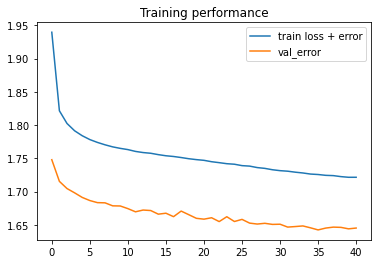

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

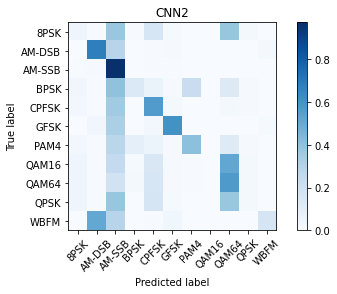

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08395245170876671
Overall Accuracy:  0.09279112754158965


Overall Accuracy:  0.0929657122658183


Overall Accuracy:  0.09486999297259312


Overall Accuracy:  0.108742774566474


Overall Accuracy:  0.1636233440744719


Overall Accuracy:  0.23575779290576854


Overall Accuracy:  0.3241279069767442


Overall Accuracy:  0.4235001774937877


Overall Accuracy:  0.5125808770668584


Overall Accuracy:  0.5159767610748003


Overall Accuracy:  0.5456184637576632


Overall Accuracy:  0.5411764705882353


Overall Accuracy:  0.5462686567164179


Overall Accuracy:  0.5320605187319885


Overall Accuracy:  0.5402843601895735


Overall Accuracy:  0.5557201036653091


Overall Accuracy:  0.5404287326062429


Overall Accuracy:  0.5607958732498157


Overall Accuracy:  0.5487455197132617


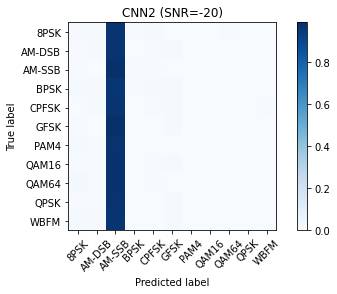

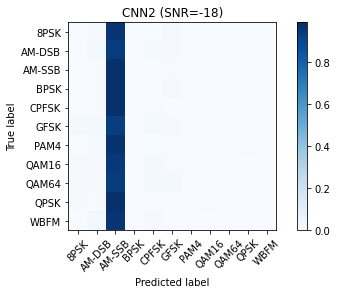

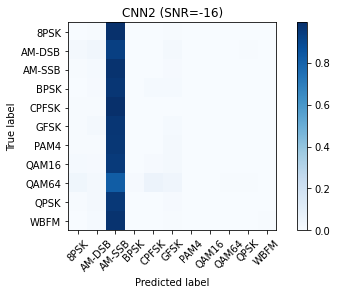

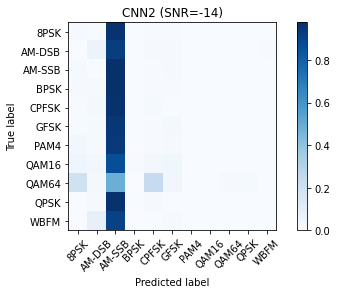

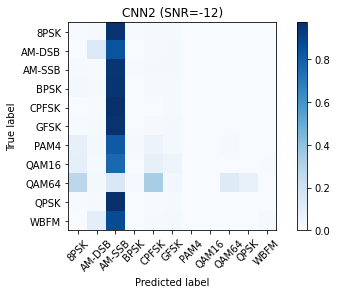

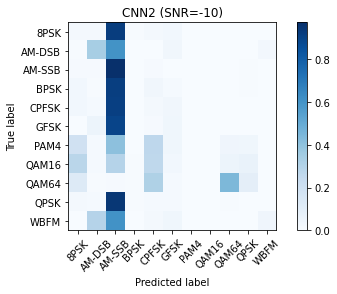

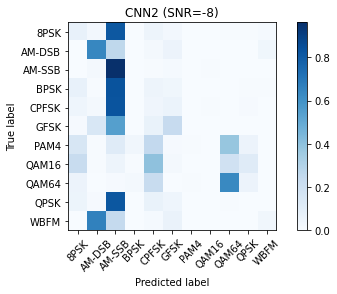

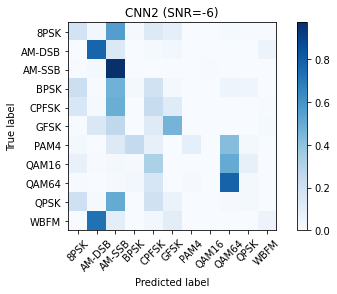

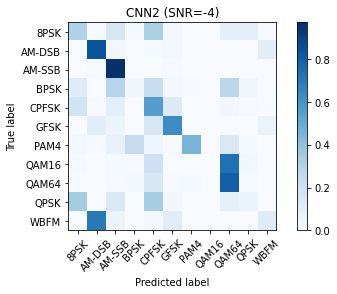

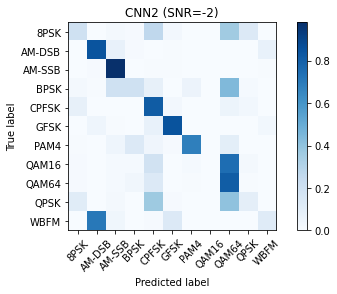

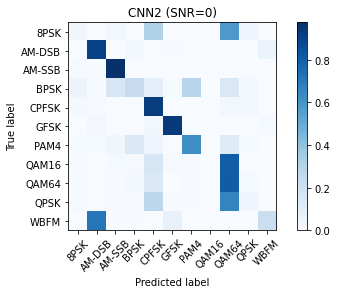

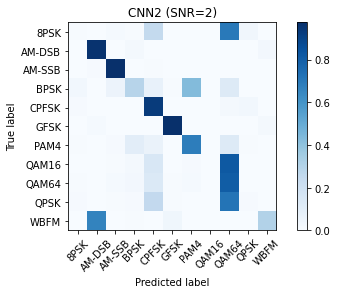

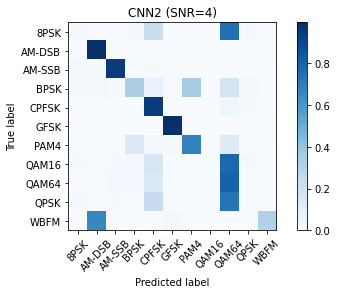

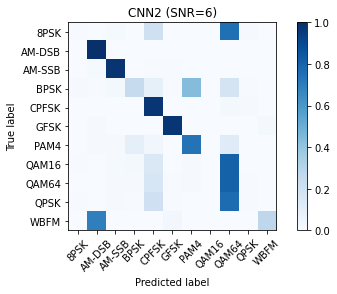

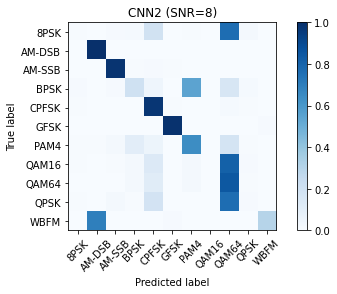

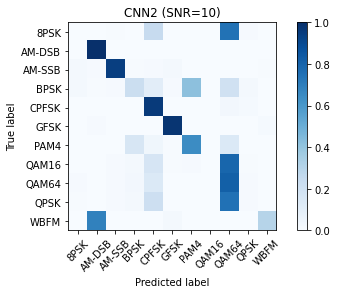

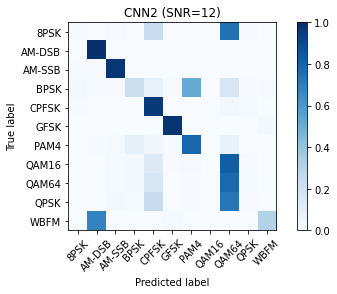

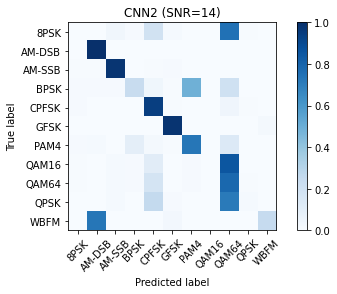

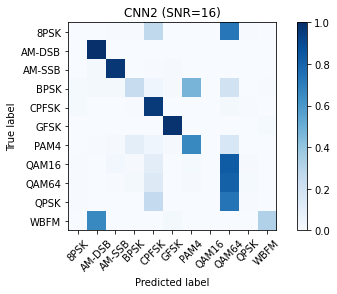

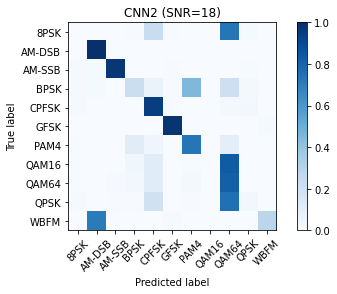

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,9,10,16,23,32,42,51,51,54,54,54,53,54,55,54,56,54


In [18]:
import statistics

statistics.mean(acc.values())

0.37799938089330903

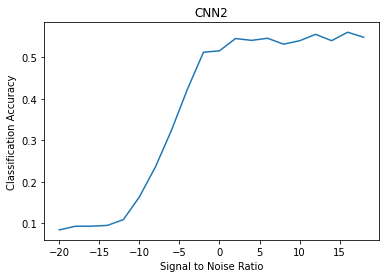

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)